In [15]:
import os
import sys
import json
import datetime
import numpy as np

import skimage.draw


from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
import glob

In [2]:
# Code for combining multiple annotation files into one

# # Load the contents of the JSON files
# with open(r'C:\Users\Admin\Downloads\via_project_18Jan2024_10h42m_json.json', 'r') as file:
#     spherical_annotations = json.load(file)

# with open(r'E:\mask_rcnn\annotations\mixed_model_annotations.json', 'r') as file:
#     irregular_annotations = json.load(file)

# # Merge the contents of the two JSON files
# merged_annotations = {**spherical_annotations, **irregular_annotations}

# # Save the merged content to a new JSON file
# output_file_path = r'E:\mask_rcnn\annotations\mixed_model_annotations.json'
# with open(output_file_path, 'w') as file:
#     json.dump(merged_annotations, file)

# output_file_path


In [16]:
import math


class CustomDataset(Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes according to the numbe of classes required to detect
        self.add_class("custom", 1, "organiod")
 
        master_annotations = json.load(open(r"E:\mask_rcnn\annotations\mixed_model_with_phase_contrast.json"))
        master_annotations = list(master_annotations.values())  # don't need the dict keys

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        #dataset_dir = os.path.join(dataset_dir, subset)
        images_in_dir = os.listdir(dataset_dir)

        # find annotations for images in dir
        for image in images_in_dir:
            for annotation in master_annotations:
                # check if image exists
                filename = annotation['filename']
                
                image_path = os.path.join(dataset_dir, filename)
                if os.path.isfile(image_path) == True:
                    
                    if len(annotation['regions']) == 0:
                        filename = annotation['filename']
                        image_path = os.path.join(dataset_dir, filename)
                        os.remove(image_path)
                        #break
                        #break
                    if annotation['filename'] == image:
                        #if matched get info
                        filename = annotation['filename']

                        #load image to get its size
                        image_path = os.path.join(dataset_dir, filename)
                        image_loaded = skimage.io.imread(image_path)
                        height, width = image_loaded.shape[:2]

                        image_annotations = annotation['regions']
                        num_ids = [1] * len(image_annotations)
                        polygon_list = []
                        for a in image_annotations:
                            polygon_list.append(a['shape_attributes'])

                        print('adding image: ', filename)
                        self.add_image(
                            "custom",
                            image_id=filename,  # use file name as a unique image id
                            path=image_path,
                            width=width, height=height,
                            polygons=polygon_list,
                            num_ids=num_ids)
                    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a custom dataset image, delegate to parent class.
        info = self.image_info[image_id]

        num_ids = info['num_ids']
        #print("Here is the numID",num_ids)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        #generate empty mask
        mask = np.zeros([info["height"], info["width"], len(num_ids)],
                        dtype=np.uint8)
        def radian_to_deg(x):
            return x * 180/math.pi

        for i, p in enumerate( info['polygons']):

            if p['name'] == 'ellipse':  
                cx = int(p['cx'])
                cy = int(p['cy'])
                center = (cx,cy)
                rx = int(p['rx'])
                ry = int(p['ry'])
                axes = (rx,ry)
                if 'theta' in p:
                    thetaa = math.pi - p['theta']
                else:
                    thetaa = 0
                

                rr, cc = skimage.draw.ellipse(cy, cx, ry, rx, rotation = thetaa)

                #on the off chance that some masks fall exactly on the border, fix mask value
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1

                mask[rr,cc,i] = 1
            if p['name'] == 'circle':
                cx = int(p['cx'])
                cy = int(p['cy'])
                center = (cx,cy) 
                radius = int(p['r'])
                rr, cc = skimage.draw.circle(cy,cx, radius)
                #on the off chance that some masks fall exactly on the border, fix mask value
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1
                mask[rr,cc,i] = 1
            if p['name'] == 'polyline':
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                #on the off chance that some masks fall exactly on the border, fix mask value
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1
                mask[rr, cc, i] = 1
            if p['name'] == 'polygon':
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                #on the off chance that some masks fall exactly on the border, fix mask value
                rr[rr > mask.shape[0]-1] = mask.shape[0]-1
                cc[cc > mask.shape[1]-1] = mask.shape[1]-1
                mask[rr, cc, i] = 1


        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        num_ids = np.array(num_ids, dtype=np.int32)	
        return mask, num_ids 
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = cv2.imread(self.image_info[image_id]['path'], cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1).astype(np.uint8)
        return image
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)




            

     
        

In [3]:
# Code for splitting image datasets into training and testing in an 80:20 split


# import os
# import random
# import shutil

# def split_dataset(full_dir, train_dir, val_dir, train_ratio=0.7):
#     # Create train and val directories if they don't exist
#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)

#     # Get list of all files in the full directory
#     all_files = os.listdir(full_dir)

#     # Shuffle the files randomly
#     random.shuffle(all_files)

#     # Calculate the split point
#     split_point = int(len(all_files) * train_ratio)

#     # Split the files into training and validation sets
#     train_files = all_files[:split_point]
#     val_files = all_files[split_point:]

#     # Move files to respective directories
#     for file in train_files:
#         shutil.move(os.path.join(full_dir, file), os.path.join(train_dir, file))

#     for file in val_files:
#         shutil.move(os.path.join(full_dir, file), os.path.join(val_dir, file))

# # Define directories
# full_dir = r'E:\mask_rcnn\mixed_model\full'
# train_dir = r'E:\mask_rcnn\mixed_model\train'
# val_dir = r'E:\mask_rcnn\mixed_model\val'

# # Split the dataset
# split_dataset(full_dir, train_dir, val_dir)


In [17]:
#code for generating mean pixel intensity used in model configuration

# find mean pixel in images
from numpy import mean
import cv2
dataset_dir = os.path.join(r"E:\mask_rcnn\mixed_model", "train")
images_in_dir = os.listdir(dataset_dir)
images_in_dir = [os.path.join("E:/mask_rcnn/mixed_model/train/", x) for x in images_in_dir]
mean_pixel_values_training = [mean(cv2.imread(x,cv2.IMREAD_GRAYSCALE)) for x in images_in_dir]

dataset_dir = os.path.join(r"E:\mask_rcnn\mixed_model", "val")
images_in_dir = os.listdir(dataset_dir)
images_in_dir = [os.path.join("E:/mask_rcnn/mixed_model/val/", x) for x in images_in_dir]
mean_pixel_values_val = [mean(cv2.imread(x,cv2.IMREAD_GRAYSCALE)) for x in images_in_dir]

overall_mean_pixel_value= mean(mean_pixel_values_training + mean_pixel_values_val)
overall_mean_pixel_value

162.84507977505714

In [4]:
# code to ensure that all annotations are seen only once since this can cause issues

# master_annotations = json.load(open(r"E:\mask_rcnn\annotations\mixed_model_annotations.json"))
# dict_keys = list(master_annotations.keys())
# master_annotations = list(master_annotations.values())  # don't need the dict keys

# def removeduplicate(it):
#     seen = []
#     for x in it:
#         if x not in seen:
#             yield x
#             seen.append(x)
    

# for annotation in master_annotations:
#     annotation['regions'] = list(removeduplicate(annotation['regions']))


# fixed_annotations = dict(zip(dict_keys, master_annotations))

# #save updated annotations
# with open(r"E:\mask_rcnn\annotations\mixed_model_annotations.json", "w") as outfile:
#     json.dump(fixed_annotations, outfile)



In [18]:
#load the training dataset

from mrcnn.visualize import display_instances


dataset_train = CustomDataset()
dataset_train.load_custom(r"E:\mask_rcnn\mixed_model", "train") 
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))


adding image:  Subset40_512x512_001.jpg
adding image:  Subset40_512x512_002.jpg
adding image:  Subset40_512x512_003.jpg
adding image:  Subset40_512x512_004.jpg
adding image:  Subset40_512x512_008.jpg
adding image:  Subset40_512x512_009.jpg
adding image:  Subset40_512x512_010.jpg
adding image:  Subset50_512x512_002.jpg
adding image:  Subset50_512x512_004.jpg
adding image:  Subset50_512x512_009.jpg
adding image:  Subset50_512x512_010.jpg
adding image:  Subset50_512x512_011.jpg
adding image:  Subset50_512x512_012.jpg
adding image:  Subset50_512x512_013.jpg
adding image:  Subset50_512x512_017.jpg
adding image:  Subset50_512x512_018.jpg
adding image:  Subset50_512x512_019.jpg
adding image:  Subset50_512x512_020.jpg
adding image:  Subset50_512x512_025.jpg
adding image:  Subset50_512x512_026.jpg
adding image:  Subset50_512x512_027.jpg
adding image:  Subset50_512x512_028.jpg
adding image:  Subset50_512x512_029.jpg
adding image:  Subset50_512x512_034.jpg
adding image:  Subset50_512x512_035.jpg


adding image:  Subsetir11_512x512_018.jpg
adding image:  Subsetir11_512x512_020.jpg
adding image:  Subsetir11_512x512_021.jpg
adding image:  Subsetir11_512x512_022.jpg
adding image:  Subsetir11_512x512_023.jpg
adding image:  Subsetir11_512x512_025.jpg
adding image:  Subsetir11_512x512_026.jpg
adding image:  Subsetir11_512x512_027.jpg
adding image:  Subsetir11_512x512_028.jpg
adding image:  Subsetir11_512x512_032.jpg
adding image:  Subsetir11_512x512_033.jpg
adding image:  Subsetir16_512x512_000.jpg
adding image:  Subsetir16_512x512_001.jpg
adding image:  Subsetir16_512x512_002.jpg
adding image:  Subsetir16_512x512_003.jpg
adding image:  Subsetir16_512x512_004.jpg
adding image:  Subsetir16_512x512_005.jpg
adding image:  Subsetir16_512x512_006.jpg
adding image:  Subsetir16_512x512_008.jpg
adding image:  Subsetir16_512x512_009.jpg
adding image:  Subsetir16_512x512_010.jpg
adding image:  Subsetir16_512x512_011.jpg
adding image:  Subsetir16_512x512_012.jpg
adding image:  Subsetir16_512x512_

adding image:  Subset_1_300x300_044.jpg
adding image:  Subset_1_300x300_045.jpg
adding image:  Subset_1_300x300_046.jpg
adding image:  Subset_1_300x300_048.jpg
adding image:  Subset_1_300x300_049.jpg
adding image:  Subset_1_300x300_050.jpg
adding image:  Subset_1_300x300_051.jpg
adding image:  Subset_1_300x300_052.jpg
adding image:  Subset_1_300x300_053.jpg
adding image:  Subset_1_300x300_054.jpg
adding image:  Subset_1_300x300_055.jpg
adding image:  Subset_1_300x300_056.jpg
adding image:  Subset_1_300x300_057.jpg
adding image:  Subset_1_300x300_058.jpg
adding image:  Subset_1_300x300_059.jpg
adding image:  Subset_1_300x300_060.jpg
adding image:  Subset_1_300x300_061.jpg
adding image:  Subset_1_300x300_062.jpg
adding image:  Subset_1_300x300_063.jpg
adding image:  Subset_1_300x300_064.jpg
adding image:  Subset_1_300x300_065.jpg
adding image:  Subset_1_300x300_066.jpg
adding image:  Subset_1_300x300_067.jpg
adding image:  Subset_1_300x300_068.jpg
adding image:  Subset_1_300x300_069.jpg


adding image:  Subset_1_450x450_039.jpg
adding image:  Subset_1_450x450_040.jpg
adding image:  Subset_1_450x450_041.jpg
adding image:  Subset_1_450x450_042.jpg
adding image:  Subset_1_450x450_043.jpg
adding image:  Subset_1_450x450_044.jpg
adding image:  Subset_1_450x450_045.jpg
adding image:  Subset_1_450x450_046.jpg
adding image:  Subset_1_450x450_047.jpg
adding image:  Subset_1_450x450_048.jpg
adding image:  Subset_1_450x450_049.jpg
adding image:  Subset_1_450x450_050.jpg
adding image:  Subset_1_450x450_051.jpg
adding image:  Subset_1_450x450_052.jpg
adding image:  Subset_1_450x450_053.jpg
adding image:  Subset_1_450x450_054.jpg
adding image:  Subset_1_450x450_055.jpg
adding image:  Subset_1_450x450_056.jpg
adding image:  Subset_1_450x450_057.jpg
adding image:  Subset_1_450x450_058.jpg
adding image:  Subset_1_450x450_059.jpg
adding image:  Subset_1_450x450_060.jpg
adding image:  Subset_1_450x450_061.jpg
adding image:  Subset_1_450x450_062.jpg
adding image:  Subset_1_450x450_063.jpg


adding image:  Subset_j_300x300_018.jpg
adding image:  Subset_j_300x300_020.jpg
adding image:  Subset_j_300x300_021.jpg
adding image:  Subset_j_300x300_022.jpg
adding image:  Subset_q_300x300_006.jpg
adding image:  Subset_q_300x300_007.jpg
adding image:  Subset_q_300x300_016.jpg
adding image:  Subset_q_300x300_017.jpg
adding image:  Subset_q_300x300_018.jpg
adding image:  Subset_q_300x300_021.jpg
adding image:  Subset_q_300x300_022.jpg
adding image:  Subset_q_300x300_030.jpg
adding image:  Subset_q_300x300_032.jpg
adding image:  Subset_q_300x300_033.jpg
adding image:  Subset_q_300x300_034.jpg
adding image:  Subset_q_300x300_035.jpg
adding image:  Subset_q_300x300_036.jpg
adding image:  Subset_q_300x300_040.jpg
adding image:  Subset_q_300x300_041.jpg
adding image:  Subset_q_300x300_042.jpg
adding image:  Subset_q_300x300_043.jpg
adding image:  Subset_q_300x300_044.jpg
adding image:  Subset_q_300x300_045.jpg
adding image:  Subset_q_300x300_046.jpg
adding image:  Subset_q_300x300_047.jpg


In [19]:
#load the validation dataset

dataset_val = CustomDataset()
dataset_val.load_custom(r"E:\mask_rcnn\mixed_model", "val")
dataset_val.prepare()
print('Validation: %d' % len(dataset_val.image_ids))

adding image:  Subset40_512x512_002.jpg
adding image:  Subset40_512x512_003.jpg
adding image:  Subset40_512x512_004.jpg
adding image:  Subset40_512x512_008.jpg
adding image:  Subset40_512x512_009.jpg
adding image:  Subset40_512x512_010.jpg
adding image:  Subset50_512x512_002.jpg
adding image:  Subset50_512x512_018.jpg
adding image:  Subset50_512x512_019.jpg
adding image:  Subset50_512x512_020.jpg
adding image:  Subset50_512x512_021.jpg
adding image:  Subset50_512x512_035.jpg
adding image:  Subset50_512x512_036.jpg
adding image:  Subset50_512x512_037.jpg
adding image:  Subset51_512x512_002.jpg
adding image:  Subset51_512x512_009.jpg
adding image:  Subset51_512x512_012.jpg
adding image:  Subset51_512x512_013.jpg
adding image:  Subset51_512x512_016.jpg
adding image:  Subset51_512x512_021.jpg
adding image:  Subset51_512x512_026.jpg
adding image:  Subset51_512x512_027.jpg
adding image:  Subset51_512x512_028.jpg
adding image:  Subset51_512x512_029.jpg
adding image:  Subset51_512x512_034.jpg


adding image:  Subsetir6_512x512_022.jpg
adding image:  Subsetir6_512x512_023.jpg
adding image:  Subsetir6_512x512_026.jpg
adding image:  Subsetir6_512x512_028.jpg
adding image:  Subsetir6_512x512_029.jpg
adding image:  Subsetir6_512x512_031.jpg
adding image:  Subsetir6_512x512_032.jpg
adding image:  Subsetir6_512x512_033.jpg
adding image:  Subsetir6_512x512_039.jpg
adding image:  Subsetir7_512x512_002.jpg
adding image:  Subsetir7_512x512_004.jpg
adding image:  Subsetir7_512x512_007.jpg
adding image:  Subsetir7_512x512_008.jpg
adding image:  Subsetir7_512x512_010.jpg
adding image:  Subsetir8_512x512_000.jpg
adding image:  Subsetir8_512x512_003.jpg
adding image:  Subsetir8_512x512_006.jpg
adding image:  Subsetir8_512x512_009.jpg
adding image:  Subsetir9_512x512_000.jpg
adding image:  Subsetir9_512x512_002.jpg
adding image:  Subsetir9_512x512_003.jpg
adding image:  Subsetir9_512x512_004.jpg
adding image:  Subsetir9_512x512_008.jpg
adding image:  Subsetir9_512x512_010.jpg
adding image:  S

adding image:  Subset_1_450x450_066.jpg
adding image:  Subset_1_450x450_068.jpg
adding image:  Subset_1_450x450_069.jpg
adding image:  Subset_1_450x450_070.jpg
adding image:  Subset_1_450x450_071.jpg
adding image:  Subset_1_450x450_074.jpg
adding image:  Subset_1_450x450_077.jpg
adding image:  Subset_1_450x450_080.jpg
adding image:  Subset_1_450x450_082.jpg
adding image:  Subset_1_450x450_083.jpg
adding image:  Subset_1_450x450_091.jpg
adding image:  Subset_2_300x300_003.jpg
adding image:  Subset_2_300x300_011.jpg
adding image:  Subset_2_300x300_021.jpg
adding image:  Subset_2_300x300_022.jpg
adding image:  Subset_2_300x300_023.jpg
adding image:  Subset_2_300x300_024.jpg
adding image:  Subset_2_300x300_027.jpg
adding image:  Subset_2_300x300_029.jpg
adding image:  Subset_2_300x300_030.jpg
adding image:  Subset_2_300x300_033.jpg
adding image:  Subset_2_300x300_036.jpg
adding image:  Subset_2_300x300_037.jpg
adding image:  Subset_2_300x300_040.jpg
adding image:  Subset_2_300x300_044.jpg


adding image:  Subset_t_300x300_073.jpg
adding image:  Subset_t_300x300_077.jpg
adding image:  Subset_t_300x300_078.jpg
adding image:  Subset_t_300x300_080.jpg
adding image:  Subset_t_300x300_082.jpg
adding image:  Subset_t_300x300_083.jpg
adding image:  Subset_t_300x300_086.jpg
adding image:  Subset_t_300x300_088.jpg
adding image:  Subset_t_300x300_089.jpg
adding image:  Subset_t_300x300_090.jpg
adding image:  Subset_t_300x300_092.jpg
adding image:  Subset_t_300x300_093.jpg
adding image:  Subset_t_300x300_094.jpg
adding image:  Subset_t_300x300_097.jpg
adding image:  Subset_t_300x300_099.jpg
adding image:  Subset_t_300x300_102.jpg
adding image:  Subset_t_300x300_106.jpg
adding image:  Subset_t_300x300_107.jpg
adding image:  Subset_t_300x300_110.jpg
adding image:  Subset_t_300x300_115.jpg
adding image:  Subset_t_300x300_119.jpg
adding image:  Subset_t_300x300_120.jpg
adding image:  Subset_t_300x300_121.jpg
adding image:  Subset_t_300x300_123.jpg
adding image:  Subset_t_300x300_124.jpg


In [20]:
#modified display_instances_function

def display_instances(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    positions: [list of (i,j) coordinates dictating the patch that was analysed]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    #colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image.astype(np.uint8), cmap='gray')
    
    #masked_image = image.astype(np.uint32).copy()
    
    if positions == None:
                positions = [(0,0)] * N
            
    for i in range(N):
        # generate colormap and color
        my_cmap = getattr(cm, random.choice(list_of_colormaps)).copy()
        my_cmap.set_under('k', alpha=0)
        color = my_cmap(0.9)

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

        # Label
        if show_captions:
            ax.text(x1+10, y1 + 10, i,
                    color='w', size=11, backgroundcolor="none")

        # Mask
#         mask = masks[:, :, i]
#         if show_mask:
#             masked_image = apply_mask(masked_image, mask, positions[i], color)


        if show_mask:
            
            mask = masks[:,:,i]
            x = positions[i][0]
            y = positions[i][1]
            left = y
            right = width - left
            top = x
            bottom = height - top
            #print(image.shape)
            #print(top,bottom,left,right)
            plt.imshow(np.pad(mask, ((top, bottom), (left, right))), cmap=my_cmap, interpolation='none', clim=[0.9, 1], alpha = 0.5) 

        
    if auto_show:
        plt.show()

Showing training image ID: 344
(512, 512, 1)


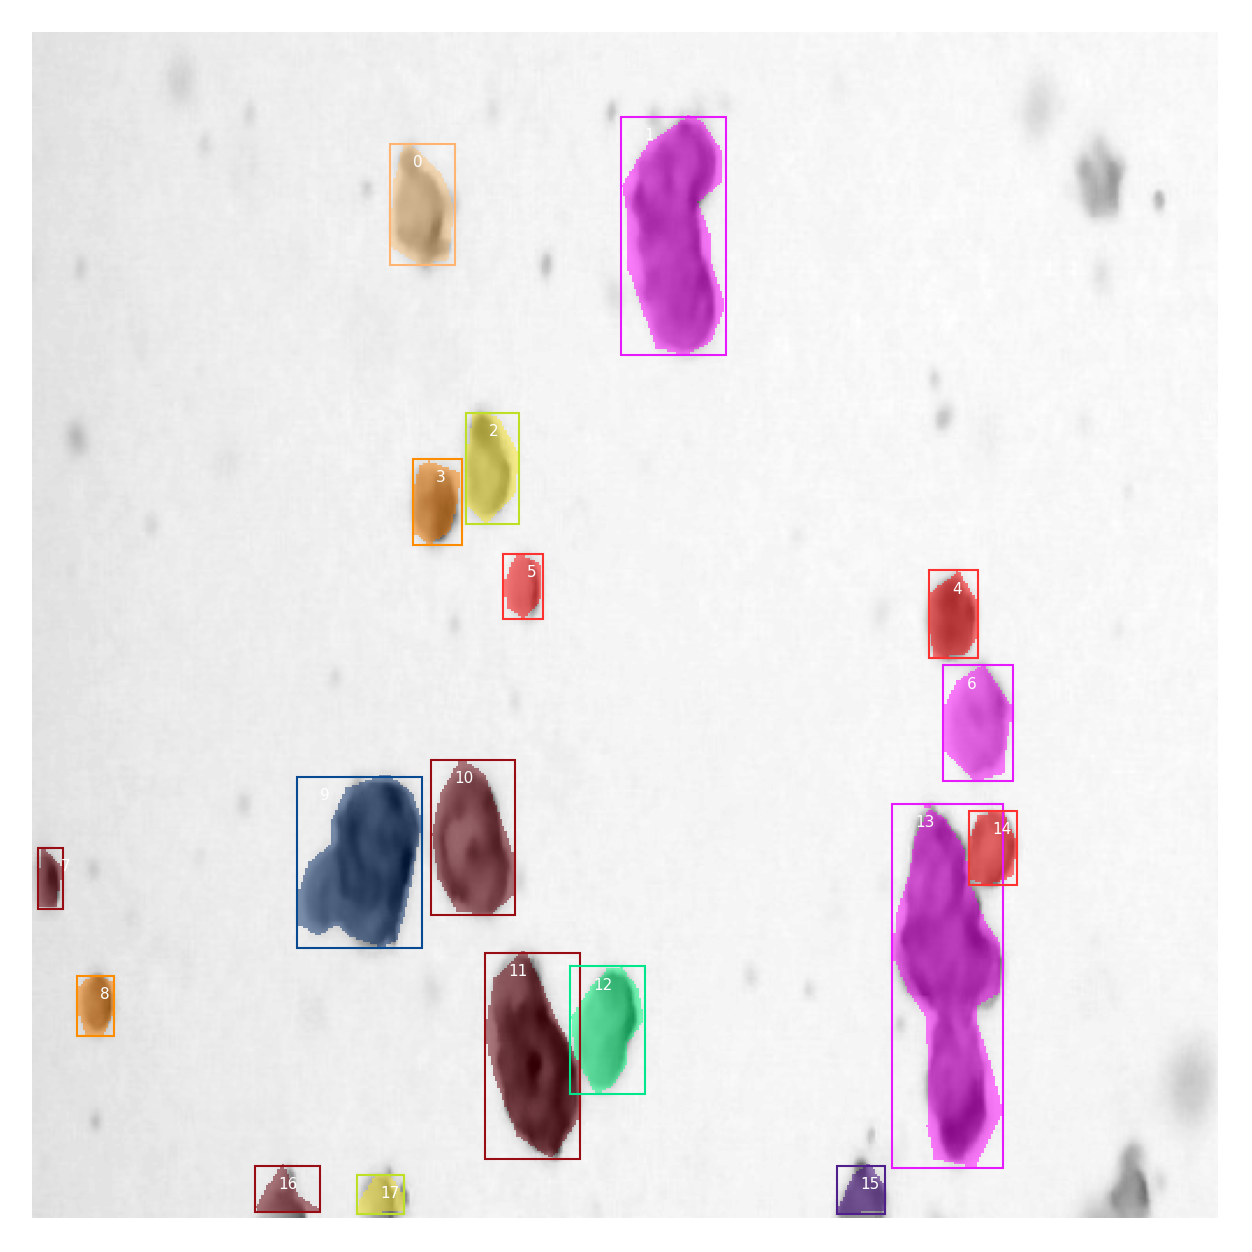

In [21]:
#code to ensure that annotations are properly loaded and overlapping organoids in images

import random
import colorsys
from matplotlib import patches,  lines
import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import matplotlib.cm as cm
import cv2

list_of_colormaps = [
    'viridis','Purples', 'Blues','Reds','winter', 'cool','Wistia', 'copper','bwr'
]


n = random.randint(0,len(dataset_train.image_ids))


print('Showing training image ID: ' + str(n))
# load the image
image = dataset_train.load_image(n)
print(image.shape)
info = dataset_train.image_info[n]

# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(n)

bbox = extract_bboxes(mask)
# # display image with masks and bounding boxes
display_instances(image, bbox, mask,positions = None, class_ids = class_ids, class_names =  dataset_train.class_names)

#confirmed everything works okay - proceed to training





In [22]:
#code to find the diversity of mask sizes to be used during model configuration

import pandas as pd
import seaborn as sns
from mrcnn import utils
def find_dimaeters(bb):
    x_diameter = bb[3]-bb[1]
    y_diameter = bb[2]-bb[0]
    return(x_diameter,y_diameter)

def scale_to_512(image_size,diameters):
    multiplier = 512/image_size
    x_diameter = diameters[0]*multiplier
    y_diameter = diameters[1]*multiplier
    return(int(x_diameter),int(y_diameter))

diameters = []

for n in range(len(dataset_train.image_ids)):
    image_size = dataset_train.load_image(n).shape[0]
    # load the masks and the class ids
    mask, class_ids = dataset_train.load_mask(n)

    bbox = utils.extract_bboxes(mask)
    for i,bb in enumerate(bbox):
        found_diameters = scale_to_512(image_size,find_dimaeters(bb))
        diameters.append({'Image_ID' : n,
                          'organoid_id' : i,
                          'diameter_orientation': 'x',
                          'diameter' : found_diameters[0]})
        
        diameters.append({'Image_ID' : n,
                          'organoid_id' : i,
                          'diameter_orientation': 'y',
                          'diameter' : found_diameters[1]})

        

df = pd.DataFrame(diameters)

# drop datapoints with 0 which may skew that visualisation and just represent empty labels
df = df[df.diameter != 0]

# drop labels with diameter greater than 500 since these are likely to be mislabelled organoids
df = df[df.diameter < 500]

q1, q3 = np.percentile(df.diameter, [25, 75])
whisker_low = q1 - (q3 - q1) * 1.5
whisker_high = q3 + (q3 - q1) * 1.5
outliers = df[(df.diameter > whisker_high) | (df.diameter < whisker_low)]
outliers.replace('x', 0)
outliers.replace('y', 1)



sns.violinplot(df, y="diameter", x = "diameter_orientation", orient = 'v',inner="quartile",
    notch=False, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"}).set(
    ylabel='Diameter (pixels)', 
    xlabel='Diameter axis'
)
sns.stripplot(outliers,x='diameter_orientation', y='diameter', marker='.', color='black', size = 5)
plt.ylim(0, 500)

print(20,q1,q3,whisker_high,400)

In [32]:
# now defining configuration for the model based on the aforementioned parameters
from keras import backend as K 
K.clear_session()

class sphericalConfig(Config):
	# define the name of the configuration
	NAME = "sphericalConfig"
	BACKBONE = "resnet101"
	# number of classes (background + organoids)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = len(dataset_train.image_ids)
	VALIDATION_STEPS = len(dataset_val.image_ids)
	IMAGES_PER_GPU  = 1
	DETECTION_MIN_CONFIDENCE = 0.8
	DETECTION_NMS_THRESHOLD = 0.5       
	WEIGHT_DECAY = 0.001
	TRAIN_ROIS_PER_IMAGE = 600
	MAX_GT_INSTANCES = 50
	IMAGE_MIN_DIM = 512
	IMAGE_MAX_DIM = 512
	IMAGE_MIN_SCALE = 2.0
	LEARNING_RATE = 0.0001
	IMAGE_CHANNEL_COUNT = 1
	MEAN_PIXEL = int(overall_mean_pixel_value)
	USE_MINI_MASK=True
	IMAGE_RESIZE_MODE ='crop'
# Length of square anchor side in pixels
	RPN_ANCHOR_SCALES = (20,int(q1),int(q3),int(whisker_high),400)
	RPN_NMS_THRESHOLD = 0.9
	RPN_TRAIN_ANCHORS_PER_IMAGE = 512
	RPN_ANCHOR_STRIDE = 1 
	RPN_ANCHOR_RATIOS = [0.5,1,2]        
# prepare config
config = sphericalConfig()
config.display() 




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   1]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

124


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


mask                     shape: (56, 56, 6)           min:    0.00000  max:    1.00000  bool


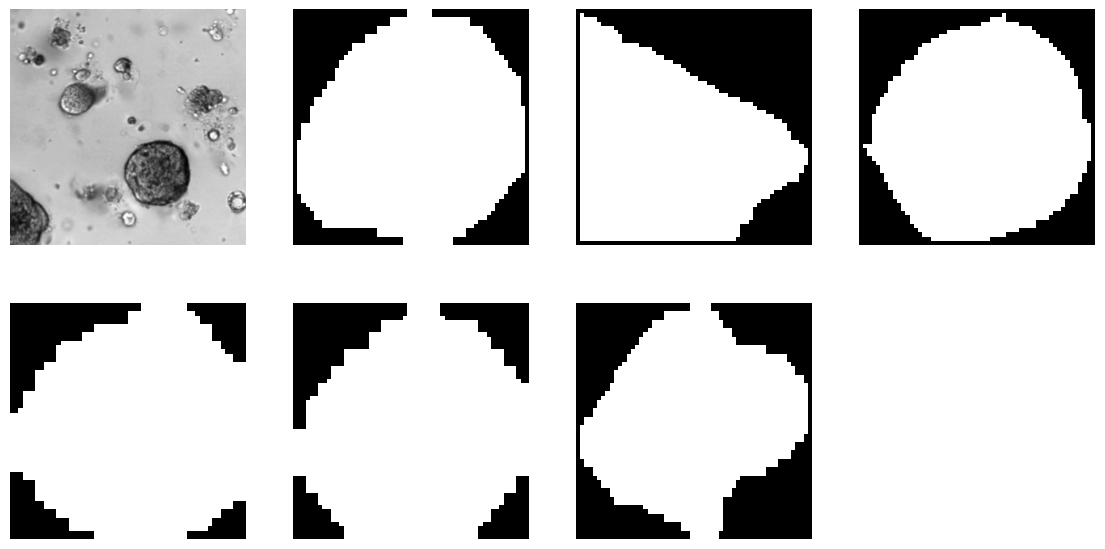

In [33]:
# visualize effect of augmentations
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()



import imgaug.augmenters as iaa
n = random.randint(1, 600)
print(n)
# augmentation = iaa.SomeOf((0, 2), [
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5),
#     iaa.OneOf([iaa.Affine(rotate=90),
#                iaa.Affine(rotate=180),
#                iaa.Affine(rotate=270)]),
#     iaa.Multiply((0.8, 1.5)),
#     iaa.GaussianBlur(sigma=(0.0, 5.0))
# ])

augmentation = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.5))
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.ContrastNormalization((0.75, 1.5)),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-10, 10),
                shear=(-1, 1))
            ], random_order=True) # apply augmenters in random order


#import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn import model
image, image_meta, class_ids, bbox, mask = model.load_image_gt(
    dataset_train, config, n, augmentation=None, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(0,mask.shape[-1])], cmap ='gray')


In [34]:
# initiate MaskRCNN model training

from keras.callbacks import ModelCheckpoint
from mrcnn.model import MaskRCNN
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'E:\mask_rcnn\mixed_model'
COCO_WEIGHTS_PATH =  r'E:\mask_rcnn\mask_rcnn_coco.h5'

model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
model_path = model.get_imagenet_weights()
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask","conv1"])
#model.log_dir = DEFAULT_LOGS_DIR
# train model on loaded weights on dataset of labelled organoids
print("Train all layers at 0.001 LR")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=200,
            augmentation=augmentation,
            layers='all')


Train all layers at 0.001 LR

Starting at epoch 0. LR=0.0001

Checkpoint Path: E:\mask_rcnn\mask_rcnn_sphericalconfig_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_

C:\Anaconda\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Anaconda\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Anaconda\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/200
   8/1013 [..............................] - ETA: 1:28:34 - loss: 4.6205

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 21:59 - loss: 2.5993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 21:42 - loss: 2.5974

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  91/1013 [=>............................] - ETA: 20:59 - loss: 2.5003

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 19:50 - loss: 2.3989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 136/1013 [===>..........................] - ETA: 18:26 - loss: 2.3531

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 18:19 - loss: 2.3581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 18:21 - loss: 2.3602

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 17:05 - loss: 2.3056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 16:51 - loss: 2.2936

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 16:48 - loss: 2.3278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 279/1013 [=======>......................] - ETA: 15:50 - loss: 2.3656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 322/1013 [========>.....................] - ETA: 15:06 - loss: 2.3620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 336/1013 [========>.....................] - ETA: 14:51 - loss: 2.3545

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 407/1013 [===========>..................] - ETA: 13:29 - loss: 2.3290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 487/1013 [=============>................] - ETA: 11:51 - loss: 2.3118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 11:50 - loss: 2.3117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 499/1013 [=============>................] - ETA: 11:37 - loss: 2.3198

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 501/1013 [=============>................] - ETA: 11:35 - loss: 2.3190

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 559/1013 [===============>..............] - ETA: 10:21 - loss: 2.3073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 586/1013 [================>.............] - ETA: 9:46 - loss: 2.3006

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:40 - loss: 2.2798

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 8:10 - loss: 2.2815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 7:08 - loss: 2.2970

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:16 - loss: 2.2958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:15 - loss: 2.2958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 6:14 - loss: 2.2978

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:11 - loss: 2.2937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 4:06 - loss: 2.2983

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 4:05 - loss: 2.2978

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 848/1013 [========================>.....] - ETA: 3:51 - loss: 2.2974

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 2:48 - loss: 2.2858

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:27 - loss: 2.2691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 983/1013 [============================>.] - ETA: 42s - loss: 2.2688

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 990/1013 [============================>.] - ETA: 32s - loss: 2.2668

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1971s 2s/step - loss: 2.2627 - val_loss: 1.5469
Epoch 2/200
 112/1013 [==>...........................] - ETA: 21:27 - loss: 1.9907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 20:17 - loss: 2.0251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 177/1013 [====>.........................] - ETA: 19:57 - loss: 2.0787

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 19:42 - loss: 2.0760

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 226/1013 [=====>........................] - ETA: 18:54 - loss: 2.0649

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 17:40 - loss: 2.0659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 279/1013 [=======>......................] - ETA: 17:38 - loss: 2.0681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 296/1013 [=======>......................] - ETA: 17:14 - loss: 2.0664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 325/1013 [========>.....................] - ETA: 16:34 - loss: 2.0545

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 335/1013 [========>.....................] - ETA: 16:19 - loss: 2.0474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 448/1013 [============>.................] - ETA: 13:35 - loss: 2.0505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 461/1013 [============>.................] - ETA: 13:17 - loss: 2.0460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 13:16 - loss: 2.0461

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 12:59 - loss: 2.0486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 487/1013 [=============>................] - ETA: 12:42 - loss: 2.0504

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 11:52 - loss: 2.0423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 529/1013 [==============>...............] - ETA: 11:41 - loss: 2.0423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 9:25 - loss: 2.0196

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 622/1013 [=================>............] - ETA: 9:24 - loss: 2.0192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 9:21 - loss: 2.0217

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 726/1013 [====================>.........] - ETA: 6:54 - loss: 2.0097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 6:12 - loss: 2.0041

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 6:01 - loss: 2.0019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 5:16 - loss: 1.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 802/1013 [======================>.......] - ETA: 5:04 - loss: 1.9917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 815/1013 [=======================>......] - ETA: 4:45 - loss: 1.9884

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:37 - loss: 1.9873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 841/1013 [=======================>......] - ETA: 4:08 - loss: 1.9865

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 851/1013 [========================>.....] - ETA: 3:54 - loss: 1.9869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 866/1013 [========================>.....] - ETA: 3:32 - loss: 1.9867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:27 - loss: 1.9802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2013s 2s/step - loss: 1.9669 - val_loss: 1.5904
Epoch 3/200
   4/1013 [..............................] - ETA: 23:39 - loss: 2.0804

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  19/1013 [..............................] - ETA: 23:19 - loss: 1.8571

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  26/1013 [..............................] - ETA: 23:27 - loss: 1.7957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  37/1013 [>.............................] - ETA: 23:24 - loss: 1.9271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  45/1013 [>.............................] - ETA: 23:10 - loss: 1.9221

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 23:17 - loss: 1.9413

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 22:40 - loss: 1.8792

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  80/1013 [=>............................] - ETA: 22:29 - loss: 1.8762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  92/1013 [=>............................] - ETA: 22:11 - loss: 1.8549

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 20:34 - loss: 1.8172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 174/1013 [====>.........................] - ETA: 20:05 - loss: 1.8401

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 19:43 - loss: 1.8411

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 238/1013 [======>.......................] - ETA: 18:36 - loss: 1.8324

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 17:57 - loss: 1.8250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 365/1013 [=========>....................] - ETA: 15:30 - loss: 1.7833

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 419/1013 [===========>..................] - ETA: 14:13 - loss: 1.7836

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 435/1013 [===========>..................] - ETA: 13:50 - loss: 1.7791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 11:47 - loss: 1.7865

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 9:38 - loss: 1.7837

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 9:23 - loss: 1.7841

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 8:59 - loss: 1.7904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 8:11 - loss: 1.7869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:42 - loss: 1.7931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 696/1013 [===================>..........] - ETA: 7:35 - loss: 1.7961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 706/1013 [===================>..........] - ETA: 7:21 - loss: 1.7984

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:55 - loss: 1.8027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 725/1013 [====================>.........] - ETA: 6:54 - loss: 1.8033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 6:47 - loss: 1.8033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 6:37 - loss: 1.8039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 6:07 - loss: 1.8040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 768/1013 [=====================>........] - ETA: 5:52 - loss: 1.8027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:54 - loss: 1.8013

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:17 - loss: 1.7963

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 927/1013 [==========================>...] - ETA: 2:03 - loss: 1.7914

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:53 - loss: 1.7933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 952/1013 [===========================>..] - ETA: 1:27 - loss: 1.7948

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2007s 2s/step - loss: 1.7949 - val_loss: 1.5570
Epoch 4/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


   7/1013 [..............................] - ETA: 25:53 - loss: 1.7794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 21:31 - loss: 1.6963

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 21:21 - loss: 1.7058

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 175/1013 [====>.........................] - ETA: 20:03 - loss: 1.7428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 208/1013 [=====>........................] - ETA: 19:14 - loss: 1.7341

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 281/1013 [=======>......................] - ETA: 17:24 - loss: 1.7047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 17:25 - loss: 1.7047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 17:12 - loss: 1.7157

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 17:06 - loss: 1.7150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 15:32 - loss: 1.7203

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 15:17 - loss: 1.7200

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 390/1013 [==========>...................] - ETA: 14:55 - loss: 1.7188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 14:27 - loss: 1.7676

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 421/1013 [===========>..................] - ETA: 14:11 - loss: 1.7633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 13:39 - loss: 1.7559

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 466/1013 [============>.................] - ETA: 13:07 - loss: 1.7464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 12:33 - loss: 1.7447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 499/1013 [=============>................] - ETA: 12:19 - loss: 1.7441

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:46 - loss: 1.7359

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 539/1013 [==============>...............] - ETA: 11:22 - loss: 1.7339

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:45 - loss: 1.7365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 656/1013 [==================>...........] - ETA: 8:32 - loss: 1.7347

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 670/1013 [==================>...........] - ETA: 8:13 - loss: 1.7310

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 7:45 - loss: 1.7251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 726/1013 [====================>.........] - ETA: 6:52 - loss: 1.7184

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 6:24 - loss: 1.7174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:49 - loss: 1.7104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 815/1013 [=======================>......] - ETA: 4:43 - loss: 1.7104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:39 - loss: 1.7110

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:22 - loss: 1.7078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 3:06 - loss: 1.7115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:37 - loss: 1.7107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 909/1013 [=========================>....] - ETA: 2:29 - loss: 1.7108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 941/1013 [==========================>...] - ETA: 1:43 - loss: 1.7092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 48s - loss: 1.7069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 987/1013 [============================>.] - ETA: 37s - loss: 1.7079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2005s 2s/step - loss: 1.7041 - val_loss: 1.2065
Epoch 5/200
  36/1013 [>.............................] - ETA: 22:31 - loss: 1.5907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 21:15 - loss: 1.6366

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 129/1013 [==>...........................] - ETA: 20:44 - loss: 1.6065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 20:01 - loss: 1.6077

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 166/1013 [===>..........................] - ETA: 20:01 - loss: 1.6272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 181/1013 [====>.........................] - ETA: 19:43 - loss: 1.6403

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 19:42 - loss: 1.6418

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 19:24 - loss: 1.6329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 18:08 - loss: 1.6280

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 18:07 - loss: 1.6304

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 17:38 - loss: 1.6433

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 305/1013 [========>.....................] - ETA: 16:55 - loss: 1.6573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 16:22 - loss: 1.6494

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 402/1013 [==========>...................] - ETA: 14:36 - loss: 1.6547

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 13:26 - loss: 1.6582

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 457/1013 [============>.................] - ETA: 13:15 - loss: 1.6564

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 478/1013 [=============>................] - ETA: 12:46 - loss: 1.6596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 12:32 - loss: 1.6568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 11:54 - loss: 1.6522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 9:13 - loss: 1.6432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:59 - loss: 1.6448

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 8:56 - loss: 1.6453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 656/1013 [==================>...........] - ETA: 8:30 - loss: 1.6480

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 708/1013 [===================>..........] - ETA: 7:16 - loss: 1.6560

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 751/1013 [=====================>........] - ETA: 6:14 - loss: 1.6543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 6:09 - loss: 1.6537

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 784/1013 [======================>.......] - ETA: 5:27 - loss: 1.6477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 5:21 - loss: 1.6471

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 789/1013 [======================>.......] - ETA: 5:20 - loss: 1.6484

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 5:16 - loss: 1.6501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 819/1013 [=======================>......] - ETA: 4:37 - loss: 1.6444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 835/1013 [=======================>......] - ETA: 4:14 - loss: 1.6432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 844/1013 [=======================>......] - ETA: 4:02 - loss: 1.6443

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 851/1013 [========================>.....] - ETA: 3:52 - loss: 1.6447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:27 - loss: 1.6420

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:20 - loss: 1.6423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 916/1013 [==========================>...] - ETA: 2:18 - loss: 1.6473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 927/1013 [==========================>...] - ETA: 2:03 - loss: 1.6474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 952/1013 [===========================>..] - ETA: 1:27 - loss: 1.6460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2001s 2s/step - loss: 1.6431 - val_loss: 1.5457
Epoch 6/200
  37/1013 [>.............................] - ETA: 22:18 - loss: 1.3692

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  46/1013 [>.............................] - ETA: 22:24 - loss: 1.4247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 171/1013 [====>.........................] - ETA: 19:45 - loss: 1.5143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 17:33 - loss: 1.5381

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 17:24 - loss: 1.5396

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:51 - loss: 1.5563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 413/1013 [===========>..................] - ETA: 14:04 - loss: 1.5604

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 464/1013 [============>.................] - ETA: 12:52 - loss: 1.5654

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 483/1013 [=============>................] - ETA: 12:26 - loss: 1.5661

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:49 - loss: 1.5600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 513/1013 [==============>...............] - ETA: 11:45 - loss: 1.5619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 10:41 - loss: 1.5716

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 565/1013 [===============>..............] - ETA: 10:32 - loss: 1.5711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 9:44 - loss: 1.5731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 620/1013 [=================>............] - ETA: 9:15 - loss: 1.5704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:34 - loss: 1.5695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 669/1013 [==================>...........] - ETA: 8:07 - loss: 1.5769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 674/1013 [==================>...........] - ETA: 8:00 - loss: 1.5790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 712/1013 [====================>.........] - ETA: 7:07 - loss: 1.5741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 733/1013 [====================>.........] - ETA: 6:37 - loss: 1.5731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 782/1013 [======================>.......] - ETA: 5:27 - loss: 1.5753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 5:09 - loss: 1.5744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:32 - loss: 1.5716

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:41 - loss: 1.5695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 886/1013 [=========================>....] - ETA: 3:00 - loss: 1.5700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:09 - loss: 1.5669

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 923/1013 [==========================>...] - ETA: 2:07 - loss: 1.5670

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:54 - loss: 1.5680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 957/1013 [===========================>..] - ETA: 1:19 - loss: 1.5626

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 52s - loss: 1.5640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1991s 2s/step - loss: 1.5598 - val_loss: 1.7130
Epoch 7/200
  24/1013 [..............................] - ETA: 22:37 - loss: 1.4035

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  35/1013 [>.............................] - ETA: 22:47 - loss: 1.4486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 23:06 - loss: 1.4742

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  76/1013 [=>............................] - ETA: 22:22 - loss: 1.5008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 21:14 - loss: 1.4963

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 20:17 - loss: 1.4968

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 198/1013 [====>.........................] - ETA: 19:19 - loss: 1.5441

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 214/1013 [=====>........................] - ETA: 18:57 - loss: 1.5285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 18:53 - loss: 1.5362

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 17:25 - loss: 1.5553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 284/1013 [=======>......................] - ETA: 17:21 - loss: 1.5588

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 17:18 - loss: 1.5565

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 304/1013 [========>.....................] - ETA: 16:54 - loss: 1.5641

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 312/1013 [========>.....................] - ETA: 16:43 - loss: 1.5614

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 465/1013 [============>.................] - ETA: 12:58 - loss: 1.5636

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 498/1013 [=============>................] - ETA: 12:11 - loss: 1.5575

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 11:32 - loss: 1.5586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 526/1013 [==============>...............] - ETA: 11:32 - loss: 1.5590

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:43 - loss: 1.5590

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 9:31 - loss: 1.5503

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 622/1013 [=================>............] - ETA: 9:15 - loss: 1.5494

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 629/1013 [=================>............] - ETA: 9:05 - loss: 1.5484

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:42 - loss: 1.5531

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 711/1013 [====================>.........] - ETA: 7:09 - loss: 1.5567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 6:04 - loss: 1.5484

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:48 - loss: 1.5427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:40 - loss: 1.5539

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:30 - loss: 1.5529

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 868/1013 [========================>.....] - ETA: 3:26 - loss: 1.5542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:16 - loss: 1.5501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 928/1013 [==========================>...] - ETA: 2:00 - loss: 1.5493

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 937/1013 [==========================>...] - ETA: 1:48 - loss: 1.5474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 980/1013 [============================>.] - ETA: 46s - loss: 1.5482

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1993s 2s/step - loss: 1.5503 - val_loss: 1.6673
Epoch 8/200
  29/1013 [..............................] - ETA: 22:48 - loss: 1.4224

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  30/1013 [..............................] - ETA: 23:14 - loss: 1.4473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 23:22 - loss: 1.4591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 21:10 - loss: 1.5662

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 21:05 - loss: 1.5834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 126/1013 [==>...........................] - ETA: 21:06 - loss: 1.5873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 178/1013 [====>.........................] - ETA: 19:42 - loss: 1.5607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 205/1013 [=====>........................] - ETA: 19:07 - loss: 1.5416

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 19:03 - loss: 1.5389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 231/1013 [=====>........................] - ETA: 18:31 - loss: 1.5404

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 286/1013 [=======>......................] - ETA: 17:11 - loss: 1.5329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 297/1013 [=======>......................] - ETA: 16:57 - loss: 1.5303

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 16:06 - loss: 1.5308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 333/1013 [========>.....................] - ETA: 16:06 - loss: 1.5326

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 15:35 - loss: 1.5369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 368/1013 [=========>....................] - ETA: 15:15 - loss: 1.5319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 402/1013 [==========>...................] - ETA: 14:26 - loss: 1.5316

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 421/1013 [===========>..................] - ETA: 13:59 - loss: 1.5303

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 423/1013 [===========>..................] - ETA: 13:57 - loss: 1.5276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:34 - loss: 1.5250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 485/1013 [=============>................] - ETA: 12:29 - loss: 1.5254

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 11:52 - loss: 1.5286

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 11:24 - loss: 1.5299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 7:50 - loss: 1.5364

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 686/1013 [===================>..........] - ETA: 7:42 - loss: 1.5359

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 687/1013 [===================>..........] - ETA: 7:41 - loss: 1.5369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:36 - loss: 1.5370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 725/1013 [====================>.........] - ETA: 6:47 - loss: 1.5321

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 6:02 - loss: 1.5342

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 5:09 - loss: 1.5385

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:27 - loss: 1.5267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:40 - loss: 1.5273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 3:04 - loss: 1.5282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:42 - loss: 1.5268

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 988/1013 [============================>.] - ETA: 35s - loss: 1.5175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1983s 2s/step - loss: 1.5143 - val_loss: 0.9448
Epoch 9/200
  61/1013 [>.............................] - ETA: 22:07 - loss: 1.4434

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  63/1013 [>.............................] - ETA: 22:19 - loss: 1.4599

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 22:26 - loss: 1.4621

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 21:24 - loss: 1.4413

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 20:44 - loss: 1.4361

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 19:19 - loss: 1.4350

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 221/1013 [=====>........................] - ETA: 18:48 - loss: 1.4303

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 17:30 - loss: 1.4268

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 278/1013 [=======>......................] - ETA: 17:26 - loss: 1.4278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 17:25 - loss: 1.4381

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 16:43 - loss: 1.4290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 16:38 - loss: 1.4317

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 16:29 - loss: 1.4324

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 327/1013 [========>.....................] - ETA: 16:20 - loss: 1.4374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 15:23 - loss: 1.4367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 15:17 - loss: 1.4388

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 11:52 - loss: 1.4572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 11:47 - loss: 1.4592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 11:28 - loss: 1.4602

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 10:14 - loss: 1.4485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:58 - loss: 1.4503

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 611/1013 [=================>............] - ETA: 9:32 - loss: 1.4480

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 641/1013 [=================>............] - ETA: 8:50 - loss: 1.4458

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 709/1013 [===================>..........] - ETA: 7:12 - loss: 1.4499

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 746/1013 [=====================>........] - ETA: 6:19 - loss: 1.4524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 751/1013 [=====================>........] - ETA: 6:12 - loss: 1.4536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 814/1013 [=======================>......] - ETA: 4:43 - loss: 1.4542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:56 - loss: 1.4569

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:45 - loss: 1.4511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:49 - loss: 1.4498

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:22 - loss: 1.4509

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 956/1013 [===========================>..] - ETA: 1:21 - loss: 1.4517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 958/1013 [===========================>..] - ETA: 1:18 - loss: 1.4515

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 963/1013 [===========================>..] - ETA: 1:11 - loss: 1.4523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1002/1013 [============================>.] - ETA: 15s - loss: 1.4501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1006/1013 [============================>.] - ETA: 9s - loss: 1.4503 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2002s 2s/step - loss: 1.4532 - val_loss: 1.3736
Epoch 10/200
  87/1013 [=>............................] - ETA: 21:41 - loss: 1.3809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 214/1013 [=====>........................] - ETA: 18:44 - loss: 1.5005

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 17:49 - loss: 1.5074

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 17:42 - loss: 1.5043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 16:13 - loss: 1.4995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 15:56 - loss: 1.4987

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 15:02 - loss: 1.4882

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 14:50 - loss: 1.4875

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 388/1013 [==========>...................] - ETA: 14:39 - loss: 1.4880

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 394/1013 [==========>...................] - ETA: 14:33 - loss: 1.4865

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 419/1013 [===========>..................] - ETA: 13:57 - loss: 1.4811

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 437/1013 [===========>..................] - ETA: 13:31 - loss: 1.4786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 473/1013 [=============>................] - ETA: 12:40 - loss: 1.4817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 478/1013 [=============>................] - ETA: 12:34 - loss: 1.4817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 12:20 - loss: 1.4820

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:59 - loss: 1.4830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 11:19 - loss: 1.4795

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 533/1013 [==============>...............] - ETA: 11:16 - loss: 1.4788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 10:10 - loss: 1.4655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 9:19 - loss: 1.4674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:49 - loss: 1.4695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 8:10 - loss: 1.4606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 7:49 - loss: 1.4594

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 686/1013 [===================>..........] - ETA: 7:40 - loss: 1.4583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 7:18 - loss: 1.4556

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:39 - loss: 1.4516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 747/1013 [=====================>........] - ETA: 6:14 - loss: 1.4521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 779/1013 [======================>.......] - ETA: 5:29 - loss: 1.4491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 5:17 - loss: 1.4518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:47 - loss: 1.4538

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 825/1013 [=======================>......] - ETA: 4:25 - loss: 1.4603

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:36 - loss: 1.4573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 980/1013 [============================>.] - ETA: 46s - loss: 1.4563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1003/1013 [============================>.] - ETA: 14s - loss: 1.4544

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1970s 2s/step - loss: 1.4555 - val_loss: 1.9269
Epoch 11/200
   2/1013 [..............................] - ETA: 24:31 - loss: 1.0849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 23:28 - loss: 1.3677

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 23:03 - loss: 1.3580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 22:36 - loss: 1.3987

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 21:47 - loss: 1.3780

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 21:21 - loss: 1.3974

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 158/1013 [===>..........................] - ETA: 20:26 - loss: 1.4309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 18:39 - loss: 1.4187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 17:32 - loss: 1.4187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 288/1013 [=======>......................] - ETA: 17:12 - loss: 1.4250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 16:58 - loss: 1.4266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 316/1013 [========>.....................] - ETA: 16:34 - loss: 1.4335

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 16:16 - loss: 1.4359

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 402/1013 [==========>...................] - ETA: 14:32 - loss: 1.4178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 473/1013 [=============>................] - ETA: 12:49 - loss: 1.4232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 474/1013 [=============>................] - ETA: 12:48 - loss: 1.4238

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:38 - loss: 1.4256

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:38 - loss: 1.4126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 540/1013 [==============>...............] - ETA: 11:12 - loss: 1.4118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 10:32 - loss: 1.4101

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 10:18 - loss: 1.4106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 590/1013 [================>.............] - ETA: 10:02 - loss: 1.4079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 601/1013 [================>.............] - ETA: 9:46 - loss: 1.4044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 9:33 - loss: 1.4091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:49 - loss: 1.3979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 686/1013 [===================>..........] - ETA: 7:45 - loss: 1.3987

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 7:41 - loss: 1.3990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 6:02 - loss: 1.4105

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:25 - loss: 1.4038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 2:05 - loss: 1.4055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 945/1013 [==========================>...] - ETA: 1:36 - loss: 1.4032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 967/1013 [===========================>..] - ETA: 1:05 - loss: 1.4022

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 996/1013 [============================>.] - ETA: 24s - loss: 1.4045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 999/1013 [============================>.] - ETA: 19s - loss: 1.4042

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1996s 2s/step - loss: 1.4066 - val_loss: 1.0250
Epoch 12/200
  17/1013 [..............................] - ETA: 22:48 - loss: 1.3017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  44/1013 [>.............................] - ETA: 22:19 - loss: 1.2901

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  67/1013 [>.............................] - ETA: 21:57 - loss: 1.3398

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  81/1013 [=>............................] - ETA: 21:35 - loss: 1.3174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  94/1013 [=>............................] - ETA: 21:32 - loss: 1.3496

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 20:56 - loss: 1.3840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 129/1013 [==>...........................] - ETA: 20:48 - loss: 1.3723

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 214/1013 [=====>........................] - ETA: 18:46 - loss: 1.3832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 18:42 - loss: 1.3836

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 271/1013 [=======>......................] - ETA: 17:23 - loss: 1.3791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 288/1013 [=======>......................] - ETA: 17:00 - loss: 1.3709

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 300/1013 [=======>......................] - ETA: 16:45 - loss: 1.3723

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 311/1013 [========>.....................] - ETA: 16:31 - loss: 1.3761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 325/1013 [========>.....................] - ETA: 16:12 - loss: 1.3646

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 428/1013 [===========>..................] - ETA: 13:46 - loss: 1.3979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 13:32 - loss: 1.4006

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 465/1013 [============>.................] - ETA: 12:54 - loss: 1.4074

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 487/1013 [=============>................] - ETA: 12:23 - loss: 1.4051

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 11:49 - loss: 1.3941

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 11:25 - loss: 1.4218

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 10:21 - loss: 1.4184

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 615/1013 [=================>............] - ETA: 9:21 - loss: 1.4249

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 8:18 - loss: 1.4130

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 670/1013 [==================>...........] - ETA: 8:03 - loss: 1.4106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 690/1013 [===================>..........] - ETA: 7:35 - loss: 1.4082

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 7:17 - loss: 1.4086

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 712/1013 [====================>.........] - ETA: 7:05 - loss: 1.4065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 7:03 - loss: 1.4068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 5:17 - loss: 1.4067

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:47 - loss: 1.4077

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 836/1013 [=======================>......] - ETA: 4:09 - loss: 1.4104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 851/1013 [========================>.....] - ETA: 3:48 - loss: 1.4104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 860/1013 [========================>.....] - ETA: 3:36 - loss: 1.4095

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 890/1013 [=========================>....] - ETA: 2:53 - loss: 1.4045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:19 - loss: 1.4072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 945/1013 [==========================>...] - ETA: 1:35 - loss: 1.4138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1976s 2s/step - loss: 1.4131 - val_loss: 1.1608
Epoch 13/200
  68/1013 [=>............................] - ETA: 21:53 - loss: 1.2661

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  76/1013 [=>............................] - ETA: 21:53 - loss: 1.2712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 21:12 - loss: 1.3241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 118/1013 [==>...........................] - ETA: 21:16 - loss: 1.3313

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 21:04 - loss: 1.3257

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 203/1013 [=====>........................] - ETA: 19:08 - loss: 1.3541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 208/1013 [=====>........................] - ETA: 19:05 - loss: 1.3566

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 242/1013 [======>.......................] - ETA: 18:16 - loss: 1.3692

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 17:47 - loss: 1.3711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 16:34 - loss: 1.3658

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 16:02 - loss: 1.3574

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 346/1013 [=========>....................] - ETA: 15:49 - loss: 1.3629

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 389/1013 [==========>...................] - ETA: 14:46 - loss: 1.3657

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 439/1013 [============>.................] - ETA: 13:33 - loss: 1.3560

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 445/1013 [============>.................] - ETA: 13:26 - loss: 1.3552

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 12:44 - loss: 1.3558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 10:55 - loss: 1.3567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:51 - loss: 1.3527

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:40 - loss: 1.3522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 656/1013 [==================>...........] - ETA: 8:25 - loss: 1.3502

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 7:48 - loss: 1.3479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 721/1013 [====================>.........] - ETA: 6:53 - loss: 1.3456

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:20 - loss: 1.3535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 778/1013 [======================>.......] - ETA: 5:32 - loss: 1.3509

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:29 - loss: 1.3503

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 781/1013 [======================>.......] - ETA: 5:28 - loss: 1.3504

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 832/1013 [=======================>......] - ETA: 4:16 - loss: 1.3629

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 956/1013 [===========================>..] - ETA: 1:20 - loss: 1.3532

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 982/1013 [============================>.] - ETA: 43s - loss: 1.3509

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 987/1013 [============================>.] - ETA: 36s - loss: 1.3522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1000/1013 [============================>.] - ETA: 18s - loss: 1.3539

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1001/1013 [============================>.] - ETA: 16s - loss: 1.3554

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1985s 2s/step - loss: 1.3526 - val_loss: 2.0503
Epoch 14/200
  50/1013 [>.............................] - ETA: 22:23 - loss: 1.3231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  87/1013 [=>............................] - ETA: 21:38 - loss: 1.3473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 105/1013 [==>...........................] - ETA: 21:17 - loss: 1.4039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 125/1013 [==>...........................] - ETA: 20:53 - loss: 1.3901

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 169/1013 [====>.........................] - ETA: 19:54 - loss: 1.3783

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 173/1013 [====>.........................] - ETA: 19:51 - loss: 1.3802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 19:18 - loss: 1.3591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 239/1013 [======>.......................] - ETA: 18:14 - loss: 1.3679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 18:08 - loss: 1.3628

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 256/1013 [======>.......................] - ETA: 17:53 - loss: 1.3668

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 271/1013 [=======>......................] - ETA: 17:33 - loss: 1.3684

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 17:18 - loss: 1.3638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 17:07 - loss: 1.3586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 15:39 - loss: 1.3490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 15:02 - loss: 1.3559

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 452/1013 [============>.................] - ETA: 13:17 - loss: 1.3591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 470/1013 [============>.................] - ETA: 12:51 - loss: 1.3530

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 12:03 - loss: 1.3411

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 11:03 - loss: 1.3334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 554/1013 [===============>..............] - ETA: 10:51 - loss: 1.3369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:41 - loss: 1.3470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 9:22 - loss: 1.3496

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 9:08 - loss: 1.3459

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 7:23 - loss: 1.3439

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 721/1013 [====================>.........] - ETA: 6:53 - loss: 1.3464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 6:31 - loss: 1.3466

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 6:20 - loss: 1.3511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 5:12 - loss: 1.3522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 892/1013 [=========================>....] - ETA: 2:51 - loss: 1.3520

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 912/1013 [==========================>...] - ETA: 2:22 - loss: 1.3576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 919/1013 [==========================>...] - ETA: 2:13 - loss: 1.3579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:54 - loss: 1.3565

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 945/1013 [==========================>...] - ETA: 1:36 - loss: 1.3566

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 946/1013 [===========================>..] - ETA: 1:34 - loss: 1.3581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 963/1013 [===========================>..] - ETA: 1:10 - loss: 1.3547

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 965/1013 [===========================>..] - ETA: 1:08 - loss: 1.3540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1986s 2s/step - loss: 1.3509 - val_loss: 1.2916
Epoch 15/200
  30/1013 [..............................] - ETA: 23:22 - loss: 1.4166

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 22:12 - loss: 1.3979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 101/1013 [=>............................] - ETA: 21:31 - loss: 1.3942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 109/1013 [==>...........................] - ETA: 21:27 - loss: 1.3991

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 21:16 - loss: 1.3982

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 19:24 - loss: 1.3542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 203/1013 [=====>........................] - ETA: 19:11 - loss: 1.3447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 18:00 - loss: 1.3209

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 17:40 - loss: 1.3240

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 281/1013 [=======>......................] - ETA: 17:21 - loss: 1.3336

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 16:42 - loss: 1.3445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 16:25 - loss: 1.3448

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 397/1013 [==========>...................] - ETA: 14:30 - loss: 1.3061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 411/1013 [===========>..................] - ETA: 14:10 - loss: 1.3070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 13:23 - loss: 1.3008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 452/1013 [============>.................] - ETA: 13:12 - loss: 1.3091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:44 - loss: 1.3186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 507/1013 [==============>...............] - ETA: 11:55 - loss: 1.3286

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 11:27 - loss: 1.3274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 533/1013 [==============>...............] - ETA: 11:19 - loss: 1.3285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 548/1013 [===============>..............] - ETA: 10:59 - loss: 1.3343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 556/1013 [===============>..............] - ETA: 10:48 - loss: 1.3389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 10:41 - loss: 1.3404

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 646/1013 [==================>...........] - ETA: 8:40 - loss: 1.3490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 714/1013 [====================>.........] - ETA: 7:03 - loss: 1.3418

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:59 - loss: 1.3430

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 742/1013 [====================>.........] - ETA: 6:24 - loss: 1.3428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:21 - loss: 1.3435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 6:03 - loss: 1.3412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 5:03 - loss: 1.3454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:43 - loss: 1.3444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:51 - loss: 1.3407

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:31 - loss: 1.3458

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:40 - loss: 1.3659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1985s 2s/step - loss: 1.3640 - val_loss: 1.0318
Epoch 16/200
  12/1013 [..............................] - ETA: 22:55 - loss: 1.1120

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  15/1013 [..............................] - ETA: 23:16 - loss: 1.1068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  18/1013 [..............................] - ETA: 23:49 - loss: 1.2563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  24/1013 [..............................] - ETA: 23:55 - loss: 1.2275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  50/1013 [>.............................] - ETA: 23:14 - loss: 1.3044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 23:02 - loss: 1.2997

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 20:45 - loss: 1.2259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 19:59 - loss: 1.2611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 18:14 - loss: 1.2590

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 18:03 - loss: 1.2565

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 17:08 - loss: 1.2530

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 16:03 - loss: 1.2487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 340/1013 [=========>....................] - ETA: 15:47 - loss: 1.2444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:53 - loss: 1.2691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 14:24 - loss: 1.2880

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:42 - loss: 1.2940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 476/1013 [=============>................] - ETA: 12:37 - loss: 1.2952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 497/1013 [=============>................] - ETA: 12:08 - loss: 1.2947

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 505/1013 [=============>................] - ETA: 11:57 - loss: 1.2910

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 11:30 - loss: 1.2896

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 10:52 - loss: 1.2944

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 10:08 - loss: 1.2940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 583/1013 [================>.............] - ETA: 10:07 - loss: 1.2941

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 9:32 - loss: 1.2986

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 635/1013 [=================>............] - ETA: 8:54 - loss: 1.3029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:34 - loss: 1.2985

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 675/1013 [==================>...........] - ETA: 7:57 - loss: 1.2964

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 6:29 - loss: 1.3040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:59 - loss: 1.3008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 5:08 - loss: 1.2979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 852/1013 [========================>.....] - ETA: 3:46 - loss: 1.2928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 3:16 - loss: 1.2937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:24 - loss: 1.3050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 56s - loss: 1.3032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 992/1013 [============================>.] - ETA: 29s - loss: 1.3139

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1975s 2s/step - loss: 1.3189 - val_loss: 1.2430
Epoch 17/200
  10/1013 [..............................] - ETA: 21:49 - loss: 0.9758

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 21:29 - loss: 1.1633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 21:09 - loss: 1.1469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 21:04 - loss: 1.1540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 131/1013 [==>...........................] - ETA: 20:37 - loss: 1.1743

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 20:38 - loss: 1.1878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 20:40 - loss: 1.1897

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 135/1013 [==>...........................] - ETA: 20:42 - loss: 1.2003

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 317/1013 [========>.....................] - ETA: 16:16 - loss: 1.2324

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 342/1013 [=========>....................] - ETA: 15:43 - loss: 1.2427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 15:27 - loss: 1.2404

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 15:26 - loss: 1.2412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 15:08 - loss: 1.2510

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 12:33 - loss: 1.2509

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 11:29 - loss: 1.2785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 11:07 - loss: 1.2782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 564/1013 [===============>..............] - ETA: 10:36 - loss: 1.2894

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 567/1013 [===============>..............] - ETA: 10:32 - loss: 1.2873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 10:23 - loss: 1.2867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 10:07 - loss: 1.3063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 633/1013 [=================>............] - ETA: 8:59 - loss: 1.3062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 7:18 - loss: 1.2943

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 750/1013 [=====================>........] - ETA: 6:12 - loss: 1.2955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 5:10 - loss: 1.2930

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 5:03 - loss: 1.2925

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 877/1013 [========================>.....] - ETA: 3:12 - loss: 1.2880

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:44 - loss: 1.2839

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:18 - loss: 1.2834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:13 - loss: 1.2811

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 990/1013 [============================>.] - ETA: 32s - loss: 1.2803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 992/1013 [============================>.] - ETA: 29s - loss: 1.2801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1989s 2s/step - loss: 1.2789 - val_loss: 0.8186
Epoch 18/200
  17/1013 [..............................] - ETA: 22:52 - loss: 1.1262

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 23:06 - loss: 1.1470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  54/1013 [>.............................] - ETA: 22:15 - loss: 1.1906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  55/1013 [>.............................] - ETA: 22:28 - loss: 1.1987

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  71/1013 [=>............................] - ETA: 22:11 - loss: 1.2328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 107/1013 [==>...........................] - ETA: 21:13 - loss: 1.2351

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 21:00 - loss: 1.2287

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 127/1013 [==>...........................] - ETA: 20:50 - loss: 1.2285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 145/1013 [===>..........................] - ETA: 20:28 - loss: 1.2348

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 20:02 - loss: 1.2382

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 204/1013 [=====>........................] - ETA: 19:06 - loss: 1.2223

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 225/1013 [=====>........................] - ETA: 18:38 - loss: 1.2432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 242/1013 [======>.......................] - ETA: 18:14 - loss: 1.2527

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 18:04 - loss: 1.2494

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 311/1013 [========>.....................] - ETA: 16:34 - loss: 1.2593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:54 - loss: 1.2692

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 414/1013 [===========>..................] - ETA: 14:07 - loss: 1.2700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 12:09 - loss: 1.2712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 546/1013 [===============>..............] - ETA: 10:58 - loss: 1.2624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 576/1013 [================>.............] - ETA: 10:15 - loss: 1.2648

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 9:14 - loss: 1.2677

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 644/1013 [==================>...........] - ETA: 8:39 - loss: 1.2605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 652/1013 [==================>...........] - ETA: 8:28 - loss: 1.2593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 7:16 - loss: 1.2640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 7:00 - loss: 1.2703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:41 - loss: 1.2720

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 5:08 - loss: 1.2713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 833/1013 [=======================>......] - ETA: 4:14 - loss: 1.2706

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 4:08 - loss: 1.2705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:40 - loss: 1.2723

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:15 - loss: 1.2720

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:51 - loss: 1.2738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 948/1013 [===========================>..] - ETA: 1:31 - loss: 1.2756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 964/1013 [===========================>..] - ETA: 1:09 - loss: 1.2776

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 1:02 - loss: 1.2767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 31s - loss: 1.2770

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1001/1013 [============================>.] - ETA: 16s - loss: 1.2767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1984s 2s/step - loss: 1.2772 - val_loss: 0.9871
Epoch 19/200
  45/1013 [>.............................] - ETA: 22:32 - loss: 1.3497

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  54/1013 [>.............................] - ETA: 22:23 - loss: 1.3171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  76/1013 [=>............................] - ETA: 21:56 - loss: 1.4575

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 100/1013 [=>............................] - ETA: 21:16 - loss: 1.4037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 101/1013 [=>............................] - ETA: 21:21 - loss: 1.4165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 21:05 - loss: 1.4036

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 20:01 - loss: 1.3407

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 19:45 - loss: 1.3289

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 19:07 - loss: 1.3167

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 18:46 - loss: 1.3474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 18:42 - loss: 1.3412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 226/1013 [=====>........................] - ETA: 18:39 - loss: 1.3378

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 16:19 - loss: 1.3048

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 330/1013 [========>.....................] - ETA: 16:06 - loss: 1.2960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 344/1013 [=========>....................] - ETA: 15:47 - loss: 1.3009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 372/1013 [==========>...................] - ETA: 15:08 - loss: 1.2972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 14:19 - loss: 1.3039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 12:43 - loss: 1.2862

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 11:45 - loss: 1.2826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 549/1013 [===============>..............] - ETA: 10:54 - loss: 1.2819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 10:12 - loss: 1.2797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 9:44 - loss: 1.2807

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 620/1013 [=================>............] - ETA: 9:15 - loss: 1.2782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 640/1013 [=================>............] - ETA: 8:47 - loss: 1.2825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:34 - loss: 1.2848

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 8:03 - loss: 1.2860

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:20 - loss: 1.2799

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 761/1013 [=====================>........] - ETA: 5:55 - loss: 1.2852

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 781/1013 [======================>.......] - ETA: 5:27 - loss: 1.2844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:18 - loss: 1.2830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 854/1013 [========================>.....] - ETA: 3:44 - loss: 1.2819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:23 - loss: 1.2854

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 931/1013 [==========================>...] - ETA: 1:55 - loss: 1.2876

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 937/1013 [==========================>...] - ETA: 1:47 - loss: 1.2865

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:27 - loss: 1.2851

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:14 - loss: 1.2842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1008/1013 [============================>.] - ETA: 7s - loss: 1.2785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1965s 2s/step - loss: 1.2797 - val_loss: 0.6140
Epoch 20/200
  18/1013 [..............................] - ETA: 21:52 - loss: 1.1276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  89/1013 [=>............................] - ETA: 21:19 - loss: 1.3486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 106/1013 [==>...........................] - ETA: 21:04 - loss: 1.3353

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 109/1013 [==>...........................] - ETA: 21:12 - loss: 1.3586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 161/1013 [===>..........................] - ETA: 19:58 - loss: 1.3495

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 18:37 - loss: 1.3337

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 18:35 - loss: 1.3335

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 239/1013 [======>.......................] - ETA: 18:05 - loss: 1.3207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 279/1013 [=======>......................] - ETA: 17:07 - loss: 1.3448

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 16:51 - loss: 1.3454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 300/1013 [=======>......................] - ETA: 16:41 - loss: 1.3502

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 326/1013 [========>.....................] - ETA: 16:04 - loss: 1.3450

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 15:40 - loss: 1.3338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 15:29 - loss: 1.3299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 12:59 - loss: 1.3079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 12:38 - loss: 1.3019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 483/1013 [=============>................] - ETA: 12:18 - loss: 1.3000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 11:33 - loss: 1.2857

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 552/1013 [===============>..............] - ETA: 10:41 - loss: 1.2878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 605/1013 [================>.............] - ETA: 9:28 - loss: 1.2790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 631/1013 [=================>............] - ETA: 8:53 - loss: 1.2759

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:36 - loss: 1.2732

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 646/1013 [==================>...........] - ETA: 8:32 - loss: 1.2766

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 8:06 - loss: 1.2721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 692/1013 [===================>..........] - ETA: 7:28 - loss: 1.2712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 707/1013 [===================>..........] - ETA: 7:07 - loss: 1.2743

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 770/1013 [=====================>........] - ETA: 5:40 - loss: 1.2667

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 5:07 - loss: 1.2638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:45 - loss: 1.2602

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 4:10 - loss: 1.2612

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 841/1013 [=======================>......] - ETA: 4:00 - loss: 1.2623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 878/1013 [=========================>....] - ETA: 3:09 - loss: 1.2662

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:26 - loss: 1.2610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:14 - loss: 1.2594

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 54s - loss: 1.2611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1955s 2s/step - loss: 1.2537 - val_loss: 1.0816
Epoch 21/200
  73/1013 [=>............................] - ETA: 21:56 - loss: 1.2576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  97/1013 [=>............................] - ETA: 21:24 - loss: 1.3034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 121/1013 [==>...........................] - ETA: 20:54 - loss: 1.2917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 149/1013 [===>..........................] - ETA: 20:15 - loss: 1.2821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 161/1013 [===>..........................] - ETA: 19:55 - loss: 1.2809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 19:06 - loss: 1.2804

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 217/1013 [=====>........................] - ETA: 18:43 - loss: 1.2914

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 18:36 - loss: 1.2868

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 243/1013 [======>.......................] - ETA: 18:10 - loss: 1.2849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 16:30 - loss: 1.2675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 318/1013 [========>.....................] - ETA: 16:18 - loss: 1.2744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 15:41 - loss: 1.2691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 15:34 - loss: 1.2706

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 388/1013 [==========>...................] - ETA: 14:43 - loss: 1.2619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 13:20 - loss: 1.2622

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 12:36 - loss: 1.2683

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 544/1013 [===============>..............] - ETA: 11:03 - loss: 1.2616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 567/1013 [===============>..............] - ETA: 10:30 - loss: 1.2607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 10:13 - loss: 1.2616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 624/1013 [=================>............] - ETA: 9:09 - loss: 1.2620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 9:07 - loss: 1.2620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 679/1013 [===================>..........] - ETA: 7:52 - loss: 1.2605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 727/1013 [====================>.........] - ETA: 6:43 - loss: 1.2607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 781/1013 [======================>.......] - ETA: 5:28 - loss: 1.2616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 784/1013 [======================>.......] - ETA: 5:24 - loss: 1.2616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:18 - loss: 1.2507

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 2:49 - loss: 1.2564

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:48 - loss: 1.2576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:42 - loss: 1.2585

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 2:04 - loss: 1.2577

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:58 - loss: 1.2581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 935/1013 [==========================>...] - ETA: 1:50 - loss: 1.2575

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:22 - loss: 1.2540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1969s 2s/step - loss: 1.2543 - val_loss: 0.7448
Epoch 22/200
  10/1013 [..............................] - ETA: 23:41 - loss: 1.1616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 23:18 - loss: 1.1512

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  61/1013 [>.............................] - ETA: 22:20 - loss: 1.1751

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 109/1013 [==>...........................] - ETA: 21:08 - loss: 1.2021

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 19:09 - loss: 1.2299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 214/1013 [=====>........................] - ETA: 18:41 - loss: 1.2234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 18:29 - loss: 1.2245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 225/1013 [=====>........................] - ETA: 18:27 - loss: 1.2278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 239/1013 [======>.......................] - ETA: 18:08 - loss: 1.2205

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 17:53 - loss: 1.2248

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 17:19 - loss: 1.2121

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 17:18 - loss: 1.2110

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 16:47 - loss: 1.2024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 15:43 - loss: 1.2172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 348/1013 [=========>....................] - ETA: 15:37 - loss: 1.2149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 15:06 - loss: 1.2094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 13:42 - loss: 1.2204

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 455/1013 [============>.................] - ETA: 13:06 - loss: 1.2271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 10:58 - loss: 1.2173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 557/1013 [===============>..............] - ETA: 10:41 - loss: 1.2195

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 563/1013 [===============>..............] - ETA: 10:33 - loss: 1.2186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 565/1013 [===============>..............] - ETA: 10:31 - loss: 1.2197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:52 - loss: 1.2248

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 7:02 - loss: 1.2222

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:20 - loss: 1.2204

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:40 - loss: 1.2197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 776/1013 [=====================>........] - ETA: 5:34 - loss: 1.2212

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 5:05 - loss: 1.2229

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:44 - loss: 1.2182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 4:00 - loss: 1.2251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:41 - loss: 1.2250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 866/1013 [========================>.....] - ETA: 3:27 - loss: 1.2265

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 2:49 - loss: 1.2273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 995/1013 [============================>.] - ETA: 25s - loss: 1.2214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1962s 2s/step - loss: 1.2243 - val_loss: 2.1363
Epoch 23/200
  60/1013 [>.............................] - ETA: 21:49 - loss: 1.1544

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 167/1013 [===>..........................] - ETA: 19:21 - loss: 1.2637

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 18:53 - loss: 1.2448

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 18:42 - loss: 1.2576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 18:21 - loss: 1.2558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 17:22 - loss: 1.2581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 17:09 - loss: 1.2643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 17:09 - loss: 1.2641

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 338/1013 [=========>....................] - ETA: 15:37 - loss: 1.2328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 15:22 - loss: 1.2270

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 15:10 - loss: 1.2256

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 377/1013 [==========>...................] - ETA: 14:46 - loss: 1.2302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 13:00 - loss: 1.2279

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 458/1013 [============>.................] - ETA: 12:55 - loss: 1.2261

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 12:39 - loss: 1.2236

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 476/1013 [=============>................] - ETA: 12:30 - loss: 1.2213

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 477/1013 [=============>................] - ETA: 12:30 - loss: 1.2218

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 487/1013 [=============>................] - ETA: 12:16 - loss: 1.2243

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 11:29 - loss: 1.2265

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 10:33 - loss: 1.2230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 10:20 - loss: 1.2239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 10:05 - loss: 1.2247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 10:01 - loss: 1.2277

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 587/1013 [================>.............] - ETA: 9:59 - loss: 1.2310 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 9:05 - loss: 1.2386

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 660/1013 [==================>...........] - ETA: 8:16 - loss: 1.2402

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:44 - loss: 1.2428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 716/1013 [====================>.........] - ETA: 6:58 - loss: 1.2500

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 6:36 - loss: 1.2507

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:32 - loss: 1.2507

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 777/1013 [======================>.......] - ETA: 5:32 - loss: 1.2508

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 887/1013 [=========================>....] - ETA: 2:57 - loss: 1.2532

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:08 - loss: 1.2522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:14 - loss: 1.2474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1002/1013 [============================>.] - ETA: 15s - loss: 1.2479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 11s - loss: 1.2475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1970s 2s/step - loss: 1.2471 - val_loss: 0.9135
Epoch 24/200
   7/1013 [..............................] - ETA: 23:22 - loss: 1.4653

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  29/1013 [..............................] - ETA: 23:12 - loss: 1.2524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 21:23 - loss: 1.2877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 20:59 - loss: 1.2586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 20:58 - loss: 1.2665

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 160/1013 [===>..........................] - ETA: 19:57 - loss: 1.2257

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 19:55 - loss: 1.2311

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 19:52 - loss: 1.2400

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 175/1013 [====>.........................] - ETA: 19:44 - loss: 1.2261

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 231/1013 [=====>........................] - ETA: 18:20 - loss: 1.2106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 233/1013 [=====>........................] - ETA: 18:19 - loss: 1.2212

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 300/1013 [=======>......................] - ETA: 16:44 - loss: 1.2115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 16:26 - loss: 1.2192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 16:01 - loss: 1.2153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 389/1013 [==========>...................] - ETA: 14:40 - loss: 1.2394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 14:26 - loss: 1.2398

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 13:28 - loss: 1.2453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 457/1013 [============>.................] - ETA: 13:05 - loss: 1.2496

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 12:59 - loss: 1.2487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 634/1013 [=================>............] - ETA: 8:53 - loss: 1.2464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:32 - loss: 1.2450

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 701/1013 [===================>..........] - ETA: 7:19 - loss: 1.2441

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:18 - loss: 1.2375

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 751/1013 [=====================>........] - ETA: 6:08 - loss: 1.2377

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 5:08 - loss: 1.2397

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 800/1013 [======================>.......] - ETA: 4:59 - loss: 1.2379

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 843/1013 [=======================>......] - ETA: 3:59 - loss: 1.2330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:49 - loss: 1.2355

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 866/1013 [========================>.....] - ETA: 3:27 - loss: 1.2346

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:46 - loss: 1.2360

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:43 - loss: 1.2368

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 964/1013 [===========================>..] - ETA: 1:08 - loss: 1.2337

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1974s 2s/step - loss: 1.2252 - val_loss: 1.3421
Epoch 25/200
  92/1013 [=>............................] - ETA: 21:09 - loss: 1.2905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  96/1013 [=>............................] - ETA: 21:14 - loss: 1.2857

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 21:09 - loss: 1.3204

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 20:17 - loss: 1.2998

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 20:03 - loss: 1.2989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 164/1013 [===>..........................] - ETA: 19:57 - loss: 1.3072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 19:06 - loss: 1.2975

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 19:03 - loss: 1.2980

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 258/1013 [======>.......................] - ETA: 17:40 - loss: 1.2674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 290/1013 [=======>......................] - ETA: 16:59 - loss: 1.2524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 15:22 - loss: 1.2588

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 390/1013 [==========>...................] - ETA: 14:37 - loss: 1.2520

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 402/1013 [==========>...................] - ETA: 14:21 - loss: 1.2444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 416/1013 [===========>..................] - ETA: 14:01 - loss: 1.2385

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 424/1013 [===========>..................] - ETA: 13:51 - loss: 1.2447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 473/1013 [=============>................] - ETA: 12:41 - loss: 1.2447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:30 - loss: 1.2457

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 12:21 - loss: 1.2435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 12:10 - loss: 1.2490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 11:45 - loss: 1.2433

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 535/1013 [==============>...............] - ETA: 11:15 - loss: 1.2461

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:40 - loss: 1.2424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 588/1013 [================>.............] - ETA: 10:00 - loss: 1.2395

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 630/1013 [=================>............] - ETA: 9:01 - loss: 1.2328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 676/1013 [===================>..........] - ETA: 7:56 - loss: 1.2352

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 7:00 - loss: 1.2326

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 728/1013 [====================>.........] - ETA: 6:42 - loss: 1.2339

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 731/1013 [====================>.........] - ETA: 6:38 - loss: 1.2341

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:28 - loss: 1.2264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:32 - loss: 1.2258

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 4:06 - loss: 1.2201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:26 - loss: 1.2187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 892/1013 [=========================>....] - ETA: 2:50 - loss: 1.2157

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 978/1013 [===========================>..] - ETA: 49s - loss: 1.2220

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 31s - loss: 1.2232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1968s 2s/step - loss: 1.2227 - val_loss: 0.8194
Epoch 26/200
   6/1013 [..............................] - ETA: 23:00 - loss: 1.2413

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 21:59 - loss: 1.1281

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 259/1013 [======>.......................] - ETA: 17:19 - loss: 1.1153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 303/1013 [=======>......................] - ETA: 16:20 - loss: 1.1323

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 305/1013 [========>.....................] - ETA: 16:19 - loss: 1.1343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 314/1013 [========>.....................] - ETA: 16:07 - loss: 1.1424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 16:07 - loss: 1.1445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 335/1013 [========>.....................] - ETA: 15:41 - loss: 1.1489

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 15:16 - loss: 1.1386

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 14:48 - loss: 1.1505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 383/1013 [==========>...................] - ETA: 14:38 - loss: 1.1475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 414/1013 [===========>..................] - ETA: 13:55 - loss: 1.1475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 418/1013 [===========>..................] - ETA: 13:50 - loss: 1.1469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 459/1013 [============>.................] - ETA: 12:54 - loss: 1.1520

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 494/1013 [=============>................] - ETA: 12:05 - loss: 1.1606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 11:29 - loss: 1.1600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:33 - loss: 1.1671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 570/1013 [===============>..............] - ETA: 10:20 - loss: 1.1679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 575/1013 [================>.............] - ETA: 10:13 - loss: 1.1675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 9:25 - loss: 1.1791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 620/1013 [=================>............] - ETA: 9:12 - loss: 1.1855

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 658/1013 [==================>...........] - ETA: 8:19 - loss: 1.1830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 695/1013 [===================>..........] - ETA: 7:26 - loss: 1.1858

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 7:01 - loss: 1.1849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 720/1013 [====================>.........] - ETA: 6:52 - loss: 1.1834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 742/1013 [====================>.........] - ETA: 6:21 - loss: 1.1941

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 6:17 - loss: 1.1937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 6:11 - loss: 1.1936

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 783/1013 [======================>.......] - ETA: 5:23 - loss: 1.1906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:50 - loss: 1.1979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 816/1013 [=======================>......] - ETA: 4:37 - loss: 1.1962

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 827/1013 [=======================>......] - ETA: 4:21 - loss: 1.1938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:53 - loss: 1.1942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:39 - loss: 1.1958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 887/1013 [=========================>....] - ETA: 2:57 - loss: 1.1937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:39 - loss: 1.1938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:13 - loss: 1.1958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 926/1013 [==========================>...] - ETA: 2:02 - loss: 1.1990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:27 - loss: 1.1989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 997/1013 [============================>.] - ETA: 22s - loss: 1.1991

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1008/1013 [============================>.] - ETA: 7s - loss: 1.1974

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1975s 2s/step - loss: 1.2015 - val_loss: 0.8813
Epoch 27/200
  11/1013 [..............................] - ETA: 23:04 - loss: 1.2718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 22:31 - loss: 1.2713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 111/1013 [==>...........................] - ETA: 21:02 - loss: 1.2053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 182/1013 [====>.........................] - ETA: 19:16 - loss: 1.1951

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 19:15 - loss: 1.2010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 18:30 - loss: 1.2142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 18:32 - loss: 1.2291

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 17:45 - loss: 1.2235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 295/1013 [=======>......................] - ETA: 16:49 - loss: 1.2271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 16:29 - loss: 1.2308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 356/1013 [=========>....................] - ETA: 15:18 - loss: 1.2126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 364/1013 [=========>....................] - ETA: 15:06 - loss: 1.2124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 12:08 - loss: 1.2010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 11:23 - loss: 1.1969

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 11:11 - loss: 1.1971

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 9:55 - loss: 1.2012

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 9:25 - loss: 1.2017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 9:00 - loss: 1.1967

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 727/1013 [====================>.........] - ETA: 6:38 - loss: 1.2055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 728/1013 [====================>.........] - ETA: 6:37 - loss: 1.2055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 5:48 - loss: 1.2031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 5:45 - loss: 1.2032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 5:15 - loss: 1.2070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 5:04 - loss: 1.2105

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:47 - loss: 1.2117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 829/1013 [=======================>......] - ETA: 4:17 - loss: 1.2085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 849/1013 [========================>.....] - ETA: 3:49 - loss: 1.2065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:40 - loss: 1.2067

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 916/1013 [==========================>...] - ETA: 2:15 - loss: 1.2077

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:39 - loss: 1.2008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1958s 2s/step - loss: 1.2012 - val_loss: 0.9824
Epoch 28/200
  51/1013 [>.............................] - ETA: 22:00 - loss: 1.0525

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  53/1013 [>.............................] - ETA: 22:07 - loss: 1.0833

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 21:25 - loss: 1.0944

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 21:00 - loss: 1.1340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 164/1013 [===>..........................] - ETA: 19:28 - loss: 1.1817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 19:25 - loss: 1.1718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 179/1013 [====>.........................] - ETA: 19:14 - loss: 1.1663

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 18:57 - loss: 1.1670

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 18:20 - loss: 1.1584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 238/1013 [======>.......................] - ETA: 17:50 - loss: 1.1542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 241/1013 [======>.......................] - ETA: 17:48 - loss: 1.1563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 323/1013 [========>.....................] - ETA: 15:55 - loss: 1.1634

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 362/1013 [=========>....................] - ETA: 15:00 - loss: 1.1760

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 14:55 - loss: 1.1763

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 14:46 - loss: 1.1706

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 393/1013 [==========>...................] - ETA: 14:21 - loss: 1.1755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 467/1013 [============>.................] - ETA: 12:33 - loss: 1.1669

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:33 - loss: 1.1699

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 10:17 - loss: 1.1584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 597/1013 [================>.............] - ETA: 9:34 - loss: 1.1607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 9:31 - loss: 1.1617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 600/1013 [================>.............] - ETA: 9:30 - loss: 1.1615

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 640/1013 [=================>............] - ETA: 8:36 - loss: 1.1568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 699/1013 [===================>..........] - ETA: 7:15 - loss: 1.1581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 7:11 - loss: 1.1599

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 723/1013 [====================>.........] - ETA: 6:42 - loss: 1.1634

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:18 - loss: 1.1659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 753/1013 [=====================>........] - ETA: 6:00 - loss: 1.1635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 5:05 - loss: 1.1592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 5:00 - loss: 1.1596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:40 - loss: 1.1641

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 816/1013 [=======================>......] - ETA: 4:33 - loss: 1.1635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:22 - loss: 1.1651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 845/1013 [========================>.....] - ETA: 3:53 - loss: 1.1699

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:46 - loss: 1.1697

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 860/1013 [========================>.....] - ETA: 3:32 - loss: 1.1680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 950/1013 [===========================>..] - ETA: 1:27 - loss: 1.1681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 954/1013 [===========================>..] - ETA: 1:22 - loss: 1.1702

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1003/1013 [============================>.] - ETA: 13s - loss: 1.1636

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1933s 2s/step - loss: 1.1635 - val_loss: 1.1934
Epoch 29/200
  25/1013 [..............................] - ETA: 22:57 - loss: 1.1279

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 23:04 - loss: 1.2350

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 20:10 - loss: 1.2200

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 156/1013 [===>..........................] - ETA: 19:53 - loss: 1.2143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 176/1013 [====>.........................] - ETA: 19:24 - loss: 1.2187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 18:58 - loss: 1.2045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 18:50 - loss: 1.2150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 18:32 - loss: 1.2170

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 17:40 - loss: 1.2029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 17:41 - loss: 1.2037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 322/1013 [========>.....................] - ETA: 16:02 - loss: 1.1887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 13:30 - loss: 1.1806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 13:17 - loss: 1.1803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 463/1013 [============>.................] - ETA: 12:42 - loss: 1.1901

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:31 - loss: 1.1921

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 11:58 - loss: 1.1932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:22 - loss: 1.1931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 7:43 - loss: 1.1790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 7:13 - loss: 1.1854

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 7:09 - loss: 1.1883

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 7:07 - loss: 1.1930

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 789/1013 [======================>.......] - ETA: 5:10 - loss: 1.1821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 877/1013 [========================>.....] - ETA: 3:08 - loss: 1.1785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 2:51 - loss: 1.1769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:25 - loss: 1.1791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 50s - loss: 1.1808

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 46s - loss: 1.1806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 984/1013 [============================>.] - ETA: 39s - loss: 1.1814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 988/1013 [============================>.] - ETA: 34s - loss: 1.1806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1879s 2s/step - loss: 1.1799 - val_loss: 0.8121
Epoch 30/200
   6/1013 [..............................] - ETA: 23:27 - loss: 1.1731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  43/1013 [>.............................] - ETA: 22:24 - loss: 1.3159

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 22:08 - loss: 1.2811

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 22:02 - loss: 1.2656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  63/1013 [>.............................] - ETA: 22:16 - loss: 1.2985

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  91/1013 [=>............................] - ETA: 21:21 - loss: 1.2954

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 136/1013 [===>..........................] - ETA: 19:58 - loss: 1.3072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 184/1013 [====>.........................] - ETA: 18:38 - loss: 1.2682

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 221/1013 [=====>........................] - ETA: 17:49 - loss: 1.2406

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 16:47 - loss: 1.2322

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 311/1013 [========>.....................] - ETA: 15:48 - loss: 1.2090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 394/1013 [==========>...................] - ETA: 13:55 - loss: 1.1842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 13:14 - loss: 1.1780

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 433/1013 [===========>..................] - ETA: 13:03 - loss: 1.1762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:43 - loss: 1.1839

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 11:24 - loss: 1.1826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 10:37 - loss: 1.1904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 543/1013 [===============>..............] - ETA: 10:36 - loss: 1.1912

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 546/1013 [===============>..............] - ETA: 10:33 - loss: 1.1903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 10:04 - loss: 1.1991

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 589/1013 [================>.............] - ETA: 9:37 - loss: 1.1937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 634/1013 [=================>............] - ETA: 8:38 - loss: 1.2091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 8:16 - loss: 1.2100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 655/1013 [==================>...........] - ETA: 8:10 - loss: 1.2131

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:54 - loss: 1.1926

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 870/1013 [========================>.....] - ETA: 3:16 - loss: 1.1890

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 872/1013 [========================>.....] - ETA: 3:13 - loss: 1.1891

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:42 - loss: 1.1918

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:16 - loss: 1.1933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:14 - loss: 1.1931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 2:01 - loss: 1.1919

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 53s - loss: 1.1838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 989/1013 [============================>.] - ETA: 33s - loss: 1.1825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 12s - loss: 1.1829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1915s 2s/step - loss: 1.1851 - val_loss: 1.1068
Epoch 31/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  67/1013 [>.............................] - ETA: 22:02 - loss: 1.1296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 22:07 - loss: 1.1747

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  71/1013 [=>............................] - ETA: 22:14 - loss: 1.1767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  93/1013 [=>............................] - ETA: 21:44 - loss: 1.1889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 111/1013 [==>...........................] - ETA: 21:21 - loss: 1.1602

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 122/1013 [==>...........................] - ETA: 20:59 - loss: 1.1330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 21:03 - loss: 1.1342

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 19:02 - loss: 1.1094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 18:44 - loss: 1.1047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 18:29 - loss: 1.1127

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 341/1013 [=========>....................] - ETA: 15:36 - loss: 1.1158

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:42 - loss: 1.1336

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 390/1013 [==========>...................] - ETA: 14:29 - loss: 1.1408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 420/1013 [===========>..................] - ETA: 13:48 - loss: 1.1452

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 456/1013 [============>.................] - ETA: 12:56 - loss: 1.1280

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 12:37 - loss: 1.1302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 12:32 - loss: 1.1311

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 497/1013 [=============>................] - ETA: 12:01 - loss: 1.1322

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 11:24 - loss: 1.1324

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 10:22 - loss: 1.1367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 578/1013 [================>.............] - ETA: 10:09 - loss: 1.1364

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 664/1013 [==================>...........] - ETA: 8:08 - loss: 1.1324

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 719/1013 [====================>.........] - ETA: 6:51 - loss: 1.1402

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 746/1013 [=====================>........] - ETA: 6:13 - loss: 1.1416

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 769/1013 [=====================>........] - ETA: 5:41 - loss: 1.1412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:59 - loss: 1.1502

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:42 - loss: 1.1455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 55s - loss: 1.1432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 980/1013 [============================>.] - ETA: 46s - loss: 1.1411

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 12s - loss: 1.1386

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1963s 2s/step - loss: 1.1466 - val_loss: 1.3199
Epoch 32/200
  44/1013 [>.............................] - ETA: 22:43 - loss: 1.2621

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 22:48 - loss: 1.2537

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  53/1013 [>.............................] - ETA: 22:49 - loss: 1.2485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  76/1013 [=>............................] - ETA: 22:18 - loss: 1.2472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  93/1013 [=>............................] - ETA: 21:47 - loss: 1.1876

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 20:40 - loss: 1.1643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 164/1013 [===>..........................] - ETA: 19:54 - loss: 1.1640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 167/1013 [===>..........................] - ETA: 19:51 - loss: 1.1636

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 181/1013 [====>.........................] - ETA: 19:33 - loss: 1.1587

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 19:12 - loss: 1.1701

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 18:30 - loss: 1.1561

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 241/1013 [======>.......................] - ETA: 18:20 - loss: 1.1505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 17:42 - loss: 1.1644

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 17:27 - loss: 1.1601

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 310/1013 [========>.....................] - ETA: 16:38 - loss: 1.1888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 312/1013 [========>.....................] - ETA: 16:36 - loss: 1.1904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 336/1013 [========>.....................] - ETA: 16:01 - loss: 1.1906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 338/1013 [=========>....................] - ETA: 15:59 - loss: 1.1891

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 341/1013 [=========>....................] - ETA: 15:55 - loss: 1.1894

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 15:23 - loss: 1.1891

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 372/1013 [==========>...................] - ETA: 15:12 - loss: 1.1877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 13:16 - loss: 1.1622

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 538/1013 [==============>...............] - ETA: 11:10 - loss: 1.1537

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 550/1013 [===============>..............] - ETA: 10:54 - loss: 1.1512

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 574/1013 [===============>..............] - ETA: 10:19 - loss: 1.1436

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:52 - loss: 1.1497

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 9:39 - loss: 1.1477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 635/1013 [=================>............] - ETA: 8:53 - loss: 1.1485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:52 - loss: 1.1483

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 661/1013 [==================>...........] - ETA: 8:17 - loss: 1.1511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 734/1013 [====================>.........] - ETA: 6:33 - loss: 1.1533

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 746/1013 [=====================>........] - ETA: 6:17 - loss: 1.1520

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 768/1013 [=====================>........] - ETA: 5:45 - loss: 1.1558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:14 - loss: 1.1536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:50 - loss: 1.1523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:46 - loss: 1.1527

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 840/1013 [=======================>......] - ETA: 4:04 - loss: 1.1515

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:40 - loss: 1.1512

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:47 - loss: 1.1586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:48 - loss: 1.1542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 968/1013 [===========================>..] - ETA: 1:03 - loss: 1.1554

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 1.1590

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1936s 2s/step - loss: 1.1607 - val_loss: 2.3073
Epoch 33/200
   3/1013 [..............................] - ETA: 25:12 - loss: 1.1174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  36/1013 [>.............................] - ETA: 22:23 - loss: 1.0211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  46/1013 [>.............................] - ETA: 22:25 - loss: 1.1501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 21:36 - loss: 1.1979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 21:10 - loss: 1.2063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 18:28 - loss: 1.1523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 336/1013 [========>.....................] - ETA: 15:27 - loss: 1.1788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 14:39 - loss: 1.1695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 14:36 - loss: 1.1796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 14:30 - loss: 1.1778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:30 - loss: 1.1799

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 427/1013 [===========>..................] - ETA: 13:24 - loss: 1.1678

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 442/1013 [============>.................] - ETA: 13:04 - loss: 1.1655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 495/1013 [=============>................] - ETA: 11:50 - loss: 1.1560

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 11:44 - loss: 1.1576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 584/1013 [================>.............] - ETA: 9:49 - loss: 1.1608

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:22 - loss: 1.1536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 9:03 - loss: 1.1543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 648/1013 [==================>...........] - ETA: 8:20 - loss: 1.1485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 694/1013 [===================>..........] - ETA: 7:18 - loss: 1.1433

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 6:28 - loss: 1.1464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:22 - loss: 1.1462

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 5:03 - loss: 1.1468

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:43 - loss: 1.1460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:25 - loss: 1.1485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 835/1013 [=======================>......] - ETA: 4:04 - loss: 1.1488

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 844/1013 [=======================>......] - ETA: 3:52 - loss: 1.1542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 920/1013 [==========================>...] - ETA: 2:08 - loss: 1.1546

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 941/1013 [==========================>...] - ETA: 1:39 - loss: 1.1515

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 55s - loss: 1.1542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 1.1485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1934s 2s/step - loss: 1.1500 - val_loss: 0.6324
Epoch 34/200
  18/1013 [..............................] - ETA: 22:57 - loss: 1.0320

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 105/1013 [==>...........................] - ETA: 21:07 - loss: 1.0918

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 21:02 - loss: 1.0977

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 20:59 - loss: 1.1209

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 138/1013 [===>..........................] - ETA: 20:27 - loss: 1.1418

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 20:31 - loss: 1.1577

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 152/1013 [===>..........................] - ETA: 20:15 - loss: 1.1691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 20:14 - loss: 1.1684

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 19:29 - loss: 1.1440

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 18:18 - loss: 1.1269

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 304/1013 [========>.....................] - ETA: 16:38 - loss: 1.1198

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 333/1013 [========>.....................] - ETA: 15:57 - loss: 1.1125

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 373/1013 [==========>...................] - ETA: 15:02 - loss: 1.1162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 14:54 - loss: 1.1189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:54 - loss: 1.1197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 423/1013 [===========>..................] - ETA: 13:52 - loss: 1.1230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 424/1013 [===========>..................] - ETA: 13:51 - loss: 1.1248

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 433/1013 [===========>..................] - ETA: 13:39 - loss: 1.1270

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:48 - loss: 1.1235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 470/1013 [============>.................] - ETA: 12:46 - loss: 1.1234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:31 - loss: 1.1235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 12:11 - loss: 1.1180

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 12:02 - loss: 1.1297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:56 - loss: 1.1301

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 9:21 - loss: 1.1323

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:39 - loss: 1.1296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:37 - loss: 1.1295

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 7:22 - loss: 1.1276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 723/1013 [====================>.........] - ETA: 6:50 - loss: 1.1253

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 6:37 - loss: 1.1252

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:33 - loss: 1.1247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:22 - loss: 1.1315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:45 - loss: 1.1517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 816/1013 [=======================>......] - ETA: 4:38 - loss: 1.1511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:26 - loss: 1.1498

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:47 - loss: 1.1428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:41 - loss: 1.1447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1916s 2s/step - loss: 1.1418 - val_loss: 0.7651
Epoch 35/200
   8/1013 [..............................] - ETA: 21:45 - loss: 0.8943

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  46/1013 [>.............................] - ETA: 22:08 - loss: 1.0883

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  64/1013 [>.............................] - ETA: 21:55 - loss: 1.0905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  72/1013 [=>............................] - ETA: 22:02 - loss: 1.1028

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 21:50 - loss: 1.1006

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 19:50 - loss: 1.1144

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 17:47 - loss: 1.1142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 275/1013 [=======>......................] - ETA: 17:06 - loss: 1.1014

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 297/1013 [=======>......................] - ETA: 16:37 - loss: 1.1037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 307/1013 [========>.....................] - ETA: 16:24 - loss: 1.1056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 326/1013 [========>.....................] - ETA: 15:57 - loss: 1.1231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 377/1013 [==========>...................] - ETA: 14:44 - loss: 1.1197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 14:08 - loss: 1.1182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 414/1013 [===========>..................] - ETA: 13:53 - loss: 1.1169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 13:28 - loss: 1.1149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 12:07 - loss: 1.1081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 12:02 - loss: 1.1092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 11:18 - loss: 1.1059

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:55 - loss: 1.1018

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 690/1013 [===================>..........] - ETA: 7:28 - loss: 1.1027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:41 - loss: 1.1012

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 776/1013 [=====================>........] - ETA: 5:29 - loss: 1.0994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 4:44 - loss: 1.0921

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:14 - loss: 1.0893

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:58 - loss: 1.0903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 859/1013 [========================>.....] - ETA: 3:34 - loss: 1.0919

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:17 - loss: 1.0931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:23 - loss: 1.1010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 30s - loss: 1.0982

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 11s - loss: 1.0972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1935s 2s/step - loss: 1.0965 - val_loss: 1.1818
Epoch 36/200
  11/1013 [..............................] - ETA: 22:37 - loss: 1.1883

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  15/1013 [..............................] - ETA: 23:18 - loss: 1.1732

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  63/1013 [>.............................] - ETA: 21:29 - loss: 1.0351

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  71/1013 [=>............................] - ETA: 21:27 - loss: 1.0534

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 20:31 - loss: 1.0856

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 130/1013 [==>...........................] - ETA: 20:23 - loss: 1.0885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 18:47 - loss: 1.1045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 230/1013 [=====>........................] - ETA: 18:09 - loss: 1.1172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 18:08 - loss: 1.1154

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 249/1013 [======>.......................] - ETA: 17:49 - loss: 1.1091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 264/1013 [======>.......................] - ETA: 17:31 - loss: 1.1251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 290/1013 [=======>......................] - ETA: 16:57 - loss: 1.1286

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 300/1013 [=======>......................] - ETA: 16:45 - loss: 1.1270

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 16:43 - loss: 1.1338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 16:26 - loss: 1.1274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 15:59 - loss: 1.1238

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 340/1013 [=========>....................] - ETA: 15:56 - loss: 1.1251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 15:45 - loss: 1.1253

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 15:43 - loss: 1.1290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 15:17 - loss: 1.1301

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 14:57 - loss: 1.1283

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 405/1013 [==========>...................] - ETA: 14:32 - loss: 1.1388

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 14:25 - loss: 1.1500

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:43 - loss: 1.1405

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 491/1013 [=============>................] - ETA: 12:29 - loss: 1.1470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 12:27 - loss: 1.1531

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 10:07 - loss: 1.1613

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 9:41 - loss: 1.1619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 694/1013 [===================>..........] - ETA: 7:38 - loss: 1.1544

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 711/1013 [====================>.........] - ETA: 7:13 - loss: 1.1506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 733/1013 [====================>.........] - ETA: 6:42 - loss: 1.1440

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 826/1013 [=======================>......] - ETA: 4:28 - loss: 1.1351

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 827/1013 [=======================>......] - ETA: 4:27 - loss: 1.1352

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 831/1013 [=======================>......] - ETA: 4:21 - loss: 1.1353

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 879/1013 [=========================>....] - ETA: 3:12 - loss: 1.1307

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 891/1013 [=========================>....] - ETA: 2:55 - loss: 1.1291

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:31 - loss: 1.1322

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:56 - loss: 1.1369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 949/1013 [===========================>..] - ETA: 1:32 - loss: 1.1370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 49s - loss: 1.1408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 996/1013 [============================>.] - ETA: 24s - loss: 1.1435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1992s 2s/step - loss: 1.1422 - val_loss: 0.8065
Epoch 37/200
   1/1013 [..............................] - ETA: 22:04 - loss: 0.7861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  65/1013 [>.............................] - ETA: 22:21 - loss: 1.1183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 110/1013 [==>...........................] - ETA: 21:06 - loss: 1.1541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 145/1013 [===>..........................] - ETA: 20:16 - loss: 1.1453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 151/1013 [===>..........................] - ETA: 20:14 - loss: 1.1603

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 194/1013 [====>.........................] - ETA: 19:14 - loss: 1.1591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 306/1013 [========>.....................] - ETA: 16:27 - loss: 1.1483

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 318/1013 [========>.....................] - ETA: 16:11 - loss: 1.1556

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 360/1013 [=========>....................] - ETA: 15:14 - loss: 1.1444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 424/1013 [===========>..................] - ETA: 13:44 - loss: 1.1647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 13:44 - loss: 1.1651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 13:24 - loss: 1.1744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 502/1013 [=============>................] - ETA: 11:58 - loss: 1.1745

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 9:53 - loss: 1.1675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 9:27 - loss: 1.1835

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 633/1013 [=================>............] - ETA: 8:55 - loss: 1.1892

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:50 - loss: 1.1890

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 8:32 - loss: 1.1883

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 8:08 - loss: 1.1849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:54 - loss: 1.1870

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:44 - loss: 1.1879

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:35 - loss: 1.1720

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:33 - loss: 1.1715

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 827/1013 [=======================>......] - ETA: 4:23 - loss: 1.1711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 4:09 - loss: 1.1691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 844/1013 [=======================>......] - ETA: 3:59 - loss: 1.1735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:55 - loss: 1.1735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 855/1013 [========================>.....] - ETA: 3:44 - loss: 1.1718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:30 - loss: 1.1694

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:49 - loss: 1.1700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1974s 2s/step - loss: 1.1543 - val_loss: 0.8512
Epoch 38/200
  33/1013 [..............................] - ETA: 21:43 - loss: 1.0462

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 21:44 - loss: 1.0842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 21:49 - loss: 1.0955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  92/1013 [=>............................] - ETA: 21:13 - loss: 1.0756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  94/1013 [=>............................] - ETA: 21:16 - loss: 1.0677

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 20:48 - loss: 1.0952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 20:25 - loss: 1.0935

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 19:09 - loss: 1.0869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 18:37 - loss: 1.1162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 17:49 - loss: 1.1168

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 17:37 - loss: 1.1169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 271/1013 [=======>......................] - ETA: 17:26 - loss: 1.1147

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 284/1013 [=======>......................] - ETA: 17:11 - loss: 1.1128

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 306/1013 [========>.....................] - ETA: 16:44 - loss: 1.1268

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 15:49 - loss: 1.1331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 15:39 - loss: 1.1293

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 13:22 - loss: 1.1240

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:51 - loss: 1.1201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:38 - loss: 1.1193

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 529/1013 [==============>...............] - ETA: 11:30 - loss: 1.1228

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 11:21 - loss: 1.1251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 628/1013 [=================>............] - ETA: 9:09 - loss: 1.1231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 629/1013 [=================>............] - ETA: 9:08 - loss: 1.1232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 633/1013 [=================>............] - ETA: 9:03 - loss: 1.1249

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 646/1013 [==================>...........] - ETA: 8:44 - loss: 1.1235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:43 - loss: 1.1233

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 666/1013 [==================>...........] - ETA: 8:16 - loss: 1.1245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 672/1013 [==================>...........] - ETA: 8:08 - loss: 1.1234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 695/1013 [===================>..........] - ETA: 7:34 - loss: 1.1219

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 714/1013 [====================>.........] - ETA: 7:07 - loss: 1.1225

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 741/1013 [====================>.........] - ETA: 6:28 - loss: 1.1213

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 742/1013 [====================>.........] - ETA: 6:27 - loss: 1.1217

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 751/1013 [=====================>........] - ETA: 6:14 - loss: 1.1235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 5:57 - loss: 1.1212

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 5:51 - loss: 1.1390

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 822/1013 [=======================>......] - ETA: 4:32 - loss: 1.1302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:29 - loss: 1.1274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:25 - loss: 1.1277

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 967/1013 [===========================>..] - ETA: 1:05 - loss: 1.1285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 999/1013 [============================>.] - ETA: 19s - loss: 1.1355

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1991s 2s/step - loss: 1.1371 - val_loss: 0.7291
Epoch 39/200
  45/1013 [>.............................] - ETA: 22:17 - loss: 1.3368

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  97/1013 [=>............................] - ETA: 21:15 - loss: 1.1853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 180/1013 [====>.........................] - ETA: 19:21 - loss: 1.1017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 234/1013 [=====>........................] - ETA: 18:07 - loss: 1.1103

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 17:30 - loss: 1.0990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 17:32 - loss: 1.1001

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 264/1013 [======>.......................] - ETA: 17:31 - loss: 1.0996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 16:16 - loss: 1.1140

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 428/1013 [===========>..................] - ETA: 13:47 - loss: 1.1091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 11:39 - loss: 1.1041

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 11:29 - loss: 1.1024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 11:17 - loss: 1.1033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 538/1013 [==============>...............] - ETA: 11:15 - loss: 1.1028

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 544/1013 [===============>..............] - ETA: 11:07 - loss: 1.1025

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 548/1013 [===============>..............] - ETA: 11:02 - loss: 1.1041

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 584/1013 [================>.............] - ETA: 10:11 - loss: 1.1042

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 10:01 - loss: 1.1029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 614/1013 [=================>............] - ETA: 9:29 - loss: 1.1053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 9:16 - loss: 1.1025

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 641/1013 [=================>............] - ETA: 8:51 - loss: 1.1032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 644/1013 [==================>...........] - ETA: 8:47 - loss: 1.1068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 673/1013 [==================>...........] - ETA: 8:06 - loss: 1.1014

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 675/1013 [==================>...........] - ETA: 8:04 - loss: 1.1007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 687/1013 [===================>..........] - ETA: 7:47 - loss: 1.0973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 692/1013 [===================>..........] - ETA: 7:40 - loss: 1.0983

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 7:07 - loss: 1.1011

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 7:04 - loss: 1.1017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:47 - loss: 1.1030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 733/1013 [====================>.........] - ETA: 6:41 - loss: 1.1030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 751/1013 [=====================>........] - ETA: 6:16 - loss: 1.1019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 872/1013 [========================>.....] - ETA: 3:22 - loss: 1.1063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 999/1013 [============================>.] - ETA: 20s - loss: 1.0999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1978s 2s/step - loss: 1.1035 - val_loss: 1.4685
Epoch 40/200
   4/1013 [..............................] - ETA: 21:17 - loss: 1.1141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 22:38 - loss: 1.0155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 21:17 - loss: 1.1399

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 184/1013 [====>.........................] - ETA: 18:49 - loss: 1.1207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 18:04 - loss: 1.1186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 17:54 - loss: 1.1127

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 230/1013 [=====>........................] - ETA: 17:53 - loss: 1.1103

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 256/1013 [======>.......................] - ETA: 17:20 - loss: 1.1054

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 258/1013 [======>.......................] - ETA: 17:19 - loss: 1.1209

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 259/1013 [======>.......................] - ETA: 17:19 - loss: 1.1203

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 15:49 - loss: 1.1294

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 350/1013 [=========>....................] - ETA: 15:21 - loss: 1.1283

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 15:03 - loss: 1.1169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 418/1013 [===========>..................] - ETA: 13:48 - loss: 1.1049

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 443/1013 [============>.................] - ETA: 13:17 - loss: 1.1055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 13:07 - loss: 1.1091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:38 - loss: 1.1046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 12:14 - loss: 1.1017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 12:09 - loss: 1.1002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:56 - loss: 1.1056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 533/1013 [==============>...............] - ETA: 11:14 - loss: 1.1018

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 10:49 - loss: 1.1066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:37 - loss: 1.1093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 9:17 - loss: 1.1055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 9:16 - loss: 1.1055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 669/1013 [==================>...........] - ETA: 8:04 - loss: 1.0986

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 7:49 - loss: 1.0996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 733/1013 [====================>.........] - ETA: 6:34 - loss: 1.1032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:19 - loss: 1.1069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 760/1013 [=====================>........] - ETA: 5:56 - loss: 1.1089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:28 - loss: 1.1102

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 870/1013 [========================>.....] - ETA: 3:22 - loss: 1.1090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:51 - loss: 1.1054

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 975/1013 [===========================>..] - ETA: 53s - loss: 1.1079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1956s 2s/step - loss: 1.1035 - val_loss: 0.5080
Epoch 41/200
  40/1013 [>.............................] - ETA: 21:36 - loss: 0.9886

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  44/1013 [>.............................] - ETA: 21:44 - loss: 1.0059

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 20:56 - loss: 1.1027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 102/1013 [==>...........................] - ETA: 20:39 - loss: 1.1241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 20:32 - loss: 1.1442

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 20:13 - loss: 1.1495

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 20:02 - loss: 1.1532

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 148/1013 [===>..........................] - ETA: 19:54 - loss: 1.1497

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 158/1013 [===>..........................] - ETA: 19:45 - loss: 1.1455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 177/1013 [====>.........................] - ETA: 19:20 - loss: 1.1242

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 19:05 - loss: 1.1305

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 198/1013 [====>.........................] - ETA: 18:57 - loss: 1.1318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 18:49 - loss: 1.1343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 18:42 - loss: 1.1332

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:40 - loss: 1.1404

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 241/1013 [======>.......................] - ETA: 18:12 - loss: 1.1361

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 275/1013 [=======>......................] - ETA: 17:29 - loss: 1.1377

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 17:08 - loss: 1.1429

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 295/1013 [=======>......................] - ETA: 17:03 - loss: 1.1444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 388/1013 [==========>...................] - ETA: 14:53 - loss: 1.1096

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 392/1013 [==========>...................] - ETA: 14:49 - loss: 1.1086

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 13:29 - loss: 1.1151

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 12:03 - loss: 1.1134

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 11:59 - loss: 1.1135

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 559/1013 [===============>..............] - ETA: 10:58 - loss: 1.1174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 586/1013 [================>.............] - ETA: 10:20 - loss: 1.1237

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 588/1013 [================>.............] - ETA: 10:17 - loss: 1.1238

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 589/1013 [================>.............] - ETA: 10:16 - loss: 1.1243

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 9:58 - loss: 1.1268

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 628/1013 [=================>............] - ETA: 9:20 - loss: 1.1319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 5:11 - loss: 1.1370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:51 - loss: 1.1343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 819/1013 [=======================>......] - ETA: 4:42 - loss: 1.1332

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:43 - loss: 1.1308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 56s - loss: 1.1272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1920s 2s/step - loss: 1.1242 - val_loss: 1.0166
Epoch 42/200
  59/1013 [>.............................] - ETA: 21:15 - loss: 1.0742

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 21:17 - loss: 1.0733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 21:23 - loss: 1.1087

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  74/1013 [=>............................] - ETA: 21:30 - loss: 1.1399

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  81/1013 [=>............................] - ETA: 21:28 - loss: 1.1220

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 21:03 - loss: 1.0945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 20:28 - loss: 1.0887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 20:30 - loss: 1.0921

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 172/1013 [====>.........................] - ETA: 20:06 - loss: 1.0866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 194/1013 [====>.........................] - ETA: 19:37 - loss: 1.0671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 17:48 - loss: 1.0592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 373/1013 [==========>...................] - ETA: 15:34 - loss: 1.0551

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 404/1013 [==========>...................] - ETA: 14:51 - loss: 1.0555

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 420/1013 [===========>..................] - ETA: 14:30 - loss: 1.0544

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 13:56 - loss: 1.0715

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 508/1013 [==============>...............] - ETA: 12:27 - loss: 1.0995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 12:21 - loss: 1.1030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 12:02 - loss: 1.1031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 11:58 - loss: 1.1106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 556/1013 [===============>..............] - ETA: 11:18 - loss: 1.1024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 563/1013 [===============>..............] - ETA: 11:08 - loss: 1.1064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 10:26 - loss: 1.1066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 612/1013 [=================>............] - ETA: 9:57 - loss: 1.1059

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 9:00 - loss: 1.1070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 661/1013 [==================>...........] - ETA: 8:44 - loss: 1.1084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:46 - loss: 1.0951

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 6:24 - loss: 1.0955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 5:29 - loss: 1.1001

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 5:19 - loss: 1.0988

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 804/1013 [======================>.......] - ETA: 5:11 - loss: 1.0980

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 5:04 - loss: 1.0983

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 3:05 - loss: 1.0915

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 933/1013 [==========================>...] - ETA: 1:59 - loss: 1.0979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2057s 2s/step - loss: 1.0986 - val_loss: 0.9889
Epoch 43/200
  26/1013 [..............................] - ETA: 21:56 - loss: 1.0471

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  80/1013 [=>............................] - ETA: 21:26 - loss: 1.1172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 21:28 - loss: 1.1339

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 101/1013 [=>............................] - ETA: 21:02 - loss: 1.1181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 105/1013 [==>...........................] - ETA: 21:05 - loss: 1.1190

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 21:01 - loss: 1.0974

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 118/1013 [==>...........................] - ETA: 20:55 - loss: 1.0973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 21:00 - loss: 1.1002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 20:01 - loss: 1.1083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 18:43 - loss: 1.0624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 18:04 - loss: 1.0541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 306/1013 [========>.....................] - ETA: 16:40 - loss: 1.0738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 344/1013 [=========>....................] - ETA: 15:52 - loss: 1.0847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 15:52 - loss: 1.0851

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 15:34 - loss: 1.0948

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 15:31 - loss: 1.0960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 365/1013 [=========>....................] - ETA: 15:26 - loss: 1.0931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 392/1013 [==========>...................] - ETA: 14:50 - loss: 1.0825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 13:29 - loss: 1.0844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 12:54 - loss: 1.0812

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 476/1013 [=============>................] - ETA: 12:47 - loss: 1.0804

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 11:39 - loss: 1.0762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 553/1013 [===============>..............] - ETA: 10:59 - loss: 1.0679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 9:14 - loss: 1.0790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 9:00 - loss: 1.0786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:43 - loss: 1.0810

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 668/1013 [==================>...........] - ETA: 8:16 - loss: 1.0844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 690/1013 [===================>..........] - ETA: 7:46 - loss: 1.0844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 725/1013 [====================>.........] - ETA: 6:55 - loss: 1.0809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 747/1013 [=====================>........] - ETA: 6:24 - loss: 1.0812

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 764/1013 [=====================>........] - ETA: 6:00 - loss: 1.0833

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 779/1013 [======================>.......] - ETA: 5:38 - loss: 1.0844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:44 - loss: 1.0850

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 947/1013 [===========================>..] - ETA: 1:35 - loss: 1.0869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 989/1013 [============================>.] - ETA: 34s - loss: 1.0887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 995/1013 [============================>.] - ETA: 26s - loss: 1.0917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 1.0916

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1965s 2s/step - loss: 1.0910 - val_loss: 0.6908
Epoch 44/200
  11/1013 [..............................] - ETA: 22:38 - loss: 1.0411

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  18/1013 [..............................] - ETA: 23:06 - loss: 1.0035

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  29/1013 [..............................] - ETA: 22:38 - loss: 0.9862

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  43/1013 [>.............................] - ETA: 22:29 - loss: 1.0197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 22:27 - loss: 1.0216

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 20:18 - loss: 1.0029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 19:30 - loss: 1.0096

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 18:58 - loss: 1.0194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 207/1013 [=====>........................] - ETA: 18:39 - loss: 1.0298

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:31 - loss: 1.0297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 231/1013 [=====>........................] - ETA: 18:11 - loss: 1.0252

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:53 - loss: 1.0211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 17:46 - loss: 1.0264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 17:10 - loss: 1.0534

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 16:45 - loss: 1.0539

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 16:10 - loss: 1.0541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 14:29 - loss: 1.0622

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 13:21 - loss: 1.0707

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 457/1013 [============>.................] - ETA: 12:55 - loss: 1.0784

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 473/1013 [=============>................] - ETA: 12:34 - loss: 1.0815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 11:57 - loss: 1.0812

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 556/1013 [===============>..............] - ETA: 10:40 - loss: 1.0821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 10:23 - loss: 1.0840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 577/1013 [================>.............] - ETA: 10:11 - loss: 1.0828

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 668/1013 [==================>...........] - ETA: 8:02 - loss: 1.0734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 676/1013 [===================>..........] - ETA: 7:51 - loss: 1.0716

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 769/1013 [=====================>........] - ETA: 5:41 - loss: 1.0727

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:12 - loss: 1.0727

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:54 - loss: 1.0702

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:07 - loss: 1.0686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:53 - loss: 1.0687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:47 - loss: 1.0700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 945/1013 [==========================>...] - ETA: 1:35 - loss: 1.0721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 54s - loss: 1.0752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 977/1013 [===========================>..] - ETA: 50s - loss: 1.0815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1946s 2s/step - loss: 1.0794 - val_loss: 1.5298
Epoch 45/200
 181/1013 [====>.........................] - ETA: 19:55 - loss: 1.0152

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 19:12 - loss: 1.0057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 217/1013 [=====>........................] - ETA: 19:09 - loss: 1.0028

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 17:51 - loss: 1.0106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 285/1013 [=======>......................] - ETA: 17:35 - loss: 1.0078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 347/1013 [=========>....................] - ETA: 16:06 - loss: 1.0295

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 15:16 - loss: 1.0469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 13:59 - loss: 1.0477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 12:38 - loss: 1.0543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 12:10 - loss: 1.0624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 535/1013 [==============>...............] - ETA: 11:36 - loss: 1.0648

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 557/1013 [===============>..............] - ETA: 11:05 - loss: 1.0672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 10:52 - loss: 1.0680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 576/1013 [================>.............] - ETA: 10:38 - loss: 1.0741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 587/1013 [================>.............] - ETA: 10:23 - loss: 1.0757

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 9:27 - loss: 1.0869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 631/1013 [=================>............] - ETA: 9:18 - loss: 1.0867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 635/1013 [=================>............] - ETA: 9:13 - loss: 1.0901

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:46 - loss: 1.0851

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 655/1013 [==================>...........] - ETA: 8:45 - loss: 1.0856

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 8:05 - loss: 1.0807

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 7:36 - loss: 1.0864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:36 - loss: 1.0840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 775/1013 [=====================>........] - ETA: 5:48 - loss: 1.0880

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 5:31 - loss: 1.0866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 5:21 - loss: 1.0870

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 804/1013 [======================>.......] - ETA: 5:06 - loss: 1.0880

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:42 - loss: 1.0883

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 1:01 - loss: 1.0885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 58s - loss: 1.0927 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 32s - loss: 1.0912

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 993/1013 [============================>.] - ETA: 29s - loss: 1.0917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2026s 2s/step - loss: 1.0909 - val_loss: 0.9697
Epoch 46/200
  13/1013 [..............................] - ETA: 22:46 - loss: 1.0159

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 103/1013 [==>...........................] - ETA: 21:43 - loss: 1.0702

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 121/1013 [==>...........................] - ETA: 21:14 - loss: 1.0566

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 21:20 - loss: 1.0604

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 132/1013 [==>...........................] - ETA: 21:11 - loss: 1.0669

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 136/1013 [===>..........................] - ETA: 21:09 - loss: 1.0665

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 20:46 - loss: 1.0680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 189/1013 [====>.........................] - ETA: 20:00 - loss: 1.0727

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 20:03 - loss: 1.0744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 18:28 - loss: 1.0673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 17:37 - loss: 1.0603

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 317/1013 [========>.....................] - ETA: 16:56 - loss: 1.0659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 331/1013 [========>.....................] - ETA: 16:36 - loss: 1.0628

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 382/1013 [==========>...................] - ETA: 15:20 - loss: 1.0661

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 15:08 - loss: 1.0708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 14:47 - loss: 1.0809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 416/1013 [===========>..................] - ETA: 14:33 - loss: 1.0872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 502/1013 [=============>................] - ETA: 12:27 - loss: 1.0767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 509/1013 [==============>...............] - ETA: 12:17 - loss: 1.0853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 12:01 - loss: 1.0830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 10:44 - loss: 1.0827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 9:47 - loss: 1.0877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 612/1013 [=================>............] - ETA: 9:42 - loss: 1.0879

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 676/1013 [===================>..........] - ETA: 8:07 - loss: 1.0891

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 7:42 - loss: 1.0932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 718/1013 [====================>.........] - ETA: 7:06 - loss: 1.0953

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 728/1013 [====================>.........] - ETA: 6:51 - loss: 1.0969

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:41 - loss: 1.1000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 812/1013 [=======================>......] - ETA: 4:48 - loss: 1.0965

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:16 - loss: 1.0973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:30 - loss: 1.0976

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:16 - loss: 1.0958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 924/1013 [==========================>...] - ETA: 2:07 - loss: 1.0958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 994/1013 [============================>.] - ETA: 27s - loss: 1.0949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1980s 2s/step - loss: 1.0955 - val_loss: 0.7406
Epoch 47/200
  15/1013 [..............................] - ETA: 23:37 - loss: 0.9878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  26/1013 [..............................] - ETA: 24:12 - loss: 1.4024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  37/1013 [>.............................] - ETA: 24:17 - loss: 1.3500

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 23:14 - loss: 1.2755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 101/1013 [=>............................] - ETA: 21:58 - loss: 1.2601

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 21:38 - loss: 1.2506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 20:55 - loss: 1.2207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 20:46 - loss: 1.2235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 156/1013 [===>..........................] - ETA: 20:24 - loss: 1.2107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 19:33 - loss: 1.1671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 208/1013 [=====>........................] - ETA: 19:11 - loss: 1.1461

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:58 - loss: 1.1387

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 18:53 - loss: 1.1381

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 17:44 - loss: 1.1338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 17:07 - loss: 1.1246

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 326/1013 [========>.....................] - ETA: 16:22 - loss: 1.1410

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 412/1013 [===========>..................] - ETA: 14:20 - loss: 1.1382

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 442/1013 [============>.................] - ETA: 13:36 - loss: 1.1408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 450/1013 [============>.................] - ETA: 13:26 - loss: 1.1404

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 474/1013 [=============>................] - ETA: 12:51 - loss: 1.1383

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 12:06 - loss: 1.1477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 11:52 - loss: 1.1498

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 544/1013 [===============>..............] - ETA: 11:11 - loss: 1.1418

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 9:14 - loss: 1.1265

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 635/1013 [=================>............] - ETA: 8:56 - loss: 1.1277

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 662/1013 [==================>...........] - ETA: 8:18 - loss: 1.1201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 734/1013 [====================>.........] - ETA: 6:35 - loss: 1.1049

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 791/1013 [======================>.......] - ETA: 5:13 - loss: 1.1032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:48 - loss: 1.1016

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 827/1013 [=======================>......] - ETA: 4:22 - loss: 1.1006

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:33 - loss: 1.1017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 870/1013 [========================>.....] - ETA: 3:21 - loss: 1.1034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 3:03 - loss: 1.1104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:46 - loss: 1.1084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:36 - loss: 1.1063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:14 - loss: 1.1080

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 944/1013 [==========================>...] - ETA: 1:37 - loss: 1.1057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1006/1013 [============================>.] - ETA: 9s - loss: 1.1039 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1895s 2s/step - loss: 1.1038 - val_loss: 0.6759
Epoch 48/200
   2/1013 [..............................] - ETA: 21:28 - loss: 1.1188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  50/1013 [>.............................] - ETA: 21:29 - loss: 1.0497

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 20:12 - loss: 1.0713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 19:11 - loss: 1.0847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 19:14 - loss: 1.0862

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 19:00 - loss: 1.0904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 175/1013 [====>.........................] - ETA: 18:55 - loss: 1.0822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 187/1013 [====>.........................] - ETA: 18:41 - loss: 1.0725

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 18:33 - loss: 1.0620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 17:28 - loss: 1.0587

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 16:22 - loss: 1.0733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 323/1013 [========>.....................] - ETA: 15:50 - loss: 1.0606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 15:42 - loss: 1.0665

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 423/1013 [===========>..................] - ETA: 13:42 - loss: 1.0695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 13:34 - loss: 1.0674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 11:43 - loss: 1.0598

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 10:02 - loss: 1.0472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 595/1013 [================>.............] - ETA: 9:49 - loss: 1.0481

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 9:06 - loss: 1.0493

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 663/1013 [==================>...........] - ETA: 8:13 - loss: 1.0517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 7:26 - loss: 1.0534

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 7:18 - loss: 1.0542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:58 - loss: 1.0568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:41 - loss: 1.0623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 731/1013 [====================>.........] - ETA: 6:38 - loss: 1.0623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 833/1013 [=======================>......] - ETA: 4:15 - loss: 1.0789

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:55 - loss: 1.0829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 3:04 - loss: 1.0965

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:52 - loss: 1.0928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 970/1013 [===========================>..] - ETA: 1:01 - loss: 1.0931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 977/1013 [===========================>..] - ETA: 51s - loss: 1.0914

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1917s 2s/step - loss: 1.0863 - val_loss: 1.1120
Epoch 49/200
   3/1013 [..............................] - ETA: 21:22 - loss: 0.8456

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 21:52 - loss: 0.9617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  30/1013 [..............................] - ETA: 22:16 - loss: 0.9762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  96/1013 [=>............................] - ETA: 20:47 - loss: 1.0484

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 20:30 - loss: 1.0680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 125/1013 [==>...........................] - ETA: 20:12 - loss: 1.0479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 19:31 - loss: 1.0442

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 160/1013 [===>..........................] - ETA: 19:30 - loss: 1.0492

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 205/1013 [=====>........................] - ETA: 18:31 - loss: 1.0381

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 17:35 - loss: 1.0614

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 17:21 - loss: 1.0834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 16:15 - loss: 1.0782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 312/1013 [========>.....................] - ETA: 16:13 - loss: 1.0754

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:51 - loss: 1.0600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 14:44 - loss: 1.0660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 386/1013 [==========>...................] - ETA: 14:42 - loss: 1.0664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 446/1013 [============>.................] - ETA: 13:22 - loss: 1.0906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 448/1013 [============>.................] - ETA: 13:20 - loss: 1.0900

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 570/1013 [===============>..............] - ETA: 10:30 - loss: 1.0820

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 10:00 - loss: 1.0795

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 632/1013 [=================>............] - ETA: 9:03 - loss: 1.0784

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:56 - loss: 1.0787

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:33 - loss: 1.0796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 8:25 - loss: 1.0778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:40 - loss: 1.0757

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 695/1013 [===================>..........] - ETA: 7:35 - loss: 1.0763

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 7:32 - loss: 1.0772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 5:26 - loss: 1.0639

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:40 - loss: 1.0645

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 916/1013 [==========================>...] - ETA: 2:19 - loss: 1.0557

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 939/1013 [==========================>...] - ETA: 1:46 - loss: 1.0601

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 941/1013 [==========================>...] - ETA: 1:43 - loss: 1.0634

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 945/1013 [==========================>...] - ETA: 1:38 - loss: 1.0645

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1917s 2s/step - loss: 1.0640 - val_loss: 1.3964
Epoch 50/200
   5/1013 [..............................] - ETA: 20:32 - loss: 0.9068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


   8/1013 [..............................] - ETA: 22:20 - loss: 0.9092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  20/1013 [..............................] - ETA: 22:27 - loss: 1.0641

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  24/1013 [..............................] - ETA: 22:19 - loss: 1.1294

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  39/1013 [>.............................] - ETA: 21:55 - loss: 1.0761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  61/1013 [>.............................] - ETA: 21:00 - loss: 1.1425

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  77/1013 [=>............................] - ETA: 20:43 - loss: 1.0987

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  87/1013 [=>............................] - ETA: 20:26 - loss: 1.0897

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 138/1013 [===>..........................] - ETA: 19:29 - loss: 1.0445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 19:32 - loss: 1.0524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 18:42 - loss: 1.0528

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 18:08 - loss: 1.0781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:45 - loss: 1.0738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 247/1013 [======>.......................] - ETA: 17:43 - loss: 1.0765

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 17:35 - loss: 1.0861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 16:54 - loss: 1.0698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 16:38 - loss: 1.0712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 15:49 - loss: 1.0584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 15:42 - loss: 1.0535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 413/1013 [===========>..................] - ETA: 14:14 - loss: 1.0411

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 427/1013 [===========>..................] - ETA: 13:55 - loss: 1.0481

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 11:37 - loss: 1.0558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 562/1013 [===============>..............] - ETA: 10:44 - loss: 1.0602

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 565/1013 [===============>..............] - ETA: 10:40 - loss: 1.0639

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 672/1013 [==================>...........] - ETA: 8:09 - loss: 1.0606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 8:01 - loss: 1.0614

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:32 - loss: 1.0717

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:20 - loss: 1.0722

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 4:11 - loss: 1.0920

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 851/1013 [========================>.....] - ETA: 3:52 - loss: 1.0902

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:36 - loss: 1.0840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 930/1013 [==========================>...] - ETA: 1:59 - loss: 1.0794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 935/1013 [==========================>...] - ETA: 1:52 - loss: 1.0797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:50 - loss: 1.0801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 947/1013 [===========================>..] - ETA: 1:34 - loss: 1.0847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 957/1013 [===========================>..] - ETA: 1:20 - loss: 1.0855

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 963/1013 [===========================>..] - ETA: 1:11 - loss: 1.0847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 986/1013 [============================>.] - ETA: 38s - loss: 1.0825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1955s 2s/step - loss: 1.0833 - val_loss: 0.5614
Epoch 51/200
  30/1013 [..............................] - ETA: 22:34 - loss: 1.0835

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 21:14 - loss: 1.0558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 19:57 - loss: 1.0319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 138/1013 [===>..........................] - ETA: 19:34 - loss: 1.0672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:39 - loss: 1.0289

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 18:22 - loss: 1.0394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 16:12 - loss: 1.0338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 16:07 - loss: 1.0343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 344/1013 [=========>....................] - ETA: 15:06 - loss: 1.0221

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 14:12 - loss: 1.0255

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 14:11 - loss: 1.0266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 13:02 - loss: 1.0411

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 12:58 - loss: 1.0420

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 12:41 - loss: 1.0438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 456/1013 [============>.................] - ETA: 12:39 - loss: 1.0435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 11:55 - loss: 1.0426

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:48 - loss: 1.0421

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 10:58 - loss: 1.0409

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 554/1013 [===============>..............] - ETA: 10:25 - loss: 1.0455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 601/1013 [================>.............] - ETA: 9:22 - loss: 1.0492

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 606/1013 [================>.............] - ETA: 9:16 - loss: 1.0502

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:12 - loss: 1.0472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:31 - loss: 1.0449

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 687/1013 [===================>..........] - ETA: 7:26 - loss: 1.0454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 738/1013 [====================>.........] - ETA: 6:15 - loss: 1.0395

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:48 - loss: 1.0420

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:18 - loss: 1.0438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 782/1013 [======================>.......] - ETA: 5:15 - loss: 1.0439

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 844/1013 [=======================>......] - ETA: 3:50 - loss: 1.0354

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:35 - loss: 1.0302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 57s - loss: 1.0294

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 978/1013 [===========================>..] - ETA: 47s - loss: 1.0302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 994/1013 [============================>.] - ETA: 25s - loss: 1.0325

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 998/1013 [============================>.] - ETA: 20s - loss: 1.0340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1884s 2s/step - loss: 1.0355 - val_loss: 0.4734
Epoch 52/200
  51/1013 [>.............................] - ETA: 21:17 - loss: 1.0651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  57/1013 [>.............................] - ETA: 21:33 - loss: 1.0690

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 21:39 - loss: 1.1117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 20:25 - loss: 1.0898

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 20:12 - loss: 1.0768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 127/1013 [==>...........................] - ETA: 20:01 - loss: 1.0908

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 18:18 - loss: 1.0797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 255/1013 [======>.......................] - ETA: 16:58 - loss: 1.1161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 16:52 - loss: 1.1162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 16:37 - loss: 1.1107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 296/1013 [=======>......................] - ETA: 16:07 - loss: 1.1053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 323/1013 [========>.....................] - ETA: 15:31 - loss: 1.0931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 15:04 - loss: 1.0861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 362/1013 [=========>....................] - ETA: 14:38 - loss: 1.0946

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 14:22 - loss: 1.0964

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 393/1013 [==========>...................] - ETA: 13:58 - loss: 1.0910

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 398/1013 [==========>...................] - ETA: 13:52 - loss: 1.0937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 423/1013 [===========>..................] - ETA: 13:19 - loss: 1.0901

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 10:52 - loss: 1.0751

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 533/1013 [==============>...............] - ETA: 10:50 - loss: 1.0759

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 655/1013 [==================>...........] - ETA: 8:05 - loss: 1.0674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 666/1013 [==================>...........] - ETA: 7:50 - loss: 1.0703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 7:31 - loss: 1.0712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:26 - loss: 1.0713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 690/1013 [===================>..........] - ETA: 7:18 - loss: 1.0718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 6:47 - loss: 1.0713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 727/1013 [====================>.........] - ETA: 6:28 - loss: 1.0736

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:05 - loss: 1.0712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 6:04 - loss: 1.0718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 760/1013 [=====================>........] - ETA: 5:44 - loss: 1.0720

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 5:37 - loss: 1.0740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 777/1013 [======================>.......] - ETA: 5:21 - loss: 1.0781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 812/1013 [=======================>......] - ETA: 4:33 - loss: 1.0725

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:21 - loss: 1.0709

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 46s - loss: 1.0668

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 995/1013 [============================>.] - ETA: 24s - loss: 1.0640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1847s 2s/step - loss: 1.0643 - val_loss: 0.9554
Epoch 53/200
  13/1013 [..............................] - ETA: 23:38 - loss: 1.3297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  23/1013 [..............................] - ETA: 23:32 - loss: 1.3651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 22:15 - loss: 1.2007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  58/1013 [>.............................] - ETA: 22:05 - loss: 1.2356

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 20:56 - loss: 1.1592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 20:25 - loss: 1.1389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 19:34 - loss: 1.1017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 147/1013 [===>..........................] - ETA: 19:30 - loss: 1.0968

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 17:01 - loss: 1.0687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 14:38 - loss: 1.0605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 357/1013 [=========>....................] - ETA: 14:33 - loss: 1.0626

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 359/1013 [=========>....................] - ETA: 14:31 - loss: 1.0625

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 392/1013 [==========>...................] - ETA: 13:49 - loss: 1.0543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 409/1013 [===========>..................] - ETA: 13:27 - loss: 1.0480

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 412/1013 [===========>..................] - ETA: 13:24 - loss: 1.0559

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 10:22 - loss: 1.0469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 555/1013 [===============>..............] - ETA: 10:09 - loss: 1.0445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:20 - loss: 1.0417

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 7:51 - loss: 1.0379

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 661/1013 [==================>...........] - ETA: 7:49 - loss: 1.0389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 666/1013 [==================>...........] - ETA: 7:43 - loss: 1.0424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 777/1013 [======================>.......] - ETA: 5:14 - loss: 1.0417

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 5:04 - loss: 1.0412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 791/1013 [======================>.......] - ETA: 4:56 - loss: 1.0415

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 852/1013 [========================>.....] - ETA: 3:34 - loss: 1.0412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 2:40 - loss: 1.0406

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:11 - loss: 1.0395

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:01 - loss: 1.0383

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 923/1013 [==========================>...] - ETA: 2:00 - loss: 1.0385

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 987/1013 [============================>.] - ETA: 34s - loss: 1.0368

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 994/1013 [============================>.] - ETA: 25s - loss: 1.0373

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1008/1013 [============================>.] - ETA: 6s - loss: 1.0376

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1887s 2s/step - loss: 1.0377 - val_loss: 0.9040
Epoch 54/200
  35/1013 [>.............................] - ETA: 22:21 - loss: 1.1642

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:39 - loss: 1.0555

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 18:32 - loss: 1.0522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 203/1013 [=====>........................] - ETA: 18:19 - loss: 1.0448

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 18:04 - loss: 1.0453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 17:18 - loss: 1.0351

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 17:20 - loss: 1.0404

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 16:53 - loss: 1.0432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 16:39 - loss: 1.0342

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 326/1013 [========>.....................] - ETA: 15:38 - loss: 1.0303

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 365/1013 [=========>....................] - ETA: 14:48 - loss: 1.0473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 375/1013 [==========>...................] - ETA: 14:35 - loss: 1.0490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 376/1013 [==========>...................] - ETA: 14:34 - loss: 1.0493

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 383/1013 [==========>...................] - ETA: 14:25 - loss: 1.0486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 388/1013 [==========>...................] - ETA: 14:19 - loss: 1.0454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:40 - loss: 1.0485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 456/1013 [============>.................] - ETA: 12:47 - loss: 1.0475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 463/1013 [============>.................] - ETA: 12:39 - loss: 1.0528

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 11:33 - loss: 1.0605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 533/1013 [==============>...............] - ETA: 11:02 - loss: 1.0593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 570/1013 [===============>..............] - ETA: 10:11 - loss: 1.0607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 9:19 - loss: 1.0716

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 710/1013 [====================>.........] - ETA: 6:55 - loss: 1.0728

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:36 - loss: 1.0714

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 734/1013 [====================>.........] - ETA: 6:22 - loss: 1.0795

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 770/1013 [=====================>........] - ETA: 5:32 - loss: 1.0786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:22 - loss: 1.0785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 828/1013 [=======================>......] - ETA: 4:13 - loss: 1.0837

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:39 - loss: 1.0845

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 928/1013 [==========================>...] - ETA: 1:56 - loss: 1.0888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 939/1013 [==========================>...] - ETA: 1:41 - loss: 1.0888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 943/1013 [==========================>...] - ETA: 1:36 - loss: 1.0878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 954/1013 [===========================>..] - ETA: 1:21 - loss: 1.0868

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 50s - loss: 1.0864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 990/1013 [============================>.] - ETA: 31s - loss: 1.0902

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1939s 2s/step - loss: 1.0906 - val_loss: 0.7978
Epoch 55/200
  16/1013 [..............................] - ETA: 23:41 - loss: 1.6117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  17/1013 [..............................] - ETA: 24:14 - loss: 1.6064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 23:23 - loss: 1.3044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  50/1013 [>.............................] - ETA: 23:28 - loss: 1.2960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  89/1013 [=>............................] - ETA: 22:05 - loss: 1.1998

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 19:49 - loss: 1.1947

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 160/1013 [===>..........................] - ETA: 19:48 - loss: 1.2014

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:04 - loss: 1.1428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 17:34 - loss: 1.1240

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 17:21 - loss: 1.1243

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 16:51 - loss: 1.1080

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 16:52 - loss: 1.1091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 15:30 - loss: 1.1202

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 346/1013 [=========>....................] - ETA: 15:07 - loss: 1.1091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 13:45 - loss: 1.0797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 466/1013 [============>.................] - ETA: 12:20 - loss: 1.0581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 12:17 - loss: 1.0592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 494/1013 [=============>................] - ETA: 11:43 - loss: 1.0846

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 498/1013 [=============>................] - ETA: 11:38 - loss: 1.0831

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 11:14 - loss: 1.0784

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:06 - loss: 1.0772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 541/1013 [===============>..............] - ETA: 10:41 - loss: 1.0752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 618/1013 [=================>............] - ETA: 8:56 - loss: 1.0610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 656/1013 [==================>...........] - ETA: 8:05 - loss: 1.0655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 7:49 - loss: 1.0628

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 6:47 - loss: 1.0669

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 725/1013 [====================>.........] - ETA: 6:30 - loss: 1.0656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:40 - loss: 1.0681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 823/1013 [=======================>......] - ETA: 4:17 - loss: 1.0744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:15 - loss: 1.0749

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 878/1013 [=========================>....] - ETA: 3:03 - loss: 1.0718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 896/1013 [=========================>....] - ETA: 2:38 - loss: 1.0770

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 965/1013 [===========================>..] - ETA: 1:05 - loss: 1.0784

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1868s 2s/step - loss: 1.0747 - val_loss: 1.4184
Epoch 56/200
   1/1013 [..............................] - ETA: 21:14 - loss: 0.5847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  12/1013 [..............................] - ETA: 23:40 - loss: 0.8723

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  35/1013 [>.............................] - ETA: 22:17 - loss: 1.0424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 21:45 - loss: 1.0606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  56/1013 [>.............................] - ETA: 21:41 - loss: 1.0567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 21:02 - loss: 1.0300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 102/1013 [==>...........................] - ETA: 20:46 - loss: 1.0506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 166/1013 [===>..........................] - ETA: 18:54 - loss: 1.0533

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 17:47 - loss: 1.0611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 229/1013 [=====>........................] - ETA: 17:29 - loss: 1.0643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 17:02 - loss: 1.0540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 16:51 - loss: 1.0596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 314/1013 [========>.....................] - ETA: 15:43 - loss: 1.0695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 331/1013 [========>.....................] - ETA: 15:22 - loss: 1.0689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 14:52 - loss: 1.0647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:35 - loss: 1.0635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 368/1013 [=========>....................] - ETA: 14:35 - loss: 1.0643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 12:55 - loss: 1.0725

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 494/1013 [=============>................] - ETA: 11:41 - loss: 1.0687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 504/1013 [=============>................] - ETA: 11:28 - loss: 1.0679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 10:56 - loss: 1.0655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 10:32 - loss: 1.0701

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 555/1013 [===============>..............] - ETA: 10:19 - loss: 1.0729

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 10:02 - loss: 1.0740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:27 - loss: 1.0747

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:21 - loss: 1.0694

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 646/1013 [==================>...........] - ETA: 8:16 - loss: 1.0715

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 7:59 - loss: 1.0766

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 7:07 - loss: 1.0751

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 728/1013 [====================>.........] - ETA: 6:26 - loss: 1.0675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 761/1013 [=====================>........] - ETA: 5:42 - loss: 1.0721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 2:48 - loss: 1.0652

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:33 - loss: 1.0651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 920/1013 [==========================>...] - ETA: 2:06 - loss: 1.0657

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:03 - loss: 1.0656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:12 - loss: 1.0672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1879s 2s/step - loss: 1.0612 - val_loss: 0.6250
Epoch 57/200
  52/1013 [>.............................] - ETA: 20:54 - loss: 1.0315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  69/1013 [=>............................] - ETA: 20:53 - loss: 1.0823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  95/1013 [=>............................] - ETA: 20:13 - loss: 1.1326

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 20:18 - loss: 1.1372

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 107/1013 [==>...........................] - ETA: 20:12 - loss: 1.1813

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 152/1013 [===>..........................] - ETA: 19:21 - loss: 1.1822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 19:07 - loss: 1.1646

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 194/1013 [====>.........................] - ETA: 18:27 - loss: 1.1285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 205/1013 [=====>........................] - ETA: 18:19 - loss: 1.1302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 17:59 - loss: 1.1271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 16:40 - loss: 1.1066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 16:22 - loss: 1.0994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 331/1013 [========>.....................] - ETA: 15:24 - loss: 1.0888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 334/1013 [========>.....................] - ETA: 15:21 - loss: 1.0926

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 335/1013 [========>.....................] - ETA: 15:21 - loss: 1.0943

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 338/1013 [=========>....................] - ETA: 15:18 - loss: 1.0933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 14:34 - loss: 1.0888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 407/1013 [===========>..................] - ETA: 13:45 - loss: 1.0785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 13:00 - loss: 1.0789

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:19 - loss: 1.0759

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 492/1013 [=============>................] - ETA: 11:46 - loss: 1.0861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 499/1013 [=============>................] - ETA: 11:37 - loss: 1.0884

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 537/1013 [==============>...............] - ETA: 10:45 - loss: 1.0825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 570/1013 [===============>..............] - ETA: 10:00 - loss: 1.0830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:34 - loss: 1.0653

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 681/1013 [===================>..........] - ETA: 7:29 - loss: 1.0672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 687/1013 [===================>..........] - ETA: 7:21 - loss: 1.0656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 5:46 - loss: 1.0631

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 801/1013 [======================>.......] - ETA: 4:46 - loss: 1.0609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:34 - loss: 1.0638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:52 - loss: 1.0639

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 996/1013 [============================>.] - ETA: 22s - loss: 1.0680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1825s 2s/step - loss: 1.0679 - val_loss: 0.8927
Epoch 58/200
   3/1013 [..............................] - ETA: 22:10 - loss: 0.9817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 21:46 - loss: 0.9307

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 20:54 - loss: 0.9567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 20:36 - loss: 0.9515

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 20:36 - loss: 0.9649

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 20:17 - loss: 0.9787

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 20:22 - loss: 0.9772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 109/1013 [==>...........................] - ETA: 20:16 - loss: 0.9789

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 125/1013 [==>...........................] - ETA: 19:57 - loss: 0.9917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 19:20 - loss: 0.9960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 176/1013 [====>.........................] - ETA: 18:53 - loss: 1.0041

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 240/1013 [======>.......................] - ETA: 17:24 - loss: 0.9841

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 268/1013 [======>.......................] - ETA: 16:48 - loss: 0.9767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 16:26 - loss: 0.9849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 338/1013 [=========>....................] - ETA: 15:14 - loss: 0.9950

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 13:38 - loss: 1.0007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:30 - loss: 1.0051

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 12:44 - loss: 1.0137

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 11:36 - loss: 1.0273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 11:16 - loss: 1.0253

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 10:36 - loss: 1.0248

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 614/1013 [=================>............] - ETA: 9:03 - loss: 1.0221

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 742/1013 [====================>.........] - ETA: 6:06 - loss: 1.0165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 752/1013 [=====================>........] - ETA: 5:53 - loss: 1.0159

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 769/1013 [=====================>........] - ETA: 5:31 - loss: 1.0177

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 4:38 - loss: 1.0191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 832/1013 [=======================>......] - ETA: 4:06 - loss: 1.0157

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 891/1013 [=========================>....] - ETA: 2:45 - loss: 1.0214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:33 - loss: 1.0211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:22 - loss: 1.0194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:08 - loss: 1.0219

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:49 - loss: 1.0232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 957/1013 [===========================>..] - ETA: 1:16 - loss: 1.0334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 972/1013 [===========================>..] - ETA: 55s - loss: 1.0331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 988/1013 [============================>.] - ETA: 33s - loss: 1.0331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1846s 2s/step - loss: 1.0303 - val_loss: 0.6291
Epoch 59/200
  16/1013 [..............................] - ETA: 21:14 - loss: 0.9912

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  24/1013 [..............................] - ETA: 21:56 - loss: 1.0011

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  27/1013 [..............................] - ETA: 22:36 - loss: 1.0432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  38/1013 [>.............................] - ETA: 22:12 - loss: 1.0282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 21:50 - loss: 1.0424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  61/1013 [>.............................] - ETA: 21:57 - loss: 1.0584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  80/1013 [=>............................] - ETA: 21:33 - loss: 1.0405

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  81/1013 [=>............................] - ETA: 21:42 - loss: 1.0487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  94/1013 [=>............................] - ETA: 21:32 - loss: 1.0554

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 19:52 - loss: 1.0354

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 17:30 - loss: 1.0410

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 314/1013 [========>.....................] - ETA: 15:51 - loss: 1.0541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 338/1013 [=========>....................] - ETA: 15:15 - loss: 1.0577

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:42 - loss: 1.0547

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 400/1013 [==========>...................] - ETA: 13:49 - loss: 1.0583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 13:05 - loss: 1.0560

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 433/1013 [===========>..................] - ETA: 13:02 - loss: 1.0613

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 11:02 - loss: 1.0693

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 10:52 - loss: 1.0699

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:36 - loss: 1.0611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 601/1013 [================>.............] - ETA: 9:10 - loss: 1.0540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 9:03 - loss: 1.0559

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 618/1013 [=================>............] - ETA: 8:48 - loss: 1.0596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:01 - loss: 1.0557

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 657/1013 [==================>...........] - ETA: 7:56 - loss: 1.0583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 663/1013 [==================>...........] - ETA: 7:48 - loss: 1.0567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 7:22 - loss: 1.0524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 5:33 - loss: 1.0492

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 826/1013 [=======================>......] - ETA: 4:08 - loss: 1.0443

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 845/1013 [========================>.....] - ETA: 3:43 - loss: 1.0443

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:36 - loss: 1.0457

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:20 - loss: 1.0472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:14 - loss: 1.0470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:27 - loss: 1.0458

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:17 - loss: 1.0447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 926/1013 [==========================>...] - ETA: 1:55 - loss: 1.0454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 933/1013 [==========================>...] - ETA: 1:46 - loss: 1.0454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:07 - loss: 1.0432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1802s 2s/step - loss: 1.0378 - val_loss: 0.5889
Epoch 60/200
  12/1013 [..............................] - ETA: 21:17 - loss: 0.9905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  51/1013 [>.............................] - ETA: 21:27 - loss: 1.1697

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 20:48 - loss: 1.0920

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 20:50 - loss: 1.0889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 20:20 - loss: 1.0769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 18:58 - loss: 1.0437

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 18:06 - loss: 1.0313

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 17:33 - loss: 1.0137

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 17:00 - loss: 1.0176

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 278/1013 [=======>......................] - ETA: 16:35 - loss: 1.0236

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 16:13 - loss: 1.0243

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 356/1013 [=========>....................] - ETA: 14:47 - loss: 1.0256

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:41 - loss: 1.0229

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 14:39 - loss: 1.0256

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 14:11 - loss: 1.0215

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 12:32 - loss: 1.0296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 12:21 - loss: 1.0330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:13 - loss: 1.0332

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 484/1013 [=============>................] - ETA: 11:53 - loss: 1.0498

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:46 - loss: 1.0501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 11:00 - loss: 1.0497

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 10:59 - loss: 1.0500

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 634/1013 [=================>............] - ETA: 8:27 - loss: 1.0516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:37 - loss: 1.0614

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 673/1013 [==================>...........] - ETA: 7:35 - loss: 1.0634

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 692/1013 [===================>..........] - ETA: 7:10 - loss: 1.0623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 747/1013 [=====================>........] - ETA: 5:54 - loss: 1.0607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:17 - loss: 1.0644

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:26 - loss: 1.0558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 880/1013 [=========================>....] - ETA: 2:57 - loss: 1.0536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:17 - loss: 1.0523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:16 - loss: 1.0524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 919/1013 [==========================>...] - ETA: 2:05 - loss: 1.0558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 921/1013 [==========================>...] - ETA: 2:02 - loss: 1.0589

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 996/1013 [============================>.] - ETA: 22s - loss: 1.0606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1824s 2s/step - loss: 1.0595 - val_loss: 0.6741
Epoch 61/200
  14/1013 [..............................] - ETA: 21:22 - loss: 1.0419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  18/1013 [..............................] - ETA: 21:12 - loss: 0.9939

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 21:49 - loss: 0.9643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 180/1013 [====>.........................] - ETA: 18:25 - loss: 0.9910

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:19 - loss: 0.9987

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 18:03 - loss: 0.9968

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 17:10 - loss: 1.0311

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 247/1013 [======>.......................] - ETA: 16:56 - loss: 1.0441

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 16:52 - loss: 1.0543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 290/1013 [=======>......................] - ETA: 15:59 - loss: 1.0478

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:16 - loss: 1.0379

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 418/1013 [===========>..................] - ETA: 13:05 - loss: 1.0489

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 12:57 - loss: 1.0556

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 12:52 - loss: 1.0589

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 12:39 - loss: 1.0639

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 466/1013 [============>.................] - ETA: 12:08 - loss: 1.0590

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 11:07 - loss: 1.0549

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 517/1013 [==============>...............] - ETA: 11:01 - loss: 1.0597

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 553/1013 [===============>..............] - ETA: 10:14 - loss: 1.0566

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 9:53 - loss: 1.0550

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:06 - loss: 1.0472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 679/1013 [===================>..........] - ETA: 7:26 - loss: 1.0450

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 7:25 - loss: 1.0460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 797/1013 [======================>.......] - ETA: 4:48 - loss: 1.0514

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:12 - loss: 1.0645

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 845/1013 [========================>.....] - ETA: 3:44 - loss: 1.0617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:10 - loss: 1.0512

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:01 - loss: 1.0518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 935/1013 [==========================>...] - ETA: 1:43 - loss: 1.0503

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 968/1013 [===========================>..] - ETA: 59s - loss: 1.0470 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 972/1013 [===========================>..] - ETA: 54s - loss: 1.0464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1003/1013 [============================>.] - ETA: 13s - loss: 1.0455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1772s 2s/step - loss: 1.0495 - val_loss: 0.7922
Epoch 62/200
   5/1013 [..............................] - ETA: 18:54 - loss: 1.2579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


   8/1013 [..............................] - ETA: 20:59 - loss: 1.1887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 21:00 - loss: 1.3258

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 21:16 - loss: 1.1833

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  55/1013 [>.............................] - ETA: 21:18 - loss: 1.1797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 21:23 - loss: 1.1817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 21:20 - loss: 1.1896

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 127/1013 [==>...........................] - ETA: 19:43 - loss: 1.0584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 18:13 - loss: 1.0503

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 17:56 - loss: 1.0443

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 210/1013 [=====>........................] - ETA: 17:48 - loss: 1.0372

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 17:33 - loss: 1.0369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 228/1013 [=====>........................] - ETA: 17:29 - loss: 1.0304

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 16:21 - loss: 1.0265

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 16:09 - loss: 1.0281

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 373/1013 [==========>...................] - ETA: 14:20 - loss: 1.0336

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 432/1013 [===========>..................] - ETA: 12:57 - loss: 1.0363

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 436/1013 [===========>..................] - ETA: 12:53 - loss: 1.0358

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 467/1013 [============>.................] - ETA: 12:09 - loss: 1.0257

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 484/1013 [=============>................] - ETA: 11:46 - loss: 1.0319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 540/1013 [==============>...............] - ETA: 10:29 - loss: 1.0223

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 549/1013 [===============>..............] - ETA: 10:17 - loss: 1.0241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 557/1013 [===============>..............] - ETA: 10:06 - loss: 1.0226

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 7:55 - loss: 1.0203

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 660/1013 [==================>...........] - ETA: 7:46 - loss: 1.0207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 707/1013 [===================>..........] - ETA: 6:43 - loss: 1.0147

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 711/1013 [====================>.........] - ETA: 6:38 - loss: 1.0153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:20 - loss: 1.0150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 738/1013 [====================>.........] - ETA: 6:02 - loss: 1.0132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 5:54 - loss: 1.0114

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 772/1013 [=====================>........] - ETA: 5:17 - loss: 1.0125

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:28 - loss: 1.0090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 822/1013 [=======================>......] - ETA: 4:11 - loss: 1.0087

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 2:43 - loss: 1.0060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:28 - loss: 1.0044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:05 - loss: 1.0069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 7s - loss: 1.0059

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1012/1013 [============================>.] - ETA: 1s - loss: 1.0049

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1814s 2s/step - loss: 1.0051 - val_loss: 0.7072
Epoch 63/200
  39/1013 [>.............................] - ETA: 21:15 - loss: 0.9687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  62/1013 [>.............................] - ETA: 21:08 - loss: 1.0419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 20:46 - loss: 1.0526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 17:51 - loss: 0.9756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 207/1013 [=====>........................] - ETA: 17:40 - loss: 0.9827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 224/1013 [=====>........................] - ETA: 17:24 - loss: 0.9859

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 278/1013 [=======>......................] - ETA: 16:16 - loss: 1.0004

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 16:05 - loss: 0.9986

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 15:52 - loss: 1.0056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 301/1013 [=======>......................] - ETA: 15:49 - loss: 1.0147

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 15:37 - loss: 1.0173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 357/1013 [=========>....................] - ETA: 14:30 - loss: 1.0240

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 13:47 - loss: 1.0279

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 450/1013 [============>.................] - ETA: 12:28 - loss: 1.0230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 12:28 - loss: 1.0232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 477/1013 [=============>................] - ETA: 11:54 - loss: 1.0276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 501/1013 [=============>................] - ETA: 11:23 - loss: 1.0479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 502/1013 [=============>................] - ETA: 11:22 - loss: 1.0514

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 549/1013 [===============>..............] - ETA: 10:19 - loss: 1.0533

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 570/1013 [===============>..............] - ETA: 9:49 - loss: 1.0591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 9:45 - loss: 1.0596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 8:46 - loss: 1.0624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 624/1013 [=================>............] - ETA: 8:35 - loss: 1.0619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 8:31 - loss: 1.0630

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:19 - loss: 1.0606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:02 - loss: 1.0585

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 657/1013 [==================>...........] - ETA: 7:51 - loss: 1.0617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 674/1013 [==================>...........] - ETA: 7:28 - loss: 1.0598

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 721/1013 [====================>.........] - ETA: 6:24 - loss: 1.0573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 746/1013 [=====================>........] - ETA: 5:51 - loss: 1.0540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:44 - loss: 1.0621

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 866/1013 [========================>.....] - ETA: 3:12 - loss: 1.0623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 44s - loss: 1.0529

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1802s 2s/step - loss: 1.0474 - val_loss: 0.7864
Epoch 64/200
  11/1013 [..............................] - ETA: 21:55 - loss: 1.0458

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  19/1013 [..............................] - ETA: 22:15 - loss: 1.1640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 21:25 - loss: 1.0755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 20:52 - loss: 1.0536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 20:05 - loss: 1.0741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 124/1013 [==>...........................] - ETA: 19:54 - loss: 1.0619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 127/1013 [==>...........................] - ETA: 19:54 - loss: 1.0839

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 132/1013 [==>...........................] - ETA: 19:51 - loss: 1.0828

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 172/1013 [====>.........................] - ETA: 18:51 - loss: 1.0526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 295/1013 [=======>......................] - ETA: 15:51 - loss: 1.0389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 13:26 - loss: 1.0044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 13:19 - loss: 1.0074

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 540/1013 [==============>...............] - ETA: 10:24 - loss: 0.9989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 553/1013 [===============>..............] - ETA: 10:07 - loss: 1.0038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 10:01 - loss: 1.0094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 562/1013 [===============>..............] - ETA: 9:56 - loss: 1.0092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 9:49 - loss: 1.0088

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 600/1013 [================>.............] - ETA: 9:08 - loss: 1.0130

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 601/1013 [================>.............] - ETA: 9:07 - loss: 1.0131

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:05 - loss: 1.0135

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 9:00 - loss: 1.0135

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 8:59 - loss: 1.0140

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 634/1013 [=================>............] - ETA: 8:24 - loss: 1.0166

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:14 - loss: 1.0150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 7:59 - loss: 1.0214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 662/1013 [==================>...........] - ETA: 7:49 - loss: 1.0244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 718/1013 [====================>.........] - ETA: 6:34 - loss: 1.0205

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 775/1013 [=====================>........] - ETA: 5:18 - loss: 1.0204

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 816/1013 [=======================>......] - ETA: 4:23 - loss: 1.0211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 877/1013 [========================>.....] - ETA: 3:01 - loss: 1.0256

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 879/1013 [=========================>....] - ETA: 2:58 - loss: 1.0266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:25 - loss: 1.0260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:52 - loss: 1.0261

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1811s 2s/step - loss: 1.0267 - val_loss: 0.5963
Epoch 65/200
  10/1013 [..............................] - ETA: 21:58 - loss: 0.9059

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  15/1013 [..............................] - ETA: 22:31 - loss: 0.8610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  30/1013 [..............................] - ETA: 21:28 - loss: 0.9288

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  43/1013 [>.............................] - ETA: 20:42 - loss: 0.9718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  65/1013 [>.............................] - ETA: 20:04 - loss: 0.9885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  83/1013 [=>............................] - ETA: 19:56 - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 138/1013 [===>..........................] - ETA: 19:02 - loss: 0.9891

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 18:22 - loss: 1.0030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 17:38 - loss: 1.0002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 255/1013 [======>.......................] - ETA: 16:13 - loss: 0.9849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 15:24 - loss: 0.9919

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 15:06 - loss: 1.0052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 321/1013 [========>.....................] - ETA: 14:53 - loss: 0.9954

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 12:56 - loss: 0.9973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 435/1013 [===========>..................] - ETA: 12:33 - loss: 1.0009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 11:34 - loss: 1.0081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 10:57 - loss: 0.9969

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 10:42 - loss: 0.9939

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 10:40 - loss: 0.9950

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 539/1013 [==============>...............] - ETA: 10:22 - loss: 0.9894

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 556/1013 [===============>..............] - ETA: 10:01 - loss: 0.9961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 559/1013 [===============>..............] - ETA: 9:58 - loss: 0.9995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 9:47 - loss: 1.0009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 698/1013 [===================>..........] - ETA: 6:56 - loss: 0.9957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 6:51 - loss: 0.9955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 708/1013 [===================>..........] - ETA: 6:44 - loss: 0.9970

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 721/1013 [====================>.........] - ETA: 6:27 - loss: 0.9970

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 6:12 - loss: 1.0002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:26 - loss: 0.9920

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:26 - loss: 0.9961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:14 - loss: 1.0089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:02 - loss: 1.0119

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:34 - loss: 1.0101

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 923/1013 [==========================>...] - ETA: 1:59 - loss: 1.0101

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 927/1013 [==========================>...] - ETA: 1:54 - loss: 1.0123

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 958/1013 [===========================>..] - ETA: 1:13 - loss: 1.0129

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 994/1013 [============================>.] - ETA: 25s - loss: 1.0182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1000/1013 [============================>.] - ETA: 17s - loss: 1.0171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1798s 2s/step - loss: 1.0170 - val_loss: 1.8667
Epoch 66/200
  46/1013 [>.............................] - ETA: 20:29 - loss: 1.0078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 19:25 - loss: 0.9779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 118/1013 [==>...........................] - ETA: 19:16 - loss: 0.9777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 19:12 - loss: 0.9844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 125/1013 [==>...........................] - ETA: 19:15 - loss: 0.9873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 18:55 - loss: 0.9809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 167/1013 [===>..........................] - ETA: 18:27 - loss: 0.9733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 17:15 - loss: 1.0017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 17:03 - loss: 1.0047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 242/1013 [======>.......................] - ETA: 17:00 - loss: 1.0147

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 16:34 - loss: 1.0121

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 16:12 - loss: 1.0065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 16:05 - loss: 1.0060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 285/1013 [=======>......................] - ETA: 16:01 - loss: 1.0061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 15:52 - loss: 1.0192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 333/1013 [========>.....................] - ETA: 15:02 - loss: 1.0100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 401/1013 [==========>...................] - ETA: 13:32 - loss: 1.0052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 12:56 - loss: 1.0089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 11:50 - loss: 0.9946

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 491/1013 [=============>................] - ETA: 11:40 - loss: 0.9955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 513/1013 [==============>...............] - ETA: 11:11 - loss: 0.9945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 10:55 - loss: 0.9966

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 618/1013 [=================>............] - ETA: 8:52 - loss: 1.0187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 8:42 - loss: 1.0201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:09 - loss: 1.0251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 741/1013 [====================>.........] - ETA: 6:05 - loss: 1.0150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 5:01 - loss: 1.0181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:42 - loss: 1.0108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 869/1013 [========================>.....] - ETA: 3:12 - loss: 1.0114

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:25 - loss: 1.0089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:01 - loss: 1.0099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 45s - loss: 1.0094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1010/1013 [============================>.] - ETA: 4s - loss: 1.0128

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1896s 2s/step - loss: 1.0132 - val_loss: 0.8717
Epoch 67/200
  15/1013 [..............................] - ETA: 23:04 - loss: 1.0739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  23/1013 [..............................] - ETA: 23:16 - loss: 1.0070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 22:10 - loss: 1.0185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 143/1013 [===>..........................] - ETA: 19:58 - loss: 0.9911

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 18:23 - loss: 1.0118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:09 - loss: 1.0069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 16:42 - loss: 1.0105

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 296/1013 [=======>......................] - ETA: 16:12 - loss: 1.0112

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 16:12 - loss: 1.0149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 304/1013 [========>.....................] - ETA: 16:05 - loss: 1.0172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 324/1013 [========>.....................] - ETA: 15:39 - loss: 1.0131

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 360/1013 [=========>....................] - ETA: 14:47 - loss: 1.0181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 14:35 - loss: 1.0183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 14:33 - loss: 1.0187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 422/1013 [===========>..................] - ETA: 13:23 - loss: 1.0314

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 455/1013 [============>.................] - ETA: 12:40 - loss: 1.0375

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 12:04 - loss: 1.0301

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:56 - loss: 1.0273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 546/1013 [===============>..............] - ETA: 10:38 - loss: 1.0211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 597/1013 [================>.............] - ETA: 9:30 - loss: 1.0174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 8:55 - loss: 1.0315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:51 - loss: 1.0309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 8:35 - loss: 1.0331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:14 - loss: 1.0365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 664/1013 [==================>...........] - ETA: 7:59 - loss: 1.0374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:32 - loss: 1.0358

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 750/1013 [=====================>........] - ETA: 6:01 - loss: 1.0387

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 779/1013 [======================>.......] - ETA: 5:21 - loss: 1.0433

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 786/1013 [======================>.......] - ETA: 5:12 - loss: 1.0414

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 848/1013 [========================>.....] - ETA: 3:46 - loss: 1.0357

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 855/1013 [========================>.....] - ETA: 3:37 - loss: 1.0368

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 2:50 - loss: 1.0378

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:36 - loss: 1.0396

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 926/1013 [==========================>...] - ETA: 1:59 - loss: 1.0402

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 937/1013 [==========================>...] - ETA: 1:44 - loss: 1.0409

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:37 - loss: 1.0408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 8s - loss: 1.0345

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1815s 2s/step - loss: 1.0330 - val_loss: 1.5082
Epoch 68/200
  60/1013 [>.............................] - ETA: 20:42 - loss: 1.0623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  71/1013 [=>............................] - ETA: 20:43 - loss: 1.0838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 19:46 - loss: 1.0244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 16:26 - loss: 1.0115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 247/1013 [======>.......................] - ETA: 16:26 - loss: 1.0118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 16:22 - loss: 1.0097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 16:24 - loss: 1.0138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 305/1013 [========>.....................] - ETA: 15:12 - loss: 1.0001

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 307/1013 [========>.....................] - ETA: 15:11 - loss: 1.0062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 13:47 - loss: 1.0165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 381/1013 [==========>...................] - ETA: 13:38 - loss: 1.0170

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 437/1013 [===========>..................] - ETA: 12:29 - loss: 1.0243

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 12:29 - loss: 1.0238

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 483/1013 [=============>................] - ETA: 11:35 - loss: 1.0229

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 581/1013 [================>.............] - ETA: 9:30 - loss: 1.0214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 584/1013 [================>.............] - ETA: 9:27 - loss: 1.0329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:17 - loss: 1.0180

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:09 - loss: 1.0177

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 655/1013 [==================>...........] - ETA: 7:54 - loss: 1.0182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 7:24 - loss: 1.0152

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 7:10 - loss: 1.0157

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:08 - loss: 1.0156

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 7:05 - loss: 1.0150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 736/1013 [====================>.........] - ETA: 6:08 - loss: 1.0084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 5:57 - loss: 1.0078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 746/1013 [=====================>........] - ETA: 5:56 - loss: 1.0100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 759/1013 [=====================>........] - ETA: 5:39 - loss: 1.0089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:41 - loss: 1.0217

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 861/1013 [========================>.....] - ETA: 3:22 - loss: 1.0214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 909/1013 [=========================>....] - ETA: 2:18 - loss: 1.0210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:17 - loss: 1.0212

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 946/1013 [===========================>..] - ETA: 1:29 - loss: 1.0274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:22 - loss: 1.0273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:08 - loss: 1.0280

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 58s - loss: 1.0306 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 52s - loss: 1.0297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1875s 2s/step - loss: 1.0275 - val_loss: 0.5568
Epoch 69/200
  36/1013 [>.............................] - ETA: 21:55 - loss: 0.9542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  53/1013 [>.............................] - ETA: 21:52 - loss: 0.9907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 21:38 - loss: 0.9804

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 21:36 - loss: 0.9831

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 20:59 - loss: 1.0292

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 18:42 - loss: 1.0060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 210/1013 [=====>........................] - ETA: 18:28 - loss: 1.0040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:23 - loss: 1.0143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 241/1013 [======>.......................] - ETA: 17:48 - loss: 1.0057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 16:31 - loss: 0.9927

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 15:58 - loss: 0.9902

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 15:41 - loss: 1.0020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 15:16 - loss: 1.0021

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 15:11 - loss: 1.0033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 434/1013 [===========>..................] - ETA: 13:23 - loss: 1.0020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 13:16 - loss: 1.0038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 457/1013 [============>.................] - ETA: 12:53 - loss: 1.0037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:50 - loss: 1.0062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 11:19 - loss: 1.0108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 564/1013 [===============>..............] - ETA: 10:24 - loss: 1.0030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 663/1013 [==================>...........] - ETA: 8:06 - loss: 0.9994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 6:05 - loss: 0.9967

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 789/1013 [======================>.......] - ETA: 5:09 - loss: 0.9950

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 797/1013 [======================>.......] - ETA: 4:59 - loss: 0.9985

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:41 - loss: 1.0003

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 877/1013 [========================>.....] - ETA: 3:08 - loss: 1.0007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 884/1013 [=========================>....] - ETA: 2:58 - loss: 1.0037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:52 - loss: 0.9988

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 949/1013 [===========================>..] - ETA: 1:28 - loss: 1.0003

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:25 - loss: 1.0004

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 12s - loss: 0.9990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1886s 2s/step - loss: 0.9995 - val_loss: 0.6265
Epoch 70/200
  34/1013 [>.............................] - ETA: 22:29 - loss: 1.0121

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  46/1013 [>.............................] - ETA: 22:44 - loss: 1.0137

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 22:48 - loss: 1.0050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 22:19 - loss: 1.0595

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  61/1013 [>.............................] - ETA: 22:21 - loss: 1.0592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  62/1013 [>.............................] - ETA: 22:31 - loss: 1.0687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 22:11 - loss: 1.0454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 22:04 - loss: 1.0422

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 18:39 - loss: 1.0113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 18:29 - loss: 1.0085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 18:11 - loss: 1.0237

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 230/1013 [=====>........................] - ETA: 17:54 - loss: 1.0135

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 16:56 - loss: 1.0427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 338/1013 [=========>....................] - ETA: 15:24 - loss: 1.0702

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 13:50 - loss: 1.0564

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 12:48 - loss: 1.0554

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 485/1013 [=============>................] - ETA: 11:56 - loss: 1.0526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 507/1013 [==============>...............] - ETA: 11:26 - loss: 1.0478

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 10:35 - loss: 1.0514

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 552/1013 [===============>..............] - ETA: 10:26 - loss: 1.0491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 10:14 - loss: 1.0519

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 587/1013 [================>.............] - ETA: 9:40 - loss: 1.0513

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 8:49 - loss: 1.0519

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:42 - loss: 1.0339

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 815/1013 [=======================>......] - ETA: 4:30 - loss: 1.0331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 836/1013 [=======================>......] - ETA: 4:02 - loss: 1.0325

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 3:59 - loss: 1.0318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:33 - loss: 1.0305

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 2:57 - loss: 1.0315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:30 - loss: 1.0349

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1012/1013 [============================>.] - ETA: 1s - loss: 1.0278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1892s 2s/step - loss: 1.0280 - val_loss: 1.0835
Epoch 71/200
   9/1013 [..............................] - ETA: 22:35 - loss: 0.9877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 22:35 - loss: 1.5235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  53/1013 [>.............................] - ETA: 22:42 - loss: 1.5119

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 21:51 - loss: 1.3022

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  88/1013 [=>............................] - ETA: 21:48 - loss: 1.2800

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  89/1013 [=>............................] - ETA: 21:52 - loss: 1.2788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  97/1013 [=>............................] - ETA: 21:42 - loss: 1.2467

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 106/1013 [==>...........................] - ETA: 21:27 - loss: 1.2391

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 20:58 - loss: 1.2151

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 169/1013 [====>.........................] - ETA: 19:33 - loss: 1.1798

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 19:36 - loss: 1.1822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 183/1013 [====>.........................] - ETA: 19:18 - loss: 1.1631

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 17:28 - loss: 1.0983

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 17:28 - loss: 1.0996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 290/1013 [=======>......................] - ETA: 16:38 - loss: 1.0781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 306/1013 [========>.....................] - ETA: 16:18 - loss: 1.0756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 16:06 - loss: 1.0762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 15:27 - loss: 1.0623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 398/1013 [==========>...................] - ETA: 14:08 - loss: 1.0469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 420/1013 [===========>..................] - ETA: 13:37 - loss: 1.0492

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 12:21 - loss: 1.0547

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 11:39 - loss: 1.0475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 538/1013 [==============>...............] - ETA: 10:55 - loss: 1.0445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 10:23 - loss: 1.0374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 9:19 - loss: 1.0331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 9:02 - loss: 1.0393

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 692/1013 [===================>..........] - ETA: 7:22 - loss: 1.0274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 731/1013 [====================>.........] - ETA: 6:29 - loss: 1.0281

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 775/1013 [=====================>........] - ETA: 5:28 - loss: 1.0284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 5:00 - loss: 1.0278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:20 - loss: 1.0250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 827/1013 [=======================>......] - ETA: 4:16 - loss: 1.0254

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 840/1013 [=======================>......] - ETA: 3:58 - loss: 1.0276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 846/1013 [========================>.....] - ETA: 3:50 - loss: 1.0273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 859/1013 [========================>.....] - ETA: 3:32 - loss: 1.0294

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:25 - loss: 1.0439

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 2:01 - loss: 1.0418

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 930/1013 [==========================>...] - ETA: 1:54 - loss: 1.0427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 939/1013 [==========================>...] - ETA: 1:41 - loss: 1.0440

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:11 - loss: 1.0401

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 965/1013 [===========================>..] - ETA: 1:06 - loss: 1.0421

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 966/1013 [===========================>..] - ETA: 1:04 - loss: 1.0423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 46s - loss: 1.0392

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 981/1013 [============================>.] - ETA: 44s - loss: 1.0392

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1812s 2s/step - loss: 1.0360 - val_loss: 1.3131
Epoch 72/200
   3/1013 [..............................] - ETA: 22:50 - loss: 1.1115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  21/1013 [..............................] - ETA: 21:58 - loss: 1.0008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 22:16 - loss: 1.0801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  31/1013 [..............................] - ETA: 22:00 - loss: 1.0039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 20:45 - loss: 1.0342

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 131/1013 [==>...........................] - ETA: 19:38 - loss: 1.0189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:01 - loss: 0.9961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 258/1013 [======>.......................] - ETA: 16:49 - loss: 0.9903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 16:49 - loss: 0.9932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 16:47 - loss: 1.0051

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 285/1013 [=======>......................] - ETA: 16:17 - loss: 1.0022

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 14:19 - loss: 0.9885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 450/1013 [============>.................] - ETA: 12:29 - loss: 0.9904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 526/1013 [==============>...............] - ETA: 10:45 - loss: 0.9988

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 541/1013 [===============>..............] - ETA: 10:27 - loss: 1.0031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 8:40 - loss: 1.0036

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:36 - loss: 1.0056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 8:35 - loss: 1.0060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 747/1013 [=====================>........] - ETA: 5:55 - loss: 1.0013

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 764/1013 [=====================>........] - ETA: 5:32 - loss: 0.9995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 779/1013 [======================>.......] - ETA: 5:12 - loss: 0.9969

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 882/1013 [=========================>....] - ETA: 2:54 - loss: 1.0100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 905/1013 [=========================>....] - ETA: 2:23 - loss: 1.0113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 906/1013 [=========================>....] - ETA: 2:22 - loss: 1.0112

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:57 - loss: 1.0108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 927/1013 [==========================>...] - ETA: 1:54 - loss: 1.0118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1010/1013 [============================>.] - ETA: 3s - loss: 1.0125

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1809s 2s/step - loss: 1.0141 - val_loss: 0.5822
Epoch 73/200
  17/1013 [..............................] - ETA: 22:05 - loss: 0.8210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 19:59 - loss: 0.8586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 131/1013 [==>...........................] - ETA: 19:05 - loss: 0.9266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 18:44 - loss: 0.9627

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 18:40 - loss: 0.9622

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:12 - loss: 0.9703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 198/1013 [====>.........................] - ETA: 17:59 - loss: 0.9841

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 17:41 - loss: 0.9866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 243/1013 [======>.......................] - ETA: 17:12 - loss: 0.9905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 16:44 - loss: 1.0009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 278/1013 [=======>......................] - ETA: 16:25 - loss: 1.0013

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 15:56 - loss: 1.0254

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 331/1013 [========>.....................] - ETA: 15:22 - loss: 1.0308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 14:54 - loss: 1.0272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:34 - loss: 1.0234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:20 - loss: 1.0264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:19 - loss: 1.0258

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 14:12 - loss: 1.0226

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 13:53 - loss: 1.0254

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:19 - loss: 1.0190

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 534/1013 [==============>...............] - ETA: 10:47 - loss: 1.0259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 577/1013 [================>.............] - ETA: 9:49 - loss: 1.0269

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 9:06 - loss: 1.0175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:42 - loss: 1.0131

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 658/1013 [==================>...........] - ETA: 7:59 - loss: 1.0132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 7:50 - loss: 1.0165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 679/1013 [===================>..........] - ETA: 7:31 - loss: 1.0130

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 719/1013 [====================>.........] - ETA: 6:37 - loss: 1.0235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 752/1013 [=====================>........] - ETA: 5:53 - loss: 1.0254

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 754/1013 [=====================>........] - ETA: 5:51 - loss: 1.0251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 760/1013 [=====================>........] - ETA: 5:43 - loss: 1.0241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 829/1013 [=======================>......] - ETA: 4:10 - loss: 1.0185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:37 - loss: 1.0186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:25 - loss: 1.0175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 3:09 - loss: 1.0179

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 884/1013 [=========================>....] - ETA: 2:56 - loss: 1.0190

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 2:43 - loss: 1.0214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:11 - loss: 1.0196

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1011/1013 [============================>.] - ETA: 2s - loss: 1.0148

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1915s 2s/step - loss: 1.0145 - val_loss: 0.8316
Epoch 74/200
   6/1013 [..............................] - ETA: 23:44 - loss: 0.9542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 22:35 - loss: 1.0331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  37/1013 [>.............................] - ETA: 22:44 - loss: 1.0099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 20:38 - loss: 0.9539

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 20:07 - loss: 0.9628

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 19:31 - loss: 0.9605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 164/1013 [===>..........................] - ETA: 19:32 - loss: 0.9607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 179/1013 [====>.........................] - ETA: 19:12 - loss: 0.9926

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:39 - loss: 0.9954

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 17:31 - loss: 1.0197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 15:04 - loss: 1.0284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 14:50 - loss: 1.0247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 397/1013 [==========>...................] - ETA: 14:12 - loss: 1.0330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 12:05 - loss: 1.0129

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:33 - loss: 1.0105

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 11:16 - loss: 1.0116

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 11:05 - loss: 1.0158

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 539/1013 [==============>...............] - ETA: 10:54 - loss: 1.0152

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 574/1013 [===============>..............] - ETA: 10:05 - loss: 1.0168

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 598/1013 [================>.............] - ETA: 9:32 - loss: 1.0171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:39 - loss: 1.0272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 676/1013 [===================>..........] - ETA: 7:44 - loss: 1.0216

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 731/1013 [====================>.........] - ETA: 6:28 - loss: 1.0128

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 773/1013 [=====================>........] - ETA: 5:30 - loss: 1.0092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 774/1013 [=====================>........] - ETA: 5:29 - loss: 1.0096

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 791/1013 [======================>.......] - ETA: 5:05 - loss: 1.0089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 802/1013 [======================>.......] - ETA: 4:50 - loss: 1.0092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 4:06 - loss: 1.0152

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 851/1013 [========================>.....] - ETA: 3:43 - loss: 1.0145

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:15 - loss: 1.0283

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 886/1013 [=========================>....] - ETA: 2:55 - loss: 1.0259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 940/1013 [==========================>...] - ETA: 1:40 - loss: 1.0209

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 975/1013 [===========================>..] - ETA: 52s - loss: 1.0223

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1898s 2s/step - loss: 1.0196 - val_loss: 1.0129
Epoch 75/200
  15/1013 [..............................] - ETA: 22:26 - loss: 0.7595

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 21:03 - loss: 0.9936

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 21:03 - loss: 1.0660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 20:38 - loss: 1.0215

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 20:15 - loss: 1.0241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 149/1013 [===>..........................] - ETA: 19:33 - loss: 1.0141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 171/1013 [====>.........................] - ETA: 19:03 - loss: 1.0161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 18:26 - loss: 1.0121

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 18:03 - loss: 1.0099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 17:57 - loss: 1.0081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 278/1013 [=======>......................] - ETA: 16:33 - loss: 0.9810

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 335/1013 [========>.....................] - ETA: 15:15 - loss: 0.9722

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 14:55 - loss: 0.9828

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 409/1013 [===========>..................] - ETA: 13:40 - loss: 0.9982

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 13:00 - loss: 0.9970

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:16 - loss: 1.0024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 10:01 - loss: 1.0069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:32 - loss: 1.0080

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 613/1013 [=================>............] - ETA: 9:05 - loss: 1.0060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:28 - loss: 1.0117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 7:00 - loss: 1.0130

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:27 - loss: 1.0139

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 733/1013 [====================>.........] - ETA: 6:22 - loss: 1.0139

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 750/1013 [=====================>........] - ETA: 5:59 - loss: 1.0141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:52 - loss: 1.0151

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 822/1013 [=======================>......] - ETA: 4:21 - loss: 1.0083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 870/1013 [========================>.....] - ETA: 3:15 - loss: 1.0047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:54 - loss: 1.0093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:42 - loss: 1.0093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:28 - loss: 1.0070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 921/1013 [==========================>...] - ETA: 2:05 - loss: 1.0068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 957/1013 [===========================>..] - ETA: 1:16 - loss: 1.0043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 968/1013 [===========================>..] - ETA: 1:01 - loss: 1.0047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1873s 2s/step - loss: 1.0041 - val_loss: 0.8967
Epoch 76/200
  75/1013 [=>............................] - ETA: 21:10 - loss: 0.9777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 21:15 - loss: 0.9883

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  90/1013 [=>............................] - ETA: 20:55 - loss: 0.9816

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 18:17 - loss: 1.0085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 17:42 - loss: 1.0309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 17:13 - loss: 1.0282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 255/1013 [======>.......................] - ETA: 17:02 - loss: 1.0322

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 286/1013 [=======>......................] - ETA: 16:22 - loss: 1.0328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 16:11 - loss: 1.0266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 15:54 - loss: 1.0173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 311/1013 [========>.....................] - ETA: 15:53 - loss: 1.0178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 336/1013 [========>.....................] - ETA: 15:20 - loss: 1.0158

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 347/1013 [=========>....................] - ETA: 15:05 - loss: 1.0188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:25 - loss: 1.0091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 383/1013 [==========>...................] - ETA: 14:18 - loss: 1.0075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 13:49 - loss: 1.0117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 452/1013 [============>.................] - ETA: 12:43 - loss: 1.0050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:30 - loss: 0.9942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 517/1013 [==============>...............] - ETA: 11:11 - loss: 0.9914

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 11:08 - loss: 0.9948

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 648/1013 [==================>...........] - ETA: 8:14 - loss: 0.9942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 7:49 - loss: 0.9947

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:43 - loss: 0.9959

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:36 - loss: 0.9975

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 7:05 - loss: 0.9942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 711/1013 [====================>.........] - ETA: 6:50 - loss: 0.9929

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 770/1013 [=====================>........] - ETA: 5:30 - loss: 0.9919

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 4:03 - loss: 0.9841

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 836/1013 [=======================>......] - ETA: 4:01 - loss: 0.9844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 3:59 - loss: 0.9847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:34 - loss: 0.9829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 924/1013 [==========================>...] - ETA: 2:01 - loss: 0.9784

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 927/1013 [==========================>...] - ETA: 1:57 - loss: 0.9787

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:54 - loss: 0.9815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 956/1013 [===========================>..] - ETA: 1:17 - loss: 0.9825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1912s 2s/step - loss: 0.9869 - val_loss: 1.0468
Epoch 77/200
  21/1013 [..............................] - ETA: 22:59 - loss: 0.8809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 20:51 - loss: 0.9375

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 20:46 - loss: 0.9411

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 20:27 - loss: 0.9699

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 20:23 - loss: 0.9745

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 158/1013 [===>..........................] - ETA: 19:51 - loss: 0.9717

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 19:47 - loss: 0.9806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 187/1013 [====>.........................] - ETA: 19:14 - loss: 1.0053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 231/1013 [=====>........................] - ETA: 18:12 - loss: 0.9837

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 238/1013 [======>.......................] - ETA: 18:05 - loss: 0.9830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 17:28 - loss: 0.9814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:43 - loss: 0.9732

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 395/1013 [==========>...................] - ETA: 14:19 - loss: 0.9740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 418/1013 [===========>..................] - ETA: 13:46 - loss: 0.9712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 446/1013 [============>.................] - ETA: 13:07 - loss: 0.9779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 11:57 - loss: 0.9876

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 556/1013 [===============>..............] - ETA: 10:34 - loss: 1.0038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 10:13 - loss: 1.0072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 580/1013 [================>.............] - ETA: 10:02 - loss: 1.0065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 9:36 - loss: 1.0015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:46 - loss: 0.9961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:38 - loss: 0.9965

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:27 - loss: 0.9963

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 696/1013 [===================>..........] - ETA: 7:21 - loss: 0.9966

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 699/1013 [===================>..........] - ETA: 7:17 - loss: 0.9998

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 746/1013 [=====================>........] - ETA: 6:12 - loss: 1.0149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 752/1013 [=====================>........] - ETA: 6:04 - loss: 1.0153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 5:18 - loss: 1.0140

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 791/1013 [======================>.......] - ETA: 5:10 - loss: 1.0149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 805/1013 [======================>.......] - ETA: 4:50 - loss: 1.0141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:39 - loss: 1.0135

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 954/1013 [===========================>..] - ETA: 1:22 - loss: 1.0197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 966/1013 [===========================>..] - ETA: 1:05 - loss: 1.0192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 990/1013 [============================>.] - ETA: 32s - loss: 1.0173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1942s 2s/step - loss: 1.0168 - val_loss: 0.5901
Epoch 78/200
   4/1013 [..............................] - ETA: 21:13 - loss: 0.9141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  41/1013 [>.............................] - ETA: 22:05 - loss: 1.0138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 20:36 - loss: 0.9636

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 19:58 - loss: 0.9296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 144/1013 [===>..........................] - ETA: 19:23 - loss: 0.9260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 174/1013 [====>.........................] - ETA: 18:49 - loss: 0.9451

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 197/1013 [====>.........................] - ETA: 18:18 - loss: 0.9545

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 17:51 - loss: 0.9648

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 17:42 - loss: 0.9643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 241/1013 [======>.......................] - ETA: 17:25 - loss: 0.9626

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 16:38 - loss: 0.9672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 279/1013 [=======>......................] - ETA: 16:36 - loss: 0.9673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 284/1013 [=======>......................] - ETA: 16:31 - loss: 0.9725

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 334/1013 [========>.....................] - ETA: 15:21 - loss: 0.9787

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 336/1013 [========>.....................] - ETA: 15:20 - loss: 0.9790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 341/1013 [=========>....................] - ETA: 15:16 - loss: 0.9797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 390/1013 [==========>...................] - ETA: 14:09 - loss: 0.9859

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 398/1013 [==========>...................] - ETA: 13:58 - loss: 0.9825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 453/1013 [============>.................] - ETA: 12:41 - loss: 1.0099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:01 - loss: 1.0088

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 10:56 - loss: 1.0009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 541/1013 [===============>..............] - ETA: 10:40 - loss: 1.0111

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 9:59 - loss: 1.0108 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:56 - loss: 1.0122

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 8:45 - loss: 1.0091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:29 - loss: 1.0117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:22 - loss: 1.0120

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:07 - loss: 1.0142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 670/1013 [==================>...........] - ETA: 7:45 - loss: 1.0126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 7:04 - loss: 1.0066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:29 - loss: 0.9973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:11 - loss: 1.0017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:23 - loss: 1.0035

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 967/1013 [===========================>..] - ETA: 1:02 - loss: 1.0083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 993/1013 [============================>.] - ETA: 27s - loss: 1.0055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 998/1013 [============================>.] - ETA: 20s - loss: 1.0051

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1863s 2s/step - loss: 1.0052 - val_loss: 0.6774
Epoch 79/200
  26/1013 [..............................] - ETA: 22:13 - loss: 0.9940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  53/1013 [>.............................] - ETA: 21:44 - loss: 0.9485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  65/1013 [>.............................] - ETA: 21:42 - loss: 0.9823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 101/1013 [=>............................] - ETA: 20:52 - loss: 0.9609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 20:40 - loss: 0.9780

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 145/1013 [===>..........................] - ETA: 19:54 - loss: 0.9589

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 18:42 - loss: 0.9385

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:31 - loss: 0.9463

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 256/1013 [======>.......................] - ETA: 17:20 - loss: 0.9571

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 285/1013 [=======>......................] - ETA: 16:39 - loss: 0.9809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 293/1013 [=======>......................] - ETA: 16:29 - loss: 0.9858

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 307/1013 [========>.....................] - ETA: 16:11 - loss: 0.9903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 439/1013 [============>.................] - ETA: 13:00 - loss: 0.9865

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 474/1013 [=============>................] - ETA: 12:11 - loss: 0.9781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:46 - loss: 0.9820

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 535/1013 [==============>...............] - ETA: 10:50 - loss: 0.9846

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 9:06 - loss: 0.9778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 612/1013 [=================>............] - ETA: 9:04 - loss: 0.9779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 7:01 - loss: 0.9700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:37 - loss: 0.9681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:21 - loss: 0.9680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:01 - loss: 0.9689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 753/1013 [=====================>........] - ETA: 5:49 - loss: 0.9658

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 5:01 - loss: 0.9681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 804/1013 [======================>.......] - ETA: 4:40 - loss: 0.9694

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 4:35 - loss: 0.9708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 815/1013 [=======================>......] - ETA: 4:26 - loss: 0.9709

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:05 - loss: 0.9691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 835/1013 [=======================>......] - ETA: 3:59 - loss: 0.9705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:38 - loss: 0.9704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 852/1013 [========================>.....] - ETA: 3:36 - loss: 0.9705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:38 - loss: 0.9727

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 948/1013 [===========================>..] - ETA: 1:27 - loss: 0.9731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 949/1013 [===========================>..] - ETA: 1:25 - loss: 0.9734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 52s - loss: 0.9726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 0.9707

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1863s 2s/step - loss: 0.9707 - val_loss: 1.8156
Epoch 80/200
  18/1013 [..............................] - ETA: 23:01 - loss: 1.0965

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  53/1013 [>.............................] - ETA: 22:04 - loss: 1.0248

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  89/1013 [=>............................] - ETA: 21:26 - loss: 1.0050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 118/1013 [==>...........................] - ETA: 20:44 - loss: 0.9983

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 18:57 - loss: 0.9905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 189/1013 [====>.........................] - ETA: 18:52 - loss: 0.9863

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 18:45 - loss: 0.9779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 18:28 - loss: 0.9799

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:22 - loss: 0.9881

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 229/1013 [=====>........................] - ETA: 18:03 - loss: 0.9945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 17:43 - loss: 1.0081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 17:11 - loss: 1.0053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 16:41 - loss: 1.0129

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 325/1013 [========>.....................] - ETA: 15:47 - loss: 1.0020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 339/1013 [=========>....................] - ETA: 15:26 - loss: 1.0022

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 14:58 - loss: 0.9933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 434/1013 [===========>..................] - ETA: 13:08 - loss: 0.9830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 505/1013 [=============>................] - ETA: 11:27 - loss: 0.9743

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 11:15 - loss: 0.9745

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 11:02 - loss: 0.9744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 578/1013 [================>.............] - ETA: 9:48 - loss: 0.9686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 8:40 - loss: 0.9758

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:19 - loss: 0.9784

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:06 - loss: 0.9783

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 696/1013 [===================>..........] - ETA: 7:07 - loss: 0.9957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 7:06 - loss: 0.9959

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:48 - loss: 1.0015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 784/1013 [======================>.......] - ETA: 5:09 - loss: 1.0029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 4:54 - loss: 1.0019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 836/1013 [=======================>......] - ETA: 3:59 - loss: 1.0020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 869/1013 [========================>.....] - ETA: 3:14 - loss: 1.0034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 875/1013 [========================>.....] - ETA: 3:06 - loss: 1.0034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 935/1013 [==========================>...] - ETA: 1:45 - loss: 1.0053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:10 - loss: 1.0056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 978/1013 [===========================>..] - ETA: 47s - loss: 1.0046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1836s 2s/step - loss: 1.0059 - val_loss: 0.8125
Epoch 81/200
   5/1013 [..............................] - ETA: 19:03 - loss: 0.6040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  33/1013 [..............................] - ETA: 21:18 - loss: 1.0305

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 17:12 - loss: 0.9808

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 236/1013 [=====>........................] - ETA: 17:14 - loss: 0.9835

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 267/1013 [======>.......................] - ETA: 16:34 - loss: 0.9884

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 283/1013 [=======>......................] - ETA: 16:11 - loss: 0.9933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 306/1013 [========>.....................] - ETA: 15:40 - loss: 1.0007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 365/1013 [=========>....................] - ETA: 14:23 - loss: 0.9931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 14:17 - loss: 0.9932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 13:59 - loss: 0.9879

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 394/1013 [==========>...................] - ETA: 13:46 - loss: 0.9898

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 466/1013 [============>.................] - ETA: 12:10 - loss: 1.0050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 537/1013 [==============>...............] - ETA: 10:36 - loss: 1.0002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 624/1013 [=================>............] - ETA: 8:40 - loss: 0.9987

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 651/1013 [==================>...........] - ETA: 8:03 - loss: 1.0064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 660/1013 [==================>...........] - ETA: 7:50 - loss: 1.0073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 675/1013 [==================>...........] - ETA: 7:30 - loss: 1.0098

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:28 - loss: 1.0132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 698/1013 [===================>..........] - ETA: 7:00 - loss: 1.0117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:00 - loss: 1.0047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 5:31 - loss: 1.0027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:11 - loss: 1.0035

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 782/1013 [======================>.......] - ETA: 5:08 - loss: 1.0037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 819/1013 [=======================>......] - ETA: 4:19 - loss: 1.0047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 3:55 - loss: 1.0053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:28 - loss: 1.0062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:10 - loss: 1.0046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:32 - loss: 1.0081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:12 - loss: 1.0096

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:11 - loss: 1.0099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:45 - loss: 1.0138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:09 - loss: 1.0116

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 8s - loss: 1.0093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 1.0102

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1772s 2s/step - loss: 1.0124 - val_loss: 0.7135
Epoch 82/200
  41/1013 [>.............................] - ETA: 19:57 - loss: 0.9704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 19:46 - loss: 0.9321

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 19:45 - loss: 0.9202

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 19:50 - loss: 0.9372

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 17:00 - loss: 0.9700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 16:55 - loss: 0.9748

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 16:40 - loss: 0.9719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 16:19 - loss: 0.9736

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 323/1013 [========>.....................] - ETA: 14:32 - loss: 0.9878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 14:18 - loss: 0.9901

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 13:00 - loss: 0.9856

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 12:25 - loss: 0.9792

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 473/1013 [=============>................] - ETA: 11:32 - loss: 0.9785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:13 - loss: 0.9814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 537/1013 [==============>...............] - ETA: 10:13 - loss: 0.9789

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 555/1013 [===============>..............] - ETA: 9:50 - loss: 0.9781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 9:30 - loss: 0.9752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 575/1013 [================>.............] - ETA: 9:26 - loss: 0.9771

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:06 - loss: 0.9801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 613/1013 [=================>............] - ETA: 8:38 - loss: 0.9755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 7:57 - loss: 0.9971

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:05 - loss: 0.9923

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 6:29 - loss: 0.9920

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 736/1013 [====================>.........] - ETA: 6:00 - loss: 0.9902

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 5:22 - loss: 0.9938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 4:48 - loss: 0.9959

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 803/1013 [======================>.......] - ETA: 4:33 - loss: 0.9950

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:26 - loss: 1.0026

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:09 - loss: 0.9944

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 54s - loss: 0.9914

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 48s - loss: 0.9935

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 44s - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1001/1013 [============================>.] - ETA: 15s - loss: 0.9932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1012/1013 [============================>.] - ETA: 1s - loss: 0.9946

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1827s 2s/step - loss: 0.9951 - val_loss: 0.6624
Epoch 83/200
  19/1013 [..............................] - ETA: 21:39 - loss: 0.9423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  50/1013 [>.............................] - ETA: 21:14 - loss: 1.1218

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 126/1013 [==>...........................] - ETA: 19:32 - loss: 1.0584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 19:32 - loss: 1.0573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 203/1013 [=====>........................] - ETA: 17:38 - loss: 1.0216

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 241/1013 [======>.......................] - ETA: 16:50 - loss: 1.0097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 16:41 - loss: 1.0061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 15:48 - loss: 1.0056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 340/1013 [=========>....................] - ETA: 14:41 - loss: 0.9971

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 14:30 - loss: 1.0062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 14:10 - loss: 1.0174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 368/1013 [=========>....................] - ETA: 14:09 - loss: 1.0168

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 13:47 - loss: 1.0192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 13:39 - loss: 1.0226

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 13:19 - loss: 1.0296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 437/1013 [===========>..................] - ETA: 12:37 - loss: 1.0281

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 12:34 - loss: 1.0318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 466/1013 [============>.................] - ETA: 12:01 - loss: 1.0300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 11:40 - loss: 1.0277

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 498/1013 [=============>................] - ETA: 11:18 - loss: 1.0334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 534/1013 [==============>...............] - ETA: 10:30 - loss: 1.0336

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 565/1013 [===============>..............] - ETA: 9:48 - loss: 1.0230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:12 - loss: 1.0183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 5:26 - loss: 1.0108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 4:49 - loss: 1.0089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:25 - loss: 1.0082

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 852/1013 [========================>.....] - ETA: 3:30 - loss: 1.0060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 854/1013 [========================>.....] - ETA: 3:27 - loss: 1.0085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:34 - loss: 1.0048

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:17 - loss: 1.0138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:08 - loss: 1.0093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 48s - loss: 1.0101

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 44s - loss: 1.0097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 10s - loss: 1.0110

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 1.0107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1813s 2s/step - loss: 1.0115 - val_loss: 0.4480
Epoch 84/200
  56/1013 [>.............................] - ETA: 20:49 - loss: 1.0318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  83/1013 [=>............................] - ETA: 20:43 - loss: 1.0895

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 20:10 - loss: 1.0434

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 20:07 - loss: 1.0444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 16:24 - loss: 1.0066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 330/1013 [========>.....................] - ETA: 14:50 - loss: 0.9894

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 336/1013 [========>.....................] - ETA: 14:45 - loss: 0.9936

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 14:21 - loss: 0.9911

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 392/1013 [==========>...................] - ETA: 13:30 - loss: 0.9903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 12:47 - loss: 0.9940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 12:26 - loss: 0.9915

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 476/1013 [=============>................] - ETA: 11:39 - loss: 0.9838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 10:55 - loss: 0.9901

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 535/1013 [==============>...............] - ETA: 10:37 - loss: 0.9882

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 10:36 - loss: 0.9884

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 605/1013 [================>.............] - ETA: 9:06 - loss: 0.9872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 9:00 - loss: 0.9861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 8:59 - loss: 0.9909

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:10 - loss: 0.9880

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 666/1013 [==================>...........] - ETA: 7:46 - loss: 0.9832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 7:45 - loss: 0.9853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:20 - loss: 0.9832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 710/1013 [====================>.........] - ETA: 6:47 - loss: 0.9844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 719/1013 [====================>.........] - ETA: 6:35 - loss: 0.9848

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 754/1013 [=====================>........] - ETA: 5:48 - loss: 0.9826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 801/1013 [======================>.......] - ETA: 4:45 - loss: 0.9855

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:35 - loss: 0.9830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:31 - loss: 0.9857

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 878/1013 [=========================>....] - ETA: 3:02 - loss: 0.9869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 909/1013 [=========================>....] - ETA: 2:20 - loss: 0.9856

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:49 - loss: 0.9871

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 958/1013 [===========================>..] - ETA: 1:14 - loss: 0.9825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 993/1013 [============================>.] - ETA: 27s - loss: 0.9795

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 998/1013 [============================>.] - ETA: 20s - loss: 0.9783

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1831s 2s/step - loss: 0.9788 - val_loss: 0.5816
Epoch 85/200
  29/1013 [..............................] - ETA: 21:09 - loss: 0.9026

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  39/1013 [>.............................] - ETA: 21:07 - loss: 0.8900

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  40/1013 [>.............................] - ETA: 21:28 - loss: 0.8947

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 21:15 - loss: 0.9020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 121/1013 [==>...........................] - ETA: 19:11 - loss: 0.9575

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 16:13 - loss: 0.9584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 281/1013 [=======>......................] - ETA: 15:54 - loss: 0.9583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 335/1013 [========>.....................] - ETA: 14:51 - loss: 0.9873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 14:33 - loss: 0.9803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 360/1013 [=========>....................] - ETA: 14:21 - loss: 0.9800

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 364/1013 [=========>....................] - ETA: 14:17 - loss: 0.9802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 13:44 - loss: 0.9823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 452/1013 [============>.................] - ETA: 12:28 - loss: 0.9798

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 457/1013 [============>.................] - ETA: 12:22 - loss: 0.9796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 470/1013 [============>.................] - ETA: 12:06 - loss: 0.9736

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 11:52 - loss: 0.9759

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:42 - loss: 0.9731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 517/1013 [==============>...............] - ETA: 11:05 - loss: 0.9698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 584/1013 [================>.............] - ETA: 9:34 - loss: 0.9708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:22 - loss: 0.9708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 611/1013 [=================>............] - ETA: 8:58 - loss: 0.9703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:24 - loss: 0.9738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 640/1013 [=================>............] - ETA: 8:20 - loss: 0.9735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 681/1013 [===================>..........] - ETA: 7:25 - loss: 0.9708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 714/1013 [====================>.........] - ETA: 6:40 - loss: 0.9766

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 722/1013 [====================>.........] - ETA: 6:29 - loss: 0.9791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 753/1013 [=====================>........] - ETA: 5:48 - loss: 0.9757

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:21 - loss: 0.9842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:10 - loss: 0.9808

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:51 - loss: 0.9793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 928/1013 [==========================>...] - ETA: 1:53 - loss: 0.9823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 933/1013 [==========================>...] - ETA: 1:47 - loss: 0.9831

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:45 - loss: 0.9832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:43 - loss: 0.9833

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:17 - loss: 0.9850

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1829s 2s/step - loss: 0.9782 - val_loss: 0.6729
Epoch 86/200
  97/1013 [=>............................] - ETA: 20:09 - loss: 1.0144

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 19:46 - loss: 0.9888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 146/1013 [===>..........................] - ETA: 19:11 - loss: 1.0061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 152/1013 [===>..........................] - ETA: 19:08 - loss: 1.0045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 176/1013 [====>.........................] - ETA: 18:30 - loss: 0.9925

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 183/1013 [====>.........................] - ETA: 18:24 - loss: 1.0000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 18:26 - loss: 1.0019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 15:49 - loss: 0.9865

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 15:11 - loss: 0.9891

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 389/1013 [==========>...................] - ETA: 13:53 - loss: 0.9796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 408/1013 [===========>..................] - ETA: 13:29 - loss: 0.9759

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 12:06 - loss: 0.9994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 483/1013 [=============>................] - ETA: 11:51 - loss: 1.0054

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:44 - loss: 1.0128

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 505/1013 [=============>................] - ETA: 11:23 - loss: 1.0117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 605/1013 [================>.............] - ETA: 9:12 - loss: 0.9962

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 618/1013 [=================>............] - ETA: 8:55 - loss: 0.9921

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 8:49 - loss: 0.9903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:30 - loss: 1.0014

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:20 - loss: 1.0023

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 652/1013 [==================>...........] - ETA: 8:11 - loss: 1.0006

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:28 - loss: 1.0043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:19 - loss: 1.0045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 711/1013 [====================>.........] - ETA: 6:52 - loss: 0.9996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 731/1013 [====================>.........] - ETA: 6:25 - loss: 1.0044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 747/1013 [=====================>........] - ETA: 6:04 - loss: 1.0034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 835/1013 [=======================>......] - ETA: 4:04 - loss: 1.0052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 844/1013 [=======================>......] - ETA: 3:52 - loss: 1.0072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:27 - loss: 1.0061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:08 - loss: 1.0072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 886/1013 [=========================>....] - ETA: 2:54 - loss: 1.0090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:52 - loss: 1.0119

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 931/1013 [==========================>...] - ETA: 1:53 - loss: 1.0082

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:46 - loss: 1.0087

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:38 - loss: 1.0079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 53s - loss: 1.0078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1883s 2s/step - loss: 1.0055 - val_loss: 0.5426
Epoch 87/200
  28/1013 [..............................] - ETA: 21:33 - loss: 0.8502

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 20:50 - loss: 0.9167

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 20:48 - loss: 0.9132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  89/1013 [=>............................] - ETA: 20:52 - loss: 0.9250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 106/1013 [==>...........................] - ETA: 20:22 - loss: 0.9053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 18:24 - loss: 0.9228

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 17:26 - loss: 0.9209

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 17:27 - loss: 0.9222

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 17:08 - loss: 0.9340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 303/1013 [=======>......................] - ETA: 16:00 - loss: 0.9319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 311/1013 [========>.....................] - ETA: 15:51 - loss: 0.9344

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 14:34 - loss: 0.9397

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 395/1013 [==========>...................] - ETA: 14:04 - loss: 0.9443

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 13:50 - loss: 0.9488

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 13:46 - loss: 0.9539

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 470/1013 [============>.................] - ETA: 12:24 - loss: 0.9515

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 564/1013 [===============>..............] - ETA: 10:15 - loss: 0.9558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 696/1013 [===================>..........] - ETA: 7:14 - loss: 0.9603

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:30 - loss: 0.9619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 734/1013 [====================>.........] - ETA: 6:23 - loss: 0.9610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:22 - loss: 0.9614

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 742/1013 [====================>.........] - ETA: 6:13 - loss: 0.9609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:11 - loss: 0.9615

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 6:10 - loss: 0.9644

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 756/1013 [=====================>........] - ETA: 5:54 - loss: 0.9624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:12 - loss: 0.9606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 836/1013 [=======================>......] - ETA: 4:04 - loss: 0.9611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 841/1013 [=======================>......] - ETA: 3:57 - loss: 0.9599

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:36 - loss: 0.9593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 866/1013 [========================>.....] - ETA: 3:22 - loss: 0.9653

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:52 - loss: 0.9616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:33 - loss: 0.9609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 1:00 - loss: 0.9588

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 975/1013 [===========================>..] - ETA: 52s - loss: 0.9588

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1902s 2s/step - loss: 0.9627 - val_loss: 1.9542
Epoch 88/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 21:35 - loss: 1.0155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 21:25 - loss: 1.0030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 122/1013 [==>...........................] - ETA: 19:57 - loss: 0.9708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 19:53 - loss: 0.9684

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 18:34 - loss: 0.9608

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:06 - loss: 0.9694

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 267/1013 [======>.......................] - ETA: 17:03 - loss: 0.9843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 16:55 - loss: 0.9885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 16:56 - loss: 0.9893

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 15:21 - loss: 0.9819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 14:42 - loss: 0.9801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 14:08 - loss: 0.9859

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 416/1013 [===========>..................] - ETA: 14:00 - loss: 0.9840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 455/1013 [============>.................] - ETA: 13:08 - loss: 0.9885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 465/1013 [============>.................] - ETA: 12:56 - loss: 0.9840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:33 - loss: 0.9872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 11:09 - loss: 0.9907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 10:35 - loss: 0.9891

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 10:27 - loss: 0.9869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 584/1013 [================>.............] - ETA: 10:11 - loss: 0.9861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 9:18 - loss: 0.9858

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 694/1013 [===================>..........] - ETA: 7:35 - loss: 0.9826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 7:05 - loss: 0.9829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 802/1013 [======================>.......] - ETA: 5:00 - loss: 0.9791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:54 - loss: 0.9782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:50 - loss: 0.9809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 825/1013 [=======================>......] - ETA: 4:27 - loss: 0.9821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:31 - loss: 0.9794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 926/1013 [==========================>...] - ETA: 2:03 - loss: 0.9767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 952/1013 [===========================>..] - ETA: 1:26 - loss: 0.9834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 958/1013 [===========================>..] - ETA: 1:18 - loss: 0.9834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 998/1013 [============================>.] - ETA: 21s - loss: 0.9799

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1008/1013 [============================>.] - ETA: 7s - loss: 0.9809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1915s 2s/step - loss: 0.9805 - val_loss: 0.9055
Epoch 89/200
  81/1013 [=>............................] - ETA: 19:54 - loss: 1.0097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  91/1013 [=>............................] - ETA: 19:36 - loss: 1.0041

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 127/1013 [==>...........................] - ETA: 18:51 - loss: 1.0043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 17:43 - loss: 0.9956

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 17:37 - loss: 1.0099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 205/1013 [=====>........................] - ETA: 17:35 - loss: 1.0105

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 16:19 - loss: 1.0045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 271/1013 [=======>......................] - ETA: 16:18 - loss: 1.0075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 16:18 - loss: 1.0093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 285/1013 [=======>......................] - ETA: 16:05 - loss: 1.0115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 15:30 - loss: 1.0142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 347/1013 [=========>....................] - ETA: 14:50 - loss: 1.0046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 364/1013 [=========>....................] - ETA: 14:29 - loss: 1.0004

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 14:24 - loss: 0.9999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:10 - loss: 0.9994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 10:58 - loss: 0.9763

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 532/1013 [==============>...............] - ETA: 10:53 - loss: 0.9759

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 550/1013 [===============>..............] - ETA: 10:29 - loss: 0.9739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 552/1013 [===============>..............] - ETA: 10:27 - loss: 0.9737

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:25 - loss: 0.9828

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 662/1013 [==================>...........] - ETA: 8:00 - loss: 0.9806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:49 - loss: 0.9842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 7:37 - loss: 0.9855

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:49 - loss: 0.9849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 719/1013 [====================>.........] - ETA: 6:44 - loss: 0.9852

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 731/1013 [====================>.........] - ETA: 6:28 - loss: 0.9838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 739/1013 [====================>.........] - ETA: 6:17 - loss: 0.9839

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 6:03 - loss: 0.9821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 766/1013 [=====================>........] - ETA: 5:40 - loss: 0.9827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 5:04 - loss: 0.9815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 814/1013 [=======================>......] - ETA: 4:35 - loss: 0.9829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 849/1013 [========================>.....] - ETA: 3:46 - loss: 0.9829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 869/1013 [========================>.....] - ETA: 3:19 - loss: 0.9858

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 964/1013 [===========================>..] - ETA: 1:07 - loss: 0.9805

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 12s - loss: 0.9790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1823s 2s/step - loss: 0.9785 - val_loss: 0.5206
Epoch 90/200
  35/1013 [>.............................] - ETA: 21:11 - loss: 0.9626

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 21:06 - loss: 1.0099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  81/1013 [=>............................] - ETA: 20:42 - loss: 1.0575

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 19:30 - loss: 0.9994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 19:06 - loss: 0.9961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 17:50 - loss: 0.9868

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 16:51 - loss: 0.9900

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 340/1013 [=========>....................] - ETA: 15:11 - loss: 0.9676

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 360/1013 [=========>....................] - ETA: 14:48 - loss: 0.9735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:48 - loss: 0.9735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 14:36 - loss: 0.9758

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 14:24 - loss: 0.9824

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 383/1013 [==========>...................] - ETA: 14:20 - loss: 0.9861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 435/1013 [===========>..................] - ETA: 13:11 - loss: 0.9835

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 463/1013 [============>.................] - ETA: 12:35 - loss: 0.9806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:57 - loss: 0.9842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 519/1013 [==============>...............] - ETA: 11:22 - loss: 0.9844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 10:20 - loss: 0.9736

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 10:13 - loss: 0.9788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 9:09 - loss: 0.9838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 631/1013 [=================>............] - ETA: 8:53 - loss: 0.9852

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 8:03 - loss: 0.9849

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 688/1013 [===================>..........] - ETA: 7:34 - loss: 0.9879

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 7:10 - loss: 0.9852

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 719/1013 [====================>.........] - ETA: 6:51 - loss: 0.9856

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 6:36 - loss: 0.9823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 6:26 - loss: 0.9846

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:50 - loss: 0.9826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 814/1013 [=======================>......] - ETA: 4:39 - loss: 0.9836

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 4:12 - loss: 0.9812

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 839/1013 [=======================>......] - ETA: 4:05 - loss: 0.9818

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:40 - loss: 0.9817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 947/1013 [===========================>..] - ETA: 1:33 - loss: 0.9811

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1913s 2s/step - loss: 0.9743 - val_loss: 0.7101
Epoch 91/200
  66/1013 [>.............................] - ETA: 20:41 - loss: 0.8859

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  80/1013 [=>............................] - ETA: 20:42 - loss: 0.8788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  94/1013 [=>............................] - ETA: 20:30 - loss: 0.8888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 100/1013 [=>............................] - ETA: 20:27 - loss: 0.8882

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 20:10 - loss: 0.8914

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 19:50 - loss: 0.8941

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:52 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 18:39 - loss: 0.9170

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:51 - loss: 0.9369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 17:26 - loss: 0.9407

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 17:10 - loss: 0.9461

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 16:51 - loss: 0.9402

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 301/1013 [=======>......................] - ETA: 16:41 - loss: 0.9508

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 16:06 - loss: 0.9553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 393/1013 [==========>...................] - ETA: 14:37 - loss: 0.9593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 14:20 - loss: 0.9594

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 13:35 - loss: 0.9680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 448/1013 [============>.................] - ETA: 13:26 - loss: 0.9708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 13:18 - loss: 0.9705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 10:38 - loss: 0.9742

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 10:31 - loss: 0.9738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 9:00 - loss: 0.9717

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:53 - loss: 0.9767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 651/1013 [==================>...........] - ETA: 8:40 - loss: 0.9759

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:38 - loss: 0.9772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 8:01 - loss: 0.9834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 7:28 - loss: 0.9853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:57 - loss: 0.9844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 5:18 - loss: 0.9790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 823/1013 [=======================>......] - ETA: 4:35 - loss: 0.9753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 832/1013 [=======================>......] - ETA: 4:22 - loss: 0.9755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 868/1013 [========================>.....] - ETA: 3:30 - loss: 0.9702

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 884/1013 [=========================>....] - ETA: 3:07 - loss: 0.9693

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 886/1013 [=========================>....] - ETA: 3:04 - loss: 0.9695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 981/1013 [============================>.] - ETA: 46s - loss: 0.9704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1934s 2s/step - loss: 0.9681 - val_loss: 0.7066
Epoch 92/200
   1/1013 [..............................] - ETA: 23:24 - loss: 0.6814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 22:02 - loss: 0.8718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  64/1013 [>.............................] - ETA: 21:28 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 146/1013 [===>..........................] - ETA: 20:19 - loss: 0.9383

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 180/1013 [====>.........................] - ETA: 19:42 - loss: 0.9555

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 181/1013 [====>.........................] - ETA: 19:43 - loss: 0.9586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 19:39 - loss: 0.9654

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 19:19 - loss: 0.9568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 236/1013 [=====>........................] - ETA: 18:35 - loss: 0.9675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 289/1013 [=======>......................] - ETA: 17:23 - loss: 0.9809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 16:54 - loss: 0.9824

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 15:30 - loss: 0.9728

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 443/1013 [============>.................] - ETA: 13:51 - loss: 0.9711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 12:46 - loss: 0.9635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 492/1013 [=============>................] - ETA: 12:42 - loss: 0.9651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 12:08 - loss: 0.9630

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 11:55 - loss: 0.9632

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 534/1013 [==============>...............] - ETA: 11:42 - loss: 0.9705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 11:30 - loss: 0.9735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 646/1013 [==================>...........] - ETA: 9:00 - loss: 0.9821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 8:10 - loss: 0.9803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 8:04 - loss: 0.9817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 7:37 - loss: 0.9806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 7:16 - loss: 0.9850

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 772/1013 [=====================>........] - ETA: 5:55 - loss: 0.9778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 5:02 - loss: 0.9763

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 835/1013 [=======================>......] - ETA: 4:22 - loss: 0.9768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 896/1013 [=========================>....] - ETA: 2:52 - loss: 0.9738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:40 - loss: 0.9753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 952/1013 [===========================>..] - ETA: 1:29 - loss: 0.9761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:28 - loss: 0.9787

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1006/1013 [============================>.] - ETA: 10s - loss: 0.9928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1972s 2s/step - loss: 0.9947 - val_loss: 1.3930
Epoch 93/200
  92/1013 [=>............................] - ETA: 20:12 - loss: 0.8826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 107/1013 [==>...........................] - ETA: 19:58 - loss: 0.9041

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 130/1013 [==>...........................] - ETA: 19:36 - loss: 0.9014

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 19:36 - loss: 0.9074

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 19:17 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 18:12 - loss: 0.9563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 17:11 - loss: 0.9550

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 16:59 - loss: 0.9577

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 17:00 - loss: 0.9580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 286/1013 [=======>......................] - ETA: 16:44 - loss: 0.9611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 334/1013 [========>.....................] - ETA: 15:42 - loss: 0.9690

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 344/1013 [=========>....................] - ETA: 15:29 - loss: 0.9660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 14:59 - loss: 0.9574

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:59 - loss: 0.9617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 407/1013 [===========>..................] - ETA: 14:02 - loss: 0.9634

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 13:11 - loss: 0.9716

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 13:04 - loss: 0.9724

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 494/1013 [=============>................] - ETA: 12:01 - loss: 0.9700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 11:58 - loss: 0.9698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 11:45 - loss: 0.9703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:23 - loss: 0.9695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 11:12 - loss: 0.9703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 10:14 - loss: 0.9677

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:48 - loss: 0.9638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 9:23 - loss: 0.9663

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:46 - loss: 0.9645

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 733/1013 [====================>.........] - ETA: 6:30 - loss: 0.9609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 739/1013 [====================>.........] - ETA: 6:22 - loss: 0.9626

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:21 - loss: 0.9638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:25 - loss: 0.9650

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 5:16 - loss: 0.9646

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:30 - loss: 0.9685

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:28 - loss: 0.9687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:18 - loss: 0.9639

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:39 - loss: 0.9617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:18 - loss: 0.9590

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 927/1013 [==========================>...] - ETA: 2:00 - loss: 0.9573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 928/1013 [==========================>...] - ETA: 1:59 - loss: 0.9661

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 983/1013 [============================>.] - ETA: 42s - loss: 0.9667

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1921s 2s/step - loss: 0.9661 - val_loss: 0.4858
Epoch 94/200
   3/1013 [..............................] - ETA: 20:13 - loss: 0.7821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  21/1013 [..............................] - ETA: 22:46 - loss: 1.2704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  62/1013 [>.............................] - ETA: 21:28 - loss: 1.0540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 121/1013 [==>...........................] - ETA: 19:50 - loss: 0.9961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 140/1013 [===>..........................] - ETA: 19:27 - loss: 0.9927

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 19:14 - loss: 0.9873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 19:15 - loss: 0.9887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 18:24 - loss: 0.9613

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 16:22 - loss: 0.9839

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 15:31 - loss: 0.9856

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 14:37 - loss: 0.9791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 422/1013 [===========>..................] - ETA: 13:26 - loss: 0.9752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:53 - loss: 0.9789

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 464/1013 [============>.................] - ETA: 12:33 - loss: 0.9791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 478/1013 [=============>................] - ETA: 12:15 - loss: 0.9791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 595/1013 [================>.............] - ETA: 9:36 - loss: 0.9785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 9:31 - loss: 0.9776

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 9:28 - loss: 0.9803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 651/1013 [==================>...........] - ETA: 8:21 - loss: 0.9821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 692/1013 [===================>..........] - ETA: 7:24 - loss: 0.9855

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 6:04 - loss: 0.9879

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 759/1013 [=====================>........] - ETA: 5:51 - loss: 0.9888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 764/1013 [=====================>........] - ETA: 5:44 - loss: 0.9903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 5:04 - loss: 0.9886

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 5:00 - loss: 0.9889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 822/1013 [=======================>......] - ETA: 4:24 - loss: 0.9877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 878/1013 [=========================>....] - ETA: 3:07 - loss: 0.9840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 879/1013 [=========================>....] - ETA: 3:06 - loss: 0.9840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 2:02 - loss: 0.9846

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 964/1013 [===========================>..] - ETA: 1:08 - loss: 0.9802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 55s - loss: 0.9794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 11s - loss: 0.9790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1900s 2s/step - loss: 0.9801 - val_loss: 1.5478
Epoch 95/200
   2/1013 [..............................] - ETA: 21:17 - loss: 1.2290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  38/1013 [>.............................] - ETA: 21:53 - loss: 1.1063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  62/1013 [>.............................] - ETA: 21:30 - loss: 1.0392

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 20:36 - loss: 0.9942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 19:02 - loss: 1.0442

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 180/1013 [====>.........................] - ETA: 18:46 - loss: 1.0349

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 18:12 - loss: 1.0320

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 17:35 - loss: 1.0383

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 17:05 - loss: 1.0215

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 16:46 - loss: 1.0244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 283/1013 [=======>......................] - ETA: 16:28 - loss: 1.0320

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 16:08 - loss: 1.0406

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 301/1013 [=======>......................] - ETA: 16:04 - loss: 1.0414

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 13:34 - loss: 1.0584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 13:30 - loss: 1.0596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 421/1013 [===========>..................] - ETA: 13:15 - loss: 1.0552

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 437/1013 [===========>..................] - ETA: 12:53 - loss: 1.0474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 446/1013 [============>.................] - ETA: 12:42 - loss: 1.0429

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 12:21 - loss: 1.0421

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 10:29 - loss: 1.0165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 546/1013 [===============>..............] - ETA: 10:28 - loss: 1.0169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:10 - loss: 1.0177

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 613/1013 [=================>............] - ETA: 8:59 - loss: 1.0095

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:41 - loss: 1.0053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 7:17 - loss: 1.0085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:00 - loss: 1.0043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:32 - loss: 1.0027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:02 - loss: 0.9975

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 59s - loss: 0.9944 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 49s - loss: 0.9949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 998/1013 [============================>.] - ETA: 20s - loss: 0.9926

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1002/1013 [============================>.] - ETA: 14s - loss: 0.9949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1866s 2s/step - loss: 0.9945 - val_loss: 1.9905
Epoch 96/200
   1/1013 [..............................] - ETA: 28:38 - loss: 0.8276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  20/1013 [..............................] - ETA: 23:07 - loss: 1.0156

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  31/1013 [..............................] - ETA: 22:43 - loss: 0.9827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 23:12 - loss: 0.9813

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  39/1013 [>.............................] - ETA: 23:13 - loss: 1.0340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 121/1013 [==>...........................] - ETA: 20:53 - loss: 0.9592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 20:37 - loss: 0.9499

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 147/1013 [===>..........................] - ETA: 20:23 - loss: 0.9768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 150/1013 [===>..........................] - ETA: 20:22 - loss: 0.9758

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 228/1013 [=====>........................] - ETA: 18:13 - loss: 0.9846

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 236/1013 [=====>........................] - ETA: 18:00 - loss: 0.9909

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 16:56 - loss: 0.9957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 306/1013 [========>.....................] - ETA: 16:13 - loss: 0.9847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 338/1013 [=========>....................] - ETA: 15:29 - loss: 0.9857

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 15:07 - loss: 0.9848

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 356/1013 [=========>....................] - ETA: 15:07 - loss: 0.9852

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 419/1013 [===========>..................] - ETA: 13:43 - loss: 0.9801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 12:34 - loss: 0.9779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:20 - loss: 0.9698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 10:46 - loss: 0.9718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 578/1013 [================>.............] - ETA: 10:02 - loss: 0.9776

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 10:01 - loss: 0.9778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 589/1013 [================>.............] - ETA: 9:47 - loss: 0.9754

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:42 - loss: 0.9754

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 9:30 - loss: 0.9794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 681/1013 [===================>..........] - ETA: 7:38 - loss: 0.9707

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 7:22 - loss: 0.9808

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:39 - loss: 0.9807

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 5:12 - loss: 0.9771

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:44 - loss: 0.9780

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 4:43 - loss: 0.9782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 868/1013 [========================>.....] - ETA: 3:19 - loss: 0.9822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:15 - loss: 0.9809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:31 - loss: 0.9786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:11 - loss: 0.9774

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 977/1013 [===========================>..] - ETA: 49s - loss: 0.9735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1820s 2s/step - loss: 0.9748 - val_loss: 0.9587
Epoch 97/200
  46/1013 [>.............................] - ETA: 20:53 - loss: 0.8433

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 20:16 - loss: 0.8955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 113/1013 [==>...........................] - ETA: 19:36 - loss: 0.9707

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 19:35 - loss: 0.9807

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 18:48 - loss: 0.9836

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 177/1013 [====>.........................] - ETA: 18:28 - loss: 0.9817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 17:36 - loss: 0.9944

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 17:25 - loss: 1.0115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 17:21 - loss: 1.0169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 267/1013 [======>.......................] - ETA: 16:25 - loss: 1.0287

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 15:26 - loss: 1.0301

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 15:26 - loss: 1.0319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 316/1013 [========>.....................] - ETA: 15:17 - loss: 1.0271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 326/1013 [========>.....................] - ETA: 15:06 - loss: 1.0219

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 362/1013 [=========>....................] - ETA: 14:19 - loss: 1.0203

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:12 - loss: 1.0180

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 376/1013 [==========>...................] - ETA: 14:01 - loss: 1.0196

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 389/1013 [==========>...................] - ETA: 13:44 - loss: 1.0198

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:23 - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 455/1013 [============>.................] - ETA: 12:16 - loss: 0.9912

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 11:55 - loss: 1.0063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 491/1013 [=============>................] - ETA: 11:29 - loss: 1.0117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 10:42 - loss: 1.0095

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 604/1013 [================>.............] - ETA: 8:58 - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 8:55 - loss: 0.9945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:30 - loss: 1.0009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 669/1013 [==================>...........] - ETA: 7:34 - loss: 1.0024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 5:57 - loss: 1.0078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:15 - loss: 0.9971

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:32 - loss: 1.0006

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:09 - loss: 1.0031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:05 - loss: 1.0032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 931/1013 [==========================>...] - ETA: 1:48 - loss: 1.0054

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 985/1013 [============================>.] - ETA: 37s - loss: 1.0010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 11s - loss: 1.0023

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1796s 2s/step - loss: 1.0007 - val_loss: 0.5911
Epoch 98/200
  14/1013 [..............................] - ETA: 22:01 - loss: 0.9148

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 21:24 - loss: 0.9272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 21:30 - loss: 0.8957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  58/1013 [>.............................] - ETA: 21:06 - loss: 0.9472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 20:41 - loss: 0.9750

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 20:30 - loss: 0.9685

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  90/1013 [=>............................] - ETA: 20:26 - loss: 0.9561

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 20:15 - loss: 0.9547

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 20:13 - loss: 0.9512

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 19:37 - loss: 0.9244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 17:56 - loss: 0.9231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 14:56 - loss: 0.9292

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 13:43 - loss: 0.9270

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 424/1013 [===========>..................] - ETA: 12:52 - loss: 0.9338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 466/1013 [============>.................] - ETA: 11:55 - loss: 0.9383

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 11:39 - loss: 0.9342

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 499/1013 [=============>................] - ETA: 11:12 - loss: 0.9326

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 501/1013 [=============>................] - ETA: 11:10 - loss: 0.9328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 620/1013 [=================>............] - ETA: 8:32 - loss: 0.9511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 632/1013 [=================>............] - ETA: 8:17 - loss: 0.9487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 668/1013 [==================>...........] - ETA: 7:30 - loss: 0.9496

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:01 - loss: 0.9440

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 6:53 - loss: 0.9438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 706/1013 [===================>..........] - ETA: 6:41 - loss: 0.9466

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 6:10 - loss: 0.9470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 751/1013 [=====================>........] - ETA: 5:43 - loss: 0.9491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 783/1013 [======================>.......] - ETA: 5:00 - loss: 0.9568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 798/1013 [======================>.......] - ETA: 4:41 - loss: 0.9546

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 828/1013 [=======================>......] - ETA: 4:01 - loss: 0.9565

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 833/1013 [=======================>......] - ETA: 3:55 - loss: 0.9556

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 836/1013 [=======================>......] - ETA: 3:51 - loss: 0.9551

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 873/1013 [========================>.....] - ETA: 3:02 - loss: 0.9549

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 2:58 - loss: 0.9560

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:54 - loss: 0.9583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 956/1013 [===========================>..] - ETA: 1:14 - loss: 0.9583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 54s - loss: 0.9592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1001/1013 [============================>.] - ETA: 15s - loss: 0.9567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 10s - loss: 0.9571

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1812s 2s/step - loss: 0.9578 - val_loss: 1.0149
Epoch 99/200
  42/1013 [>.............................] - ETA: 21:30 - loss: 0.9288

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  51/1013 [>.............................] - ETA: 21:51 - loss: 0.9580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 20:26 - loss: 0.9627

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 19:21 - loss: 0.9572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 19:22 - loss: 0.9575

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:54 - loss: 0.9568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 17:16 - loss: 0.9308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 17:12 - loss: 0.9330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 264/1013 [======>.......................] - ETA: 17:10 - loss: 0.9312

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 268/1013 [======>.......................] - ETA: 17:06 - loss: 0.9342

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 15:07 - loss: 0.9399

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 357/1013 [=========>....................] - ETA: 15:03 - loss: 0.9428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:58 - loss: 0.9449

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 14:56 - loss: 0.9457

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 397/1013 [==========>...................] - ETA: 14:10 - loss: 0.9442

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 404/1013 [==========>...................] - ETA: 14:01 - loss: 0.9473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 498/1013 [=============>................] - ETA: 11:50 - loss: 0.9505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 10:37 - loss: 0.9469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 597/1013 [================>.............] - ETA: 9:34 - loss: 0.9434

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 8:20 - loss: 0.9378

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 7:42 - loss: 0.9424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 6:27 - loss: 0.9474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 772/1013 [=====================>........] - ETA: 5:32 - loss: 0.9478

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:26 - loss: 0.9541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:48 - loss: 0.9600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 879/1013 [=========================>....] - ETA: 3:04 - loss: 0.9619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:42 - loss: 0.9615

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:11 - loss: 0.9639

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 919/1013 [==========================>...] - ETA: 2:09 - loss: 0.9659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:46 - loss: 0.9653

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:20 - loss: 0.9655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1001/1013 [============================>.] - ETA: 16s - loss: 0.9713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1840s 2s/step - loss: 0.9724 - val_loss: 0.7676
Epoch 100/200
  82/1013 [=>............................] - ETA: 20:35 - loss: 0.9485

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 20:38 - loss: 0.9445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 20:26 - loss: 0.9793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 147/1013 [===>..........................] - ETA: 19:10 - loss: 0.9734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 19:06 - loss: 0.9687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 18:44 - loss: 0.9910

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 178/1013 [====>.........................] - ETA: 18:37 - loss: 0.9899

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 17:58 - loss: 0.9795

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 17:40 - loss: 0.9738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 233/1013 [=====>........................] - ETA: 17:11 - loss: 0.9678

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 295/1013 [=======>......................] - ETA: 15:52 - loss: 0.9736

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 297/1013 [=======>......................] - ETA: 15:51 - loss: 0.9806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 331/1013 [========>.....................] - ETA: 15:02 - loss: 0.9713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 14:18 - loss: 0.9606

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:18 - loss: 0.9644

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 13:02 - loss: 0.9731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 427/1013 [===========>..................] - ETA: 12:59 - loss: 0.9772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 12:58 - loss: 0.9786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 445/1013 [============>.................] - ETA: 12:38 - loss: 0.9797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 459/1013 [============>.................] - ETA: 12:20 - loss: 0.9749

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 486/1013 [=============>................] - ETA: 11:44 - loss: 0.9740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 11:32 - loss: 0.9766

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 513/1013 [==============>...............] - ETA: 11:09 - loss: 0.9753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 11:00 - loss: 0.9718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 535/1013 [==============>...............] - ETA: 10:42 - loss: 0.9727

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:29 - loss: 0.9647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:31 - loss: 0.9508

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 879/1013 [=========================>....] - ETA: 3:00 - loss: 0.9525

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 913/1013 [==========================>...] - ETA: 2:15 - loss: 0.9505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:49 - loss: 0.9647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 950/1013 [===========================>..] - ETA: 1:25 - loss: 0.9630

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 966/1013 [===========================>..] - ETA: 1:03 - loss: 0.9627

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 980/1013 [============================>.] - ETA: 44s - loss: 0.9651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 998/1013 [============================>.] - ETA: 20s - loss: 0.9678

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1864s 2s/step - loss: 0.9664 - val_loss: 0.6479
Epoch 101/200
   1/1013 [..............................] - ETA: 19:58 - loss: 0.9552

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


   3/1013 [..............................] - ETA: 26:20 - loss: 1.0467

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


   6/1013 [..............................] - ETA: 26:35 - loss: 0.8675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 22:08 - loss: 1.2007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 110/1013 [==>...........................] - ETA: 20:20 - loss: 1.0370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 19:43 - loss: 1.0453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 156/1013 [===>..........................] - ETA: 19:03 - loss: 1.0347

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 164/1013 [===>..........................] - ETA: 18:52 - loss: 1.0344

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 18:52 - loss: 1.0355

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 183/1013 [====>.........................] - ETA: 18:23 - loss: 1.0246

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 234/1013 [=====>........................] - ETA: 17:14 - loss: 1.0381

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 16:50 - loss: 1.0796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 16:42 - loss: 1.0802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 16:05 - loss: 1.0796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 15:59 - loss: 1.0769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 15:40 - loss: 1.0738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:23 - loss: 1.0530

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 12:43 - loss: 1.0476

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 501/1013 [=============>................] - ETA: 11:28 - loss: 1.0406

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 507/1013 [==============>...............] - ETA: 11:21 - loss: 1.0389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 519/1013 [==============>...............] - ETA: 11:04 - loss: 1.0375

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:00 - loss: 1.0364

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:05 - loss: 1.0205

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 8:04 - loss: 1.0210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:17 - loss: 1.0162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:03 - loss: 1.0123

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:14 - loss: 0.9932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 872/1013 [========================>.....] - ETA: 3:07 - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 956/1013 [===========================>..] - ETA: 1:15 - loss: 0.9870

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:10 - loss: 0.9870

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 993/1013 [============================>.] - ETA: 26s - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 994/1013 [============================>.] - ETA: 25s - loss: 0.9933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 997/1013 [============================>.] - ETA: 21s - loss: 0.9935

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1806s 2s/step - loss: 0.9931 - val_loss: 0.7452
Epoch 102/200
   4/1013 [..............................] - ETA: 21:36 - loss: 2.0068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  13/1013 [..............................] - ETA: 23:25 - loss: 1.3118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  18/1013 [..............................] - ETA: 23:09 - loss: 1.2165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 22:55 - loss: 1.1596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 21:18 - loss: 1.0296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  85/1013 [=>............................] - ETA: 20:27 - loss: 0.9837

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 131/1013 [==>...........................] - ETA: 19:34 - loss: 0.9975

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 176/1013 [====>.........................] - ETA: 18:37 - loss: 0.9740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 187/1013 [====>.........................] - ETA: 18:25 - loss: 0.9718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 18:19 - loss: 0.9795

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 17:32 - loss: 0.9642

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 256/1013 [======>.......................] - ETA: 16:57 - loss: 0.9580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 15:01 - loss: 0.9319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 14:34 - loss: 0.9265

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 390/1013 [==========>...................] - ETA: 13:53 - loss: 0.9320

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 404/1013 [==========>...................] - ETA: 13:35 - loss: 0.9328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 427/1013 [===========>..................] - ETA: 13:06 - loss: 0.9394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 12:48 - loss: 0.9428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:10 - loss: 0.9467

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:12 - loss: 0.9529

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 11:10 - loss: 0.9533

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 10:49 - loss: 0.9538

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 564/1013 [===============>..............] - ETA: 10:00 - loss: 0.9555

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 9:48 - loss: 0.9554

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 590/1013 [================>.............] - ETA: 9:25 - loss: 0.9586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 595/1013 [================>.............] - ETA: 9:19 - loss: 0.9587

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 614/1013 [=================>............] - ETA: 8:53 - loss: 0.9567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 618/1013 [=================>............] - ETA: 8:49 - loss: 0.9566

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:29 - loss: 0.9518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 6:59 - loss: 0.9488

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 6:52 - loss: 0.9477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 726/1013 [====================>.........] - ETA: 6:24 - loss: 0.9466

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 727/1013 [====================>.........] - ETA: 6:23 - loss: 0.9466

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 4:50 - loss: 0.9475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 819/1013 [=======================>......] - ETA: 4:20 - loss: 0.9530

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:21 - loss: 0.9545

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:35 - loss: 0.9564

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 982/1013 [============================>.] - ETA: 41s - loss: 0.9525

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1894s 2s/step - loss: 0.9514 - val_loss: 0.7499
Epoch 103/200
   7/1013 [..............................] - ETA: 23:02 - loss: 0.8540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 110/1013 [==>...........................] - ETA: 20:54 - loss: 0.9627

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 138/1013 [===>..........................] - ETA: 20:10 - loss: 0.9456

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 19:37 - loss: 0.9563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 18:45 - loss: 0.9810

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 198/1013 [====>.........................] - ETA: 18:42 - loss: 0.9810

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 318/1013 [========>.....................] - ETA: 15:51 - loss: 0.9300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 323/1013 [========>.....................] - ETA: 15:45 - loss: 0.9325

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 15:03 - loss: 0.9305

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:54 - loss: 0.9313

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 365/1013 [=========>....................] - ETA: 14:49 - loss: 0.9329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 376/1013 [==========>...................] - ETA: 14:35 - loss: 0.9390

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 430/1013 [===========>..................] - ETA: 13:20 - loss: 0.9331

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:27 - loss: 0.9424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 583/1013 [================>.............] - ETA: 9:46 - loss: 0.9384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 589/1013 [================>.............] - ETA: 9:38 - loss: 0.9423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 9:25 - loss: 0.9431

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 669/1013 [==================>...........] - ETA: 7:49 - loss: 0.9420

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 696/1013 [===================>..........] - ETA: 7:13 - loss: 0.9463

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 734/1013 [====================>.........] - ETA: 6:21 - loss: 0.9421

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 5:36 - loss: 0.9495

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:30 - loss: 0.9487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 833/1013 [=======================>......] - ETA: 4:05 - loss: 0.9524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:46 - loss: 0.9522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:26 - loss: 0.9499

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 2:49 - loss: 0.9480

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:04 - loss: 0.9477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:47 - loss: 0.9486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 968/1013 [===========================>..] - ETA: 1:01 - loss: 0.9542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 970/1013 [===========================>..] - ETA: 58s - loss: 0.9588 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 980/1013 [============================>.] - ETA: 45s - loss: 0.9578

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 983/1013 [============================>.] - ETA: 41s - loss: 0.9585

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1002/1013 [============================>.] - ETA: 15s - loss: 0.9597

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1011/1013 [============================>.] - ETA: 2s - loss: 0.9591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1909s 2s/step - loss: 0.9591 - val_loss: 0.7671
Epoch 104/200
  14/1013 [..............................] - ETA: 22:04 - loss: 0.7610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 20:09 - loss: 0.9830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 136/1013 [===>..........................] - ETA: 19:42 - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 140/1013 [===>..........................] - ETA: 19:43 - loss: 0.9887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 143/1013 [===>..........................] - ETA: 19:43 - loss: 0.9878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 19:19 - loss: 0.9775

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 166/1013 [===>..........................] - ETA: 19:20 - loss: 0.9797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 17:42 - loss: 0.9781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 17:02 - loss: 0.9695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 344/1013 [=========>....................] - ETA: 15:13 - loss: 0.9658

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 346/1013 [=========>....................] - ETA: 15:12 - loss: 0.9677

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 15:02 - loss: 0.9780

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 386/1013 [==========>...................] - ETA: 14:19 - loss: 0.9816

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 389/1013 [==========>...................] - ETA: 14:16 - loss: 0.9814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 428/1013 [===========>..................] - ETA: 13:23 - loss: 0.9725

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 13:06 - loss: 0.9710

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 446/1013 [============>.................] - ETA: 13:00 - loss: 0.9699

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:30 - loss: 0.9635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 12:15 - loss: 0.9660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 10:40 - loss: 0.9709

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 10:25 - loss: 0.9739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 10:21 - loss: 0.9731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 563/1013 [===============>..............] - ETA: 10:19 - loss: 0.9730

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 632/1013 [=================>............] - ETA: 8:42 - loss: 0.9686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 8:04 - loss: 0.9638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 672/1013 [==================>...........] - ETA: 7:46 - loss: 0.9617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:04 - loss: 0.9563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 5:02 - loss: 0.9562

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 817/1013 [=======================>......] - ETA: 4:28 - loss: 0.9557

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 879/1013 [=========================>....] - ETA: 3:03 - loss: 0.9522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 907/1013 [=========================>....] - ETA: 2:24 - loss: 0.9518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:36 - loss: 0.9515

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 952/1013 [===========================>..] - ETA: 1:23 - loss: 0.9492

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 994/1013 [============================>.] - ETA: 25s - loss: 0.9494

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1882s 2s/step - loss: 0.9490 - val_loss: 1.4243
Epoch 105/200
   7/1013 [..............................] - ETA: 23:41 - loss: 0.9282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 23:22 - loss: 1.1624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  39/1013 [>.............................] - ETA: 22:53 - loss: 1.1338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 22:50 - loss: 1.1000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  72/1013 [=>............................] - ETA: 21:58 - loss: 1.0497

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 111/1013 [==>...........................] - ETA: 20:55 - loss: 1.0427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 19:22 - loss: 0.9994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 297/1013 [=======>......................] - ETA: 16:07 - loss: 0.9772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 15:33 - loss: 0.9746

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 324/1013 [========>.....................] - ETA: 15:29 - loss: 0.9721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 15:21 - loss: 0.9690

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 14:09 - loss: 0.9625

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:26 - loss: 0.9643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 427/1013 [===========>..................] - ETA: 13:13 - loss: 0.9635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 11:33 - loss: 0.9591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 502/1013 [=============>................] - ETA: 11:31 - loss: 0.9592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 526/1013 [==============>...............] - ETA: 10:57 - loss: 0.9598

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 10:44 - loss: 0.9597

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 567/1013 [===============>..............] - ETA: 10:03 - loss: 0.9591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:43 - loss: 0.9588

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 662/1013 [==================>...........] - ETA: 7:55 - loss: 0.9739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 675/1013 [==================>...........] - ETA: 7:38 - loss: 0.9741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 707/1013 [===================>..........] - ETA: 6:55 - loss: 0.9681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 710/1013 [====================>.........] - ETA: 6:51 - loss: 0.9709

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:42 - loss: 0.9703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:26 - loss: 0.9689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 777/1013 [======================>.......] - ETA: 5:21 - loss: 0.9696

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 840/1013 [=======================>......] - ETA: 3:54 - loss: 0.9732

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:31 - loss: 0.9698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 868/1013 [========================>.....] - ETA: 3:16 - loss: 0.9756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:53 - loss: 0.9754

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 913/1013 [==========================>...] - ETA: 2:15 - loss: 0.9750

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 928/1013 [==========================>...] - ETA: 1:55 - loss: 0.9777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:49 - loss: 0.9773

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 959/1013 [===========================>..] - ETA: 1:13 - loss: 0.9790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1809s 2s/step - loss: 0.9762 - val_loss: 0.4563
Epoch 106/200
   3/1013 [..............................] - ETA: 23:55 - loss: 0.8714

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  18/1013 [..............................] - ETA: 21:57 - loss: 0.8660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  40/1013 [>.............................] - ETA: 21:26 - loss: 0.9957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 19:17 - loss: 0.9551

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 248/1013 [======>.......................] - ETA: 16:42 - loss: 0.9747

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 16:38 - loss: 0.9761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 16:33 - loss: 0.9718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 16:19 - loss: 0.9646

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 359/1013 [=========>....................] - ETA: 14:32 - loss: 0.9554

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:05 - loss: 0.9534

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 395/1013 [==========>...................] - ETA: 13:45 - loss: 0.9549

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 467/1013 [============>.................] - ETA: 12:07 - loss: 0.9451

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 12:05 - loss: 0.9467

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 485/1013 [=============>................] - ETA: 11:44 - loss: 0.9490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:34 - loss: 0.9466

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 11:16 - loss: 0.9457

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 11:09 - loss: 0.9440

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 534/1013 [==============>...............] - ETA: 10:39 - loss: 0.9432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:34 - loss: 0.9434

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 604/1013 [================>.............] - ETA: 9:05 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 612/1013 [=================>............] - ETA: 8:55 - loss: 0.9446

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 723/1013 [====================>.........] - ETA: 6:25 - loss: 0.9495

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 5:59 - loss: 0.9521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 761/1013 [=====================>........] - ETA: 5:35 - loss: 0.9541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 5:03 - loss: 0.9526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 4:48 - loss: 0.9553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:26 - loss: 0.9574

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 815/1013 [=======================>......] - ETA: 4:23 - loss: 0.9607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 822/1013 [=======================>......] - ETA: 4:14 - loss: 0.9609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 846/1013 [========================>.....] - ETA: 3:42 - loss: 0.9588

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:26 - loss: 0.9583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:51 - loss: 0.9584

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 947/1013 [===========================>..] - ETA: 1:27 - loss: 0.9573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 988/1013 [============================>.] - ETA: 33s - loss: 0.9593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 11s - loss: 0.9590

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1725s 2s/step - loss: 0.9579 - val_loss: 1.1955
Epoch 107/200
  43/1013 [>.............................] - ETA: 20:35 - loss: 0.9417

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 20:17 - loss: 0.9091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 103/1013 [==>...........................] - ETA: 19:25 - loss: 0.9157

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 19:17 - loss: 0.9063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 143/1013 [===>..........................] - ETA: 18:38 - loss: 0.9118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 148/1013 [===>..........................] - ETA: 18:37 - loss: 0.9393

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 17:36 - loss: 0.9288

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 16:57 - loss: 0.9192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 16:54 - loss: 0.9207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 16:13 - loss: 0.9042

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 16:09 - loss: 0.9068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 15:43 - loss: 0.9001

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 310/1013 [========>.....................] - ETA: 15:20 - loss: 0.9338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 316/1013 [========>.....................] - ETA: 15:13 - loss: 0.9335

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 373/1013 [==========>...................] - ETA: 14:04 - loss: 0.9710

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 396/1013 [==========>...................] - ETA: 13:32 - loss: 0.9737

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 433/1013 [===========>..................] - ETA: 12:40 - loss: 0.9637

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 11:45 - loss: 0.9635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 546/1013 [===============>..............] - ETA: 10:13 - loss: 0.9667

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 628/1013 [=================>............] - ETA: 8:25 - loss: 0.9695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 644/1013 [==================>...........] - ETA: 8:05 - loss: 0.9721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 674/1013 [==================>...........] - ETA: 7:27 - loss: 0.9747

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 679/1013 [===================>..........] - ETA: 7:21 - loss: 0.9756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 760/1013 [=====================>........] - ETA: 5:36 - loss: 0.9695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 4:59 - loss: 0.9665

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 828/1013 [=======================>......] - ETA: 4:06 - loss: 0.9650

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:03 - loss: 0.9665

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 832/1013 [=======================>......] - ETA: 4:01 - loss: 0.9678

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 3:54 - loss: 0.9675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 843/1013 [=======================>......] - ETA: 3:46 - loss: 0.9711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:15 - loss: 0.9706

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:43 - loss: 0.9630

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 938/1013 [==========================>...] - ETA: 1:40 - loss: 0.9631

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1898s 2s/step - loss: 0.9663 - val_loss: 0.9649
Epoch 108/200
   4/1013 [..............................] - ETA: 21:46 - loss: 0.6429

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  25/1013 [..............................] - ETA: 22:29 - loss: 0.7913

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 22:55 - loss: 0.7919

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  41/1013 [>.............................] - ETA: 22:48 - loss: 0.8479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 22:45 - loss: 0.8637

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 18:55 - loss: 0.9388

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 194/1013 [====>.........................] - ETA: 18:44 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 17:18 - loss: 0.9516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 270/1013 [======>.......................] - ETA: 16:57 - loss: 0.9430

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 16:35 - loss: 0.9468

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 15:03 - loss: 0.9447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:46 - loss: 0.9386

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 368/1013 [=========>....................] - ETA: 14:35 - loss: 0.9381

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 14:02 - loss: 0.9510

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 398/1013 [==========>...................] - ETA: 13:52 - loss: 0.9514

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 13:36 - loss: 0.9547

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 445/1013 [============>.................] - ETA: 12:47 - loss: 0.9532

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 457/1013 [============>.................] - ETA: 12:30 - loss: 0.9513

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 10:10 - loss: 0.9534

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 563/1013 [===============>..............] - ETA: 10:03 - loss: 0.9547

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 594/1013 [================>.............] - ETA: 9:22 - loss: 0.9567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:17 - loss: 0.9554

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:10 - loss: 0.9558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 7:46 - loss: 0.9582

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:19 - loss: 0.9564

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:00 - loss: 0.9523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 5:28 - loss: 0.9545

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 768/1013 [=====================>........] - ETA: 5:26 - loss: 0.9548

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 4:49 - loss: 0.9521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 814/1013 [=======================>......] - ETA: 4:25 - loss: 0.9516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 839/1013 [=======================>......] - ETA: 3:52 - loss: 0.9488

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 863/1013 [========================>.....] - ETA: 3:20 - loss: 0.9483

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 873/1013 [========================>.....] - ETA: 3:07 - loss: 0.9479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:39 - loss: 0.9466

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:28 - loss: 0.9475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 926/1013 [==========================>...] - ETA: 1:56 - loss: 0.9455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1006/1013 [============================>.] - ETA: 9s - loss: 0.9427 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1861s 2s/step - loss: 0.9420 - val_loss: 0.9810
Epoch 109/200
   7/1013 [..............................] - ETA: 23:38 - loss: 1.0886

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 21:41 - loss: 0.9802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 121/1013 [==>...........................] - ETA: 20:28 - loss: 0.9794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 19:56 - loss: 0.9710

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 18:28 - loss: 0.9864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 18:23 - loss: 0.9904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 215/1013 [=====>........................] - ETA: 18:16 - loss: 1.0016

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 289/1013 [=======>......................] - ETA: 16:25 - loss: 1.0113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 344/1013 [=========>....................] - ETA: 15:07 - loss: 1.0082

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 348/1013 [=========>....................] - ETA: 15:03 - loss: 1.0077

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 350/1013 [=========>....................] - ETA: 15:01 - loss: 1.0060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 14:41 - loss: 1.0167

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 14:23 - loss: 1.0199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 443/1013 [============>.................] - ETA: 12:58 - loss: 1.0423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 12:44 - loss: 1.0371

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 12:33 - loss: 1.0343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 11:41 - loss: 1.0344

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 550/1013 [===============>..............] - ETA: 10:32 - loss: 1.0423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 10:21 - loss: 1.0389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 10:03 - loss: 1.0394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 580/1013 [================>.............] - ETA: 9:53 - loss: 1.0424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 9:26 - loss: 1.0407

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 644/1013 [==================>...........] - ETA: 8:24 - loss: 1.0330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 709/1013 [===================>..........] - ETA: 6:54 - loss: 1.0181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 5:49 - loss: 1.0086

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 4:57 - loss: 1.0123

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 3:59 - loss: 1.0090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:46 - loss: 1.0072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 854/1013 [========================>.....] - ETA: 3:36 - loss: 1.0070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 881/1013 [=========================>....] - ETA: 3:00 - loss: 1.0084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 907/1013 [=========================>....] - ETA: 2:24 - loss: 1.0086

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:23 - loss: 1.0097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 928/1013 [==========================>...] - ETA: 1:56 - loss: 1.0106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 963/1013 [===========================>..] - ETA: 1:08 - loss: 1.0117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 980/1013 [============================>.] - ETA: 45s - loss: 1.0104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 8s - loss: 1.0072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1899s 2s/step - loss: 1.0069 - val_loss: 1.2304
Epoch 110/200
   9/1013 [..............................] - ETA: 21:35 - loss: 0.7169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  72/1013 [=>............................] - ETA: 21:14 - loss: 0.8720

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 19:52 - loss: 0.9189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 148/1013 [===>..........................] - ETA: 19:39 - loss: 0.9225

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 169/1013 [====>.........................] - ETA: 19:15 - loss: 0.9164

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 171/1013 [====>.........................] - ETA: 19:16 - loss: 0.9181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 15:06 - loss: 0.9358

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 359/1013 [=========>....................] - ETA: 14:57 - loss: 0.9334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:55 - loss: 0.9332

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 377/1013 [==========>...................] - ETA: 14:33 - loss: 0.9433

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 14:25 - loss: 0.9397

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 452/1013 [============>.................] - ETA: 12:50 - loss: 0.9402

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:39 - loss: 0.9367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 11:23 - loss: 0.9343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 594/1013 [================>.............] - ETA: 9:32 - loss: 0.9368

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:48 - loss: 0.9400

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 8:47 - loss: 0.9408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:27 - loss: 0.9436

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 663/1013 [==================>...........] - ETA: 7:59 - loss: 0.9398

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 7:56 - loss: 0.9412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 7:54 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:13 - loss: 0.9474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:49 - loss: 0.9444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 5:08 - loss: 0.9448

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:31 - loss: 0.9443

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:23 - loss: 0.9523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 921/1013 [==========================>...] - ETA: 2:05 - loss: 0.9540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 941/1013 [==========================>...] - ETA: 1:38 - loss: 0.9523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 946/1013 [===========================>..] - ETA: 1:31 - loss: 0.9518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 12s - loss: 0.9557

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1836s 2s/step - loss: 0.9550 - val_loss: 0.7643
Epoch 111/200
  17/1013 [..............................] - ETA: 21:33 - loss: 1.0706

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  57/1013 [>.............................] - ETA: 21:26 - loss: 1.0085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 20:05 - loss: 0.9947

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 152/1013 [===>..........................] - ETA: 19:27 - loss: 1.0097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 169/1013 [====>.........................] - ETA: 19:05 - loss: 0.9875

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 178/1013 [====>.........................] - ETA: 18:54 - loss: 0.9843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 179/1013 [====>.........................] - ETA: 18:56 - loss: 0.9846

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 180/1013 [====>.........................] - ETA: 18:57 - loss: 0.9854

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 183/1013 [====>.........................] - ETA: 18:55 - loss: 0.9878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 187/1013 [====>.........................] - ETA: 18:54 - loss: 0.9982

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 207/1013 [=====>........................] - ETA: 18:21 - loss: 0.9990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 230/1013 [=====>........................] - ETA: 17:43 - loss: 0.9933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 293/1013 [=======>......................] - ETA: 16:13 - loss: 0.9771

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 295/1013 [=======>......................] - ETA: 16:12 - loss: 0.9823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 375/1013 [==========>...................] - ETA: 14:20 - loss: 0.9640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 408/1013 [===========>..................] - ETA: 13:35 - loss: 0.9557

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 12:12 - loss: 0.9451

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 502/1013 [=============>................] - ETA: 11:29 - loss: 0.9561

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 10:03 - loss: 0.9603

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 567/1013 [===============>..............] - ETA: 10:02 - loss: 0.9612

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 10:00 - loss: 0.9612

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 580/1013 [================>.............] - ETA: 9:46 - loss: 0.9640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 581/1013 [================>.............] - ETA: 9:45 - loss: 0.9692

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 587/1013 [================>.............] - ETA: 9:38 - loss: 0.9676

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 644/1013 [==================>...........] - ETA: 8:20 - loss: 0.9604

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:35 - loss: 0.9601

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 698/1013 [===================>..........] - ETA: 7:06 - loss: 0.9596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 756/1013 [=====================>........] - ETA: 5:47 - loss: 0.9521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 5:05 - loss: 0.9491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:01 - loss: 0.9513

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 815/1013 [=======================>......] - ETA: 4:27 - loss: 0.9524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:50 - loss: 0.9518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 866/1013 [========================>.....] - ETA: 3:18 - loss: 0.9504

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:26 - loss: 0.9532

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:48 - loss: 0.9525

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 53s - loss: 0.9504

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1822s 2s/step - loss: 0.9560 - val_loss: 1.2626
Epoch 112/200
  40/1013 [>.............................] - ETA: 21:44 - loss: 0.9453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 22:00 - loss: 0.9467

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  79/1013 [=>............................] - ETA: 20:45 - loss: 0.9579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  97/1013 [=>............................] - ETA: 20:14 - loss: 0.9423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 136/1013 [===>..........................] - ETA: 19:32 - loss: 0.9117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 221/1013 [=====>........................] - ETA: 17:41 - loss: 0.9060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 228/1013 [=====>........................] - ETA: 17:33 - loss: 0.9198

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 239/1013 [======>.......................] - ETA: 17:23 - loss: 0.9344

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 247/1013 [======>.......................] - ETA: 17:15 - loss: 0.9372

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 275/1013 [=======>......................] - ETA: 16:39 - loss: 0.9370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 324/1013 [========>.....................] - ETA: 15:34 - loss: 0.9312

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 14:40 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 412/1013 [===========>..................] - ETA: 13:37 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 420/1013 [===========>..................] - ETA: 13:27 - loss: 0.9471

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 452/1013 [============>.................] - ETA: 12:44 - loss: 0.9569

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 486/1013 [=============>................] - ETA: 11:58 - loss: 0.9600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 11:56 - loss: 0.9655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 490/1013 [=============>................] - ETA: 11:53 - loss: 0.9662

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 11:11 - loss: 0.9647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 581/1013 [================>.............] - ETA: 9:46 - loss: 0.9463

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:17 - loss: 0.9666

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:57 - loss: 0.9711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 622/1013 [=================>............] - ETA: 8:51 - loss: 0.9716

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 624/1013 [=================>............] - ETA: 8:49 - loss: 0.9717

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 8:30 - loss: 0.9717

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 8:14 - loss: 0.9691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 7:05 - loss: 0.9676

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:45 - loss: 0.9671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:18 - loss: 0.9623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 774/1013 [=====================>........] - ETA: 5:25 - loss: 0.9579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 781/1013 [======================>.......] - ETA: 5:16 - loss: 0.9573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 788/1013 [======================>.......] - ETA: 5:06 - loss: 0.9568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 823/1013 [=======================>......] - ETA: 4:19 - loss: 0.9535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:17 - loss: 0.9538

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:23 - loss: 0.9551

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 881/1013 [=========================>....] - ETA: 3:00 - loss: 0.9599

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:54 - loss: 0.9611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:20 - loss: 0.9570

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 933/1013 [==========================>...] - ETA: 1:49 - loss: 0.9535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:21 - loss: 0.9535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:19 - loss: 0.9530

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 981/1013 [============================>.] - ETA: 43s - loss: 0.9490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1824s 2s/step - loss: 0.9507 - val_loss: 1.0613
Epoch 113/200
  26/1013 [..............................] - ETA: 21:50 - loss: 0.8419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  33/1013 [..............................] - ETA: 22:17 - loss: 0.8851

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  65/1013 [>.............................] - ETA: 21:29 - loss: 0.9260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 17:29 - loss: 0.9887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 255/1013 [======>.......................] - ETA: 16:16 - loss: 0.9768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 418/1013 [===========>..................] - ETA: 12:41 - loss: 0.9656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 12:27 - loss: 0.9695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 11:58 - loss: 0.9667

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 11:45 - loss: 0.9718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 509/1013 [==============>...............] - ETA: 10:48 - loss: 0.9666

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 10:41 - loss: 0.9659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 9:55 - loss: 0.9721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 622/1013 [=================>............] - ETA: 8:26 - loss: 0.9672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:00 - loss: 0.9663

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 673/1013 [==================>...........] - ETA: 7:20 - loss: 0.9649

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:29 - loss: 0.9611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:08 - loss: 0.9665

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 3:52 - loss: 0.9690

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 2:58 - loss: 0.9645

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:42 - loss: 0.9624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:07 - loss: 0.9609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:54 - loss: 0.9614

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:07 - loss: 0.9623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 997/1013 [============================>.] - ETA: 20s - loss: 0.9568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1781s 2s/step - loss: 0.9564 - val_loss: 0.9967
Epoch 114/200
  36/1013 [>.............................] - ETA: 21:14 - loss: 1.1417

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 130/1013 [==>...........................] - ETA: 19:16 - loss: 1.0145

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 140/1013 [===>..........................] - ETA: 19:12 - loss: 0.9997

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 158/1013 [===>..........................] - ETA: 18:48 - loss: 0.9786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 18:50 - loss: 0.9881

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 172/1013 [====>.........................] - ETA: 18:39 - loss: 0.9914

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 217/1013 [=====>........................] - ETA: 17:34 - loss: 0.9797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 17:27 - loss: 0.9803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 286/1013 [=======>......................] - ETA: 15:53 - loss: 0.9608

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 15:23 - loss: 0.9838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 323/1013 [========>.....................] - ETA: 15:07 - loss: 0.9844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 333/1013 [========>.....................] - ETA: 14:54 - loss: 0.9811

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 14:24 - loss: 0.9746

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:05 - loss: 0.9742

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 423/1013 [===========>..................] - ETA: 12:58 - loss: 0.9750

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 424/1013 [===========>..................] - ETA: 12:58 - loss: 0.9752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 428/1013 [===========>..................] - ETA: 12:54 - loss: 0.9755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 456/1013 [============>.................] - ETA: 12:17 - loss: 0.9680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:02 - loss: 0.9641

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 480/1013 [=============>................] - ETA: 11:46 - loss: 0.9658

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:28 - loss: 0.9722

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 556/1013 [===============>..............] - ETA: 10:03 - loss: 0.9816

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 559/1013 [===============>..............] - ETA: 10:00 - loss: 0.9850

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 577/1013 [================>.............] - ETA: 9:37 - loss: 0.9893

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 578/1013 [================>.............] - ETA: 9:36 - loss: 0.9915

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 605/1013 [================>.............] - ETA: 9:00 - loss: 0.9885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 631/1013 [=================>............] - ETA: 8:25 - loss: 0.9954

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 681/1013 [===================>..........] - ETA: 7:19 - loss: 0.9881

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 7:18 - loss: 0.9886

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 831/1013 [=======================>......] - ETA: 4:01 - loss: 0.9832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 2:39 - loss: 0.9896

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:26 - loss: 0.9867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:10 - loss: 0.9876

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:07 - loss: 0.9872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 939/1013 [==========================>...] - ETA: 1:38 - loss: 0.9888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 944/1013 [==========================>...] - ETA: 1:32 - loss: 0.9889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 964/1013 [===========================>..] - ETA: 1:05 - loss: 0.9888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 985/1013 [============================>.] - ETA: 37s - loss: 0.9866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1840s 2s/step - loss: 0.9832 - val_loss: 0.6103
Epoch 115/200
  39/1013 [>.............................] - ETA: 21:30 - loss: 0.9363

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  44/1013 [>.............................] - ETA: 21:41 - loss: 0.9231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 21:48 - loss: 0.9993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 21:13 - loss: 0.9851

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  92/1013 [=>............................] - ETA: 20:57 - loss: 1.0006

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 140/1013 [===>..........................] - ETA: 19:52 - loss: 0.9686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 18:24 - loss: 0.9416

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 249/1013 [======>.......................] - ETA: 17:24 - loss: 0.9319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 17:19 - loss: 0.9376

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 17:01 - loss: 0.9496

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 16:15 - loss: 0.9454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 326/1013 [========>.....................] - ETA: 15:42 - loss: 0.9572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 330/1013 [========>.....................] - ETA: 15:39 - loss: 0.9553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 14:54 - loss: 0.9572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 14:47 - loss: 0.9634

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 436/1013 [===========>..................] - ETA: 13:13 - loss: 0.9772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 12:07 - loss: 0.9732

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 11:10 - loss: 0.9741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 11:04 - loss: 0.9737

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 539/1013 [==============>...............] - ETA: 10:49 - loss: 0.9722

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 543/1013 [===============>..............] - ETA: 10:44 - loss: 0.9720

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:51 - loss: 0.9731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 9:47 - loss: 0.9722

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 595/1013 [================>.............] - ETA: 9:33 - loss: 0.9733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 9:24 - loss: 0.9820

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 614/1013 [=================>............] - ETA: 9:08 - loss: 0.9819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 666/1013 [==================>...........] - ETA: 7:57 - loss: 0.9761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 7:13 - loss: 0.9726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:49 - loss: 0.9686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 805/1013 [======================>.......] - ETA: 4:44 - loss: 0.9593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 875/1013 [========================>.....] - ETA: 3:08 - loss: 0.9543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:55 - loss: 0.9609

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 924/1013 [==========================>...] - ETA: 2:01 - loss: 0.9599

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:22 - loss: 0.9583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1828s 2s/step - loss: 0.9577 - val_loss: 1.3048
Epoch 116/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  21/1013 [..............................] - ETA: 22:05 - loss: 0.7725

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  39/1013 [>.............................] - ETA: 21:33 - loss: 0.8589

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 20:44 - loss: 0.8564

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 20:07 - loss: 0.9523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 19:58 - loss: 0.9552

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 19:39 - loss: 0.9565

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 19:43 - loss: 0.9593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 17:37 - loss: 0.9466

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 240/1013 [======>.......................] - ETA: 17:34 - loss: 0.9417

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 17:02 - loss: 0.9470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 301/1013 [=======>......................] - ETA: 16:12 - loss: 0.9459

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 15:22 - loss: 0.9343

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 394/1013 [==========>...................] - ETA: 14:03 - loss: 0.9253

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 397/1013 [==========>...................] - ETA: 14:01 - loss: 0.9321

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 12:58 - loss: 0.9478

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 448/1013 [============>.................] - ETA: 12:53 - loss: 0.9528

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 450/1013 [============>.................] - ETA: 12:51 - loss: 0.9529

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 476/1013 [=============>................] - ETA: 12:13 - loss: 0.9552

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 499/1013 [=============>................] - ETA: 11:41 - loss: 0.9535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 574/1013 [===============>..............] - ETA: 9:55 - loss: 0.9494

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:18 - loss: 0.9483

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:06 - loss: 0.9521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 726/1013 [====================>.........] - ETA: 6:28 - loss: 0.9439

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 784/1013 [======================>.......] - ETA: 5:09 - loss: 0.9419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 839/1013 [=======================>......] - ETA: 3:54 - loss: 0.9431

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:52 - loss: 0.9430

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 892/1013 [=========================>....] - ETA: 2:43 - loss: 0.9429

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 982/1013 [============================>.] - ETA: 41s - loss: 0.9415

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 993/1013 [============================>.] - ETA: 26s - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1000/1013 [============================>.] - ETA: 17s - loss: 0.9426

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 0.9438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1842s 2s/step - loss: 0.9444 - val_loss: 0.6376
Epoch 117/200
  17/1013 [..............................] - ETA: 22:45 - loss: 0.8853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 22:00 - loss: 0.8186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  58/1013 [>.............................] - ETA: 21:40 - loss: 0.8295

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 21:21 - loss: 0.8592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 19:03 - loss: 0.9129

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 171/1013 [====>.........................] - ETA: 18:45 - loss: 0.9215

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 214/1013 [=====>........................] - ETA: 17:47 - loss: 0.9132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 17:47 - loss: 0.9191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 224/1013 [=====>........................] - ETA: 17:40 - loss: 0.9324

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 17:40 - loss: 0.9359

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 17:36 - loss: 0.9406

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 17:24 - loss: 0.9432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 314/1013 [========>.....................] - ETA: 15:35 - loss: 0.9237

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 15:16 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 330/1013 [========>.....................] - ETA: 15:15 - loss: 0.9168

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 333/1013 [========>.....................] - ETA: 15:10 - loss: 0.9142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 14:48 - loss: 0.9104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:10 - loss: 0.9109

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 13:59 - loss: 0.9141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 412/1013 [===========>..................] - ETA: 13:24 - loss: 0.9113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 12:46 - loss: 0.9094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 495/1013 [=============>................] - ETA: 11:32 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 557/1013 [===============>..............] - ETA: 10:08 - loss: 0.9149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 562/1013 [===============>..............] - ETA: 10:02 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 9:49 - loss: 0.9199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:35 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 648/1013 [==================>...........] - ETA: 8:06 - loss: 0.9170

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 681/1013 [===================>..........] - ETA: 7:22 - loss: 0.9131

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 6:14 - loss: 0.9133

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 849/1013 [========================>.....] - ETA: 3:39 - loss: 0.9162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:18 - loss: 0.9153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:27 - loss: 0.9200

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:16 - loss: 0.9246

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 949/1013 [===========================>..] - ETA: 1:25 - loss: 0.9274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 988/1013 [============================>.] - ETA: 33s - loss: 0.9293

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 10s - loss: 0.9313

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1831s 2s/step - loss: 0.9306 - val_loss: 0.6470
Epoch 118/200
  20/1013 [..............................] - ETA: 20:52 - loss: 0.7962

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 21:21 - loss: 0.8407

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  39/1013 [>.............................] - ETA: 21:18 - loss: 0.8430

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 20:49 - loss: 0.8344

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 20:44 - loss: 0.8447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  77/1013 [=>............................] - ETA: 20:37 - loss: 0.8475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  92/1013 [=>............................] - ETA: 20:18 - loss: 0.8337

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 121/1013 [==>...........................] - ETA: 19:43 - loss: 0.8538

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 18:58 - loss: 0.8657

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 18:58 - loss: 0.8655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 18:34 - loss: 0.8815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 18:32 - loss: 0.8906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 267/1013 [======>.......................] - ETA: 16:46 - loss: 0.8933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 310/1013 [========>.....................] - ETA: 15:54 - loss: 0.8870

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 321/1013 [========>.....................] - ETA: 15:40 - loss: 0.8829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 389/1013 [==========>...................] - ETA: 14:09 - loss: 0.8990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 13:22 - loss: 0.8956

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 434/1013 [===========>..................] - ETA: 13:10 - loss: 0.8994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 443/1013 [============>.................] - ETA: 12:59 - loss: 0.8994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 483/1013 [=============>................] - ETA: 12:05 - loss: 0.9011

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:37 - loss: 0.9046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 11:04 - loss: 0.9050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 10:10 - loss: 0.9019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 590/1013 [================>.............] - ETA: 9:38 - loss: 0.8996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 8:33 - loss: 0.8972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 658/1013 [==================>...........] - ETA: 8:06 - loss: 0.8932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 666/1013 [==================>...........] - ETA: 7:55 - loss: 0.8938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 7:05 - loss: 0.9073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:31 - loss: 0.9174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 3:58 - loss: 0.9134

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 890/1013 [=========================>....] - ETA: 2:47 - loss: 0.9125

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:29 - loss: 0.9143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 906/1013 [=========================>....] - ETA: 2:25 - loss: 0.9146

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:18 - loss: 0.9155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:47 - loss: 0.9128

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 946/1013 [===========================>..] - ETA: 1:31 - loss: 0.9153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:09 - loss: 0.9189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 8s - loss: 0.9181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1804s 2s/step - loss: 0.9184 - val_loss: 1.0381
Epoch 119/200
  42/1013 [>.............................] - ETA: 21:36 - loss: 0.9431

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  50/1013 [>.............................] - ETA: 21:46 - loss: 0.9621

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 20:49 - loss: 0.9317

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 109/1013 [==>...........................] - ETA: 20:15 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 110/1013 [==>...........................] - ETA: 20:20 - loss: 0.9412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 122/1013 [==>...........................] - ETA: 20:10 - loss: 0.9767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 19:51 - loss: 0.9692

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 18:12 - loss: 0.9797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 16:48 - loss: 0.9726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 295/1013 [=======>......................] - ETA: 16:00 - loss: 0.9751

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 15:12 - loss: 0.9728

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 356/1013 [=========>....................] - ETA: 14:34 - loss: 0.9607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 376/1013 [==========>...................] - ETA: 14:10 - loss: 0.9589

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 386/1013 [==========>...................] - ETA: 13:58 - loss: 0.9691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 404/1013 [==========>...................] - ETA: 13:33 - loss: 0.9684

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 519/1013 [==============>...............] - ETA: 10:56 - loss: 0.9469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 581/1013 [================>.............] - ETA: 9:33 - loss: 0.9410

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 9:28 - loss: 0.9410

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 8:41 - loss: 0.9437

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:28 - loss: 0.9379

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 7:12 - loss: 0.9365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 6:57 - loss: 0.9370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 6:55 - loss: 0.9367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 5:28 - loss: 0.9408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 798/1013 [======================>.......] - ETA: 4:47 - loss: 0.9407

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 868/1013 [========================>.....] - ETA: 3:13 - loss: 0.9415

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 887/1013 [=========================>....] - ETA: 2:48 - loss: 0.9420

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:07 - loss: 0.9414

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 947/1013 [===========================>..] - ETA: 1:28 - loss: 0.9434

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 975/1013 [===========================>..] - ETA: 50s - loss: 0.9430

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 45s - loss: 0.9423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 999/1013 [============================>.] - ETA: 18s - loss: 0.9410

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1822s 2s/step - loss: 0.9461 - val_loss: 0.7282
Epoch 120/200
  15/1013 [..............................] - ETA: 21:04 - loss: 0.7875

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  27/1013 [..............................] - ETA: 21:27 - loss: 0.8151

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  34/1013 [>.............................] - ETA: 22:00 - loss: 0.8648

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  77/1013 [=>............................] - ETA: 21:12 - loss: 0.8536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 19:30 - loss: 0.8810

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 166/1013 [===>..........................] - ETA: 18:40 - loss: 0.8989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 174/1013 [====>.........................] - ETA: 18:29 - loss: 0.8952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 17:53 - loss: 0.8957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 204/1013 [=====>........................] - ETA: 17:53 - loss: 0.8965

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 17:50 - loss: 0.8969

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 17:18 - loss: 0.8960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 17:11 - loss: 0.8973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 249/1013 [======>.......................] - ETA: 17:08 - loss: 0.8967

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 15:33 - loss: 0.9012

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 322/1013 [========>.....................] - ETA: 15:32 - loss: 0.9047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 15:23 - loss: 0.9055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 401/1013 [==========>...................] - ETA: 13:47 - loss: 0.9170

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 13:46 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 12:56 - loss: 0.9245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 12:09 - loss: 0.9218

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 12:00 - loss: 0.9264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:52 - loss: 0.9274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 495/1013 [=============>................] - ETA: 11:44 - loss: 0.9292

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 8:54 - loss: 0.9258

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:44 - loss: 0.9249

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 7:07 - loss: 0.9344

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 720/1013 [====================>.........] - ETA: 6:36 - loss: 0.9354

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 766/1013 [=====================>........] - ETA: 5:34 - loss: 0.9335

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 775/1013 [=====================>........] - ETA: 5:22 - loss: 0.9323

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 777/1013 [======================>.......] - ETA: 5:20 - loss: 0.9320

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 786/1013 [======================>.......] - ETA: 5:08 - loss: 0.9348

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:37 - loss: 0.9299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:44 - loss: 0.9297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 940/1013 [==========================>...] - ETA: 1:39 - loss: 0.9293

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 954/1013 [===========================>..] - ETA: 1:20 - loss: 0.9305

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 970/1013 [===========================>..] - ETA: 58s - loss: 0.9318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 12s - loss: 0.9339

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1011/1013 [============================>.] - ETA: 2s - loss: 0.9342

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1886s 2s/step - loss: 0.9383 - val_loss: 0.6349
Epoch 121/200
  13/1013 [..............................] - ETA: 24:02 - loss: 0.7465

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 22:01 - loss: 0.9165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 20:11 - loss: 0.9219

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 19:44 - loss: 0.9178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:37 - loss: 0.9198

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 14:07 - loss: 0.9289

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 405/1013 [==========>...................] - ETA: 13:38 - loss: 0.9230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 420/1013 [===========>..................] - ETA: 13:18 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 13:06 - loss: 0.9218

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 442/1013 [============>.................] - ETA: 12:49 - loss: 0.9237

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 12:37 - loss: 0.9253

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 12:01 - loss: 0.9207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 11:11 - loss: 0.9146

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 554/1013 [===============>..............] - ETA: 10:21 - loss: 0.9108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 567/1013 [===============>..............] - ETA: 10:04 - loss: 0.9100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 578/1013 [================>.............] - ETA: 9:49 - loss: 0.9075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:16 - loss: 0.9075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 8:58 - loss: 0.9103

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 624/1013 [=================>............] - ETA: 8:48 - loss: 0.9136

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 663/1013 [==================>...........] - ETA: 7:54 - loss: 0.9173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 674/1013 [==================>...........] - ETA: 7:40 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:27 - loss: 0.9146

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 720/1013 [====================>.........] - ETA: 6:36 - loss: 0.9132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 739/1013 [====================>.........] - ETA: 6:10 - loss: 0.9172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 6:02 - loss: 0.9191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 779/1013 [======================>.......] - ETA: 5:15 - loss: 0.9184

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 5:04 - loss: 0.9198

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 822/1013 [=======================>......] - ETA: 4:17 - loss: 0.9148

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 851/1013 [========================>.....] - ETA: 3:38 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:04 - loss: 0.9199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 881/1013 [=========================>....] - ETA: 2:58 - loss: 0.9226

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:35 - loss: 0.9232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 968/1013 [===========================>..] - ETA: 1:00 - loss: 0.9210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1775s 2s/step - loss: 0.9209 - val_loss: 0.7265
Epoch 122/200
  54/1013 [>.............................] - ETA: 20:22 - loss: 0.8794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  76/1013 [=>............................] - ETA: 20:05 - loss: 0.8979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  83/1013 [=>............................] - ETA: 20:09 - loss: 0.9044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 19:55 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 124/1013 [==>...........................] - ETA: 19:26 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 19:13 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 151/1013 [===>..........................] - ETA: 19:03 - loss: 0.9302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 18:52 - loss: 0.9278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 18:46 - loss: 0.9248

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 18:05 - loss: 0.9370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 17:38 - loss: 0.9474

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 16:55 - loss: 0.9408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 411/1013 [===========>..................] - ETA: 13:16 - loss: 0.9071

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 12:57 - loss: 0.9093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 428/1013 [===========>..................] - ETA: 12:54 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 458/1013 [============>.................] - ETA: 12:15 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 494/1013 [=============>................] - ETA: 11:25 - loss: 0.9052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 10:59 - loss: 0.9044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 10:49 - loss: 0.9046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 532/1013 [==============>...............] - ETA: 10:36 - loss: 0.9068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 548/1013 [===============>..............] - ETA: 10:16 - loss: 0.9122

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 565/1013 [===============>..............] - ETA: 9:55 - loss: 0.9132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 9:50 - loss: 0.9155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:33 - loss: 0.9107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 604/1013 [================>.............] - ETA: 9:04 - loss: 0.9099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 750/1013 [=====================>........] - ETA: 5:50 - loss: 0.9133

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 761/1013 [=====================>........] - ETA: 5:36 - loss: 0.9111

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:05 - loss: 0.9101

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:29 - loss: 0.9079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 3:06 - loss: 0.9129

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 2:46 - loss: 0.9163

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:18 - loss: 0.9196

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 965/1013 [===========================>..] - ETA: 1:04 - loss: 0.9285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1842s 2s/step - loss: 0.9341 - val_loss: 1.2028
Epoch 123/200
  27/1013 [..............................] - ETA: 20:35 - loss: 0.8259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  38/1013 [>.............................] - ETA: 20:50 - loss: 0.8284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 20:45 - loss: 0.9476

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  56/1013 [>.............................] - ETA: 20:57 - loss: 0.9438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 20:14 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 19:09 - loss: 0.9243

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 171/1013 [====>.........................] - ETA: 18:50 - loss: 0.9394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 184/1013 [====>.........................] - ETA: 18:34 - loss: 0.9346

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 197/1013 [====>.........................] - ETA: 18:18 - loss: 0.9303

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 16:11 - loss: 0.9207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 396/1013 [==========>...................] - ETA: 13:48 - loss: 0.9363

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 415/1013 [===========>..................] - ETA: 13:24 - loss: 0.9387

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 484/1013 [=============>................] - ETA: 11:46 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 11:16 - loss: 0.9283

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 544/1013 [===============>..............] - ETA: 10:26 - loss: 0.9297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:48 - loss: 0.9278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 668/1013 [==================>...........] - ETA: 7:40 - loss: 0.9306

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 7:29 - loss: 0.9261

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 778/1013 [======================>.......] - ETA: 5:14 - loss: 0.9285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 782/1013 [======================>.......] - ETA: 5:08 - loss: 0.9285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 789/1013 [======================>.......] - ETA: 4:59 - loss: 0.9282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:36 - loss: 0.9263

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:28 - loss: 0.9284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 843/1013 [=======================>......] - ETA: 3:48 - loss: 0.9298

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 854/1013 [========================>.....] - ETA: 3:33 - loss: 0.9293

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:03 - loss: 0.9432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 886/1013 [=========================>....] - ETA: 2:50 - loss: 0.9419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:47 - loss: 0.9429

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:43 - loss: 0.9384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 939/1013 [==========================>...] - ETA: 1:39 - loss: 0.9400

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 943/1013 [==========================>...] - ETA: 1:34 - loss: 0.9393

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 948/1013 [===========================>..] - ETA: 1:27 - loss: 0.9398

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 957/1013 [===========================>..] - ETA: 1:15 - loss: 0.9409

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 992/1013 [============================>.] - ETA: 28s - loss: 0.9419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 0.9409

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1826s 2s/step - loss: 0.9407 - val_loss: 0.6129
Epoch 124/200
   9/1013 [..............................] - ETA: 21:21 - loss: 0.8352

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  13/1013 [..............................] - ETA: 22:27 - loss: 0.7902

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  27/1013 [..............................] - ETA: 22:01 - loss: 0.7843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 21:38 - loss: 0.8479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 20:16 - loss: 0.8388

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 16:33 - loss: 0.9383

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 16:33 - loss: 0.9437

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 15:39 - loss: 0.9512

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 15:19 - loss: 0.9490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 15:19 - loss: 0.9513

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 15:14 - loss: 0.9522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 382/1013 [==========>...................] - ETA: 13:50 - loss: 0.9507

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 464/1013 [============>.................] - ETA: 12:07 - loss: 0.9367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 11:54 - loss: 0.9339

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 490/1013 [=============>................] - ETA: 11:35 - loss: 0.9425

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 491/1013 [=============>................] - ETA: 11:35 - loss: 0.9424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 577/1013 [================>.............] - ETA: 9:41 - loss: 0.9352

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 590/1013 [================>.............] - ETA: 9:24 - loss: 0.9384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 8:47 - loss: 0.9460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 641/1013 [=================>............] - ETA: 8:18 - loss: 0.9462

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 7:55 - loss: 0.9447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 664/1013 [==================>...........] - ETA: 7:48 - loss: 0.9442

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 725/1013 [====================>.........] - ETA: 6:25 - loss: 0.9477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:10 - loss: 0.9409

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 4:53 - loss: 0.9412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 4:44 - loss: 0.9432

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 4:32 - loss: 0.9406

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 823/1013 [=======================>......] - ETA: 4:12 - loss: 0.9396

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 3:58 - loss: 0.9406

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 861/1013 [========================>.....] - ETA: 3:21 - loss: 0.9475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 863/1013 [========================>.....] - ETA: 3:19 - loss: 0.9486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 881/1013 [=========================>....] - ETA: 2:54 - loss: 0.9446

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:33 - loss: 0.9429

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:11 - loss: 0.9434

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:00 - loss: 0.9419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1002/1013 [============================>.] - ETA: 14s - loss: 0.9372

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1011/1013 [============================>.] - ETA: 2s - loss: 0.9394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1791s 2s/step - loss: 0.9405 - val_loss: 0.5332
Epoch 125/200
  61/1013 [>.............................] - ETA: 20:14 - loss: 0.8781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  69/1013 [=>............................] - ETA: 20:19 - loss: 0.8647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  71/1013 [=>............................] - ETA: 20:29 - loss: 0.8723

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 20:17 - loss: 0.8896

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 130/1013 [==>...........................] - ETA: 19:00 - loss: 0.9123

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 151/1013 [===>..........................] - ETA: 18:33 - loss: 0.9008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 18:18 - loss: 0.9138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 169/1013 [====>.........................] - ETA: 18:20 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 17:32 - loss: 0.9358

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 288/1013 [=======>......................] - ETA: 15:47 - loss: 0.9333

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 326/1013 [========>.....................] - ETA: 14:58 - loss: 0.9323

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 376/1013 [==========>...................] - ETA: 13:52 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 13:43 - loss: 0.9405

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 10:38 - loss: 0.9250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 10:21 - loss: 0.9278

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 543/1013 [===============>..............] - ETA: 10:13 - loss: 0.9273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 575/1013 [================>.............] - ETA: 9:32 - loss: 0.9290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 586/1013 [================>.............] - ETA: 9:19 - loss: 0.9280

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 587/1013 [================>.............] - ETA: 9:18 - loss: 0.9285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 589/1013 [================>.............] - ETA: 9:16 - loss: 0.9334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:01 - loss: 0.9371

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 7:05 - loss: 0.9309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 6:47 - loss: 0.9296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 747/1013 [=====================>........] - ETA: 5:50 - loss: 0.9273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 748/1013 [=====================>........] - ETA: 5:48 - loss: 0.9284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:39 - loss: 0.9315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 783/1013 [======================>.......] - ETA: 5:03 - loss: 0.9303

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 4:30 - loss: 0.9328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:36 - loss: 0.9296

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:33 - loss: 0.9300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 913/1013 [==========================>...] - ETA: 2:11 - loss: 0.9297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 58s - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1779s 2s/step - loss: 0.9294 - val_loss: 0.7224
Epoch 126/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  56/1013 [>.............................] - ETA: 20:36 - loss: 0.8632

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  80/1013 [=>............................] - ETA: 20:03 - loss: 0.8378

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 19:07 - loss: 0.8456

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 122/1013 [==>...........................] - ETA: 19:01 - loss: 0.8453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 127/1013 [==>...........................] - ETA: 19:05 - loss: 0.8557

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 145/1013 [===>..........................] - ETA: 18:46 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 18:28 - loss: 0.8853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 204/1013 [=====>........................] - ETA: 17:32 - loss: 0.9090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 224/1013 [=====>........................] - ETA: 17:07 - loss: 0.9175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 16:40 - loss: 0.9153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 16:18 - loss: 0.9011

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 15:58 - loss: 0.9044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 15:33 - loss: 0.8999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 15:08 - loss: 0.8973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 14:44 - loss: 0.8994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 411/1013 [===========>..................] - ETA: 13:00 - loss: 0.9055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 10:49 - loss: 0.8945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 10:48 - loss: 0.8956

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 545/1013 [===============>..............] - ETA: 10:10 - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 594/1013 [================>.............] - ETA: 9:07 - loss: 0.9138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 615/1013 [=================>............] - ETA: 8:40 - loss: 0.9141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 7:55 - loss: 0.9124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 651/1013 [==================>...........] - ETA: 7:55 - loss: 0.9164

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 7:37 - loss: 0.9210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 718/1013 [====================>.........] - ETA: 6:28 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 761/1013 [=====================>........] - ETA: 5:32 - loss: 0.9254

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:27 - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 829/1013 [=======================>......] - ETA: 4:02 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 841/1013 [=======================>......] - ETA: 3:47 - loss: 0.9271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 873/1013 [========================>.....] - ETA: 3:04 - loss: 0.9284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 884/1013 [=========================>....] - ETA: 2:50 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 920/1013 [==========================>...] - ETA: 2:02 - loss: 0.9313

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:41 - loss: 0.9314

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 950/1013 [===========================>..] - ETA: 1:23 - loss: 0.9314

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 995/1013 [============================>.] - ETA: 23s - loss: 0.9311

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1852s 2s/step - loss: 0.9334 - val_loss: 1.0863
Epoch 127/200
  27/1013 [..............................] - ETA: 21:45 - loss: 0.7952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  30/1013 [..............................] - ETA: 22:15 - loss: 0.8130

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  39/1013 [>.............................] - ETA: 22:19 - loss: 0.8195

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 21:02 - loss: 0.9142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 19:22 - loss: 0.9496

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 19:15 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 187/1013 [====>.........................] - ETA: 18:39 - loss: 0.9636

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 17:38 - loss: 0.9367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:41 - loss: 0.9305

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 14:27 - loss: 0.9301

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 389/1013 [==========>...................] - ETA: 14:11 - loss: 0.9318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 430/1013 [===========>..................] - ETA: 13:15 - loss: 0.9359

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:50 - loss: 0.9389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:23 - loss: 0.9386

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:19 - loss: 0.9396

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 11:17 - loss: 0.9304

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 11:01 - loss: 0.9316

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 540/1013 [==============>...............] - ETA: 10:44 - loss: 0.9310

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 594/1013 [================>.............] - ETA: 9:29 - loss: 0.9332

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 8:58 - loss: 0.9317

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:57 - loss: 0.9322

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 620/1013 [=================>............] - ETA: 8:53 - loss: 0.9326

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 673/1013 [==================>...........] - ETA: 7:41 - loss: 0.9268

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:27 - loss: 0.9247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 697/1013 [===================>..........] - ETA: 7:09 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:16 - loss: 0.9222

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 760/1013 [=====================>........] - ETA: 5:42 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 5:08 - loss: 0.9300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 3:56 - loss: 0.9319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 3:07 - loss: 0.9309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:17 - loss: 0.9262

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 970/1013 [===========================>..] - ETA: 57s - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 56s - loss: 0.9253

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 53s - loss: 0.9264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1824s 2s/step - loss: 0.9261 - val_loss: 0.7411
Epoch 128/200
  83/1013 [=>............................] - ETA: 19:55 - loss: 0.9150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 18:52 - loss: 0.8977

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 151/1013 [===>..........................] - ETA: 18:41 - loss: 0.9186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 18:34 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 182/1013 [====>.........................] - ETA: 18:18 - loss: 0.9532

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 18:10 - loss: 0.9558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 205/1013 [=====>........................] - ETA: 17:55 - loss: 0.9610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 258/1013 [======>.......................] - ETA: 16:34 - loss: 0.9531

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 15:48 - loss: 0.9387

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 14:30 - loss: 0.9169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 413/1013 [===========>..................] - ETA: 13:11 - loss: 0.9284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:07 - loss: 0.9293

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 420/1013 [===========>..................] - ETA: 13:04 - loss: 0.9320

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 436/1013 [===========>..................] - ETA: 12:44 - loss: 0.9315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 442/1013 [============>.................] - ETA: 12:37 - loss: 0.9347

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 486/1013 [=============>................] - ETA: 11:40 - loss: 0.9376

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:31 - loss: 0.9371

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 494/1013 [=============>................] - ETA: 11:30 - loss: 0.9400

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 509/1013 [==============>...............] - ETA: 11:10 - loss: 0.9378

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 11:05 - loss: 0.9375

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 518/1013 [==============>...............] - ETA: 11:00 - loss: 0.9395

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 10:57 - loss: 0.9390

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 10:55 - loss: 0.9472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 529/1013 [==============>...............] - ETA: 10:47 - loss: 0.9459

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 10:09 - loss: 0.9471

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 9:25 - loss: 0.9471

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 639/1013 [=================>............] - ETA: 8:22 - loss: 0.9425

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 6:17 - loss: 0.9587

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 800/1013 [======================>.......] - ETA: 4:45 - loss: 0.9582

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 825/1013 [=======================>......] - ETA: 4:12 - loss: 0.9585

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 872/1013 [========================>.....] - ETA: 3:09 - loss: 0.9518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 892/1013 [=========================>....] - ETA: 2:42 - loss: 0.9501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 901/1013 [=========================>....] - ETA: 2:30 - loss: 0.9483

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 919/1013 [==========================>...] - ETA: 2:06 - loss: 0.9491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:58 - loss: 0.9511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 946/1013 [===========================>..] - ETA: 1:30 - loss: 0.9491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:20 - loss: 0.9495

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 993/1013 [============================>.] - ETA: 26s - loss: 0.9452

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1010/1013 [============================>.] - ETA: 4s - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1803s 2s/step - loss: 0.9430 - val_loss: 0.9265
Epoch 129/200
   9/1013 [..............................] - ETA: 22:06 - loss: 0.7566

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  18/1013 [..............................] - ETA: 21:37 - loss: 0.9389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  38/1013 [>.............................] - ETA: 21:44 - loss: 0.8898

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  43/1013 [>.............................] - ETA: 21:49 - loss: 0.8724

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  67/1013 [>.............................] - ETA: 21:16 - loss: 0.8659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 21:06 - loss: 0.8624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  80/1013 [=>............................] - ETA: 21:02 - loss: 0.8616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 19:57 - loss: 0.8801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 182/1013 [====>.........................] - ETA: 18:21 - loss: 0.9142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:18 - loss: 0.9119

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 17:50 - loss: 0.9341

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 228/1013 [=====>........................] - ETA: 17:16 - loss: 0.9625

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 15:56 - loss: 0.9297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 14:43 - loss: 0.9327

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 388/1013 [==========>...................] - ETA: 13:42 - loss: 0.9226

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 457/1013 [============>.................] - ETA: 12:12 - loss: 0.9048

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 11:42 - loss: 0.9044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 574/1013 [===============>..............] - ETA: 9:40 - loss: 0.9058

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 577/1013 [================>.............] - ETA: 9:37 - loss: 0.9060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 598/1013 [================>.............] - ETA: 9:10 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 606/1013 [================>.............] - ETA: 9:00 - loss: 0.9114

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 756/1013 [=====================>........] - ETA: 5:43 - loss: 0.9113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 768/1013 [=====================>........] - ETA: 5:27 - loss: 0.9125

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:23 - loss: 0.9126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 4:52 - loss: 0.9163

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 3:56 - loss: 0.9150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 855/1013 [========================>.....] - ETA: 3:32 - loss: 0.9152

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 866/1013 [========================>.....] - ETA: 3:17 - loss: 0.9189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 921/1013 [==========================>...] - ETA: 2:03 - loss: 0.9187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 926/1013 [==========================>...] - ETA: 1:57 - loss: 0.9182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 947/1013 [===========================>..] - ETA: 1:28 - loss: 0.9172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 959/1013 [===========================>..] - ETA: 1:12 - loss: 0.9182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1789s 2s/step - loss: 0.9211 - val_loss: 0.6782
Epoch 130/200
   3/1013 [..............................] - ETA: 21:02 - loss: 0.7192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  19/1013 [..............................] - ETA: 21:46 - loss: 0.8844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  25/1013 [..............................] - ETA: 22:02 - loss: 0.8702

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 21:32 - loss: 0.8384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 149/1013 [===>..........................] - ETA: 18:55 - loss: 0.9304

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 150/1013 [===>..........................] - ETA: 18:56 - loss: 0.9535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 205/1013 [=====>........................] - ETA: 17:40 - loss: 0.9352

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 17:33 - loss: 0.9284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 17:19 - loss: 0.9330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 16:40 - loss: 0.9283

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 268/1013 [======>.......................] - ETA: 16:22 - loss: 0.9426

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 271/1013 [=======>......................] - ETA: 16:21 - loss: 0.9475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 327/1013 [========>.....................] - ETA: 15:05 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 14:33 - loss: 0.9308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:22 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 13:37 - loss: 0.9319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:01 - loss: 0.9538

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 490/1013 [=============>................] - ETA: 11:33 - loss: 0.9617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 532/1013 [==============>...............] - ETA: 10:38 - loss: 0.9517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 597/1013 [================>.............] - ETA: 9:11 - loss: 0.9489

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 631/1013 [=================>............] - ETA: 8:27 - loss: 0.9543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 639/1013 [=================>............] - ETA: 8:16 - loss: 0.9552

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 660/1013 [==================>...........] - ETA: 7:48 - loss: 0.9528

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 6:15 - loss: 0.9449

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 733/1013 [====================>.........] - ETA: 6:12 - loss: 0.9449

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 5:58 - loss: 0.9460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 750/1013 [=====================>........] - ETA: 5:50 - loss: 0.9451

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:43 - loss: 0.9461

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:30 - loss: 0.9414

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:16 - loss: 0.9414

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 882/1013 [=========================>....] - ETA: 2:54 - loss: 0.9390

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:26 - loss: 0.9354

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:08 - loss: 0.9371

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1848s 2s/step - loss: 0.9344 - val_loss: 0.5121
Epoch 131/200
   2/1013 [..............................] - ETA: 22:55 - loss: 0.7271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


   4/1013 [..............................] - ETA: 26:19 - loss: 1.0009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 21:54 - loss: 0.9307

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  69/1013 [=>............................] - ETA: 21:57 - loss: 0.9420

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  90/1013 [=>............................] - ETA: 21:26 - loss: 0.9391

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 138/1013 [===>..........................] - ETA: 20:20 - loss: 0.9336

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 20:21 - loss: 0.9316

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 18:38 - loss: 0.9102

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 224/1013 [=====>........................] - ETA: 18:17 - loss: 0.9118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 17:36 - loss: 0.9165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 270/1013 [======>.......................] - ETA: 17:07 - loss: 0.9111

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 275/1013 [=======>......................] - ETA: 17:00 - loss: 0.9105

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 15:58 - loss: 0.9247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 321/1013 [========>.....................] - ETA: 15:58 - loss: 0.9270

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 15:48 - loss: 0.9269

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 350/1013 [=========>....................] - ETA: 15:12 - loss: 0.9341

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 396/1013 [==========>...................] - ETA: 14:03 - loss: 0.9354

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 455/1013 [============>.................] - ETA: 12:36 - loss: 0.9279

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:50 - loss: 0.9253

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 491/1013 [=============>................] - ETA: 11:47 - loss: 0.9251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 612/1013 [=================>............] - ETA: 9:00 - loss: 0.9282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 633/1013 [=================>............] - ETA: 8:31 - loss: 0.9269

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 639/1013 [=================>............] - ETA: 8:23 - loss: 0.9272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 6:57 - loss: 0.9310

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:37 - loss: 0.9286

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 6:10 - loss: 0.9277

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:24 - loss: 0.9266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:30 - loss: 0.9309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 812/1013 [=======================>......] - ETA: 4:29 - loss: 0.9313

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 861/1013 [========================>.....] - ETA: 3:22 - loss: 0.9387

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:31 - loss: 0.9364

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 966/1013 [===========================>..] - ETA: 1:02 - loss: 0.9365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1821s 2s/step - loss: 0.9406 - val_loss: 0.7997
Epoch 132/200
  42/1013 [>.............................] - ETA: 21:34 - loss: 0.9516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  85/1013 [=>............................] - ETA: 20:28 - loss: 1.0647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 19:58 - loss: 1.0640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 18:45 - loss: 1.0027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 18:11 - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 17:40 - loss: 0.9679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 17:35 - loss: 0.9662

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 240/1013 [======>.......................] - ETA: 17:06 - loss: 0.9579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 255/1013 [======>.......................] - ETA: 16:46 - loss: 0.9509

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 275/1013 [=======>......................] - ETA: 16:22 - loss: 0.9475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 279/1013 [=======>......................] - ETA: 16:19 - loss: 0.9447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 16:18 - loss: 0.9483

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 289/1013 [=======>......................] - ETA: 16:10 - loss: 0.9463

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 347/1013 [=========>....................] - ETA: 14:49 - loss: 0.9441

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 416/1013 [===========>..................] - ETA: 13:10 - loss: 0.9480

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 436/1013 [===========>..................] - ETA: 12:43 - loss: 0.9382

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 446/1013 [============>.................] - ETA: 12:30 - loss: 0.9413

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 11:10 - loss: 0.9335

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 11:03 - loss: 0.9376

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 10:47 - loss: 0.9360

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 10:23 - loss: 0.9352

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 550/1013 [===============>..............] - ETA: 10:13 - loss: 0.9412

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:31 - loss: 0.9374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:17 - loss: 0.9361

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 7:24 - loss: 0.9270

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 6:48 - loss: 0.9252

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 718/1013 [====================>.........] - ETA: 6:31 - loss: 0.9250

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 720/1013 [====================>.........] - ETA: 6:28 - loss: 0.9271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 804/1013 [======================>.......] - ETA: 4:37 - loss: 0.9224

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:31 - loss: 0.9219

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:30 - loss: 0.9221

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:14 - loss: 0.9289

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 880/1013 [=========================>....] - ETA: 2:57 - loss: 0.9304

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 890/1013 [=========================>....] - ETA: 2:43 - loss: 0.9300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 896/1013 [=========================>....] - ETA: 2:35 - loss: 0.9301

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 905/1013 [=========================>....] - ETA: 2:24 - loss: 0.9271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:52 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1001/1013 [============================>.] - ETA: 16s - loss: 0.9255

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1856s 2s/step - loss: 0.9269 - val_loss: 0.8449
Epoch 133/200
  29/1013 [..............................] - ETA: 21:55 - loss: 0.9576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  83/1013 [=>............................] - ETA: 20:48 - loss: 0.9895

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 20:33 - loss: 0.9472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 158/1013 [===>..........................] - ETA: 18:51 - loss: 0.9319

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 18:13 - loss: 0.9511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 18:13 - loss: 0.9503

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 239/1013 [======>.......................] - ETA: 17:16 - loss: 0.9317

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 16:15 - loss: 0.9273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 314/1013 [========>.....................] - ETA: 15:31 - loss: 0.9441

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 15:25 - loss: 0.9410

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 325/1013 [========>.....................] - ETA: 15:19 - loss: 0.9435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 393/1013 [==========>...................] - ETA: 13:49 - loss: 0.9531

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 419/1013 [===========>..................] - ETA: 13:14 - loss: 0.9483

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 424/1013 [===========>..................] - ETA: 13:08 - loss: 0.9517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:21 - loss: 0.9526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 550/1013 [===============>..............] - ETA: 10:14 - loss: 0.9415

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 10:14 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 562/1013 [===============>..............] - ETA: 9:59 - loss: 0.9431 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 575/1013 [================>.............] - ETA: 9:41 - loss: 0.9420

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 8:59 - loss: 0.9399

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 615/1013 [=================>............] - ETA: 8:49 - loss: 0.9403

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 8:02 - loss: 0.9385

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 723/1013 [====================>.........] - ETA: 6:25 - loss: 0.9318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 748/1013 [=====================>........] - ETA: 5:51 - loss: 0.9308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 791/1013 [======================>.......] - ETA: 4:54 - loss: 0.9236

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 800/1013 [======================>.......] - ETA: 4:42 - loss: 0.9269

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 814/1013 [=======================>......] - ETA: 4:24 - loss: 0.9242

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 816/1013 [=======================>......] - ETA: 4:21 - loss: 0.9247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 2:52 - loss: 0.9205

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:46 - loss: 0.9199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 919/1013 [==========================>...] - ETA: 2:05 - loss: 0.9164

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 930/1013 [==========================>...] - ETA: 1:50 - loss: 0.9171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:10 - loss: 0.9171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 56s - loss: 0.9184

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 29s - loss: 0.9179

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1809s 2s/step - loss: 0.9168 - val_loss: 0.8394
Epoch 134/200
  32/1013 [..............................] - ETA: 21:03 - loss: 0.8679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  65/1013 [>.............................] - ETA: 20:55 - loss: 0.8860

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  76/1013 [=>............................] - ETA: 20:42 - loss: 0.8758

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 19:11 - loss: 0.8921

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 147/1013 [===>..........................] - ETA: 19:06 - loss: 0.8929

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 19:00 - loss: 0.9030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 18:43 - loss: 0.8905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 167/1013 [===>..........................] - ETA: 18:46 - loss: 0.8952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 17:13 - loss: 0.9022

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 233/1013 [=====>........................] - ETA: 17:15 - loss: 0.9042

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:01 - loss: 0.9119

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 16:26 - loss: 0.9259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 411/1013 [===========>..................] - ETA: 13:17 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:10 - loss: 0.9207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 11:39 - loss: 0.9071

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 505/1013 [=============>................] - ETA: 11:09 - loss: 0.9031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:03 - loss: 0.9040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 10:36 - loss: 0.9037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 537/1013 [==============>...............] - ETA: 10:29 - loss: 0.9031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 554/1013 [===============>..............] - ETA: 10:07 - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 555/1013 [===============>..............] - ETA: 10:06 - loss: 0.9016

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 562/1013 [===============>..............] - ETA: 9:58 - loss: 0.9040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 9:49 - loss: 0.9038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 9:43 - loss: 0.9039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:03 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 628/1013 [=================>............] - ETA: 8:30 - loss: 0.9066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 633/1013 [=================>............] - ETA: 8:23 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 639/1013 [=================>............] - ETA: 8:15 - loss: 0.9093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 676/1013 [===================>..........] - ETA: 7:27 - loss: 0.9093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:18 - loss: 0.9086

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 692/1013 [===================>..........] - ETA: 7:06 - loss: 0.9082

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:36 - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 726/1013 [====================>.........] - ETA: 6:22 - loss: 0.9143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:03 - loss: 0.9141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 754/1013 [=====================>........] - ETA: 5:45 - loss: 0.9154

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 5:04 - loss: 0.9142

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 3:05 - loss: 0.9294

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 937/1013 [==========================>...] - ETA: 1:41 - loss: 0.9247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 58s - loss: 0.9229

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 977/1013 [===========================>..] - ETA: 47s - loss: 0.9245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1778s 2s/step - loss: 0.9420 - val_loss: 0.4423
Epoch 135/200
  24/1013 [..............................] - ETA: 20:30 - loss: 0.7769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  51/1013 [>.............................] - ETA: 20:20 - loss: 0.9559

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 17:01 - loss: 0.9012

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 16:07 - loss: 0.9089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 15:08 - loss: 0.9178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 322/1013 [========>.....................] - ETA: 14:57 - loss: 0.9167

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 13:57 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 395/1013 [==========>...................] - ETA: 13:28 - loss: 0.9288

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 412/1013 [===========>..................] - ETA: 13:07 - loss: 0.9328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 470/1013 [============>.................] - ETA: 11:52 - loss: 0.9261

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 513/1013 [==============>...............] - ETA: 10:58 - loss: 0.9304

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 9:57 - loss: 0.9272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 8:39 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 8:03 - loss: 0.9117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 7:42 - loss: 0.9132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 721/1013 [====================>.........] - ETA: 6:29 - loss: 0.9120

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:10 - loss: 0.9112

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 784/1013 [======================>.......] - ETA: 5:05 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 798/1013 [======================>.......] - ETA: 4:47 - loss: 0.9060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:30 - loss: 0.9081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 882/1013 [=========================>....] - ETA: 2:55 - loss: 0.9010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:26 - loss: 0.9002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 949/1013 [===========================>..] - ETA: 1:26 - loss: 0.8981

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 954/1013 [===========================>..] - ETA: 1:19 - loss: 0.8985

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 966/1013 [===========================>..] - ETA: 1:03 - loss: 0.8978

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 998/1013 [============================>.] - ETA: 20s - loss: 0.8937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1794s 2s/step - loss: 0.8949 - val_loss: 0.6105
Epoch 136/200
  28/1013 [..............................] - ETA: 20:25 - loss: 0.8893

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  51/1013 [>.............................] - ETA: 20:18 - loss: 0.8574

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  58/1013 [>.............................] - ETA: 20:29 - loss: 0.8974

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  61/1013 [>.............................] - ETA: 20:39 - loss: 0.9322

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  97/1013 [=>............................] - ETA: 20:07 - loss: 0.9447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 19:37 - loss: 0.9857

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 143/1013 [===>..........................] - ETA: 19:21 - loss: 0.9951

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 148/1013 [===>..........................] - ETA: 19:19 - loss: 0.9938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 177/1013 [====>.........................] - ETA: 18:38 - loss: 0.9842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 213/1013 [=====>........................] - ETA: 17:54 - loss: 0.9630

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 17:47 - loss: 0.9685

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 17:46 - loss: 0.9660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 239/1013 [======>.......................] - ETA: 17:29 - loss: 0.9598

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 243/1013 [======>.......................] - ETA: 17:23 - loss: 0.9572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 271/1013 [=======>......................] - ETA: 16:48 - loss: 0.9362

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 16:46 - loss: 0.9354

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 14:34 - loss: 0.9309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 529/1013 [==============>...............] - ETA: 11:04 - loss: 0.9114

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 11:03 - loss: 0.9133

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 10:56 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 10:41 - loss: 0.9238

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 9:20 - loss: 0.9167

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:54 - loss: 0.9215

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 644/1013 [==================>...........] - ETA: 8:29 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:17 - loss: 0.9192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:13 - loss: 0.9144

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 748/1013 [=====================>........] - ETA: 6:06 - loss: 0.9136

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 5:40 - loss: 0.9112

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 832/1013 [=======================>......] - ETA: 4:10 - loss: 0.9154

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 861/1013 [========================>.....] - ETA: 3:30 - loss: 0.9290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:10 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 930/1013 [==========================>...] - ETA: 1:55 - loss: 0.9259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1002/1013 [============================>.] - ETA: 15s - loss: 0.9208

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1824s 2s/step - loss: 0.9197 - val_loss: 0.8539
Epoch 137/200
  43/1013 [>.............................] - ETA: 20:15 - loss: 0.9193

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  72/1013 [=>............................] - ETA: 20:07 - loss: 0.8739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 138/1013 [===>..........................] - ETA: 19:23 - loss: 0.9570

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 151/1013 [===>..........................] - ETA: 19:16 - loss: 0.9456

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 155/1013 [===>..........................] - ETA: 19:14 - loss: 0.9455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 19:01 - loss: 0.9401

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 182/1013 [====>.........................] - ETA: 18:44 - loss: 0.9438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 18:25 - loss: 0.9484

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 18:18 - loss: 0.9492

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 18:00 - loss: 0.9579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 238/1013 [======>.......................] - ETA: 17:38 - loss: 0.9518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 17:07 - loss: 0.9478

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 278/1013 [=======>......................] - ETA: 16:44 - loss: 0.9556

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 16:26 - loss: 0.9511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 323/1013 [========>.....................] - ETA: 15:49 - loss: 0.9463

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 327/1013 [========>.....................] - ETA: 15:45 - loss: 0.9464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 381/1013 [==========>...................] - ETA: 14:34 - loss: 0.9363

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 388/1013 [==========>...................] - ETA: 14:26 - loss: 0.9396

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 427/1013 [===========>..................] - ETA: 13:35 - loss: 0.9374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 465/1013 [============>.................] - ETA: 12:46 - loss: 0.9364

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 12:42 - loss: 0.9371

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:26 - loss: 0.9345

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 526/1013 [==============>...............] - ETA: 11:26 - loss: 0.9299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 548/1013 [===============>..............] - ETA: 10:55 - loss: 0.9283

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 550/1013 [===============>..............] - ETA: 10:53 - loss: 0.9303

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 581/1013 [================>.............] - ETA: 10:10 - loss: 0.9293

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 9:17 - loss: 0.9216

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 635/1013 [=================>............] - ETA: 8:55 - loss: 0.9201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:44 - loss: 0.9199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:39 - loss: 0.9191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 655/1013 [==================>...........] - ETA: 8:27 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 708/1013 [===================>..........] - ETA: 7:13 - loss: 0.9155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 714/1013 [====================>.........] - ETA: 7:05 - loss: 0.9185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:35 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 754/1013 [=====================>........] - ETA: 6:08 - loss: 0.9223

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 5:10 - loss: 0.9307

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 801/1013 [======================>.......] - ETA: 5:02 - loss: 0.9300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 827/1013 [=======================>......] - ETA: 4:25 - loss: 0.9309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:21 - loss: 0.9309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 843/1013 [=======================>......] - ETA: 4:02 - loss: 0.9321

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 875/1013 [========================>.....] - ETA: 3:16 - loss: 0.9285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 923/1013 [==========================>...] - ETA: 2:08 - loss: 0.9299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1855s 2s/step - loss: 0.9211 - val_loss: 0.8529
Epoch 138/200
   9/1013 [..............................] - ETA: 20:01 - loss: 1.2658

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  21/1013 [..............................] - ETA: 20:40 - loss: 1.1558

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 113/1013 [==>...........................] - ETA: 20:14 - loss: 0.9369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 20:06 - loss: 0.9315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 247/1013 [======>.......................] - ETA: 18:00 - loss: 0.9382

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 17:49 - loss: 0.9384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 267/1013 [======>.......................] - ETA: 17:32 - loss: 0.9393

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 312/1013 [========>.....................] - ETA: 16:36 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 15:38 - loss: 0.9216

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 14:22 - loss: 0.9391

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 505/1013 [=============>................] - ETA: 12:08 - loss: 0.9417

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 11:47 - loss: 0.9399

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 535/1013 [==============>...............] - ETA: 11:25 - loss: 0.9396

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 548/1013 [===============>..............] - ETA: 11:07 - loss: 0.9396

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 556/1013 [===============>..............] - ETA: 10:56 - loss: 0.9430

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 578/1013 [================>.............] - ETA: 10:25 - loss: 0.9509

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 9:43 - loss: 0.9435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 8:30 - loss: 0.9367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 674/1013 [==================>...........] - ETA: 8:09 - loss: 0.9365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 677/1013 [===================>..........] - ETA: 8:05 - loss: 0.9357

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 712/1013 [====================>.........] - ETA: 7:15 - loss: 0.9315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 716/1013 [====================>.........] - ETA: 7:09 - loss: 0.9300

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 736/1013 [====================>.........] - ETA: 6:41 - loss: 0.9245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:35 - loss: 0.9235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 775/1013 [=====================>........] - ETA: 5:44 - loss: 0.9233

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 5:23 - loss: 0.9224

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 5:20 - loss: 0.9232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 4:07 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 852/1013 [========================>.....] - ETA: 3:53 - loss: 0.9299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1000/1013 [============================>.] - ETA: 18s - loss: 0.9233

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 8s - loss: 0.9256 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1854s 2s/step - loss: 0.9248 - val_loss: 0.5180
Epoch 139/200
  11/1013 [..............................] - ETA: 22:14 - loss: 0.8394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  19/1013 [..............................] - ETA: 22:45 - loss: 0.9340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  96/1013 [=>............................] - ETA: 21:57 - loss: 0.8980

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 21:53 - loss: 0.9065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 122/1013 [==>...........................] - ETA: 21:18 - loss: 0.9052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 140/1013 [===>..........................] - ETA: 20:52 - loss: 0.9053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 161/1013 [===>..........................] - ETA: 20:28 - loss: 0.8864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 20:28 - loss: 0.8867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 19:14 - loss: 0.8910

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 242/1013 [======>.......................] - ETA: 18:48 - loss: 0.8927

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 327/1013 [========>.....................] - ETA: 16:50 - loss: 0.9134

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 16:12 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 16:11 - loss: 0.9247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 15:54 - loss: 0.9286

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 15:37 - loss: 0.9274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 390/1013 [==========>...................] - ETA: 15:22 - loss: 0.9248

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 14:12 - loss: 0.9274

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 13:24 - loss: 0.9193

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 499/1013 [=============>................] - ETA: 12:45 - loss: 0.9177

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 11:52 - loss: 0.9124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 11:37 - loss: 0.9159

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 9:50 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 9:14 - loss: 0.9208

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:58 - loss: 0.9201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 656/1013 [==================>...........] - ETA: 8:55 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 8:42 - loss: 0.9199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 672/1013 [==================>...........] - ETA: 8:32 - loss: 0.9200

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 673/1013 [==================>...........] - ETA: 8:30 - loss: 0.9208

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 699/1013 [===================>..........] - ETA: 7:52 - loss: 0.9191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 719/1013 [====================>.........] - ETA: 7:23 - loss: 0.9210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 6:55 - loss: 0.9179

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 738/1013 [====================>.........] - ETA: 6:54 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 6:11 - loss: 0.9178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 5:34 - loss: 0.9133

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:55 - loss: 0.9136

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 860/1013 [========================>.....] - ETA: 3:51 - loss: 0.9109

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 3:01 - loss: 0.9127

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 2012s 2s/step - loss: 0.9061 - val_loss: 0.6860
Epoch 140/200
  11/1013 [..............................] - ETA: 22:16 - loss: 1.0892

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 22:37 - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 21:46 - loss: 1.0043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 21:08 - loss: 1.0922

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 169/1013 [====>.........................] - ETA: 20:24 - loss: 1.0125

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 174/1013 [====>.........................] - ETA: 20:22 - loss: 1.0069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 18:58 - loss: 0.9972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 350/1013 [=========>....................] - ETA: 16:34 - loss: 0.9727

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 416/1013 [===========>..................] - ETA: 14:54 - loss: 0.9568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 421/1013 [===========>..................] - ETA: 14:48 - loss: 0.9589

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 426/1013 [===========>..................] - ETA: 14:40 - loss: 0.9582

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 13:34 - loss: 0.9737

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 13:03 - loss: 0.9770

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 501/1013 [=============>................] - ETA: 12:52 - loss: 0.9740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 12:18 - loss: 0.9734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 10:58 - loss: 0.9689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 10:28 - loss: 0.9688

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 613/1013 [=================>............] - ETA: 10:07 - loss: 0.9680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 9:52 - loss: 0.9697

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 9:07 - loss: 0.9683

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 662/1013 [==================>...........] - ETA: 8:55 - loss: 0.9688

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 8:27 - loss: 0.9660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 8:24 - loss: 0.9673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 776/1013 [=====================>........] - ETA: 6:02 - loss: 0.9526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 804/1013 [======================>.......] - ETA: 5:20 - loss: 0.9486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 887/1013 [=========================>....] - ETA: 3:13 - loss: 0.9472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:47 - loss: 0.9455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 908/1013 [=========================>....] - ETA: 2:41 - loss: 0.9453

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 938/1013 [==========================>...] - ETA: 1:55 - loss: 0.9430

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 944/1013 [==========================>...] - ETA: 1:45 - loss: 0.9419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 970/1013 [===========================>..] - ETA: 1:05 - loss: 0.9377

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 985/1013 [============================>.] - ETA: 42s - loss: 0.9375

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1967s 2s/step - loss: 0.9383 - val_loss: 0.4721
Epoch 141/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  21/1013 [..............................] - ETA: 24:07 - loss: 1.0017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  53/1013 [>.............................] - ETA: 23:27 - loss: 0.9748

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 23:29 - loss: 0.9903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 23:36 - loss: 0.9933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 176/1013 [====>.........................] - ETA: 20:48 - loss: 0.9685

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 20:38 - loss: 0.9638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 19:52 - loss: 0.9391

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 19:35 - loss: 0.9587

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 19:05 - loss: 0.9402

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 18:24 - loss: 0.9408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 283/1013 [=======>......................] - ETA: 18:23 - loss: 0.9436

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 17:45 - loss: 0.9470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 317/1013 [========>.....................] - ETA: 17:32 - loss: 0.9444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 16:33 - loss: 0.9416

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 409/1013 [===========>..................] - ETA: 15:24 - loss: 0.9308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 14:36 - loss: 0.9216

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 476/1013 [=============>................] - ETA: 13:42 - loss: 0.9150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 497/1013 [=============>................] - ETA: 13:13 - loss: 0.9207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 13:09 - loss: 0.9231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 12:47 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 544/1013 [===============>..............] - ETA: 12:02 - loss: 0.9244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 567/1013 [===============>..............] - ETA: 11:26 - loss: 0.9232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 596/1013 [================>.............] - ETA: 10:41 - loss: 0.9147

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 10:22 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 633/1013 [=================>............] - ETA: 9:44 - loss: 0.9210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 8:27 - loss: 0.9138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 695/1013 [===================>..........] - ETA: 8:08 - loss: 0.9136

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 720/1013 [====================>.........] - ETA: 7:29 - loss: 0.9114

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 752/1013 [=====================>........] - ETA: 6:39 - loss: 0.9094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 907/1013 [=========================>....] - ETA: 2:41 - loss: 0.8960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 959/1013 [===========================>..] - ETA: 1:22 - loss: 0.8938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:17 - loss: 0.8940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 986/1013 [============================>.] - ETA: 41s - loss: 0.8955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1989s 2s/step - loss: 0.8951 - val_loss: 0.7106
Epoch 142/200
  67/1013 [>.............................] - ETA: 21:39 - loss: 0.8765

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  94/1013 [=>............................] - ETA: 21:34 - loss: 0.8827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 21:26 - loss: 0.8840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 21:17 - loss: 0.8763

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 21:21 - loss: 0.8792

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 146/1013 [===>..........................] - ETA: 20:50 - loss: 0.8796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 184/1013 [====>.........................] - ETA: 20:00 - loss: 0.8689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 18:33 - loss: 0.8548

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 254/1013 [======>.......................] - ETA: 18:33 - loss: 0.8565

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 259/1013 [======>.......................] - ETA: 18:28 - loss: 0.8579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 15:23 - loss: 0.8827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 14:27 - loss: 0.8740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 430/1013 [===========>..................] - ETA: 14:19 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 491/1013 [=============>................] - ETA: 12:51 - loss: 0.8790

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 12:44 - loss: 0.8777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 12:17 - loss: 0.8794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 11:21 - loss: 0.8938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 10:07 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 9:17 - loss: 0.9030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:51 - loss: 0.8989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 7:24 - loss: 0.8949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 752/1013 [=====================>........] - ETA: 6:27 - loss: 0.8940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 6:10 - loss: 0.8956

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 822/1013 [=======================>......] - ETA: 4:43 - loss: 0.8946

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:49 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 860/1013 [========================>.....] - ETA: 3:46 - loss: 0.9160

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 873/1013 [========================>.....] - ETA: 3:27 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 889/1013 [=========================>....] - ETA: 3:04 - loss: 0.9154

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:50 - loss: 0.9174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:14 - loss: 0.9208

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 923/1013 [==========================>...] - ETA: 2:13 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 958/1013 [===========================>..] - ETA: 1:21 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 992/1013 [============================>.] - ETA: 31s - loss: 0.9189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1943s 2s/step - loss: 0.9198 - val_loss: 0.6705
Epoch 143/200
   3/1013 [..............................] - ETA: 20:32 - loss: 0.8265

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  43/1013 [>.............................] - ETA: 22:43 - loss: 0.9000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  64/1013 [>.............................] - ETA: 22:21 - loss: 0.9050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 22:05 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  88/1013 [=>............................] - ETA: 21:54 - loss: 0.9236

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  95/1013 [=>............................] - ETA: 21:49 - loss: 0.9185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 20:10 - loss: 0.9715

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 19:42 - loss: 0.9552

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 214/1013 [=====>........................] - ETA: 19:11 - loss: 0.9374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 19:01 - loss: 0.9347

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 234/1013 [=====>........................] - ETA: 18:43 - loss: 0.9334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 258/1013 [======>.......................] - ETA: 18:07 - loss: 0.9511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 285/1013 [=======>......................] - ETA: 17:31 - loss: 0.9642

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 316/1013 [========>.....................] - ETA: 16:48 - loss: 0.9577

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 368/1013 [=========>....................] - ETA: 15:35 - loss: 0.9518

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 12:11 - loss: 0.9311

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 12:11 - loss: 0.9350

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 12:05 - loss: 0.9338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 11:27 - loss: 0.9351

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 552/1013 [===============>..............] - ETA: 11:12 - loss: 0.9329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 611/1013 [=================>............] - ETA: 9:46 - loss: 0.9155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 615/1013 [=================>............] - ETA: 9:41 - loss: 0.9162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 646/1013 [==================>...........] - ETA: 8:55 - loss: 0.9290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 8:24 - loss: 0.9264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 8:03 - loss: 0.9260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 8:01 - loss: 0.9263

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 739/1013 [====================>.........] - ETA: 6:40 - loss: 0.9235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 6:02 - loss: 0.9225

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 870/1013 [========================>.....] - ETA: 3:28 - loss: 0.9187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:19 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 877/1013 [========================>.....] - ETA: 3:18 - loss: 0.9187

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 3:09 - loss: 0.9185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:52 - loss: 0.9168

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 939/1013 [==========================>...] - ETA: 1:48 - loss: 0.9173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 1:04 - loss: 0.9207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 994/1013 [============================>.] - ETA: 27s - loss: 0.9228

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 8s - loss: 0.9234 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1927s 2s/step - loss: 0.9239 - val_loss: 0.6748
Epoch 144/200
   4/1013 [..............................] - ETA: 21:43 - loss: 1.0871

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 20:34 - loss: 0.9315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  99/1013 [=>............................] - ETA: 19:55 - loss: 0.9333

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 124/1013 [==>...........................] - ETA: 19:42 - loss: 0.9265

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 144/1013 [===>..........................] - ETA: 19:25 - loss: 0.9081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 19:16 - loss: 0.9029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 19:10 - loss: 0.9106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 18:33 - loss: 0.9026

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 18:14 - loss: 0.9272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 17:35 - loss: 0.9365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 279/1013 [=======>......................] - ETA: 17:01 - loss: 0.9386

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 322/1013 [========>.....................] - ETA: 16:06 - loss: 0.9269

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 335/1013 [========>.....................] - ETA: 15:49 - loss: 0.9221

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 394/1013 [==========>...................] - ETA: 14:30 - loss: 0.9149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 13:48 - loss: 0.9185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 12:58 - loss: 0.9093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 12:05 - loss: 0.9085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 508/1013 [==============>...............] - ETA: 11:54 - loss: 0.9064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 11:27 - loss: 0.9067

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 544/1013 [===============>..............] - ETA: 11:05 - loss: 0.9080

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 554/1013 [===============>..............] - ETA: 10:51 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 9:13 - loss: 0.9064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 9:08 - loss: 0.9058

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 634/1013 [=================>............] - ETA: 8:58 - loss: 0.9083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:29 - loss: 0.9078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 7:34 - loss: 0.9003

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 704/1013 [===================>..........] - ETA: 7:19 - loss: 0.9013

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:50 - loss: 0.9009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 746/1013 [=====================>........] - ETA: 6:18 - loss: 0.9029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 801/1013 [======================>.......] - ETA: 5:00 - loss: 0.8970

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 863/1013 [========================>.....] - ETA: 3:32 - loss: 0.8955

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 877/1013 [========================>.....] - ETA: 3:12 - loss: 0.8981

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:13 - loss: 0.8977

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:12 - loss: 0.8999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 980/1013 [============================>.] - ETA: 46s - loss: 0.9002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1820s 2s/step - loss: 0.9090 - val_loss: 0.3304
Epoch 145/200
  16/1013 [..............................] - ETA: 19:54 - loss: 1.0159

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  35/1013 [>.............................] - ETA: 20:32 - loss: 0.9863

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  41/1013 [>.............................] - ETA: 20:40 - loss: 0.9755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  45/1013 [>.............................] - ETA: 21:12 - loss: 0.9980

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 20:22 - loss: 0.9385

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 167/1013 [===>..........................] - ETA: 18:51 - loss: 1.0148

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 18:49 - loss: 1.0191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 225/1013 [=====>........................] - ETA: 17:35 - loss: 0.9838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 17:21 - loss: 0.9819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 17:00 - loss: 0.9906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 272/1013 [=======>......................] - ETA: 16:38 - loss: 0.9798

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 275/1013 [=======>......................] - ETA: 16:37 - loss: 0.9838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 324/1013 [========>.....................] - ETA: 15:31 - loss: 0.9579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 347/1013 [=========>....................] - ETA: 15:00 - loss: 0.9571

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 365/1013 [=========>....................] - ETA: 14:37 - loss: 0.9620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 13:49 - loss: 0.9521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 13:16 - loss: 0.9472

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 13:03 - loss: 0.9447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 490/1013 [=============>................] - ETA: 11:57 - loss: 0.9359

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 618/1013 [=================>............] - ETA: 9:00 - loss: 0.9192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 628/1013 [=================>............] - ETA: 8:46 - loss: 0.9225

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 7:53 - loss: 0.9215

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:48 - loss: 0.9219

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 721/1013 [====================>.........] - ETA: 6:39 - loss: 0.9247

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 751/1013 [=====================>........] - ETA: 5:59 - loss: 0.9246

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 773/1013 [=====================>........] - ETA: 5:29 - loss: 0.9245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 774/1013 [=====================>........] - ETA: 5:27 - loss: 0.9263

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 4:53 - loss: 0.9314

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:23 - loss: 0.9255

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 855/1013 [========================>.....] - ETA: 3:36 - loss: 0.9294

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 860/1013 [========================>.....] - ETA: 3:29 - loss: 0.9291

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:37 - loss: 0.9358

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:04 - loss: 0.9414

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:11 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:09 - loss: 0.9425

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1872s 2s/step - loss: 0.9475 - val_loss: 0.9742
Epoch 146/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  14/1013 [..............................] - ETA: 22:53 - loss: 0.7530

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  21/1013 [..............................] - ETA: 23:24 - loss: 0.8836

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  23/1013 [..............................] - ETA: 23:53 - loss: 0.9394

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  77/1013 [=>............................] - ETA: 21:34 - loss: 0.8674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  83/1013 [=>............................] - ETA: 21:29 - loss: 0.8802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 20:31 - loss: 0.8755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 143/1013 [===>..........................] - ETA: 19:46 - loss: 0.8895

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 166/1013 [===>..........................] - ETA: 19:10 - loss: 0.9150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 208/1013 [=====>........................] - ETA: 18:09 - loss: 0.8926

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 17:49 - loss: 0.8952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 17:05 - loss: 0.9026

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 311/1013 [========>.....................] - ETA: 15:41 - loss: 0.9090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 14:54 - loss: 0.9060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 376/1013 [==========>...................] - ETA: 14:15 - loss: 0.9001

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 400/1013 [==========>...................] - ETA: 13:41 - loss: 0.8951

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 418/1013 [===========>..................] - ETA: 13:18 - loss: 0.8995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 450/1013 [============>.................] - ETA: 12:35 - loss: 0.8997

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 12:29 - loss: 0.8999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 473/1013 [=============>................] - ETA: 12:03 - loss: 0.8957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 480/1013 [=============>................] - ETA: 11:54 - loss: 0.8933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 519/1013 [==============>...............] - ETA: 11:00 - loss: 0.8872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 622/1013 [=================>............] - ETA: 8:45 - loss: 0.8934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 707/1013 [===================>..........] - ETA: 6:51 - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 722/1013 [====================>.........] - ETA: 6:30 - loss: 0.9021

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:31 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:19 - loss: 0.9175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:34 - loss: 0.9334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:30 - loss: 0.9330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:23 - loss: 0.9329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:33 - loss: 0.9330

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:18 - loss: 0.9366

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 937/1013 [==========================>...] - ETA: 1:42 - loss: 0.9333

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:11 - loss: 0.9323

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 968/1013 [===========================>..] - ETA: 1:00 - loss: 0.9349

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 56s - loss: 0.9357

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 984/1013 [============================>.] - ETA: 39s - loss: 0.9334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1846s 2s/step - loss: 0.9338 - val_loss: 1.0919
Epoch 147/200
  25/1013 [..............................] - ETA: 21:39 - loss: 0.9738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  56/1013 [>.............................] - ETA: 21:10 - loss: 0.9624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  74/1013 [=>............................] - ETA: 20:40 - loss: 0.9356

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 19:42 - loss: 0.9108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 18:32 - loss: 0.8978

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 17:52 - loss: 0.8888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 16:57 - loss: 0.8874

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 16:49 - loss: 0.8853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 256/1013 [======>.......................] - ETA: 16:34 - loss: 0.8774

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 339/1013 [=========>....................] - ETA: 14:43 - loss: 0.8681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 14:38 - loss: 0.8673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 14:23 - loss: 0.8613

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 14:19 - loss: 0.8647

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:16 - loss: 0.8949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 11:49 - loss: 0.8972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 506/1013 [=============>................] - ETA: 11:04 - loss: 0.9010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 539/1013 [==============>...............] - ETA: 10:22 - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 540/1013 [==============>...............] - ETA: 10:21 - loss: 0.9014

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 562/1013 [===============>..............] - ETA: 9:53 - loss: 0.9019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 9:31 - loss: 0.9018

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 580/1013 [================>.............] - ETA: 9:30 - loss: 0.9047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 597/1013 [================>.............] - ETA: 9:09 - loss: 0.9055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 8:38 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 634/1013 [=================>............] - ETA: 8:22 - loss: 0.9083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:19 - loss: 0.9124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 6:56 - loss: 0.9240

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 773/1013 [=====================>........] - ETA: 5:20 - loss: 0.9291

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 863/1013 [========================>.....] - ETA: 3:20 - loss: 0.9271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:51 - loss: 0.9235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:12 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:11 - loss: 0.9210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:08 - loss: 0.9206

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 948/1013 [===========================>..] - ETA: 1:27 - loss: 0.9185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 954/1013 [===========================>..] - ETA: 1:19 - loss: 0.9218

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 989/1013 [============================>.] - ETA: 32s - loss: 0.9179

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1009/1013 [============================>.] - ETA: 5s - loss: 0.9149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1908s 2s/step - loss: 0.9162 - val_loss: 2.3505
Epoch 148/200
   3/1013 [..............................] - ETA: 23:45 - loss: 0.7619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  29/1013 [..............................] - ETA: 22:23 - loss: 0.9843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  43/1013 [>.............................] - ETA: 22:21 - loss: 0.9366

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 20:35 - loss: 0.9413

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 20:24 - loss: 0.9281

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 129/1013 [==>...........................] - ETA: 20:17 - loss: 0.9447

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 20:02 - loss: 0.9313

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 18:29 - loss: 0.9185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 217/1013 [=====>........................] - ETA: 18:04 - loss: 0.9480

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 221/1013 [=====>........................] - ETA: 18:01 - loss: 0.9487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 17:05 - loss: 0.9934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 15:07 - loss: 0.9882

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 442/1013 [============>.................] - ETA: 12:55 - loss: 0.9708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 464/1013 [============>.................] - ETA: 12:25 - loss: 0.9746

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 476/1013 [=============>................] - ETA: 12:09 - loss: 0.9755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:33 - loss: 0.9721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:13 - loss: 0.9739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 580/1013 [================>.............] - ETA: 9:45 - loss: 0.9826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:31 - loss: 0.9829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 9:07 - loss: 0.9778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 628/1013 [=================>............] - ETA: 8:41 - loss: 0.9753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 5:55 - loss: 0.9688

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:43 - loss: 0.9685

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 764/1013 [=====================>........] - ETA: 5:35 - loss: 0.9705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 832/1013 [=======================>......] - ETA: 4:03 - loss: 0.9592

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1003/1013 [============================>.] - ETA: 13s - loss: 0.9553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1006/1013 [============================>.] - ETA: 9s - loss: 0.9589 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1785s 2s/step - loss: 0.9591 - val_loss: 1.5547
Epoch 149/200
  18/1013 [..............................] - ETA: 22:05 - loss: 0.8418

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 20:39 - loss: 0.8889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 20:45 - loss: 0.8821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 124/1013 [==>...........................] - ETA: 20:00 - loss: 0.8752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 127/1013 [==>...........................] - ETA: 19:59 - loss: 0.8772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 19:43 - loss: 0.8726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 19:27 - loss: 0.8718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 18:32 - loss: 0.8580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 18:05 - loss: 0.8667

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 18:05 - loss: 0.8768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 243/1013 [======>.......................] - ETA: 17:34 - loss: 0.8908

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 16:43 - loss: 0.8907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 327/1013 [========>.....................] - ETA: 15:40 - loss: 0.8821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 405/1013 [==========>...................] - ETA: 13:53 - loss: 0.8995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 13:52 - loss: 0.8998

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 12:08 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 501/1013 [=============>................] - ETA: 11:38 - loss: 0.9025

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 519/1013 [==============>...............] - ETA: 11:13 - loss: 0.8971

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 526/1013 [==============>...............] - ETA: 11:04 - loss: 0.8981

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 10:59 - loss: 0.8990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:17 - loss: 0.9262

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 570/1013 [===============>..............] - ETA: 10:03 - loss: 0.9245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 581/1013 [================>.............] - ETA: 9:49 - loss: 0.9470

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 586/1013 [================>.............] - ETA: 9:42 - loss: 0.9475

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 632/1013 [=================>............] - ETA: 8:38 - loss: 0.9376

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 637/1013 [=================>............] - ETA: 8:31 - loss: 0.9377

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 640/1013 [=================>............] - ETA: 8:28 - loss: 0.9377

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 647/1013 [==================>...........] - ETA: 8:19 - loss: 0.9376

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 713/1013 [====================>.........] - ETA: 6:47 - loss: 0.9340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 6:05 - loss: 0.9312

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:28 - loss: 0.9290

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 783/1013 [======================>.......] - ETA: 5:12 - loss: 0.9271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:40 - loss: 0.9258

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 833/1013 [=======================>......] - ETA: 4:04 - loss: 0.9231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:22 - loss: 0.9203

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:34 - loss: 0.9244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 926/1013 [==========================>...] - ETA: 1:58 - loss: 0.9240

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1883s 2s/step - loss: 0.9213 - val_loss: 0.6394
Epoch 150/200
  13/1013 [..............................] - ETA: 22:26 - loss: 0.8815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  40/1013 [>.............................] - ETA: 21:34 - loss: 0.8571

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  43/1013 [>.............................] - ETA: 21:42 - loss: 0.8589

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 21:37 - loss: 0.8464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 101/1013 [=>............................] - ETA: 20:33 - loss: 0.9092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 20:21 - loss: 0.9367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 147/1013 [===>..........................] - ETA: 19:28 - loss: 0.9113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 19:29 - loss: 0.9128

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 184/1013 [====>.........................] - ETA: 18:49 - loss: 0.9181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 221/1013 [=====>........................] - ETA: 18:05 - loss: 0.9201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 16:54 - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 310/1013 [========>.....................] - ETA: 15:55 - loss: 0.9222

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 322/1013 [========>.....................] - ETA: 15:41 - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 404/1013 [==========>...................] - ETA: 13:46 - loss: 0.9162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 464/1013 [============>.................] - ETA: 12:23 - loss: 0.8988

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 485/1013 [=============>................] - ETA: 11:53 - loss: 0.8936

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 538/1013 [==============>...............] - ETA: 10:38 - loss: 0.8989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 564/1013 [===============>..............] - ETA: 10:02 - loss: 0.9043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 583/1013 [================>.............] - ETA: 9:36 - loss: 0.9091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 593/1013 [================>.............] - ETA: 9:22 - loss: 0.9107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 9:00 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 8:51 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:50 - loss: 0.9183

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 662/1013 [==================>...........] - ETA: 7:48 - loss: 0.9143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 663/1013 [==================>...........] - ETA: 7:47 - loss: 0.9186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:17 - loss: 0.9178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 5:51 - loss: 0.9106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 753/1013 [=====================>........] - ETA: 5:45 - loss: 0.9100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:16 - loss: 0.9228

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 3:04 - loss: 0.9230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:45 - loss: 0.9221

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:07 - loss: 0.9206

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 938/1013 [==========================>...] - ETA: 1:39 - loss: 0.9189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 957/1013 [===========================>..] - ETA: 1:14 - loss: 0.9180

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 967/1013 [===========================>..] - ETA: 1:01 - loss: 0.9191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 995/1013 [============================>.] - ETA: 23s - loss: 0.9182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 7s - loss: 0.9205

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1768s 2s/step - loss: 0.9190 - val_loss: 3.7352
Epoch 151/200
  11/1013 [..............................] - ETA: 22:02 - loss: 0.8921

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  13/1013 [..............................] - ETA: 23:38 - loss: 1.0174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 107/1013 [==>...........................] - ETA: 20:04 - loss: 0.8934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 18:53 - loss: 0.9192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 192/1013 [====>.........................] - ETA: 18:12 - loss: 0.9227

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 16:34 - loss: 0.9506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 15:17 - loss: 0.9408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 14:55 - loss: 0.9398

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 14:34 - loss: 0.9408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:27 - loss: 0.9446

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 372/1013 [==========>...................] - ETA: 14:21 - loss: 0.9423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 13:03 - loss: 0.9206

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 12:51 - loss: 0.9193

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 451/1013 [============>.................] - ETA: 12:35 - loss: 0.9220

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 467/1013 [============>.................] - ETA: 12:13 - loss: 0.9167

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 481/1013 [=============>................] - ETA: 11:54 - loss: 0.9158

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 513/1013 [==============>...............] - ETA: 11:10 - loss: 0.9175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 10:31 - loss: 0.9159

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 553/1013 [===============>..............] - ETA: 10:17 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 9:35 - loss: 0.9231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 8:47 - loss: 0.9207

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:14 - loss: 0.9160

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 739/1013 [====================>.........] - ETA: 6:08 - loss: 0.9206

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 772/1013 [=====================>........] - ETA: 5:24 - loss: 0.9186

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 890/1013 [=========================>....] - ETA: 2:45 - loss: 0.9117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:33 - loss: 0.9147

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:29 - loss: 0.9158

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:58 - loss: 0.9158

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 937/1013 [==========================>...] - ETA: 1:42 - loss: 0.9173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 56s - loss: 0.9133

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 29s - loss: 0.9134

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1854s 2s/step - loss: 0.9141 - val_loss: 0.6443
Epoch 152/200
   4/1013 [..............................] - ETA: 23:45 - loss: 0.9348

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  64/1013 [>.............................] - ETA: 20:57 - loss: 0.8688

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  67/1013 [>.............................] - ETA: 21:04 - loss: 0.8751

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 20:54 - loss: 0.8620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 101/1013 [=>............................] - ETA: 20:12 - loss: 0.8683

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 103/1013 [==>...........................] - ETA: 20:17 - loss: 0.8905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 125/1013 [==>...........................] - ETA: 19:41 - loss: 0.8961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 156/1013 [===>..........................] - ETA: 19:07 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 160/1013 [===>..........................] - ETA: 19:06 - loss: 0.9132

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 170/1013 [====>.........................] - ETA: 18:54 - loss: 0.9094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 181/1013 [====>.........................] - ETA: 18:40 - loss: 0.9047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 18:32 - loss: 0.9026

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 226/1013 [=====>........................] - ETA: 17:43 - loss: 0.9082

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 249/1013 [======>.......................] - ETA: 17:11 - loss: 0.8964

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 17:02 - loss: 0.8986

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 278/1013 [=======>......................] - ETA: 16:34 - loss: 0.8900

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 16:33 - loss: 0.8925

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 14:53 - loss: 0.8843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:04 - loss: 0.8703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:36 - loss: 0.8726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 11:28 - loss: 0.8715

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 576/1013 [================>.............] - ETA: 9:41 - loss: 0.8813

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 587/1013 [================>.............] - ETA: 9:28 - loss: 0.8816

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 9:08 - loss: 0.8873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:15 - loss: 0.8904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 660/1013 [==================>...........] - ETA: 7:53 - loss: 0.8882

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 714/1013 [====================>.........] - ETA: 6:40 - loss: 0.8907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 728/1013 [====================>.........] - ETA: 6:22 - loss: 0.8906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 750/1013 [=====================>........] - ETA: 5:53 - loss: 0.8885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 931/1013 [==========================>...] - ETA: 1:50 - loss: 0.8938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:48 - loss: 0.8940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 53s - loss: 0.8958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 992/1013 [============================>.] - ETA: 28s - loss: 0.8926

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1846s 2s/step - loss: 0.8942 - val_loss: 1.0353
Epoch 153/200
  37/1013 [>.............................] - ETA: 21:32 - loss: 1.0375

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 21:31 - loss: 1.0444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  64/1013 [>.............................] - ETA: 20:59 - loss: 1.0951

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 100/1013 [=>............................] - ETA: 19:37 - loss: 1.0449

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 18:48 - loss: 0.9791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 184/1013 [====>.........................] - ETA: 17:43 - loss: 0.9400

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 198/1013 [====>.........................] - ETA: 17:27 - loss: 0.9374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 17:27 - loss: 0.9444

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 16:19 - loss: 0.9211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 270/1013 [======>.......................] - ETA: 15:56 - loss: 0.9377

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 300/1013 [=======>......................] - ETA: 15:16 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 340/1013 [=========>....................] - ETA: 14:28 - loss: 0.9091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 14:18 - loss: 0.9081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 14:17 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 368/1013 [=========>....................] - ETA: 13:57 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 13:55 - loss: 0.9266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 372/1013 [==========>...................] - ETA: 13:54 - loss: 0.9272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 392/1013 [==========>...................] - ETA: 13:31 - loss: 0.9280

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 393/1013 [==========>...................] - ETA: 13:31 - loss: 0.9308

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 437/1013 [===========>..................] - ETA: 12:37 - loss: 0.9280

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 456/1013 [============>.................] - ETA: 12:13 - loss: 0.9260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 529/1013 [==============>...............] - ETA: 10:39 - loss: 0.9273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 10:38 - loss: 0.9272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 10:38 - loss: 0.9276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 9:46 - loss: 0.9304

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 577/1013 [================>.............] - ETA: 9:38 - loss: 0.9276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:44 - loss: 0.9214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 635/1013 [=================>............] - ETA: 8:21 - loss: 0.9238

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:08 - loss: 0.9230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:17 - loss: 0.9208

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 686/1013 [===================>..........] - ETA: 7:14 - loss: 0.9212

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 699/1013 [===================>..........] - ETA: 6:57 - loss: 0.9162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:24 - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 742/1013 [====================>.........] - ETA: 6:01 - loss: 0.9243

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:32 - loss: 0.9277

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:18 - loss: 0.9292

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:34 - loss: 0.9271

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:57 - loss: 0.9365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:20 - loss: 0.9347

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 978/1013 [===========================>..] - ETA: 46s - loss: 0.9347

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 985/1013 [============================>.] - ETA: 37s - loss: 0.9338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 996/1013 [============================>.] - ETA: 22s - loss: 0.9320

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1011/1013 [============================>.] - ETA: 2s - loss: 0.9345

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1742s 2s/step - loss: 0.9358 - val_loss: 0.6830
Epoch 154/200
  99/1013 [=>............................] - ETA: 19:46 - loss: 0.8972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 19:39 - loss: 0.9260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 19:34 - loss: 0.9576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 18:59 - loss: 0.9501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 18:55 - loss: 0.9438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 207/1013 [=====>........................] - ETA: 17:51 - loss: 0.9822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 258/1013 [======>.......................] - ETA: 16:34 - loss: 0.9593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 295/1013 [=======>......................] - ETA: 15:44 - loss: 0.9525

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 346/1013 [=========>....................] - ETA: 14:38 - loss: 0.9486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 14:06 - loss: 0.9407

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 13:39 - loss: 0.9338

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 416/1013 [===========>..................] - ETA: 13:06 - loss: 0.9289

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 446/1013 [============>.................] - ETA: 12:27 - loss: 0.9217

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 478/1013 [=============>................] - ETA: 11:46 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 10:38 - loss: 0.9204

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:18 - loss: 0.9109

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 6:54 - loss: 0.9072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 6:48 - loss: 0.9057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 741/1013 [====================>.........] - ETA: 6:01 - loss: 0.9024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:29 - loss: 0.9010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 829/1013 [=======================>......] - ETA: 4:03 - loss: 0.8995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 839/1013 [=======================>......] - ETA: 3:50 - loss: 0.8995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:13 - loss: 0.9050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:33 - loss: 0.9059

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:42 - loss: 0.9050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 10s - loss: 0.9058

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1810s 2s/step - loss: 0.9053 - val_loss: 0.5984
Epoch 155/200
   8/1013 [..............................] - ETA: 23:10 - loss: 1.0081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  17/1013 [..............................] - ETA: 23:09 - loss: 0.9102

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 21:22 - loss: 0.8915

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 111/1013 [==>...........................] - ETA: 20:25 - loss: 0.8822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 20:26 - loss: 0.9040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 20:27 - loss: 0.9071

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 19:46 - loss: 0.8928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 151/1013 [===>..........................] - ETA: 19:36 - loss: 0.9027

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 201/1013 [====>.........................] - ETA: 18:22 - loss: 0.9315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 16:30 - loss: 0.9297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 309/1013 [========>.....................] - ETA: 15:42 - loss: 0.9236

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 15:36 - loss: 0.9193

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 15:20 - loss: 0.9145

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 329/1013 [========>.....................] - ETA: 15:21 - loss: 0.9141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 339/1013 [=========>....................] - ETA: 15:08 - loss: 0.9196

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 15:02 - loss: 0.9192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 359/1013 [=========>....................] - ETA: 14:43 - loss: 0.9236

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 364/1013 [=========>....................] - ETA: 14:36 - loss: 0.9214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 371/1013 [=========>....................] - ETA: 14:27 - loss: 0.9227

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 397/1013 [==========>...................] - ETA: 13:52 - loss: 0.9208

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 464/1013 [============>.................] - ETA: 12:23 - loss: 0.9212

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:45 - loss: 0.9203

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 509/1013 [==============>...............] - ETA: 11:23 - loss: 0.9259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 9:17 - loss: 0.9299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:16 - loss: 0.9301

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 9:10 - loss: 0.9306

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:23 - loss: 0.9232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:22 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 701/1013 [===================>..........] - ETA: 7:02 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 6:14 - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 781/1013 [======================>.......] - ETA: 5:15 - loss: 0.9182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:25 - loss: 0.9201

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 824/1013 [=======================>......] - ETA: 4:17 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:37 - loss: 0.9241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:21 - loss: 0.9224

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:13 - loss: 0.9230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:50 - loss: 0.9244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:10 - loss: 0.9219

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 974/1013 [===========================>..] - ETA: 53s - loss: 0.9214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 8s - loss: 0.9174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1901s 2s/step - loss: 0.9175 - val_loss: 1.4358
Epoch 156/200
  69/1013 [=>............................] - ETA: 21:14 - loss: 0.8033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 115/1013 [==>...........................] - ETA: 20:20 - loss: 0.7867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 20:15 - loss: 0.7938

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 157/1013 [===>..........................] - ETA: 19:28 - loss: 0.7923

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 189/1013 [====>.........................] - ETA: 18:49 - loss: 0.8063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 242/1013 [======>.......................] - ETA: 17:34 - loss: 0.8553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 16:42 - loss: 0.8656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 288/1013 [=======>......................] - ETA: 16:33 - loss: 0.8670

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 300/1013 [=======>......................] - ETA: 16:17 - loss: 0.8749

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 321/1013 [========>.....................] - ETA: 15:52 - loss: 0.8814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 342/1013 [=========>....................] - ETA: 15:22 - loss: 0.8771

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 348/1013 [=========>....................] - ETA: 15:15 - loss: 0.8752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 15:09 - loss: 0.8757

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 13:21 - loss: 0.8843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 480/1013 [=============>................] - ETA: 12:10 - loss: 0.8823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 11:59 - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:39 - loss: 0.8906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 504/1013 [=============>................] - ETA: 11:38 - loss: 0.8917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 10:23 - loss: 0.8917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 9:36 - loss: 0.8875

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 9:16 - loss: 0.8863

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 711/1013 [====================>.........] - ETA: 6:53 - loss: 0.8772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 712/1013 [====================>.........] - ETA: 6:52 - loss: 0.8771

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 764/1013 [=====================>........] - ETA: 5:40 - loss: 0.8781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 771/1013 [=====================>........] - ETA: 5:31 - loss: 0.8774

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 772/1013 [=====================>........] - ETA: 5:30 - loss: 0.8779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 779/1013 [======================>.......] - ETA: 5:21 - loss: 0.8783

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:21 - loss: 0.8764

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:14 - loss: 0.8782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:04 - loss: 0.8791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 948/1013 [===========================>..] - ETA: 1:29 - loss: 0.8857

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 993/1013 [============================>.] - ETA: 27s - loss: 0.8903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1866s 2s/step - loss: 0.8922 - val_loss: 1.6701
Epoch 157/200
  34/1013 [>.............................] - ETA: 21:13 - loss: 0.7989

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  56/1013 [>.............................] - ETA: 21:02 - loss: 0.8682

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 20:59 - loss: 0.8563

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 20:03 - loss: 0.8830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 173/1013 [====>.........................] - ETA: 18:36 - loss: 0.8776

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 17:43 - loss: 0.8727

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 17:04 - loss: 0.8663

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 16:57 - loss: 0.8698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 264/1013 [======>.......................] - ETA: 16:51 - loss: 0.8788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 268/1013 [======>.......................] - ETA: 16:46 - loss: 0.8793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 283/1013 [=======>......................] - ETA: 16:27 - loss: 0.8847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 16:15 - loss: 0.8886

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 15:47 - loss: 0.8876

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 15:23 - loss: 0.8843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 362/1013 [=========>....................] - ETA: 14:41 - loss: 0.8942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 393/1013 [==========>...................] - ETA: 13:56 - loss: 0.8940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 12:49 - loss: 0.9104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 480/1013 [=============>................] - ETA: 12:00 - loss: 0.9090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 483/1013 [=============>................] - ETA: 11:56 - loss: 0.9079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 518/1013 [==============>...............] - ETA: 11:11 - loss: 0.9106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 10:54 - loss: 0.9098

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 10:04 - loss: 0.9143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 587/1013 [================>.............] - ETA: 9:36 - loss: 0.9171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 600/1013 [================>.............] - ETA: 9:18 - loss: 0.9156

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 621/1013 [=================>............] - ETA: 8:50 - loss: 0.9189

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 702/1013 [===================>..........] - ETA: 6:57 - loss: 0.9310

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 783/1013 [======================>.......] - ETA: 5:07 - loss: 0.9193

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 4:54 - loss: 0.9174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:03 - loss: 0.9224

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 905/1013 [=========================>....] - ETA: 2:24 - loss: 0.9317

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:08 - loss: 0.9311

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:42 - loss: 0.9284

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 952/1013 [===========================>..] - ETA: 1:21 - loss: 0.9326

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 999/1013 [============================>.] - ETA: 18s - loss: 0.9295

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1801s 2s/step - loss: 0.9318 - val_loss: 0.5629
Epoch 158/200
   5/1013 [..............................] - ETA: 21:35 - loss: 0.7632

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 21:55 - loss: 0.9099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 20:39 - loss: 0.9175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  86/1013 [=>............................] - ETA: 20:41 - loss: 0.9065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  96/1013 [=>............................] - ETA: 20:37 - loss: 0.9063

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 164/1013 [===>..........................] - ETA: 18:55 - loss: 0.9161

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 18:12 - loss: 0.9066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 18:07 - loss: 0.9047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 211/1013 [=====>........................] - ETA: 17:47 - loss: 0.9184

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 17:32 - loss: 0.9180

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 17:34 - loss: 0.9245

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 241/1013 [======>.......................] - ETA: 16:59 - loss: 0.9225

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 15:59 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 340/1013 [=========>....................] - ETA: 14:39 - loss: 0.9119

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 367/1013 [=========>....................] - ETA: 14:02 - loss: 0.9266

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 12:04 - loss: 0.9152

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 455/1013 [============>.................] - ETA: 12:03 - loss: 0.9143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 458/1013 [============>.................] - ETA: 11:59 - loss: 0.9139

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 11:55 - loss: 0.9165

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 467/1013 [============>.................] - ETA: 11:49 - loss: 0.9214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 475/1013 [=============>................] - ETA: 11:39 - loss: 0.9229

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 10:29 - loss: 0.9111

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 9:59 - loss: 0.9160 

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:18 - loss: 0.9138

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 676/1013 [===================>..........] - ETA: 7:12 - loss: 0.9057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 5:39 - loss: 0.9030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 766/1013 [=====================>........] - ETA: 5:17 - loss: 0.9112

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 770/1013 [=====================>........] - ETA: 5:12 - loss: 0.9114

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 779/1013 [======================>.......] - ETA: 5:00 - loss: 0.9094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 791/1013 [======================>.......] - ETA: 4:45 - loss: 0.9076

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 839/1013 [=======================>......] - ETA: 3:43 - loss: 0.9051

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:40 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 859/1013 [========================>.....] - ETA: 3:18 - loss: 0.9067

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 877/1013 [========================>.....] - ETA: 2:55 - loss: 0.9053

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 47s - loss: 0.9047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 988/1013 [============================>.] - ETA: 32s - loss: 0.9045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 995/1013 [============================>.] - ETA: 23s - loss: 0.9056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1010/1013 [============================>.] - ETA: 3s - loss: 0.9075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1753s 2s/step - loss: 0.9084 - val_loss: 0.8474
Epoch 159/200
  36/1013 [>.............................] - ETA: 21:24 - loss: 0.8708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  37/1013 [>.............................] - ETA: 21:35 - loss: 0.8762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  78/1013 [=>............................] - ETA: 20:10 - loss: 0.8349

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  90/1013 [=>............................] - ETA: 20:05 - loss: 0.8367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 19:45 - loss: 0.8673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 18:18 - loss: 0.9038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 231/1013 [=====>........................] - ETA: 17:18 - loss: 0.9121

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 256/1013 [======>.......................] - ETA: 16:41 - loss: 0.9196

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 16:34 - loss: 0.9169

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 15:41 - loss: 0.9127

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 316/1013 [========>.....................] - ETA: 15:14 - loss: 0.9112

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 342/1013 [=========>....................] - ETA: 14:40 - loss: 0.9223

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 14:40 - loss: 0.9232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 14:00 - loss: 0.9197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 13:39 - loss: 0.9164

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 461/1013 [============>.................] - ETA: 12:05 - loss: 0.9144

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 490/1013 [=============>................] - ETA: 11:25 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 565/1013 [===============>..............] - ETA: 9:44 - loss: 0.9237

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:22 - loss: 0.9167

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 642/1013 [==================>...........] - ETA: 8:02 - loss: 0.9171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 679/1013 [===================>..........] - ETA: 7:14 - loss: 0.9211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 728/1013 [====================>.........] - ETA: 6:10 - loss: 0.9153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 768/1013 [=====================>........] - ETA: 5:18 - loss: 0.9159

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 774/1013 [=====================>........] - ETA: 5:10 - loss: 0.9188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 797/1013 [======================>.......] - ETA: 4:40 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 801/1013 [======================>.......] - ETA: 4:35 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 832/1013 [=======================>......] - ETA: 3:55 - loss: 0.9146

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 869/1013 [========================>.....] - ETA: 3:07 - loss: 0.9126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 2:49 - loss: 0.9173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 887/1013 [=========================>....] - ETA: 2:44 - loss: 0.9168

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:24 - loss: 0.9172

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 931/1013 [==========================>...] - ETA: 1:46 - loss: 0.9154

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 977/1013 [===========================>..] - ETA: 46s - loss: 0.9148

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 982/1013 [============================>.] - ETA: 40s - loss: 0.9148

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1745s 2s/step - loss: 0.9155 - val_loss: 0.8714
Epoch 160/200
  25/1013 [..............................] - ETA: 19:55 - loss: 0.9060

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  30/1013 [..............................] - ETA: 19:55 - loss: 0.8633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 19:50 - loss: 0.8469

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 20:03 - loss: 0.8454

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 113/1013 [==>...........................] - ETA: 18:24 - loss: 0.8297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 146/1013 [===>..........................] - ETA: 17:48 - loss: 0.8734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 166/1013 [===>..........................] - ETA: 17:23 - loss: 0.8708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 178/1013 [====>.........................] - ETA: 17:18 - loss: 0.8813

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 259/1013 [======>.......................] - ETA: 15:47 - loss: 0.9141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 14:16 - loss: 0.9115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 13:45 - loss: 0.9099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 12:14 - loss: 0.9048

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 474/1013 [=============>................] - ETA: 11:17 - loss: 0.9168

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 532/1013 [==============>...............] - ETA: 10:05 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 606/1013 [================>.............] - ETA: 8:29 - loss: 0.9029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:16 - loss: 0.9020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 8:14 - loss: 0.9021

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:13 - loss: 0.9008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 5:55 - loss: 0.9040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 737/1013 [====================>.........] - ETA: 5:46 - loss: 0.9032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 738/1013 [====================>.........] - ETA: 5:45 - loss: 0.9033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 770/1013 [=====================>........] - ETA: 5:06 - loss: 0.8988

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 4:34 - loss: 0.8986

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 798/1013 [======================>.......] - ETA: 4:32 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 4:30 - loss: 0.8999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:30 - loss: 0.8981

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 855/1013 [========================>.....] - ETA: 3:20 - loss: 0.9001

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:42 - loss: 0.8996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:27 - loss: 0.8990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:07 - loss: 0.9057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1725s 2s/step - loss: 0.9032 - val_loss: 1.0888
Epoch 161/200
  29/1013 [..............................] - ETA: 21:03 - loss: 0.9505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  33/1013 [..............................] - ETA: 21:13 - loss: 1.0025

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  72/1013 [=>............................] - ETA: 20:24 - loss: 1.0039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 131/1013 [==>...........................] - ETA: 19:12 - loss: 0.9791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 135/1013 [==>...........................] - ETA: 19:13 - loss: 0.9744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 19:17 - loss: 0.9765

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 18:43 - loss: 0.9586

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 18:40 - loss: 0.9555

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 175/1013 [====>.........................] - ETA: 18:33 - loss: 0.9739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 18:23 - loss: 0.9734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 189/1013 [====>.........................] - ETA: 18:23 - loss: 0.9817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 17:49 - loss: 0.9634

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 219/1013 [=====>........................] - ETA: 17:47 - loss: 0.9686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 235/1013 [=====>........................] - ETA: 17:28 - loss: 0.9597

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 17:27 - loss: 0.9587

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 16:32 - loss: 0.9476

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 16:26 - loss: 0.9419

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 304/1013 [========>.....................] - ETA: 16:02 - loss: 0.9409

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 343/1013 [=========>....................] - ETA: 15:11 - loss: 0.9427

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 407/1013 [===========>..................] - ETA: 13:45 - loss: 0.9363

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 418/1013 [===========>..................] - ETA: 13:31 - loss: 0.9328

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:18 - loss: 0.9210

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 502/1013 [=============>................] - ETA: 11:39 - loss: 0.9199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 11:27 - loss: 0.9193

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 516/1013 [==============>...............] - ETA: 11:20 - loss: 0.9194

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 522/1013 [==============>...............] - ETA: 11:12 - loss: 0.9214

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 10:38 - loss: 0.9127

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 605/1013 [================>.............] - ETA: 9:19 - loss: 0.9215

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 648/1013 [==================>...........] - ETA: 8:19 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 8:12 - loss: 0.9297

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 5:07 - loss: 0.9273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 803/1013 [======================>.......] - ETA: 4:45 - loss: 0.9254

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 833/1013 [=======================>......] - ETA: 4:04 - loss: 0.9230

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:37 - loss: 0.9208

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:25 - loss: 0.9225

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:33 - loss: 0.9149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:29 - loss: 0.9150

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:27 - loss: 0.9156

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 922/1013 [==========================>...] - ETA: 2:03 - loss: 0.9134

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1789s 2s/step - loss: 0.9123 - val_loss: 0.6894
Epoch 162/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  35/1013 [>.............................] - ETA: 20:53 - loss: 0.9690

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 20:23 - loss: 0.9583

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  95/1013 [=>............................] - ETA: 19:54 - loss: 0.9777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 124/1013 [==>...........................] - ETA: 19:16 - loss: 0.9653

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 149/1013 [===>..........................] - ETA: 18:47 - loss: 0.9541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 18:28 - loss: 0.9510

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 173/1013 [====>.........................] - ETA: 18:09 - loss: 0.9380

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 297/1013 [=======>......................] - ETA: 15:24 - loss: 0.9111

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 305/1013 [========>.....................] - ETA: 15:14 - loss: 0.9124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 317/1013 [========>.....................] - ETA: 15:00 - loss: 0.9139

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 14:15 - loss: 0.9299

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 382/1013 [==========>...................] - ETA: 13:39 - loss: 0.9275

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 13:37 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 388/1013 [==========>...................] - ETA: 13:34 - loss: 0.9287

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 432/1013 [===========>..................] - ETA: 12:36 - loss: 0.9178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:14 - loss: 0.9209

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 473/1013 [=============>................] - ETA: 11:44 - loss: 0.9179

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 10:01 - loss: 0.9031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 588/1013 [================>.............] - ETA: 9:12 - loss: 0.9000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 596/1013 [================>.............] - ETA: 9:02 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 601/1013 [================>.............] - ETA: 8:56 - loss: 0.9002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 634/1013 [=================>............] - ETA: 8:14 - loss: 0.8942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 658/1013 [==================>...........] - ETA: 7:42 - loss: 0.8940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 7:33 - loss: 0.8918

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:09 - loss: 0.8937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:00 - loss: 0.8924

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 749/1013 [=====================>........] - ETA: 5:44 - loss: 0.8904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:36 - loss: 0.8892

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 4:57 - loss: 0.8888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 802/1013 [======================>.......] - ETA: 4:35 - loss: 0.8883

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:11 - loss: 0.8887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 831/1013 [=======================>......] - ETA: 3:57 - loss: 0.8876

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:21 - loss: 0.8866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 887/1013 [=========================>....] - ETA: 2:43 - loss: 0.8830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:33 - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 921/1013 [==========================>...] - ETA: 1:59 - loss: 0.8838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:06 - loss: 0.8799

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1721s 2s/step - loss: 0.8783 - val_loss: 1.4105
Epoch 163/200
 147/1013 [===>..........................] - ETA: 18:36 - loss: 0.9000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 184/1013 [====>.........................] - ETA: 17:45 - loss: 0.8689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 17:17 - loss: 0.8775

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 17:01 - loss: 0.8949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 236/1013 [=====>........................] - ETA: 16:38 - loss: 0.8878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 16:06 - loss: 0.8954

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 327/1013 [========>.....................] - ETA: 14:38 - loss: 0.9009

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 332/1013 [========>.....................] - ETA: 14:33 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 347/1013 [=========>....................] - ETA: 14:13 - loss: 0.8917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 12:20 - loss: 0.8689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 435/1013 [===========>..................] - ETA: 12:15 - loss: 0.8679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 12:10 - loss: 0.8679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:00 - loss: 0.8681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 477/1013 [=============>................] - ETA: 11:25 - loss: 0.8651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 11:20 - loss: 0.8655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 512/1013 [==============>...............] - ETA: 10:44 - loss: 0.8619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 518/1013 [==============>...............] - ETA: 10:37 - loss: 0.8620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 526/1013 [==============>...............] - ETA: 10:28 - loss: 0.8607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 532/1013 [==============>...............] - ETA: 10:21 - loss: 0.8624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 536/1013 [==============>...............] - ETA: 10:16 - loss: 0.8624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 538/1013 [==============>...............] - ETA: 10:14 - loss: 0.8633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 583/1013 [================>.............] - ETA: 9:18 - loss: 0.8675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 8:23 - loss: 0.8646

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 649/1013 [==================>...........] - ETA: 7:54 - loss: 0.8684

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 676/1013 [===================>..........] - ETA: 7:19 - loss: 0.8761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 744/1013 [=====================>........] - ETA: 5:50 - loss: 0.8756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 760/1013 [=====================>........] - ETA: 5:29 - loss: 0.8761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 5:25 - loss: 0.8752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 846/1013 [========================>.....] - ETA: 3:37 - loss: 0.8734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 48s - loss: 0.8777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 992/1013 [============================>.] - ETA: 27s - loss: 0.8774

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1771s 2s/step - loss: 0.8850 - val_loss: 0.6589
Epoch 164/200
   3/1013 [..............................] - ETA: 21:29 - loss: 0.5468

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  32/1013 [..............................] - ETA: 22:10 - loss: 0.9648

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 21:08 - loss: 0.9011

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 21:13 - loss: 0.9155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  70/1013 [=>............................] - ETA: 20:54 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 132/1013 [==>...........................] - ETA: 19:48 - loss: 0.8917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 135/1013 [==>...........................] - ETA: 19:50 - loss: 0.8916

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 144/1013 [===>..........................] - ETA: 19:39 - loss: 0.8864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 147/1013 [===>..........................] - ETA: 19:37 - loss: 0.8873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 148/1013 [===>..........................] - ETA: 19:38 - loss: 0.8863

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 161/1013 [===>..........................] - ETA: 19:23 - loss: 0.8972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 17:52 - loss: 0.9008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 230/1013 [=====>........................] - ETA: 17:41 - loss: 0.9075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 16:44 - loss: 0.9190

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 318/1013 [========>.....................] - ETA: 15:40 - loss: 0.9154

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 327/1013 [========>.....................] - ETA: 15:28 - loss: 0.9106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 354/1013 [=========>....................] - ETA: 14:51 - loss: 0.9094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 14:30 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 407/1013 [===========>..................] - ETA: 13:37 - loss: 0.9153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 12:10 - loss: 0.9152

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 12:10 - loss: 0.9148

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 11:58 - loss: 0.9178

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 9:51 - loss: 0.9074

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 600/1013 [================>.............] - ETA: 9:13 - loss: 0.9077

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 651/1013 [==================>...........] - ETA: 8:04 - loss: 0.8998

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 7:09 - loss: 0.8954

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:32 - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 814/1013 [=======================>......] - ETA: 4:23 - loss: 0.9073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 816/1013 [=======================>......] - ETA: 4:21 - loss: 0.9082

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 841/1013 [=======================>......] - ETA: 3:47 - loss: 0.9066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:35 - loss: 0.9051

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 896/1013 [=========================>....] - ETA: 2:34 - loss: 0.9005

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 930/1013 [==========================>...] - ETA: 1:49 - loss: 0.9181

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 966/1013 [===========================>..] - ETA: 1:02 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1008/1013 [============================>.] - ETA: 6s - loss: 0.9177

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1806s 2s/step - loss: 0.9183 - val_loss: 0.7016
Epoch 165/200
  86/1013 [=>............................] - ETA: 20:20 - loss: 0.8523

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  88/1013 [=>............................] - ETA: 20:24 - loss: 0.8535

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 148/1013 [===>..........................] - ETA: 18:50 - loss: 0.8286

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 188/1013 [====>.........................] - ETA: 17:57 - loss: 0.8620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 243/1013 [======>.......................] - ETA: 16:45 - loss: 0.8843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 256/1013 [======>.......................] - ETA: 16:32 - loss: 0.8863

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 288/1013 [=======>......................] - ETA: 15:55 - loss: 0.9052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 357/1013 [=========>....................] - ETA: 14:15 - loss: 0.8915

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 13:54 - loss: 0.8867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 398/1013 [==========>...................] - ETA: 13:22 - loss: 0.8838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 443/1013 [============>.................] - ETA: 12:24 - loss: 0.8874

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 11:06 - loss: 0.8985

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 10:43 - loss: 0.9057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 549/1013 [===============>..............] - ETA: 10:05 - loss: 0.9075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 550/1013 [===============>..............] - ETA: 10:04 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 9:36 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 585/1013 [================>.............] - ETA: 9:18 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 629/1013 [=================>............] - ETA: 8:20 - loss: 0.9088

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 7:10 - loss: 0.9079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 6:59 - loss: 0.9073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 721/1013 [====================>.........] - ETA: 6:23 - loss: 0.9080

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 5:54 - loss: 0.9064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:38 - loss: 0.9073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 5:28 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 5:26 - loss: 0.9058

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 775/1013 [=====================>........] - ETA: 5:13 - loss: 0.9052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 786/1013 [======================>.......] - ETA: 4:59 - loss: 0.9058

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:01 - loss: 0.9044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:31 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 868/1013 [========================>.....] - ETA: 3:11 - loss: 0.9057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:29 - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 954/1013 [===========================>..] - ETA: 1:18 - loss: 0.8985

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 959/1013 [===========================>..] - ETA: 1:11 - loss: 0.8996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 978/1013 [===========================>..] - ETA: 46s - loss: 0.9007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 985/1013 [============================>.] - ETA: 37s - loss: 0.8999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1859s 2s/step - loss: 0.8977 - val_loss: 0.5436
Epoch 166/200
   9/1013 [..............................] - ETA: 22:06 - loss: 1.0241

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  24/1013 [..............................] - ETA: 22:23 - loss: 0.9863

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 21:21 - loss: 0.9102

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 100/1013 [=>............................] - ETA: 20:44 - loss: 0.9285

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 122/1013 [==>...........................] - ETA: 20:13 - loss: 0.9291

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 19:57 - loss: 0.9239

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 19:12 - loss: 0.9096

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 18:44 - loss: 0.9119

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 18:28 - loss: 0.9087

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 16:58 - loss: 0.9045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 16:44 - loss: 0.9117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 14:34 - loss: 0.9056

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 415/1013 [===========>..................] - ETA: 13:31 - loss: 0.9042

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 12:46 - loss: 0.9093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 495/1013 [=============>................] - ETA: 11:39 - loss: 0.9040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 560/1013 [===============>..............] - ETA: 10:08 - loss: 0.9160

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 598/1013 [================>.............] - ETA: 9:17 - loss: 0.9109

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 9:04 - loss: 0.9130

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 9:02 - loss: 0.9118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 8:24 - loss: 0.9125

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 648/1013 [==================>...........] - ETA: 8:11 - loss: 0.9135

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 652/1013 [==================>...........] - ETA: 8:06 - loss: 0.9126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:03 - loss: 0.9124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 661/1013 [==================>...........] - ETA: 7:54 - loss: 0.9107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 7:10 - loss: 0.9113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 762/1013 [=====================>........] - ETA: 5:37 - loss: 0.9096

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 5:33 - loss: 0.9100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 773/1013 [=====================>........] - ETA: 5:23 - loss: 0.9136

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 826/1013 [=======================>......] - ETA: 4:12 - loss: 0.9110

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 835/1013 [=======================>......] - ETA: 4:00 - loss: 0.9176

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 892/1013 [=========================>....] - ETA: 2:43 - loss: 0.9182

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 919/1013 [==========================>...] - ETA: 2:06 - loss: 0.9164

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 940/1013 [==========================>...] - ETA: 1:38 - loss: 0.9145

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 956/1013 [===========================>..] - ETA: 1:16 - loss: 0.9134

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 971/1013 [===========================>..] - ETA: 56s - loss: 0.9129

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1005/1013 [============================>.] - ETA: 10s - loss: 0.9090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1788s 2s/step - loss: 0.9073 - val_loss: 0.7912
Epoch 167/200
  43/1013 [>.............................] - ETA: 20:26 - loss: 0.8934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  51/1013 [>.............................] - ETA: 20:09 - loss: 0.8838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  55/1013 [>.............................] - ETA: 20:16 - loss: 0.8772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  87/1013 [=>............................] - ETA: 19:48 - loss: 0.8578

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 19:39 - loss: 0.8794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 18:57 - loss: 0.8572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 161/1013 [===>..........................] - ETA: 18:23 - loss: 0.8676

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 17:36 - loss: 0.8676

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 282/1013 [=======>......................] - ETA: 15:55 - loss: 0.8578

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 324/1013 [========>.....................] - ETA: 15:02 - loss: 0.8702

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 330/1013 [========>.....................] - ETA: 14:56 - loss: 0.8694

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 14:49 - loss: 0.8705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 341/1013 [=========>....................] - ETA: 14:45 - loss: 0.8764

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 363/1013 [=========>....................] - ETA: 14:17 - loss: 0.8747

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 13:30 - loss: 0.8739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 400/1013 [==========>...................] - ETA: 13:31 - loss: 0.8794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 407/1013 [===========>..................] - ETA: 13:22 - loss: 0.8770

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 412/1013 [===========>..................] - ETA: 13:16 - loss: 0.8766

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 425/1013 [===========>..................] - ETA: 12:59 - loss: 0.8785

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 462/1013 [============>.................] - ETA: 12:10 - loss: 0.8780

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 10:52 - loss: 0.8707

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 10:47 - loss: 0.8708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 10:45 - loss: 0.8711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 532/1013 [==============>...............] - ETA: 10:39 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 704/1013 [===================>..........] - ETA: 6:50 - loss: 0.8717

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 736/1013 [====================>.........] - ETA: 6:08 - loss: 0.8765

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 739/1013 [====================>.........] - ETA: 6:04 - loss: 0.8779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:30 - loss: 0.8797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:25 - loss: 0.8823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:06 - loss: 0.8924

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 940/1013 [==========================>...] - ETA: 1:36 - loss: 0.8910

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:21 - loss: 0.8928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:07 - loss: 0.8941

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 997/1013 [============================>.] - ETA: 21s - loss: 0.8940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1008/1013 [============================>.] - ETA: 6s - loss: 0.8962

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1767s 2s/step - loss: 0.8965 - val_loss: 0.7577
Epoch 168/200
  13/1013 [..............................] - ETA: 20:48 - loss: 0.8144

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  21/1013 [..............................] - ETA: 21:44 - loss: 0.8556

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 20:30 - loss: 0.8348

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  77/1013 [=>............................] - ETA: 20:34 - loss: 0.8423

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  84/1013 [=>............................] - ETA: 20:37 - loss: 0.8627

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  93/1013 [=>............................] - ETA: 20:27 - loss: 0.8633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 111/1013 [==>...........................] - ETA: 20:03 - loss: 0.8570

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 211/1013 [=====>........................] - ETA: 17:33 - loss: 0.8389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 318/1013 [========>.....................] - ETA: 15:04 - loss: 0.8776

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 13:16 - loss: 0.8711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 411/1013 [===========>..................] - ETA: 12:58 - loss: 0.8708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 415/1013 [===========>..................] - ETA: 12:53 - loss: 0.8705

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 426/1013 [===========>..................] - ETA: 12:39 - loss: 0.8644

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 517/1013 [==============>...............] - ETA: 10:42 - loss: 0.8661

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 10:35 - loss: 0.8650

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 10:30 - loss: 0.8684

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:16 - loss: 0.8728

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 8:43 - loss: 0.8753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 618/1013 [=================>............] - ETA: 8:30 - loss: 0.8758

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 7:49 - loss: 0.8744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 726/1013 [====================>.........] - ETA: 6:11 - loss: 0.8756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 738/1013 [====================>.........] - ETA: 5:56 - loss: 0.8755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 741/1013 [====================>.........] - ETA: 5:52 - loss: 0.8763

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:35 - loss: 0.8795

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 801/1013 [======================>.......] - ETA: 4:36 - loss: 0.8830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 807/1013 [======================>.......] - ETA: 4:28 - loss: 0.8830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:14 - loss: 0.8874

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 3:53 - loss: 0.8844

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 888/1013 [=========================>....] - ETA: 2:43 - loss: 0.8825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 951/1013 [===========================>..] - ETA: 1:21 - loss: 0.8817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 979/1013 [===========================>..] - ETA: 44s - loss: 0.8842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 981/1013 [============================>.] - ETA: 41s - loss: 0.8840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1746s 2s/step - loss: 0.8891 - val_loss: 1.2822
Epoch 169/200
  50/1013 [>.............................] - ETA: 20:25 - loss: 0.8259

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  93/1013 [=>............................] - ETA: 19:39 - loss: 0.8324

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 135/1013 [==>...........................] - ETA: 18:55 - loss: 0.8940

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 144/1013 [===>..........................] - ETA: 18:48 - loss: 0.8809

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 169/1013 [====>.........................] - ETA: 18:19 - loss: 0.9091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 17:11 - loss: 0.9151

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 16:59 - loss: 0.9213

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 16:47 - loss: 0.9209

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 16:40 - loss: 0.9229

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 255/1013 [======>.......................] - ETA: 16:33 - loss: 0.9200

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 276/1013 [=======>......................] - ETA: 16:04 - loss: 0.9175

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 303/1013 [=======>......................] - ETA: 15:30 - loss: 0.9277

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 346/1013 [=========>....................] - ETA: 14:33 - loss: 0.9104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 351/1013 [=========>....................] - ETA: 14:26 - loss: 0.9115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 402/1013 [==========>...................] - ETA: 13:22 - loss: 0.9012

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 13:02 - loss: 0.9054

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 420/1013 [===========>..................] - ETA: 12:59 - loss: 0.9052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 426/1013 [===========>..................] - ETA: 12:52 - loss: 0.9038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 443/1013 [============>.................] - ETA: 12:30 - loss: 0.8953

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 472/1013 [============>.................] - ETA: 11:53 - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 483/1013 [=============>................] - ETA: 11:38 - loss: 0.9045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 526/1013 [==============>...............] - ETA: 10:43 - loss: 0.9019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 590/1013 [================>.............] - ETA: 9:20 - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:19 - loss: 0.9017

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 8:57 - loss: 0.8984

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 687/1013 [===================>..........] - ETA: 7:13 - loss: 0.8982

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 699/1013 [===================>..........] - ETA: 6:57 - loss: 0.8990

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 775/1013 [=====================>........] - ETA: 5:17 - loss: 0.8922

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 873/1013 [========================>.....] - ETA: 3:06 - loss: 0.8874

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 905/1013 [=========================>....] - ETA: 2:23 - loss: 0.8843

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:08 - loss: 0.8871

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 957/1013 [===========================>..] - ETA: 1:14 - loss: 0.8866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:08 - loss: 0.8854

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1843s 2s/step - loss: 0.8872 - val_loss: 0.5671
Epoch 170/200
   2/1013 [..............................] - ETA: 21:37 - loss: 1.1852

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  11/1013 [..............................] - ETA: 23:04 - loss: 0.9005

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  28/1013 [..............................] - ETA: 23:10 - loss: 0.9137

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  52/1013 [>.............................] - ETA: 22:34 - loss: 0.9072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  67/1013 [>.............................] - ETA: 22:05 - loss: 0.9263

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  85/1013 [=>............................] - ETA: 21:44 - loss: 0.9232

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 111/1013 [==>...........................] - ETA: 21:12 - loss: 0.9528

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 129/1013 [==>...........................] - ETA: 20:38 - loss: 0.9311

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 167/1013 [===>..........................] - ETA: 19:39 - loss: 0.9087

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 19:09 - loss: 0.9089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 202/1013 [====>.........................] - ETA: 18:44 - loss: 0.9083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 17:46 - loss: 0.8917

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 244/1013 [======>.......................] - ETA: 17:29 - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 15:39 - loss: 0.8854

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 328/1013 [========>.....................] - ETA: 15:27 - loss: 0.8889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 342/1013 [=========>....................] - ETA: 15:08 - loss: 0.8994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 350/1013 [=========>....................] - ETA: 14:57 - loss: 0.9062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 374/1013 [==========>...................] - ETA: 14:21 - loss: 0.9083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 413/1013 [===========>..................] - ETA: 13:25 - loss: 0.9135

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 12:44 - loss: 0.9085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 10:52 - loss: 0.9023

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 534/1013 [==============>...............] - ETA: 10:39 - loss: 0.9046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 562/1013 [===============>..............] - ETA: 10:02 - loss: 0.9047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 567/1013 [===============>..............] - ETA: 9:56 - loss: 0.9038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 600/1013 [================>.............] - ETA: 9:12 - loss: 0.9080

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 608/1013 [=================>............] - ETA: 9:01 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 651/1013 [==================>...........] - ETA: 8:04 - loss: 0.8979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 722/1013 [====================>.........] - ETA: 6:28 - loss: 0.8984

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:19 - loss: 0.8982

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 789/1013 [======================>.......] - ETA: 4:58 - loss: 0.8939

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:15 - loss: 0.9103

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:03 - loss: 0.9118

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 885/1013 [=========================>....] - ETA: 2:49 - loss: 0.9136

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 906/1013 [=========================>....] - ETA: 2:21 - loss: 0.9120

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 969/1013 [===========================>..] - ETA: 58s - loss: 0.9097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1780s 2s/step - loss: 0.9173 - val_loss: 0.9658
Epoch 171/200
  66/1013 [>.............................] - ETA: 20:23 - loss: 0.8872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 102/1013 [==>...........................] - ETA: 19:20 - loss: 0.8662

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 118/1013 [==>...........................] - ETA: 19:05 - loss: 0.9037

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 131/1013 [==>...........................] - ETA: 18:46 - loss: 0.9280

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 18:24 - loss: 0.9199

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 179/1013 [====>.........................] - ETA: 17:56 - loss: 0.9540

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 191/1013 [====>.........................] - ETA: 17:45 - loss: 0.9520

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 17:12 - loss: 0.9390

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 255/1013 [======>.......................] - ETA: 16:40 - loss: 0.9315

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 16:34 - loss: 0.9332

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 262/1013 [======>.......................] - ETA: 16:34 - loss: 0.9387

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 16:28 - loss: 0.9484

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 272/1013 [=======>......................] - ETA: 16:24 - loss: 0.9491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 16:15 - loss: 0.9462

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 284/1013 [=======>......................] - ETA: 16:12 - loss: 0.9455

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 398/1013 [==========>...................] - ETA: 13:48 - loss: 0.9044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 416/1013 [===========>..................] - ETA: 13:25 - loss: 0.9045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 419/1013 [===========>..................] - ETA: 13:21 - loss: 0.9034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 12:57 - loss: 0.9042

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 12:18 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 513/1013 [==============>...............] - ETA: 11:17 - loss: 0.9160

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 11:02 - loss: 0.9162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:27 - loss: 0.9102

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 630/1013 [=================>............] - ETA: 8:33 - loss: 0.9088

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 8:02 - loss: 0.9036

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 716/1013 [====================>.........] - ETA: 6:37 - loss: 0.8978

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:36 - loss: 0.8980

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 755/1013 [=====================>........] - ETA: 5:45 - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 825/1013 [=======================>......] - ETA: 4:11 - loss: 0.9079

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 830/1013 [=======================>......] - ETA: 4:04 - loss: 0.9088

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:27 - loss: 0.9073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 869/1013 [========================>.....] - ETA: 3:12 - loss: 0.9065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 872/1013 [========================>.....] - ETA: 3:08 - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 879/1013 [=========================>....] - ETA: 2:59 - loss: 0.9065

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 893/1013 [=========================>....] - ETA: 2:41 - loss: 0.9066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 903/1013 [=========================>....] - ETA: 2:27 - loss: 0.9072

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 930/1013 [==========================>...] - ETA: 1:51 - loss: 0.9091

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 935/1013 [==========================>...] - ETA: 1:44 - loss: 0.9081

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:17 - loss: 0.9052

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1840s 2s/step - loss: 0.8968 - val_loss: 2.3673
Epoch 172/200
  23/1013 [..............................] - ETA: 23:03 - loss: 1.2200

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  36/1013 [>.............................] - ETA: 22:14 - loss: 1.0341

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  54/1013 [>.............................] - ETA: 21:58 - loss: 0.9866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  65/1013 [>.............................] - ETA: 21:45 - loss: 0.9782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  77/1013 [=>............................] - ETA: 21:28 - loss: 0.9517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  85/1013 [=>............................] - ETA: 21:20 - loss: 0.9368

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 158/1013 [===>..........................] - ETA: 19:20 - loss: 0.8822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 16:10 - loss: 0.8689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 359/1013 [=========>....................] - ETA: 14:20 - loss: 0.8678

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 13:57 - loss: 0.8730

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 477/1013 [=============>................] - ETA: 11:39 - loss: 0.8801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 11:08 - loss: 0.8797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 508/1013 [==============>...............] - ETA: 10:58 - loss: 0.8782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 521/1013 [==============>...............] - ETA: 10:40 - loss: 0.8786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 538/1013 [==============>...............] - ETA: 10:18 - loss: 0.8794

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 10:05 - loss: 0.8791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 565/1013 [===============>..............] - ETA: 9:41 - loss: 0.8748

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 582/1013 [================>.............] - ETA: 9:19 - loss: 0.8771

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 599/1013 [================>.............] - ETA: 8:58 - loss: 0.8788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:23 - loss: 0.8793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 709/1013 [===================>..........] - ETA: 6:35 - loss: 0.8874

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 712/1013 [====================>.........] - ETA: 6:32 - loss: 0.8885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:26 - loss: 0.8886

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 774/1013 [=====================>........] - ETA: 5:12 - loss: 0.8830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 776/1013 [=====================>........] - ETA: 5:10 - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 4:47 - loss: 0.8854

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 819/1013 [=======================>......] - ETA: 4:14 - loss: 0.8845

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 823/1013 [=======================>......] - ETA: 4:09 - loss: 0.8885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 828/1013 [=======================>......] - ETA: 4:03 - loss: 0.8897

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:45 - loss: 0.8866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 933/1013 [==========================>...] - ETA: 1:45 - loss: 0.8827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 961/1013 [===========================>..] - ETA: 1:08 - loss: 0.8817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 962/1013 [===========================>..] - ETA: 1:07 - loss: 0.8825

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 997/1013 [============================>.] - ETA: 21s - loss: 0.8796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1849s 2s/step - loss: 0.8821 - val_loss: 0.6609
Epoch 173/200
  82/1013 [=>............................] - ETA: 19:59 - loss: 0.8398

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  96/1013 [=>............................] - ETA: 19:33 - loss: 0.8435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 19:30 - loss: 0.8329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 119/1013 [==>...........................] - ETA: 19:19 - loss: 0.8404

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 18:27 - loss: 0.8859

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 178/1013 [====>.........................] - ETA: 17:53 - loss: 0.8739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 230/1013 [=====>........................] - ETA: 16:28 - loss: 0.8498

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 297/1013 [=======>......................] - ETA: 15:13 - loss: 0.8884

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 15:09 - loss: 0.8874

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 305/1013 [========>.....................] - ETA: 15:08 - loss: 0.8895

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 307/1013 [========>.....................] - ETA: 15:07 - loss: 0.8900

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 15:00 - loss: 0.8992

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 13:29 - loss: 0.8885

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 408/1013 [===========>..................] - ETA: 13:04 - loss: 0.8835

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 466/1013 [============>.................] - ETA: 11:53 - loss: 0.8818

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 487/1013 [=============>................] - ETA: 11:29 - loss: 0.8840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 488/1013 [=============>................] - ETA: 11:28 - loss: 0.8855

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 534/1013 [==============>...............] - ETA: 10:31 - loss: 0.8826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 564/1013 [===============>..............] - ETA: 9:53 - loss: 0.8832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 632/1013 [=================>............] - ETA: 8:22 - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 672/1013 [==================>...........] - ETA: 7:30 - loss: 0.8808

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 6:10 - loss: 0.8752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 754/1013 [=====================>........] - ETA: 5:41 - loss: 0.8716

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 792/1013 [======================>.......] - ETA: 4:51 - loss: 0.8741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 801/1013 [======================>.......] - ETA: 4:39 - loss: 0.8734

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:24 - loss: 0.8750

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 3:56 - loss: 0.8725

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:46 - loss: 0.8745

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 854/1013 [========================>.....] - ETA: 3:30 - loss: 0.8738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 878/1013 [=========================>....] - ETA: 2:58 - loss: 0.8732

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 2:52 - loss: 0.8726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1769s 2s/step - loss: 0.8695 - val_loss: 1.0394
Epoch 174/200
  68/1013 [=>............................] - ETA: 20:39 - loss: 0.9251

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 18:49 - loss: 0.8673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 163/1013 [===>..........................] - ETA: 18:15 - loss: 0.8691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 165/1013 [===>..........................] - ETA: 18:17 - loss: 0.8710

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 172/1013 [====>.........................] - ETA: 18:12 - loss: 0.8690

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 186/1013 [====>.........................] - ETA: 17:59 - loss: 0.8777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 17:49 - loss: 0.9005

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 17:42 - loss: 0.9025

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 233/1013 [=====>........................] - ETA: 16:55 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 16:53 - loss: 0.9058

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 16:34 - loss: 0.9043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 258/1013 [======>.......................] - ETA: 16:28 - loss: 0.9034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 298/1013 [=======>......................] - ETA: 15:37 - loss: 0.8920

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 15:38 - loss: 0.8931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 304/1013 [========>.....................] - ETA: 15:32 - loss: 0.8945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 362/1013 [=========>....................] - ETA: 14:14 - loss: 0.8762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 13:42 - loss: 0.8994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 421/1013 [===========>..................] - ETA: 12:53 - loss: 0.9032

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 445/1013 [============>.................] - ETA: 12:20 - loss: 0.9092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 467/1013 [============>.................] - ETA: 11:49 - loss: 0.9050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 527/1013 [==============>...............] - ETA: 10:30 - loss: 0.8999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 557/1013 [===============>..............] - ETA: 9:50 - loss: 0.9039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 9:39 - loss: 0.9012

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 584/1013 [================>.............] - ETA: 9:16 - loss: 0.8994

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:07 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 623/1013 [=================>............] - ETA: 8:26 - loss: 0.8986

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 643/1013 [==================>...........] - ETA: 8:01 - loss: 0.9000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 7:48 - loss: 0.9041

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 655/1013 [==================>...........] - ETA: 7:46 - loss: 0.9046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 658/1013 [==================>...........] - ETA: 7:42 - loss: 0.9064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 661/1013 [==================>...........] - ETA: 7:38 - loss: 0.9064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 681/1013 [===================>..........] - ETA: 7:13 - loss: 0.9029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 707/1013 [===================>..........] - ETA: 6:39 - loss: 0.9040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 723/1013 [====================>.........] - ETA: 6:18 - loss: 0.9073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 778/1013 [======================>.......] - ETA: 5:07 - loss: 0.9151

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 789/1013 [======================>.......] - ETA: 4:52 - loss: 0.9162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 873/1013 [========================>.....] - ETA: 3:02 - loss: 0.9127

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 933/1013 [==========================>...] - ETA: 1:44 - loss: 0.9071

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 965/1013 [===========================>..] - ETA: 1:02 - loss: 0.9062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 972/1013 [===========================>..] - ETA: 53s - loss: 0.9068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 52s - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 7s - loss: 0.9035

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1719s 2s/step - loss: 0.9050 - val_loss: 1.2563
Epoch 175/200
  72/1013 [=>............................] - ETA: 19:42 - loss: 0.8951

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  95/1013 [=>............................] - ETA: 19:23 - loss: 0.9753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 19:11 - loss: 0.9562

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 17:29 - loss: 0.9092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 15:39 - loss: 0.8958

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 294/1013 [=======>......................] - ETA: 15:04 - loss: 0.9033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 14:59 - loss: 0.9099

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 12:35 - loss: 0.9038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 12:27 - loss: 0.9050

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 422/1013 [===========>..................] - ETA: 12:21 - loss: 0.9043

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 11:48 - loss: 0.9022

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 9:10 - loss: 0.9018

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 573/1013 [===============>..............] - ETA: 9:08 - loss: 0.9047

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 594/1013 [================>.............] - ETA: 8:43 - loss: 0.9029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 609/1013 [=================>............] - ETA: 8:25 - loss: 0.9007

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 706/1013 [===================>..........] - ETA: 6:25 - loss: 0.8911

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 714/1013 [====================>.........] - ETA: 6:16 - loss: 0.8915

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 799/1013 [======================>.......] - ETA: 4:30 - loss: 0.8864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 800/1013 [======================>.......] - ETA: 4:28 - loss: 0.8866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 836/1013 [=======================>......] - ETA: 3:44 - loss: 0.8895

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 847/1013 [========================>.....] - ETA: 3:30 - loss: 0.8892

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:08 - loss: 0.8904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:29 - loss: 0.8928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:26 - loss: 0.8930

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 900/1013 [=========================>....] - ETA: 2:23 - loss: 0.8973

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 904/1013 [=========================>....] - ETA: 2:18 - loss: 0.8972

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 916/1013 [==========================>...] - ETA: 2:03 - loss: 0.8960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 933/1013 [==========================>...] - ETA: 1:41 - loss: 0.8965

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1703s 2s/step - loss: 0.8983 - val_loss: 0.8002
Epoch 176/200
   1/1013 [..............................] - ETA: 15:48 - loss: 0.3906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 20:51 - loss: 0.8115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 20:25 - loss: 0.9226

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  63/1013 [>.............................] - ETA: 20:17 - loss: 0.9368

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  90/1013 [=>............................] - ETA: 19:40 - loss: 0.9318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 19:27 - loss: 0.9276

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 18:25 - loss: 0.9235

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 150/1013 [===>..........................] - ETA: 18:15 - loss: 0.9200

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 193/1013 [====>.........................] - ETA: 17:20 - loss: 0.9473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 268/1013 [======>.......................] - ETA: 15:39 - loss: 0.9185

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 284/1013 [=======>......................] - ETA: 15:17 - loss: 0.9197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 286/1013 [=======>......................] - ETA: 15:16 - loss: 0.9197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 316/1013 [========>.....................] - ETA: 14:40 - loss: 0.9104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 321/1013 [========>.....................] - ETA: 14:36 - loss: 0.9101

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 13:24 - loss: 0.8939

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 413/1013 [===========>..................] - ETA: 12:42 - loss: 0.8939

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 446/1013 [============>.................] - ETA: 12:00 - loss: 0.8992

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 11:59 - loss: 0.8998

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 477/1013 [=============>................] - ETA: 11:21 - loss: 0.8998

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:06 - loss: 0.8962

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 539/1013 [==============>...............] - ETA: 10:02 - loss: 0.8960

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 605/1013 [================>.............] - ETA: 8:37 - loss: 0.8823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 606/1013 [================>.............] - ETA: 8:36 - loss: 0.8828

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 646/1013 [==================>...........] - ETA: 7:45 - loss: 0.8913

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 684/1013 [===================>..........] - ETA: 6:57 - loss: 0.8906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 700/1013 [===================>..........] - ETA: 6:37 - loss: 0.8890

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 722/1013 [====================>.........] - ETA: 6:09 - loss: 0.8866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 729/1013 [====================>.........] - ETA: 6:00 - loss: 0.8887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 759/1013 [=====================>........] - ETA: 5:22 - loss: 0.8869

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 764/1013 [=====================>........] - ETA: 5:16 - loss: 0.8880

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 4:37 - loss: 0.8895

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 828/1013 [=======================>......] - ETA: 3:54 - loss: 0.8889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:19 - loss: 0.8877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:08 - loss: 0.8864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 892/1013 [=========================>....] - ETA: 2:33 - loss: 0.8904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 936/1013 [==========================>...] - ETA: 1:37 - loss: 0.8877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 50s - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 975/1013 [===========================>..] - ETA: 48s - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 984/1013 [============================>.] - ETA: 36s - loss: 0.8872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 997/1013 [============================>.] - ETA: 20s - loss: 0.8980

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1706s 2s/step - loss: 0.8981 - val_loss: 0.5396
Epoch 177/200
  29/1013 [..............................] - ETA: 19:55 - loss: 0.7808

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  37/1013 [>.............................] - ETA: 19:53 - loss: 0.7892

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  75/1013 [=>............................] - ETA: 19:30 - loss: 0.8440

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 19:22 - loss: 0.8527

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 18:33 - loss: 0.8541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 218/1013 [=====>........................] - ETA: 16:36 - loss: 0.9234

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 224/1013 [=====>........................] - ETA: 16:30 - loss: 0.9231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 16:00 - loss: 0.9051

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 15:07 - loss: 0.8931

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 11:58 - loss: 0.8945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 496/1013 [=============>................] - ETA: 10:46 - loss: 0.9000

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 10:03 - loss: 0.8952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 9:01 - loss: 0.8863

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 595/1013 [================>.............] - ETA: 8:41 - loss: 0.8862

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 614/1013 [=================>............] - ETA: 8:18 - loss: 0.8868

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 622/1013 [=================>............] - ETA: 8:08 - loss: 0.8864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 711/1013 [====================>.........] - ETA: 6:17 - loss: 0.8848

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 738/1013 [====================>.........] - ETA: 5:43 - loss: 0.8874

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 5:35 - loss: 0.8909

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 753/1013 [=====================>........] - ETA: 5:25 - loss: 0.8927

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 778/1013 [======================>.......] - ETA: 4:55 - loss: 0.8932

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:13 - loss: 0.9002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 820/1013 [=======================>......] - ETA: 4:02 - loss: 0.9040

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 826/1013 [=======================>......] - ETA: 3:54 - loss: 0.9077

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 896/1013 [=========================>....] - ETA: 2:26 - loss: 0.9073

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:45 - loss: 0.9018

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 940/1013 [==========================>...] - ETA: 1:31 - loss: 0.9045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:12 - loss: 0.9013

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 973/1013 [===========================>..] - ETA: 50s - loss: 0.9015

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1609s 2s/step - loss: 0.8971 - val_loss: 0.5497
Epoch 178/200
  23/1013 [..............................] - ETA: 19:50 - loss: 0.8573

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 18:59 - loss: 0.8635

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  87/1013 [=>............................] - ETA: 18:57 - loss: 0.8674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  96/1013 [=>............................] - ETA: 18:49 - loss: 0.8581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 18:32 - loss: 0.8458

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 17:12 - loss: 0.8279

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 175/1013 [====>.........................] - ETA: 16:59 - loss: 0.8445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 234/1013 [=====>........................] - ETA: 15:55 - loss: 0.8464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 15:30 - loss: 0.8504

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 15:15 - loss: 0.8536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 284/1013 [=======>......................] - ETA: 15:11 - loss: 0.8505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 15:01 - loss: 0.8491

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 14:55 - loss: 0.8708

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 334/1013 [========>.....................] - ETA: 14:08 - loss: 0.8710

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 339/1013 [=========>....................] - ETA: 14:03 - loss: 0.8767

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 13:48 - loss: 0.8835

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 470/1013 [============>.................] - ETA: 11:22 - loss: 0.8756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 487/1013 [=============>................] - ETA: 11:01 - loss: 0.8699

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 10:16 - loss: 0.8792

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 552/1013 [===============>..............] - ETA: 9:40 - loss: 0.8840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:19 - loss: 0.8784

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 625/1013 [=================>............] - ETA: 8:10 - loss: 0.8791

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 7:53 - loss: 0.8779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 717/1013 [====================>.........] - ETA: 6:13 - loss: 0.8827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 748/1013 [=====================>........] - ETA: 5:34 - loss: 0.8832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 5:24 - loss: 0.8836

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 759/1013 [=====================>........] - ETA: 5:21 - loss: 0.8839

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 778/1013 [======================>.......] - ETA: 4:57 - loss: 0.8824

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 785/1013 [======================>.......] - ETA: 4:49 - loss: 0.8810

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 798/1013 [======================>.......] - ETA: 4:32 - loss: 0.8810

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 803/1013 [======================>.......] - ETA: 4:26 - loss: 0.8878

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:22 - loss: 0.8886

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 814/1013 [=======================>......] - ETA: 4:12 - loss: 0.8867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 835/1013 [=======================>......] - ETA: 3:46 - loss: 0.8875

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:12 - loss: 0.8845

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 869/1013 [========================>.....] - ETA: 3:03 - loss: 0.8841

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 894/1013 [=========================>....] - ETA: 2:31 - loss: 0.8908

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:16 - loss: 0.8961

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 977/1013 [===========================>..] - ETA: 46s - loss: 0.8936

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1694s 2s/step - loss: 0.8919 - val_loss: 1.4510
Epoch 179/200
  14/1013 [..............................] - ETA: 21:12 - loss: 0.8505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  71/1013 [=>............................] - ETA: 19:52 - loss: 0.8744

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  85/1013 [=>............................] - ETA: 19:37 - loss: 0.8761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 18:56 - loss: 0.8763

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 16:59 - loss: 0.8692

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 234/1013 [=====>........................] - ETA: 16:17 - loss: 0.8641

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 271/1013 [=======>......................] - ETA: 15:32 - loss: 0.8659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 273/1013 [=======>......................] - ETA: 15:32 - loss: 0.8674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 284/1013 [=======>......................] - ETA: 15:18 - loss: 0.8698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 286/1013 [=======>......................] - ETA: 15:17 - loss: 0.8745

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 289/1013 [=======>......................] - ETA: 15:14 - loss: 0.8741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 303/1013 [=======>......................] - ETA: 14:55 - loss: 0.8709

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 14:48 - loss: 0.8682

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 377/1013 [==========>...................] - ETA: 13:19 - loss: 0.9046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 384/1013 [==========>...................] - ETA: 13:11 - loss: 0.9097

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 414/1013 [===========>..................] - ETA: 12:34 - loss: 0.8996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 421/1013 [===========>..................] - ETA: 12:26 - loss: 0.9012

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 443/1013 [============>.................] - ETA: 11:59 - loss: 0.8977

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 11:26 - loss: 0.8924

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 497/1013 [=============>................] - ETA: 10:52 - loss: 0.8949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 515/1013 [==============>...............] - ETA: 10:30 - loss: 0.8956

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 523/1013 [==============>...............] - ETA: 10:21 - loss: 0.8963

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 581/1013 [================>.............] - ETA: 9:08 - loss: 0.8968

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 8:09 - loss: 0.8945

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 653/1013 [==================>...........] - ETA: 7:36 - loss: 0.8934

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 7:29 - loss: 0.8912

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 665/1013 [==================>...........] - ETA: 7:21 - loss: 0.8952

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 679/1013 [===================>..........] - ETA: 7:03 - loss: 0.8933

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:06 - loss: 0.8904

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 805/1013 [======================>.......] - ETA: 4:24 - loss: 0.8868

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:40 - loss: 0.8815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 963/1013 [===========================>..] - ETA: 1:03 - loss: 0.8823

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 995/1013 [============================>.] - ETA: 22s - loss: 0.8829

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1748s 2s/step - loss: 0.8844 - val_loss: 1.8702
Epoch 180/200
   8/1013 [..............................] - ETA: 22:48 - loss: 1.1517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  27/1013 [..............................] - ETA: 21:42 - loss: 1.0367

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 20:15 - loss: 0.8511

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 134/1013 [==>...........................] - ETA: 19:06 - loss: 0.8620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 143/1013 [===>..........................] - ETA: 19:02 - loss: 0.8545

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 144/1013 [===>..........................] - ETA: 19:07 - loss: 0.8686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 228/1013 [=====>........................] - ETA: 17:11 - loss: 0.8842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 16:03 - loss: 0.8812

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 15:49 - loss: 0.8753

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 15:45 - loss: 0.8762

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 296/1013 [=======>......................] - ETA: 15:40 - loss: 0.8828

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 301/1013 [=======>......................] - ETA: 15:34 - loss: 0.8859

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 359/1013 [=========>....................] - ETA: 14:14 - loss: 0.8769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 13:52 - loss: 0.8875

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 380/1013 [==========>...................] - ETA: 13:50 - loss: 0.8889

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 409/1013 [===========>..................] - ETA: 13:14 - loss: 0.9071

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 11:39 - loss: 0.9034

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 489/1013 [=============>................] - ETA: 11:27 - loss: 0.9028

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 570/1013 [===============>..............] - ETA: 9:39 - loss: 0.9085

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 571/1013 [===============>..............] - ETA: 9:39 - loss: 0.9089

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 591/1013 [================>.............] - ETA: 9:14 - loss: 0.9084

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 612/1013 [=================>............] - ETA: 8:46 - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 664/1013 [==================>...........] - ETA: 7:36 - loss: 0.9010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 675/1013 [==================>...........] - ETA: 7:22 - loss: 0.9031

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 680/1013 [===================>..........] - ETA: 7:16 - loss: 0.9033

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 698/1013 [===================>..........] - ETA: 6:52 - loss: 0.9023

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 701/1013 [===================>..........] - ETA: 6:48 - loss: 0.9019

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 739/1013 [====================>.........] - ETA: 5:58 - loss: 0.9018

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 780/1013 [======================>.......] - ETA: 5:03 - loss: 0.8928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:20 - loss: 0.8875

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 852/1013 [========================>.....] - ETA: 3:29 - loss: 0.8877

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 947/1013 [===========================>..] - ETA: 1:25 - loss: 0.8864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 959/1013 [===========================>..] - ETA: 1:09 - loss: 0.8847

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 985/1013 [============================>.] - ETA: 36s - loss: 0.8830

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 988/1013 [============================>.] - ETA: 32s - loss: 0.8865

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1679s 2s/step - loss: 0.8880 - val_loss: 0.4268
Epoch 181/200
  10/1013 [..............................] - ETA: 19:35 - loss: 0.9261

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  73/1013 [=>............................] - ETA: 18:49 - loss: 0.9143

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  74/1013 [=>............................] - ETA: 18:55 - loss: 0.9136

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 17:27 - loss: 0.8712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 173/1013 [====>.........................] - ETA: 17:18 - loss: 0.8923

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 287/1013 [=======>......................] - ETA: 14:59 - loss: 0.8814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 301/1013 [=======>......................] - ETA: 14:44 - loss: 0.8793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 314/1013 [========>.....................] - ETA: 14:30 - loss: 0.8864

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 13:45 - loss: 0.8888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 13:42 - loss: 0.8915

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 13:36 - loss: 0.8893

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 414/1013 [===========>..................] - ETA: 12:31 - loss: 0.8898

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 448/1013 [============>.................] - ETA: 11:45 - loss: 0.8850

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 505/1013 [=============>................] - ETA: 10:37 - loss: 0.8853

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 509/1013 [==============>...............] - ETA: 10:33 - loss: 0.8861

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 9:41 - loss: 0.8905

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 572/1013 [===============>..............] - ETA: 9:15 - loss: 0.8927

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 602/1013 [================>.............] - ETA: 8:37 - loss: 0.8857

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 6:50 - loss: 0.8813

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 6:45 - loss: 0.8838

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 701/1013 [===================>..........] - ETA: 6:36 - loss: 0.8820

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 762/1013 [=====================>........] - ETA: 5:18 - loss: 0.8742

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 766/1013 [=====================>........] - ETA: 5:13 - loss: 0.8741

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 829/1013 [=======================>......] - ETA: 3:54 - loss: 0.8700

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:23 - loss: 0.8687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:18 - loss: 0.8711

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 2:57 - loss: 0.8749

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 895/1013 [=========================>....] - ETA: 2:30 - loss: 0.8752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 982/1013 [============================>.] - ETA: 39s - loss: 0.8735

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 28s - loss: 0.8777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1674s 2s/step - loss: 0.8773 - val_loss: 0.7528
Epoch 182/200
   3/1013 [..............................] - ETA: 20:31 - loss: 1.0437

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  12/1013 [..............................] - ETA: 21:23 - loss: 1.1625

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  14/1013 [..............................] - ETA: 21:48 - loss: 1.1348

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  31/1013 [..............................] - ETA: 20:41 - loss: 0.9621

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  58/1013 [>.............................] - ETA: 19:59 - loss: 0.9679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  87/1013 [=>............................] - ETA: 19:18 - loss: 0.9347

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 124/1013 [==>...........................] - ETA: 18:46 - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 129/1013 [==>...........................] - ETA: 18:43 - loss: 0.9003

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 177/1013 [====>.........................] - ETA: 17:38 - loss: 0.8796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 195/1013 [====>.........................] - ETA: 17:14 - loss: 0.8570

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 16:54 - loss: 0.8591

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 247/1013 [======>.......................] - ETA: 16:14 - loss: 0.8836

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 16:10 - loss: 0.8811

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 321/1013 [========>.....................] - ETA: 14:41 - loss: 0.8729

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 322/1013 [========>.....................] - ETA: 14:41 - loss: 0.8731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 13:53 - loss: 0.8632

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 369/1013 [=========>....................] - ETA: 13:39 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 375/1013 [==========>...................] - ETA: 13:32 - loss: 0.8793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 394/1013 [==========>...................] - ETA: 13:08 - loss: 0.8821

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 402/1013 [==========>...................] - ETA: 12:58 - loss: 0.8817

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 464/1013 [============>.................] - ETA: 11:41 - loss: 0.8866

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 629/1013 [=================>............] - ETA: 8:08 - loss: 0.8845

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:00 - loss: 0.8828

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 6:00 - loss: 0.8754

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 738/1013 [====================>.........] - ETA: 5:50 - loss: 0.8740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 745/1013 [=====================>........] - ETA: 5:42 - loss: 0.8761

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 768/1013 [=====================>........] - ETA: 5:13 - loss: 0.8777

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 770/1013 [=====================>........] - ETA: 5:10 - loss: 0.8798

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 776/1013 [=====================>........] - ETA: 5:03 - loss: 0.8800

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 781/1013 [======================>.......] - ETA: 4:57 - loss: 0.8796

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 786/1013 [======================>.......] - ETA: 4:51 - loss: 0.8834

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 809/1013 [======================>.......] - ETA: 4:21 - loss: 0.8846

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:39 - loss: 0.8814

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:29 - loss: 0.8815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 868/1013 [========================>.....] - ETA: 3:06 - loss: 0.8797

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 883/1013 [=========================>....] - ETA: 2:47 - loss: 0.8802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 987/1013 [============================>.] - ETA: 33s - loss: 0.8695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 989/1013 [============================>.] - ETA: 30s - loss: 0.8696

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1008/1013 [============================>.] - ETA: 6s - loss: 0.8689

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1729s 2s/step - loss: 0.8678 - val_loss: 0.7141
Epoch 183/200
  48/1013 [>.............................] - ETA: 20:54 - loss: 0.8162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  59/1013 [>.............................] - ETA: 21:00 - loss: 0.8362

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 158/1013 [===>..........................] - ETA: 18:15 - loss: 0.8740

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 188/1013 [====>.........................] - ETA: 17:30 - loss: 0.8679

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 17:06 - loss: 0.8655

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 242/1013 [======>.......................] - ETA: 16:20 - loss: 0.8530

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 269/1013 [======>.......................] - ETA: 15:49 - loss: 0.8596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 15:02 - loss: 0.8553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 317/1013 [========>.....................] - ETA: 14:52 - loss: 0.8704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 14:48 - loss: 0.8713

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 331/1013 [========>.....................] - ETA: 14:35 - loss: 0.8687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 387/1013 [==========>...................] - ETA: 13:19 - loss: 0.8580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 419/1013 [===========>..................] - ETA: 12:40 - loss: 0.8618

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 484/1013 [=============>................] - ETA: 11:18 - loss: 0.8506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 498/1013 [=============>................] - ETA: 11:00 - loss: 0.8507

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 10:45 - loss: 0.8537

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 529/1013 [==============>...............] - ETA: 10:20 - loss: 0.8506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 10:18 - loss: 0.8506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 542/1013 [===============>..............] - ETA: 10:04 - loss: 0.8488

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 558/1013 [===============>..............] - ETA: 9:45 - loss: 0.8477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 589/1013 [================>.............] - ETA: 9:05 - loss: 0.8456

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:29 - loss: 0.8572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 629/1013 [=================>............] - ETA: 8:14 - loss: 0.8536

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:05 - loss: 0.8516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 654/1013 [==================>...........] - ETA: 7:43 - loss: 0.8522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 707/1013 [===================>..........] - ETA: 6:35 - loss: 0.8660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 781/1013 [======================>.......] - ETA: 5:00 - loss: 0.8622

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 4:42 - loss: 0.8617

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 804/1013 [======================>.......] - ETA: 4:31 - loss: 0.8636

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 808/1013 [======================>.......] - ETA: 4:26 - loss: 0.8685

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 863/1013 [========================>.....] - ETA: 3:15 - loss: 0.8721

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 881/1013 [=========================>....] - ETA: 2:52 - loss: 0.8726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:13 - loss: 0.8724

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1003/1013 [============================>.] - ETA: 13s - loss: 0.8664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1786s 2s/step - loss: 0.8667 - val_loss: 0.9418
Epoch 184/200
   2/1013 [..............................] - ETA: 23:10 - loss: 0.5104

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  63/1013 [>.............................] - ETA: 21:14 - loss: 0.9115

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 159/1013 [===>..........................] - ETA: 19:02 - loss: 0.9028

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 280/1013 [=======>......................] - ETA: 16:13 - loss: 0.8517

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 15:58 - loss: 0.8477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 15:23 - loss: 0.8484

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 341/1013 [=========>....................] - ETA: 14:55 - loss: 0.8512

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 410/1013 [===========>..................] - ETA: 13:24 - loss: 0.8683

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 12:45 - loss: 0.8800

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 444/1013 [============>.................] - ETA: 12:41 - loss: 0.8903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:34 - loss: 0.8937

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 453/1013 [============>.................] - ETA: 12:30 - loss: 0.8949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 477/1013 [=============>................] - ETA: 11:58 - loss: 0.8894

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 482/1013 [=============>................] - ETA: 11:52 - loss: 0.8903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 493/1013 [=============>................] - ETA: 11:38 - loss: 0.8920

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 546/1013 [===============>..............] - ETA: 10:24 - loss: 0.8910

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 10:23 - loss: 0.8913

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 551/1013 [===============>..............] - ETA: 10:18 - loss: 0.8894

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 668/1013 [==================>...........] - ETA: 7:41 - loss: 0.8746

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 674/1013 [==================>...........] - ETA: 7:33 - loss: 0.8752

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:19 - loss: 0.8742

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 698/1013 [===================>..........] - ETA: 7:02 - loss: 0.8748

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 730/1013 [====================>.........] - ETA: 6:19 - loss: 0.8738

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 750/1013 [=====================>........] - ETA: 5:52 - loss: 0.8757

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 817/1013 [=======================>......] - ETA: 4:22 - loss: 0.8782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:17 - loss: 0.8781

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 839/1013 [=======================>......] - ETA: 3:53 - loss: 0.8772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 859/1013 [========================>.....] - ETA: 3:26 - loss: 0.8751

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 875/1013 [========================>.....] - ETA: 3:05 - loss: 0.8822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 898/1013 [=========================>....] - ETA: 2:34 - loss: 0.8803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:32 - loss: 0.8806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 945/1013 [==========================>...] - ETA: 1:31 - loss: 0.8804

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 984/1013 [============================>.] - ETA: 38s - loss: 0.8801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1830s 2s/step - loss: 0.8808 - val_loss: 0.5973
Epoch 185/200
   7/1013 [..............................] - ETA: 21:07 - loss: 0.7798

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 20:53 - loss: 0.8719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  45/1013 [>.............................] - ETA: 21:07 - loss: 0.8776

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  61/1013 [>.............................] - ETA: 20:56 - loss: 0.8872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 114/1013 [==>...........................] - ETA: 19:15 - loss: 0.8704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 128/1013 [==>...........................] - ETA: 18:50 - loss: 0.8516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 148/1013 [===>..........................] - ETA: 18:26 - loss: 0.8610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 200/1013 [====>.........................] - ETA: 17:22 - loss: 0.8553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 17:01 - loss: 0.8654

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 16:56 - loss: 0.8770

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 231/1013 [=====>........................] - ETA: 16:48 - loss: 0.8756

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 16:42 - loss: 0.8728

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 16:32 - loss: 0.8769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 304/1013 [========>.....................] - ETA: 15:17 - loss: 0.8627

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 15:12 - loss: 0.8605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 15:03 - loss: 0.8572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 370/1013 [=========>....................] - ETA: 13:52 - loss: 0.8537

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 383/1013 [==========>...................] - ETA: 13:36 - loss: 0.8562

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 13:09 - loss: 0.8529

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 456/1013 [============>.................] - ETA: 11:59 - loss: 0.8457

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 468/1013 [============>.................] - ETA: 11:45 - loss: 0.8481

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 575/1013 [================>.............] - ETA: 9:28 - loss: 0.8522

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 576/1013 [================>.............] - ETA: 9:27 - loss: 0.8550

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 588/1013 [================>.............] - ETA: 9:11 - loss: 0.8551

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 598/1013 [================>.............] - ETA: 8:58 - loss: 0.8557

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 605/1013 [================>.............] - ETA: 8:50 - loss: 0.8574

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 7:58 - loss: 0.8486

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:25 - loss: 0.8513

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 681/1013 [===================>..........] - ETA: 7:12 - loss: 0.8508

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 683/1013 [===================>..........] - ETA: 7:10 - loss: 0.8505

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 699/1013 [===================>..........] - ETA: 6:50 - loss: 0.8521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 845/1013 [========================>.....] - ETA: 3:41 - loss: 0.8593

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:25 - loss: 0.8595

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:00 - loss: 0.8581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1736s 2s/step - loss: 0.8609 - val_loss: 1.2440
Epoch 186/200
  28/1013 [..............................] - ETA: 20:46 - loss: 0.8156

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  37/1013 [>.............................] - ETA: 20:27 - loss: 0.8429

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  40/1013 [>.............................] - ETA: 20:45 - loss: 0.8525

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  64/1013 [>.............................] - ETA: 20:02 - loss: 0.8366

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  82/1013 [=>............................] - ETA: 19:42 - loss: 0.8221

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 113/1013 [==>...........................] - ETA: 18:46 - loss: 0.8244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 153/1013 [===>..........................] - ETA: 18:00 - loss: 0.8349

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 17:24 - loss: 0.8264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 209/1013 [=====>........................] - ETA: 16:56 - loss: 0.8260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 222/1013 [=====>........................] - ETA: 16:45 - loss: 0.8344

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 224/1013 [=====>........................] - ETA: 16:48 - loss: 0.8382

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 307/1013 [========>.....................] - ETA: 15:05 - loss: 0.8318

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 345/1013 [=========>....................] - ETA: 14:18 - loss: 0.8334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 348/1013 [=========>....................] - ETA: 14:15 - loss: 0.8339

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 13:34 - loss: 0.8391

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 404/1013 [==========>...................] - ETA: 13:02 - loss: 0.8463

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 426/1013 [===========>..................] - ETA: 12:35 - loss: 0.8524

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 441/1013 [============>.................] - ETA: 12:15 - loss: 0.8508

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 447/1013 [============>.................] - ETA: 12:08 - loss: 0.8487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 11:39 - loss: 0.8580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 11:27 - loss: 0.8571

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 10:21 - loss: 0.8580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 543/1013 [===============>..............] - ETA: 10:05 - loss: 0.8542

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 596/1013 [================>.............] - ETA: 8:58 - loss: 0.8631

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 604/1013 [================>.............] - ETA: 8:48 - loss: 0.8640

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 636/1013 [=================>............] - ETA: 8:08 - loss: 0.8659

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 663/1013 [==================>...........] - ETA: 7:34 - loss: 0.8664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 701/1013 [===================>..........] - ETA: 6:45 - loss: 0.8681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 724/1013 [====================>.........] - ETA: 6:15 - loss: 0.8719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 759/1013 [=====================>........] - ETA: 5:29 - loss: 0.8677

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 776/1013 [=====================>........] - ETA: 5:07 - loss: 0.8683

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 812/1013 [=======================>......] - ETA: 4:21 - loss: 0.8656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:16 - loss: 0.8633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1700s 2s/step - loss: 0.8601 - val_loss: 1.0314
Epoch 187/200
  26/1013 [..............................] - ETA: 19:19 - loss: 0.8719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  30/1013 [..............................] - ETA: 19:39 - loss: 0.8698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  35/1013 [>.............................] - ETA: 19:36 - loss: 0.8654

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  37/1013 [>.............................] - ETA: 19:47 - loss: 0.8654

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 19:47 - loss: 0.9553

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  44/1013 [>.............................] - ETA: 20:09 - loss: 0.9629

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  89/1013 [=>............................] - ETA: 19:02 - loss: 0.9309

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 100/1013 [=>............................] - ETA: 19:02 - loss: 0.9238

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 142/1013 [===>..........................] - ETA: 17:57 - loss: 0.9173

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 149/1013 [===>..........................] - ETA: 17:54 - loss: 0.9131

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 16:15 - loss: 0.9365

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 237/1013 [======>.......................] - ETA: 16:10 - loss: 0.9302

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 15:48 - loss: 0.9244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 260/1013 [======>.......................] - ETA: 15:47 - loss: 0.9282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 336/1013 [========>.....................] - ETA: 14:16 - loss: 0.8996

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 392/1013 [==========>...................] - ETA: 13:09 - loss: 0.8806

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 429/1013 [===========>..................] - ETA: 12:25 - loss: 0.8827

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 524/1013 [==============>...............] - ETA: 10:26 - loss: 0.8887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 528/1013 [==============>...............] - ETA: 10:22 - loss: 0.8911

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 549/1013 [===============>..............] - ETA: 9:56 - loss: 0.8873

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 557/1013 [===============>..............] - ETA: 9:46 - loss: 0.8918

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 9:32 - loss: 0.8911

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 604/1013 [================>.............] - ETA: 8:46 - loss: 0.8942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 629/1013 [=================>............] - ETA: 8:14 - loss: 0.8929

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 640/1013 [=================>............] - ETA: 8:01 - loss: 0.8903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:22 - loss: 0.8926

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:04 - loss: 0.8922

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 687/1013 [===================>..........] - ETA: 7:01 - loss: 0.8927

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 743/1013 [=====================>........] - ETA: 5:49 - loss: 0.8840

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 770/1013 [=====================>........] - ETA: 5:14 - loss: 0.8793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 804/1013 [======================>.......] - ETA: 4:30 - loss: 0.8773

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 853/1013 [========================>.....] - ETA: 3:26 - loss: 0.8773

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:15 - loss: 0.8768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:48 - loss: 0.8782

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 953/1013 [===========================>..] - ETA: 1:17 - loss: 0.8780

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1728s 2s/step - loss: 0.8699 - val_loss: 0.9043
Epoch 188/200
  16/1013 [..............................] - ETA: 21:16 - loss: 0.8819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  45/1013 [>.............................] - ETA: 20:38 - loss: 0.8599

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  47/1013 [>.............................] - ETA: 20:45 - loss: 0.8887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  69/1013 [=>............................] - ETA: 20:01 - loss: 1.0213

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  93/1013 [=>............................] - ETA: 19:31 - loss: 0.9954

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 103/1013 [==>...........................] - ETA: 19:25 - loss: 0.9754

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 136/1013 [===>..........................] - ETA: 18:40 - loss: 0.9384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 166/1013 [===>..........................] - ETA: 18:12 - loss: 0.9113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 17:08 - loss: 0.9174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 15:15 - loss: 0.9395

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 318/1013 [========>.....................] - ETA: 14:42 - loss: 0.9374

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 14:42 - loss: 0.9424

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 13:42 - loss: 0.9220

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 13:17 - loss: 0.9179

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 479/1013 [=============>................] - ETA: 11:19 - loss: 0.8951

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 10:37 - loss: 0.9126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 529/1013 [==============>...............] - ETA: 10:19 - loss: 0.9113

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 540/1013 [==============>...............] - ETA: 10:05 - loss: 0.9128

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 9:00 - loss: 0.9129

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 601/1013 [================>.............] - ETA: 8:49 - loss: 0.9124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 610/1013 [=================>............] - ETA: 8:38 - loss: 0.9166

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 617/1013 [=================>............] - ETA: 8:29 - loss: 0.9192

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 630/1013 [=================>............] - ETA: 8:13 - loss: 0.9176

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 664/1013 [==================>...........] - ETA: 7:29 - loss: 0.9114

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 692/1013 [===================>..........] - ETA: 6:53 - loss: 0.9062

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 703/1013 [===================>..........] - ETA: 6:39 - loss: 0.9061

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 705/1013 [===================>..........] - ETA: 6:37 - loss: 0.9066

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:29 - loss: 0.8997

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 793/1013 [======================>.......] - ETA: 4:44 - loss: 0.8983

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 811/1013 [=======================>......] - ETA: 4:21 - loss: 0.9002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 3:52 - loss: 0.8956

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 874/1013 [========================>.....] - ETA: 3:00 - loss: 0.8995

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 2:58 - loss: 0.9002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 955/1013 [===========================>..] - ETA: 1:15 - loss: 0.8957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 975/1013 [===========================>..] - ETA: 49s - loss: 0.8968

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 999/1013 [============================>.] - ETA: 18s - loss: 0.9023

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1004/1013 [============================>.] - ETA: 11s - loss: 0.9020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1719s 2s/step - loss: 0.9022 - val_loss: 0.6945
Epoch 189/200
   8/1013 [..............................] - ETA: 19:22 - loss: 0.9022

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 20:02 - loss: 0.7868

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 105/1013 [==>...........................] - ETA: 19:36 - loss: 0.8117

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 18:58 - loss: 0.8294

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 18:32 - loss: 0.8360

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 16:29 - loss: 0.8345

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 252/1013 [======>.......................] - ETA: 16:29 - loss: 0.8370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 16:30 - loss: 0.8428

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 265/1013 [======>.......................] - ETA: 16:16 - loss: 0.8359

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 16:09 - loss: 0.8435

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 300/1013 [=======>......................] - ETA: 15:33 - loss: 0.8605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 310/1013 [========>.....................] - ETA: 15:19 - loss: 0.8594

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 331/1013 [========>.....................] - ETA: 14:52 - loss: 0.8826

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 350/1013 [=========>....................] - ETA: 14:24 - loss: 0.8750

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 352/1013 [=========>....................] - ETA: 14:23 - loss: 0.8787

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 406/1013 [===========>..................] - ETA: 13:11 - loss: 0.8819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 10:50 - loss: 0.8728

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 525/1013 [==============>...............] - ETA: 10:30 - loss: 0.8748

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 612/1013 [=================>............] - ETA: 8:37 - loss: 0.8802

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 633/1013 [=================>............] - ETA: 8:10 - loss: 0.8842

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 673/1013 [==================>...........] - ETA: 7:17 - loss: 0.8911

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:02 - loss: 0.8907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 691/1013 [===================>..........] - ETA: 6:54 - loss: 0.8908

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 722/1013 [====================>.........] - ETA: 6:13 - loss: 0.8879

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 725/1013 [====================>.........] - ETA: 6:09 - loss: 0.8899

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 5:50 - loss: 0.8923

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 5:28 - loss: 0.8912

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:25 - loss: 0.8922

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 821/1013 [=======================>......] - ETA: 4:06 - loss: 0.8916

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 827/1013 [=======================>......] - ETA: 3:59 - loss: 0.8899

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 3:45 - loss: 0.8908

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 856/1013 [========================>.....] - ETA: 3:22 - loss: 0.8912

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:22 - loss: 0.9024

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 918/1013 [==========================>...] - ETA: 2:02 - loss: 0.9038

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 945/1013 [==========================>...] - ETA: 1:27 - loss: 0.9039

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1665s 2s/step - loss: 0.8974 - val_loss: 0.5891
Epoch 190/200
  67/1013 [>.............................] - ETA: 18:29 - loss: 0.7620

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  83/1013 [=>............................] - ETA: 18:33 - loss: 0.7680

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  89/1013 [=>............................] - ETA: 18:37 - loss: 0.8025

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 120/1013 [==>...........................] - ETA: 18:11 - loss: 0.8068

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 129/1013 [==>...........................] - ETA: 18:02 - loss: 0.8216

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 17:48 - loss: 0.8408

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 154/1013 [===>..........................] - ETA: 17:32 - loss: 0.8282

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 232/1013 [=====>........................] - ETA: 15:58 - loss: 0.8379

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 266/1013 [======>.......................] - ETA: 15:17 - loss: 0.8570

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 272/1013 [=======>......................] - ETA: 15:14 - loss: 0.8672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 277/1013 [=======>......................] - ETA: 15:10 - loss: 0.8686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 311/1013 [========>.....................] - ETA: 14:26 - loss: 0.8673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 324/1013 [========>.....................] - ETA: 14:11 - loss: 0.8673

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 12:12 - loss: 0.8768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 440/1013 [============>.................] - ETA: 11:44 - loss: 0.8739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 508/1013 [==============>...............] - ETA: 10:20 - loss: 0.8872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 511/1013 [==============>...............] - ETA: 10:16 - loss: 0.8867

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 9:07 - loss: 0.9083

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 592/1013 [================>.............] - ETA: 8:39 - loss: 0.9093

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 627/1013 [=================>............] - ETA: 7:56 - loss: 0.9191

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 650/1013 [==================>...........] - ETA: 7:29 - loss: 0.9171

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 704/1013 [===================>..........] - ETA: 6:22 - loss: 0.9149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:09 - loss: 0.9111

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 732/1013 [====================>.........] - ETA: 5:48 - loss: 0.9094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 736/1013 [====================>.........] - ETA: 5:43 - loss: 0.9106

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 815/1013 [=======================>......] - ETA: 4:05 - loss: 0.8979

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 828/1013 [=======================>......] - ETA: 3:49 - loss: 0.9020

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 843/1013 [=======================>......] - ETA: 3:30 - loss: 0.8993

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 862/1013 [========================>.....] - ETA: 3:07 - loss: 0.8971

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 864/1013 [========================>.....] - ETA: 3:05 - loss: 0.8969

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 880/1013 [=========================>....] - ETA: 2:45 - loss: 0.8957

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:49 - loss: 0.8921

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 960/1013 [===========================>..] - ETA: 1:06 - loss: 0.8888

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 976/1013 [===========================>..] - ETA: 46s - loss: 0.8894

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1002/1013 [============================>.] - ETA: 13s - loss: 0.8903

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1661s 2s/step - loss: 0.8916 - val_loss: 0.6197
Epoch 191/200
  28/1013 [..............................] - ETA: 20:52 - loss: 0.9078

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  29/1013 [..............................] - ETA: 21:15 - loss: 0.9204

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  58/1013 [>.............................] - ETA: 20:05 - loss: 0.8506

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  62/1013 [>.............................] - ETA: 20:29 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 116/1013 [==>...........................] - ETA: 19:23 - loss: 0.8508

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 19:18 - loss: 0.8526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 175/1013 [====>.........................] - ETA: 17:58 - loss: 0.8252

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 185/1013 [====>.........................] - ETA: 17:45 - loss: 0.8188

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 205/1013 [=====>........................] - ETA: 17:26 - loss: 0.8130

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 297/1013 [=======>......................] - ETA: 15:31 - loss: 0.8264

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 339/1013 [=========>....................] - ETA: 14:38 - loss: 0.8273

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 365/1013 [=========>....................] - ETA: 14:04 - loss: 0.8323

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 366/1013 [=========>....................] - ETA: 14:04 - loss: 0.8326

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 13:31 - loss: 0.8464

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 413/1013 [===========>..................] - ETA: 13:04 - loss: 0.8550

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 11:03 - loss: 0.8651

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 531/1013 [==============>...............] - ETA: 10:23 - loss: 0.8596

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 554/1013 [===============>..............] - ETA: 9:53 - loss: 0.8588

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 9:45 - loss: 0.8618

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 575/1013 [================>.............] - ETA: 9:27 - loss: 0.8633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 629/1013 [=================>............] - ETA: 8:18 - loss: 0.8567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 7:14 - loss: 0.8616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:06 - loss: 0.8661

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 695/1013 [===================>..........] - ETA: 6:53 - loss: 0.8719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 701/1013 [===================>..........] - ETA: 6:45 - loss: 0.8699

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 765/1013 [=====================>........] - ETA: 5:21 - loss: 0.8696

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 4:52 - loss: 0.8688

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 791/1013 [======================>.......] - ETA: 4:47 - loss: 0.8685

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 795/1013 [======================>.......] - ETA: 4:42 - loss: 0.8704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 852/1013 [========================>.....] - ETA: 3:28 - loss: 0.8690

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 914/1013 [==========================>...] - ETA: 2:08 - loss: 0.8649

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 919/1013 [==========================>...] - ETA: 2:02 - loss: 0.8657

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1712s 2s/step - loss: 0.8694 - val_loss: 0.9142
Epoch 192/200


C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  42/1013 [>.............................] - ETA: 20:24 - loss: 0.6925

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  72/1013 [=>............................] - ETA: 19:54 - loss: 0.7257

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  92/1013 [=>............................] - ETA: 19:36 - loss: 0.7437

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 150/1013 [===>..........................] - ETA: 18:29 - loss: 0.8087

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 167/1013 [===>..........................] - ETA: 18:13 - loss: 0.8057

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 17:31 - loss: 0.8197

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 207/1013 [=====>........................] - ETA: 17:21 - loss: 0.8153

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 223/1013 [=====>........................] - ETA: 17:05 - loss: 0.8155

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 229/1013 [=====>........................] - ETA: 16:58 - loss: 0.8292

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 16:16 - loss: 0.8358

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 274/1013 [=======>......................] - ETA: 15:57 - loss: 0.8336

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 15:20 - loss: 0.8340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 308/1013 [========>.....................] - ETA: 15:13 - loss: 0.8364

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 310/1013 [========>.....................] - ETA: 15:11 - loss: 0.8382

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 435/1013 [===========>..................] - ETA: 12:16 - loss: 0.8649

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 450/1013 [============>.................] - ETA: 11:57 - loss: 0.8643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 454/1013 [============>.................] - ETA: 11:52 - loss: 0.8653

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 503/1013 [=============>................] - ETA: 10:51 - loss: 0.8967

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 520/1013 [==============>...............] - ETA: 10:31 - loss: 0.9002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 549/1013 [===============>..............] - ETA: 9:55 - loss: 0.8943

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 9:31 - loss: 0.8950

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 569/1013 [===============>..............] - ETA: 9:30 - loss: 0.8965

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 622/1013 [=================>............] - ETA: 8:22 - loss: 0.8943

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 786/1013 [======================>.......] - ETA: 4:51 - loss: 0.8779

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 787/1013 [======================>.......] - ETA: 4:49 - loss: 0.8778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 790/1013 [======================>.......] - ETA: 4:46 - loss: 0.8778

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 818/1013 [=======================>......] - ETA: 4:10 - loss: 0.8772

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 844/1013 [=======================>......] - ETA: 3:36 - loss: 0.8822

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 911/1013 [=========================>....] - ETA: 2:10 - loss: 0.8899

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:53 - loss: 0.8887

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 997/1013 [============================>.] - ETA: 20s - loss: 0.8906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1706s 2s/step - loss: 0.8906 - val_loss: 0.5218
Epoch 193/200
  19/1013 [..............................] - ETA: 20:12 - loss: 0.8614

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 19:57 - loss: 1.0008

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  49/1013 [>.............................] - ETA: 20:09 - loss: 1.0108

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  55/1013 [>.............................] - ETA: 20:12 - loss: 1.0123

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 20:10 - loss: 1.0046

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 20:04 - loss: 0.9870

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 141/1013 [===>..........................] - ETA: 18:05 - loss: 0.9003

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 17:34 - loss: 0.8850

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 16:40 - loss: 0.8898

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 240/1013 [======>.......................] - ETA: 16:08 - loss: 0.8918

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 281/1013 [=======>......................] - ETA: 15:23 - loss: 0.8923

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 299/1013 [=======>......................] - ETA: 15:04 - loss: 0.8962

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 15:02 - loss: 0.8971

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 14:46 - loss: 0.8925

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 14:42 - loss: 0.8924

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 359/1013 [=========>....................] - ETA: 13:58 - loss: 0.8907

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 13:57 - loss: 0.8906

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 401/1013 [==========>...................] - ETA: 13:04 - loss: 0.8928

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 417/1013 [===========>..................] - ETA: 12:44 - loss: 0.8898

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 426/1013 [===========>..................] - ETA: 12:34 - loss: 0.8896

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 431/1013 [===========>..................] - ETA: 12:27 - loss: 0.8897

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 456/1013 [============>.................] - ETA: 11:58 - loss: 0.8815

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 465/1013 [============>.................] - ETA: 11:47 - loss: 0.8793

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 11:39 - loss: 0.8801

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 485/1013 [=============>................] - ETA: 11:22 - loss: 0.8805

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 8:44 - loss: 0.8684

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 624/1013 [=================>............] - ETA: 8:21 - loss: 0.8669

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 671/1013 [==================>...........] - ETA: 7:20 - loss: 0.8686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 674/1013 [==================>...........] - ETA: 7:16 - loss: 0.8687

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:23 - loss: 0.8661

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 5:57 - loss: 0.8645

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 764/1013 [=====================>........] - ETA: 5:20 - loss: 0.8676

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 796/1013 [======================>.......] - ETA: 4:39 - loss: 0.8664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 810/1013 [======================>.......] - ETA: 4:21 - loss: 0.8677

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 817/1013 [=======================>......] - ETA: 4:12 - loss: 0.8688

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 897/1013 [=========================>....] - ETA: 2:29 - loss: 0.8611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 923/1013 [==========================>...] - ETA: 1:55 - loss: 0.8594

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 929/1013 [==========================>...] - ETA: 1:48 - loss: 0.8626

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 28s - loss: 0.8633

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1759s 2s/step - loss: 0.8671 - val_loss: 0.9895
Epoch 194/200
  42/1013 [>.............................] - ETA: 21:29 - loss: 0.8459

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  44/1013 [>.............................] - ETA: 21:36 - loss: 0.8422

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  66/1013 [>.............................] - ETA: 20:54 - loss: 0.8064

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  92/1013 [=>............................] - ETA: 20:11 - loss: 0.7918

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 108/1013 [==>...........................] - ETA: 19:54 - loss: 0.7788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 133/1013 [==>...........................] - ETA: 19:21 - loss: 0.7991

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 196/1013 [====>.........................] - ETA: 18:04 - loss: 0.8055

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 16:41 - loss: 0.8126

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 285/1013 [=======>......................] - ETA: 15:55 - loss: 0.8211

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 291/1013 [=======>......................] - ETA: 15:48 - loss: 0.8242

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 334/1013 [========>.....................] - ETA: 14:56 - loss: 0.8384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 337/1013 [========>.....................] - ETA: 14:54 - loss: 0.8385

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 342/1013 [=========>....................] - ETA: 14:50 - loss: 0.8410

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 349/1013 [=========>....................] - ETA: 14:42 - loss: 0.8448

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 358/1013 [=========>....................] - ETA: 14:32 - loss: 0.8514

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 419/1013 [===========>..................] - ETA: 13:14 - loss: 0.8389

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 426/1013 [===========>..................] - ETA: 13:06 - loss: 0.8416

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 540/1013 [==============>...............] - ETA: 10:24 - loss: 0.8460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 547/1013 [===============>..............] - ETA: 10:16 - loss: 0.8510

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 583/1013 [================>.............] - ETA: 9:28 - loss: 0.8490

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 638/1013 [=================>............] - ETA: 8:13 - loss: 0.8465

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 644/1013 [==================>...........] - ETA: 8:06 - loss: 0.8473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 685/1013 [===================>..........] - ETA: 7:12 - loss: 0.8580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 689/1013 [===================>..........] - ETA: 7:07 - loss: 0.8607

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 757/1013 [=====================>........] - ETA: 5:36 - loss: 0.8662

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 806/1013 [======================>.......] - ETA: 4:31 - loss: 0.8600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 825/1013 [=======================>......] - ETA: 4:06 - loss: 0.8567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 867/1013 [========================>.....] - ETA: 3:11 - loss: 0.8612

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 886/1013 [=========================>....] - ETA: 2:46 - loss: 0.8623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 899/1013 [=========================>....] - ETA: 2:29 - loss: 0.8622

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 920/1013 [==========================>...] - ETA: 2:02 - loss: 0.8600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 942/1013 [==========================>...] - ETA: 1:33 - loss: 0.8728

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 966/1013 [===========================>..] - ETA: 1:01 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 981/1013 [============================>.] - ETA: 41s - loss: 0.8726

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1764s 2s/step - loss: 0.8748 - val_loss: 0.4997
Epoch 195/200
   8/1013 [..............................] - ETA: 19:05 - loss: 0.6948

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  48/1013 [>.............................] - ETA: 20:08 - loss: 0.8930

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  98/1013 [=>............................] - ETA: 19:12 - loss: 0.8418

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 105/1013 [==>...........................] - ETA: 19:13 - loss: 0.8576

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 110/1013 [==>...........................] - ETA: 19:10 - loss: 0.8559

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 132/1013 [==>...........................] - ETA: 18:52 - loss: 0.8443

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 145/1013 [===>..........................] - ETA: 18:36 - loss: 0.8487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 198/1013 [====>.........................] - ETA: 17:28 - loss: 0.8550

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 206/1013 [=====>........................] - ETA: 17:21 - loss: 0.8601

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 207/1013 [=====>........................] - ETA: 17:22 - loss: 0.8612

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 221/1013 [=====>........................] - ETA: 17:03 - loss: 0.8625

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 257/1013 [======>.......................] - ETA: 16:06 - loss: 0.8755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 320/1013 [========>.....................] - ETA: 14:42 - loss: 0.8706

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 361/1013 [=========>....................] - ETA: 13:52 - loss: 0.8671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 409/1013 [===========>..................] - ETA: 12:51 - loss: 0.8698

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 437/1013 [===========>..................] - ETA: 12:14 - loss: 0.8671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 484/1013 [=============>................] - ETA: 11:15 - loss: 0.8611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 500/1013 [=============>................] - ETA: 10:56 - loss: 0.8626

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 534/1013 [==============>...............] - ETA: 10:13 - loss: 0.8623

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 561/1013 [===============>..............] - ETA: 9:38 - loss: 0.8604

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 8:25 - loss: 0.8580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 624/1013 [=================>............] - ETA: 8:20 - loss: 0.8602

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 7:05 - loss: 0.8541

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 6:51 - loss: 0.8611

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 698/1013 [===================>..........] - ETA: 6:45 - loss: 0.8616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 704/1013 [===================>..........] - ETA: 6:37 - loss: 0.8657

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 726/1013 [====================>.........] - ETA: 6:09 - loss: 0.8652

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 761/1013 [=====================>........] - ETA: 5:24 - loss: 0.8579

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 5:16 - loss: 0.8610

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 789/1013 [======================>.......] - ETA: 4:48 - loss: 0.8629

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 910/1013 [=========================>....] - ETA: 2:12 - loss: 0.8501

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 915/1013 [==========================>...] - ETA: 2:06 - loss: 0.8521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 941/1013 [==========================>...] - ETA: 1:32 - loss: 0.8533

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 978/1013 [===========================>..] - ETA: 45s - loss: 0.8619

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 991/1013 [============================>.] - ETA: 28s - loss: 0.8660

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1007/1013 [============================>.] - ETA: 7s - loss: 0.8681

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1779s 2s/step - loss: 0.8709 - val_loss: 0.5836
Epoch 196/200
  19/1013 [..............................] - ETA: 21:55 - loss: 0.9807

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 125/1013 [==>...........................] - ETA: 19:48 - loss: 0.8868

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 174/1013 [====>.........................] - ETA: 18:31 - loss: 0.8719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 212/1013 [=====>........................] - ETA: 17:36 - loss: 0.8819

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 220/1013 [=====>........................] - ETA: 17:27 - loss: 0.8788

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 250/1013 [======>.......................] - ETA: 16:42 - loss: 0.8786

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 261/1013 [======>.......................] - ETA: 16:29 - loss: 0.8897

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 302/1013 [=======>......................] - ETA: 15:33 - loss: 0.8715

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 317/1013 [========>.....................] - ETA: 15:17 - loss: 0.8724

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 335/1013 [========>.....................] - ETA: 14:54 - loss: 0.8694

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 382/1013 [==========>...................] - ETA: 13:52 - loss: 0.8615

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 390/1013 [==========>...................] - ETA: 13:42 - loss: 0.8599

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 391/1013 [==========>...................] - ETA: 13:42 - loss: 0.8616

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 13:33 - loss: 0.8672

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 438/1013 [===========>..................] - ETA: 12:42 - loss: 0.8664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 471/1013 [============>.................] - ETA: 11:58 - loss: 0.8600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 491/1013 [=============>................] - ETA: 11:31 - loss: 0.8574

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 514/1013 [==============>...............] - ETA: 11:01 - loss: 0.8580

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 530/1013 [==============>...............] - ETA: 10:42 - loss: 0.8649

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 568/1013 [===============>..............] - ETA: 9:52 - loss: 0.8665

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 626/1013 [=================>............] - ETA: 8:34 - loss: 0.8664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 678/1013 [===================>..........] - ETA: 7:24 - loss: 0.8675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 735/1013 [====================>.........] - ETA: 6:08 - loss: 0.8695

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 740/1013 [====================>.........] - ETA: 6:01 - loss: 0.8675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 816/1013 [=======================>......] - ETA: 4:20 - loss: 0.8671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 3:56 - loss: 0.8675

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:26 - loss: 0.8641

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 901/1013 [=========================>....] - ETA: 2:27 - loss: 0.8667

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 930/1013 [==========================>...] - ETA: 1:49 - loss: 0.8704

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 956/1013 [===========================>..] - ETA: 1:14 - loss: 0.8707

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1718s 2s/step - loss: 0.8732 - val_loss: 1.4930
Epoch 197/200
   1/1013 [..............................] - ETA: 17:57 - loss: 0.6528

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  22/1013 [..............................] - ETA: 21:28 - loss: 0.9515

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  46/1013 [>.............................] - ETA: 20:26 - loss: 0.8002

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 136/1013 [===>..........................] - ETA: 18:29 - loss: 0.8067

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 216/1013 [=====>........................] - ETA: 16:59 - loss: 0.8141

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 228/1013 [=====>........................] - ETA: 16:48 - loss: 0.8075

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 230/1013 [=====>........................] - ETA: 16:48 - loss: 0.8149

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 263/1013 [======>.......................] - ETA: 16:15 - loss: 0.8391

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 340/1013 [=========>....................] - ETA: 14:36 - loss: 0.8605

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 347/1013 [=========>....................] - ETA: 14:28 - loss: 0.8587

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 348/1013 [=========>....................] - ETA: 14:28 - loss: 0.8624

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 357/1013 [=========>....................] - ETA: 14:20 - loss: 0.8733

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 375/1013 [==========>...................] - ETA: 13:58 - loss: 0.8731

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 378/1013 [==========>...................] - ETA: 13:56 - loss: 0.8748

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 385/1013 [==========>...................] - ETA: 13:48 - loss: 0.8739

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 395/1013 [==========>...................] - ETA: 13:37 - loss: 0.8751

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 397/1013 [==========>...................] - ETA: 13:34 - loss: 0.8758

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 415/1013 [===========>..................] - ETA: 13:11 - loss: 0.8832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 480/1013 [=============>................] - ETA: 11:42 - loss: 0.8671

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 494/1013 [=============>................] - ETA: 11:25 - loss: 0.8718

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 495/1013 [=============>................] - ETA: 11:24 - loss: 0.8719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 566/1013 [===============>..............] - ETA: 9:50 - loss: 0.8736

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 576/1013 [================>.............] - ETA: 9:36 - loss: 0.8757

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 619/1013 [=================>............] - ETA: 8:37 - loss: 0.8656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 659/1013 [==================>...........] - ETA: 7:45 - loss: 0.8703

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 667/1013 [==================>...........] - ETA: 7:34 - loss: 0.8683

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 668/1013 [==================>...........] - ETA: 7:33 - loss: 0.8682

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 694/1013 [===================>..........] - ETA: 7:00 - loss: 0.8719

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 758/1013 [=====================>........] - ETA: 5:35 - loss: 0.8662

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 767/1013 [=====================>........] - ETA: 5:23 - loss: 0.8674

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 794/1013 [======================>.......] - ETA: 4:47 - loss: 0.8638

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 823/1013 [=======================>......] - ETA: 4:09 - loss: 0.8664

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 837/1013 [=======================>......] - ETA: 3:51 - loss: 0.8669

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 857/1013 [========================>.....] - ETA: 3:25 - loss: 0.8714

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 871/1013 [========================>.....] - ETA: 3:06 - loss: 0.8755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 876/1013 [========================>.....] - ETA: 3:00 - loss: 0.8768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 902/1013 [=========================>....] - ETA: 2:26 - loss: 0.8769

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 925/1013 [==========================>...] - ETA: 1:55 - loss: 0.8755

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:46 - loss: 0.8765

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:43 - loss: 0.8768

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1843s 2s/step - loss: 0.8835 - val_loss: 0.4894
Epoch 198/200
   5/1013 [..............................] - ETA: 22:53 - loss: 0.8272

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  26/1013 [..............................] - ETA: 22:42 - loss: 1.2029

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  40/1013 [>.............................] - ETA: 22:28 - loss: 1.1231

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 123/1013 [==>...........................] - ETA: 19:55 - loss: 0.8691

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 227/1013 [=====>........................] - ETA: 17:18 - loss: 0.8643

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 233/1013 [=====>........................] - ETA: 17:11 - loss: 0.8650

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 246/1013 [======>.......................] - ETA: 16:51 - loss: 0.8581

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 247/1013 [======>.......................] - ETA: 16:51 - loss: 0.8572

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 253/1013 [======>.......................] - ETA: 16:44 - loss: 0.8568

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 279/1013 [=======>......................] - ETA: 16:07 - loss: 0.8567

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 353/1013 [=========>....................] - ETA: 14:21 - loss: 0.8565

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 379/1013 [==========>...................] - ETA: 13:48 - loss: 0.8656

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 403/1013 [==========>...................] - ETA: 13:16 - loss: 0.8712

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 449/1013 [============>.................] - ETA: 12:17 - loss: 0.8730

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 469/1013 [============>.................] - ETA: 11:53 - loss: 0.9010

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 507/1013 [==============>...............] - ETA: 11:06 - loss: 0.8984

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 510/1013 [==============>...............] - ETA: 11:03 - loss: 0.8983

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 579/1013 [================>.............] - ETA: 9:34 - loss: 0.8999

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 603/1013 [================>.............] - ETA: 9:03 - loss: 0.9044

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 8:46 - loss: 0.9090

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 645/1013 [==================>...........] - ETA: 8:09 - loss: 0.9069

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 660/1013 [==================>...........] - ETA: 7:49 - loss: 0.9049

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 669/1013 [==================>...........] - ETA: 7:37 - loss: 0.9030

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 693/1013 [===================>..........] - ETA: 7:05 - loss: 0.9016

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 699/1013 [===================>..........] - ETA: 6:58 - loss: 0.9035

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 706/1013 [===================>..........] - ETA: 6:49 - loss: 0.9045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:36 - loss: 0.9049

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 723/1013 [====================>.........] - ETA: 6:26 - loss: 0.9028

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 748/1013 [=====================>........] - ETA: 5:52 - loss: 0.8967

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 763/1013 [=====================>........] - ETA: 5:33 - loss: 0.8949

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 813/1013 [=======================>......] - ETA: 4:27 - loss: 0.8953

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 834/1013 [=======================>......] - ETA: 3:59 - loss: 0.8929

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 859/1013 [========================>.....] - ETA: 3:25 - loss: 0.8976

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 884/1013 [=========================>....] - ETA: 2:52 - loss: 0.8927

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1799s 2s/step - loss: 0.8891 - val_loss: 1.5060
Epoch 199/200
  33/1013 [..............................] - ETA: 21:39 - loss: 0.8045

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 112/1013 [==>...........................] - ETA: 20:17 - loss: 0.9225

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 117/1013 [==>...........................] - ETA: 20:17 - loss: 0.9267

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 137/1013 [===>..........................] - ETA: 19:46 - loss: 0.9028

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 168/1013 [===>..........................] - ETA: 18:49 - loss: 0.8872

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 199/1013 [====>.........................] - ETA: 18:00 - loss: 0.8974

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 240/1013 [======>.......................] - ETA: 17:01 - loss: 0.8803

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 251/1013 [======>.......................] - ETA: 16:49 - loss: 0.8832

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 313/1013 [========>.....................] - ETA: 15:35 - loss: 0.8600

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 319/1013 [========>.....................] - ETA: 15:29 - loss: 0.8602

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 355/1013 [=========>....................] - ETA: 14:42 - loss: 0.8562

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 458/1013 [============>.................] - ETA: 12:23 - loss: 0.8543

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 62) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 588/1013 [================>.............] - ETA: 9:30 - loss: 0.8488

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 8:53 - loss: 0.8477

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 632/1013 [=================>............] - ETA: 8:31 - loss: 0.8516

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 669/1013 [==================>...........] - ETA: 7:42 - loss: 0.8471

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 670/1013 [==================>...........] - ETA: 7:41 - loss: 0.8479

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 682/1013 [===================>..........] - ETA: 7:25 - loss: 0.8473

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 708/1013 [===================>..........] - ETA: 6:50 - loss: 0.8450

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 715/1013 [====================>.........] - ETA: 6:41 - loss: 0.8449

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 756/1013 [=====================>........] - ETA: 5:45 - loss: 0.8384

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 48) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 778/1013 [======================>.......] - ETA: 5:16 - loss: 0.8445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 829/1013 [=======================>......] - ETA: 4:07 - loss: 0.8445

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 842/1013 [=======================>......] - ETA: 3:49 - loss: 0.8438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 865/1013 [========================>.....] - ETA: 3:18 - loss: 0.8436

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 917/1013 [==========================>...] - ETA: 2:08 - loss: 0.8460

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 985/1013 [============================>.] - ETA: 37s - loss: 0.8487

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1834s 2s/step - loss: 0.8461 - val_loss: 0.9577
Epoch 200/200
   8/1013 [..............................] - ETA: 23:41 - loss: 0.7686

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  24/1013 [..............................] - ETA: 22:15 - loss: 0.7942

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  60/1013 [>.............................] - ETA: 21:03 - loss: 0.8288

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


  68/1013 [=>............................] - ETA: 20:58 - loss: 0.8438

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 102/1013 [==>...........................] - ETA: 20:20 - loss: 0.9174

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 38) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 104/1013 [==>...........................] - ETA: 20:22 - loss: 0.9244

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 109/1013 [==>...........................] - ETA: 20:19 - loss: 0.9402

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 139/1013 [===>..........................] - ETA: 19:45 - loss: 0.9334

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 160/1013 [===>..........................] - ETA: 19:13 - loss: 0.9094

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 162/1013 [===>..........................] - ETA: 19:12 - loss: 0.9100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 179/1013 [====>.........................] - ETA: 18:40 - loss: 0.9103

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 188/1013 [====>.........................] - ETA: 18:28 - loss: 0.9370

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 190/1013 [====>.........................] - ETA: 18:28 - loss: 0.9369

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 239/1013 [======>.......................] - ETA: 17:26 - loss: 0.9397

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 53) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 245/1013 [======>.......................] - ETA: 17:19 - loss: 0.9433

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 270/1013 [======>.......................] - ETA: 16:45 - loss: 0.9340

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 292/1013 [=======>......................] - ETA: 16:15 - loss: 0.9391

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 49) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 304/1013 [========>.....................] - ETA: 16:01 - loss: 0.9387

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 46) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 315/1013 [========>.....................] - ETA: 15:46 - loss: 0.9341

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 44) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 399/1013 [==========>...................] - ETA: 13:48 - loss: 0.9521

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 34) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 404/1013 [==========>...................] - ETA: 13:41 - loss: 0.9526

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 56) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 411/1013 [===========>..................] - ETA: 13:33 - loss: 0.9549

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 47) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 601/1013 [================>.............] - ETA: 9:01 - loss: 0.9166

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 35) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 606/1013 [================>.............] - ETA: 8:54 - loss: 0.9157

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 607/1013 [================>.............] - ETA: 8:53 - loss: 0.9162

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 52) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 615/1013 [=================>............] - ETA: 8:43 - loss: 0.9260

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 32) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 616/1013 [=================>............] - ETA: 8:42 - loss: 0.9258

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 687/1013 [===================>..........] - ETA: 7:07 - loss: 0.9376

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 39) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 701/1013 [===================>..........] - ETA: 6:49 - loss: 0.9329

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 50) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 838/1013 [=======================>......] - ETA: 3:47 - loss: 0.9088

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 33) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 850/1013 [========================>.....] - ETA: 3:32 - loss: 0.9071

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 42) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 858/1013 [========================>.....] - ETA: 3:21 - loss: 0.9070

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 41) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 872/1013 [========================>.....] - ETA: 3:03 - loss: 0.9121

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 873/1013 [========================>.....] - ETA: 3:02 - loss: 0.9124

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 907/1013 [=========================>....] - ETA: 2:18 - loss: 0.9100

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 59) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 932/1013 [==========================>...] - ETA: 1:45 - loss: 0.9109

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 40) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 934/1013 [==========================>...] - ETA: 1:42 - loss: 0.9107

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 51) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


 948/1013 [===========================>..] - ETA: 1:24 - loss: 0.9092

C:\Anaconda\envs\maskrcnn\lib\site-packages\imgaug\augmenters\base.py:59: SuspiciousSingleImageShapeWarning: You provided a numpy array of shape (512, 512, 55) as a single-image augmentation input, which was interpreted as (H, W, C). The last dimension however has a size of >=32, which indicates that you provided a multi-image array with shape (N, H, W) instead. If that is the case, you should use e.g. augmenter(imageS=<your input>) or augment_imageS(<your input>). Otherwise your multi-image input will be interpreted as a single image during augmentation.
  category=SuspiciousSingleImageShapeWarning)


1013/1013 [==============================] - 1722s 2s/step - loss: 0.9021 - val_loss: 0.6464


In [ ]:
# code for mAP calculation   

import cv2
import time
from IPython.display import clear_output
from mrcnn import utils
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib import patches,  lines
import matplotlib.cm as cm
from matplotlib.patches import Polygon, Rectangle
from mrcnn.model import MaskRCNN
import os
import sys
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import time
import itertools
from datetime import timedelta
import pandas as pd
from keras import backend as K 


confidences = []
TP_rate = []
FP_rate = []
dice_score_at_confidence = []
mean_IOUs_at_confidence = []

#define class with the images per batch
class PredictionConfig(Config):
    NAME = "spherical_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.795
    IMAGE_CHANNEL_COUNT = 1
    MEAN_PIXEL = 161
    USE_MINI_MASK=False
    IMAGE_RESIZE_MODE ='crop'
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_ANCHOR_SCALES = (20,q1,q3,whisker_high,400)
    RPN_TRAIN_ANCHORS_PER_IMAGE = 600
    RPN_ANCHOR_STRIDE = 1 
    RPN_ANCHOR_RATIOS = [0.5,1,2]        



# create config
cfg = PredictionConfig()
#cfg.display()


def resize_mask(mask):
    #round to multiple of 256
    width = image.shape[1]
    height = image.shape[0]

    def myround(x, base=512):
        if x < 512:
            return 512
        else:
            return base * math.floor(x/base)
    width = myround(width)
    height = myround(height)
    mask = cv2.resize(mask, (width,height), interpolation = cv2.INTER_AREA)
    return mask

def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """

    #ensure masks are thee same size
    if masks1.shape[0:2] != (512,512):
        masks1 = np.dstack([resize_mask(masks1[:,:,i]) for i in range(masks1.shape[-1])])
    if masks2.shape[0:2] != (512,512):
        masks2 = np.dstack([resize_mask(masks2[:,:,i]) for i in range(masks2.shape[-1])])

    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union
    return overlaps


def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return match_count, gt_match, pred_match, overlaps



mean_IOUs = []
TPs = []
FPs = []
dice_scores = []
mAPs = []

sperhcial_model_paths = [x for x in glob.glob(r"E:\mask_rcnn\mask_rcnn_sphericalconfig_*.h5")]
# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)



# load model weights

model_mAPS = []
for model_path in sperhcial_model_paths:
    model.load_weights(model_path, by_name=True)
    print('Running model: ' + model_path)
    
    for n in range(len(dataset_val.image_ids)):
        image = dataset_val.load_image(n)
        # load the masks and the bboxes
        gt_mask, gt_class_ids = dataset_val.load_mask(n)
        gt_bbox = extract_bboxes(gt_mask)

        #round to multiple of 512
        width = image.shape[1]
        height = image.shape[0]

        def myround(x, base=512):
            if x < 512:
                return 512
            else:
                return base * math.floor(x/base)
        width = myround(width)
        height = myround(height)
        resized = cv2.resize(image, (width,height), interpolation = cv2.INTER_AREA)
        resized = np.expand_dims(resized,axis=-1)
        resized = np.expand_dims(resized,axis=0)
        #define class with the images per batch

        detected = model.detect(resized)[0]
        pred_bboxes =detected['rois']
        pred_masks = detected['masks']
        pred_class_ids = detected['class_ids']
        pred_scores = detected['scores']


        matches, gt_matches, pred_matches, overlaps = compute_matches(gt_bbox, gt_class_ids, gt_mask,
                            pred_bboxes, pred_class_ids, pred_scores, pred_masks,
                            iou_threshold=0.5, score_threshold=0.5)

        # Compute precision and recall at each prediction box step
        precisions = np.cumsum(pred_matches > -1) / (np.arange(len(pred_matches)) + 1)

        recalls = np.cumsum(pred_matches > -1).astype(np.float32) / len(gt_matches)

        #    # Pad with start and end values to simplify the math
        precisions = np.concatenate([[0], precisions, [0]])
        recalls = np.concatenate([[0], recalls, [1]])

        # Ensure precision values decrease but don't increase. This way, the
        # precision value at each recall threshold is the maximum it can be
        # for all following recall thresholds, as specified by the VOC paper.
        for i in range(len(precisions) - 2, -1, -1):
            precisions[i] = np.maximum(precisions[i], precisions[i + 1])

        # Compute mean AP over recall range
        indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
        mAP = np.sum((recalls[indices] - recalls[indices - 1]) * precisions[indices])
        mAPs.append(mAP)
    print(mean(mAPs))
    model_mAPS.append(mean(mAPs))


In [ ]:
# plot model performance on test images at each epoch
from keras.callbacks import ModelCheckpoint
from mrcnn.model import MaskRCNN
from IPython.display import clear_output
from keras import backend as K 
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'E:\mask_rcnn'
COCO_WEIGHTS_PATH =  r'E:\mask_rcnn\mask_rcnn_coco.h5'

sperhcial_model_paths = [x for x in glob.glob(r"E:\mask_rcnn\mask_rcnn_sphericalconfig_*.h5")]

# specific display instances
def display_instances_final(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None, save = None, epoch = None):

    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
#     else:
#         assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    #colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image[0:,:,:].astype(np.uint8), cmap = 'gray')

    if show_bbox:
        for i in range(N):
            # generate colormap and color
            cmap = plt.get_cmap('autumn')
            cmap.set_under('k', alpha=0)
            color = cmap(0.5)

            # Bounding box
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in image cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

            # Label
            if show_captions:
                ax.text(x1+10, y1 + 10, i,
                        color='red', size=11, backgroundcolor="none")


    if show_mask:
        resulting_mask = []

        for i,patch_coord in enumerate(sorted(set(positions))):
            mask_indices = [i for i, x in enumerate(positions) if x == patch_coord]
            patch_mask_stack =  []
            for mask_index in mask_indices:
                color = [50]
                mask = masks[...,mask_index].astype('uint8')
                mask[mask > 0] = color
                patch_mask_stack.append(mask)
            patch_mask_stack = np.stack(patch_mask_stack, axis = 2)
            patch_mask_stack = patch_mask_stack.max(axis = (2))
            x = patch_coord[0]
            y = patch_coord[1]
            left = y
            right = width - left
            top = x
            bottom = height - top
            patch_mask_stack = np.pad(patch_mask_stack, ((top, bottom), (left, right)))
            resulting_mask.append(patch_mask_stack)
        resulting_mask = np.stack(resulting_mask, axis = 2)
        resulting_mask = resulting_mask.max(axis = (2))
        
        cmap = plt.get_cmap('autumn')
        cmap.set_under('k', alpha=0)
        ax.imshow(resulting_mask.astype('uint8'),cmap = cmap, vmin = 0.1, alpha = 0.4)        
    if save:
        save_path = 'E:/mask_rcnn/improvement_with_each_epoch/mixed_model/epoch_' + str(epoch+1) + '.png'
        plt.savefig(save_path, dpi='figure', format='png', bbox_inches='tight', pad_inches=-0.1)
    if auto_show:
        output_image = plt.show()
    plt.close()

        
    return(output_image)

#define general config
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "spherical_cfg"
    # number of classes (background + Blue Marbles + Non Blue marbles)
    NUM_CLASSES = 1 + 1
    # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    # find the largest divisible number that is less than the max number of images possible per GPU
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.775
    IMAGE_CHANNEL_COUNT = 1
    MEAN_PIXEL = 125
    USE_MINI_MASK=False
    IMAGE_RESIZE_MODE ='crop'
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_ANCHOR_SCALES = (20,q1,q3,whisker_high,400)
    RPN_TRAIN_ANCHORS_PER_IMAGE = 600
    RPN_ANCHOR_STRIDE = 1 
    RPN_ANCHOR_RATIOS = [0.5,1,2]        


# create config
cfg = PredictionConfig()
#cfg.display()

    
# load image
organoid_image = cv2.imread(r'E:\mask_rcnn\improvement_with_each_epoch\Subset_u_300x300_034.jpg',cv2.IMREAD_GRAYSCALE)
if len(organoid_image.shape) > 3:
    organoid_image = organoid_image.squeeze()

step_n=512
#round image to the nearst multiple of 512
width = organoid_image.shape[1]
height = organoid_image.shape[0]

def myround(x, base=step_n):
    if x < step_n:
        return 512
    else:
        return base * math.floor(x/base)

width = myround(width)
height = myround(height)
resized = cv2.resize(organoid_image, (width,height), interpolation = cv2.INTER_AREA)
resized_plot = np.expand_dims(resized, axis = -1)
resized = np.expand_dims(resized_plot, axis = 0 )

for epoch,model_path in enumerate(sperhcial_model_paths):
    K.clear_session()
    clear_output(wait =True)
    print('Performing epoch: ' + str(epoch+1))

    #laod model
    # define the model
    model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
    # load model weights
    model.load_weights(model_path, by_name=True)
    results = model.detect(resized)[0]
    positions = [(0,0)]*len(results['rois'])
    class_names = ['BG', 'irregular_organiod']
    display_instances_final(resized_plot, results['rois'], results['masks'], positions,
                    results['class_ids'], class_names, results['scores'],show_captions = False,
                            show_bbox = True, save = True, epoch = epoch)



In [ ]:
# ROC curve generation
import cv2
import time
from IPython.display import clear_output
from mrcnn import utils
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib import patches,  lines
import matplotlib.cm as cm
from matplotlib.patches import Polygon, Rectangle
from mrcnn.model import MaskRCNN
import os
import sys
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import time
import itertools
from datetime import timedelta
import pandas as pd
from keras import backend as K 


confidences = []
TP_rate = []
FP_rate = []
dice_score_at_confidence = []
mean_IOUs_at_confidence = []


def resize_mask(mask):
    #round to multiple of 256
    width = image.shape[1]
    height = image.shape[0]

    def myround(x, base=512):
        if x < 512:
            return 512
        else:
            return base * math.floor(x/base)
    width = myround(width)
    height = myround(height)
    mask = cv2.resize(mask, (width,height), interpolation = cv2.INTER_AREA)
    return mask

def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """

    #ensure masks are thee same size
    if masks1.shape[0:2] != (512,512):
        masks1 = np.dstack([resize_mask(masks1[:,:,i]) for i in range(masks1.shape[-1])])
    if masks2.shape[0:2] != (512,512):
        masks2 = np.dstack([resize_mask(masks2[:,:,i]) for i in range(masks2.shape[-1])])

    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union
    return overlaps


def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1]
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return match_count, gt_match, pred_match, overlaps
    
    

for roundd,confidence in enumerate(np.linspace(0,1,50)):
    K.clear_session()
    confidences.append(confidence)
    clear_output(wait=True)
    print('Performing: ',  str(roundd+1))
    
    class PredictionConfig(Config):
        # define the name of the configuration
        NAME = "spherical_cfg"
        # number of classes (background + Blue Marbles + Non Blue marbles)
        NUM_CLASSES = 1 + 1
        # Set batch size to 1 since we'll be running inference on
                # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        # find the largest divisible number that is less than the max number of images possible per GPU
        IMAGES_PER_GPU = 1
        DETECTION_MIN_CONFIDENCE = confidence
        IMAGE_CHANNEL_COUNT = 1
        MEAN_PIXEL = 125
        USE_MINI_MASK=False
        IMAGE_RESIZE_MODE ='crop'
        IMAGE_MIN_DIM = 512
        IMAGE_MAX_DIM = 512
        DETECTION_NMS_THRESHOLD = 0.3
        RPN_ANCHOR_SCALES = (20,q1,q3,whisker_high,400)
        RPN_TRAIN_ANCHORS_PER_IMAGE = 600
        RPN_ANCHOR_STRIDE = 1 
        RPN_ANCHOR_RATIOS = [0.5,1,2]        


    # create config
    cfg = PredictionConfig()
    #cfg.display()

    # define the model
    model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
    # load model weights from model with best performance
    model.load_weights(r'E:\mask_rcnn\mask_rcnn_sphericalConfig_0050.h5', by_name=True)

    mean_IOUs = []
    TPs = []
    FPs = []
    dice_scores = []

    for n in range(len(dataset_val.image_ids)):

        image = dataset_val.load_image(n)
        # load the masks and the bboxes
        gt_mask, gt_class_ids = dataset_val.load_mask(n)
        gt_bbox = extract_bboxes(gt_mask)

        #round to multiple of 256
        width = image.shape[1]
        height = image.shape[0]

        def myround(x, base=512):
            if x < 512:
                return 512
            else:
                return base * math.floor(x/base)
        width = myround(width)
        height = myround(height)
        resized = cv2.resize(image, (width,height), interpolation = cv2.INTER_AREA)
        resized = np.expand_dims(resized,axis=-1)
        resized = np.expand_dims(resized,axis=0)
        #define class with the images per batch

        detected = model.detect(resized)[0]
        pred_bboxes =detected['rois']
        pred_masks = detected['masks']
        pred_class_ids = detected['class_ids']
        pred_scores = detected['scores']


        matches, gt_indexes, pred_indexes, IoU_values = compute_matches(gt_bbox, gt_class_ids, gt_mask,
                            pred_bboxes, pred_class_ids, pred_scores, pred_masks,
                            iou_threshold=0.5, score_threshold=0.5)

        IoUs = np.amax(IoU_values, axis=1)
        mean_IoU = IoUs[IoUs !=0].mean()
        mean_IOUs.append(mean_IoU)

        TP = matches
        TPs.append(TP/gt_mask.shape[-1])
        FP = pred_masks.shape[-1]-matches
        FPs.append(FP/gt_mask.shape[-1])

        #compute_dice
        dice = (2*TP)/((2*TP)+FP+((gt_mask.shape[-1])-(pred_masks.shape[-1])))
        dice_scores.append(dice)
    TP_rate.append(mean(TPs))
    FP_rate.append(mean(FPs))
    dice_score_at_confidence.append(mean(dice_scores))
    mean_IOUs_at_confidence.append(mean(mean_IOUs))


In [ ]:
PR_df = pd.DataFrame(
    {'TP': TP_rate,
     'FP': FP_rate,
     'confidence': confidences,
     'IOU':mean_IOUs_at_confidence,
     'dice':dice_score_at_confidence
    })

plt.scatter(PR_df.FP, PR_df.TP, alpha = .8, c = PR_df.confidence, cmap = 'autumn')
plt.plot(PR_df.FP, PR_df.TP,c = 'black',linewidth=0.5)
plt.axline( (0,0),slope=4,linestyle='--',color='black', linewidth = 1)
plt.ylim(0,1)
plt.xlim(0,0.25)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Cystic Model')
cbar = plt.colorbar(pad = 0.1)
cbar.set_label('Detection Confidence Threshold',labelpad=-55)
plt.clim(0.5,1)

plt.savefig(r'E:\mask_rcnn\cystic_ROC_curve_epoch_25.png', dpi = 1200, width = 8, height = 6)

In [ ]:
#find the best threshold to use

from sklearn.metrics import auc
FP_max = PR_df['FP'].max()
ratio = 1 / FP_max
auc(PR_df['FP'],PR_df['TP'])*ratio

PR_df['thres'] = PR_df['TP'] - (1-PR_df['FP'])
PR_df

# 0.795 is the best threshold

In [ ]:
import glob, os
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from IPython.display import clear_output
from mrcnn.model import MaskRCNN
from keras import backend as K 

overall_mAPs = []
detection_thresholds_list = []
epochs = []
detection_thresholds = [0.05,0.1]
for detection_threshold in detection_thresholds:
    # code to calculate the mAP of every epoch 
    detection_thresholds_list.append([float(detection_threshold)]*20)


    #define class with the images per batch
    class PredictionConfig(Config):
        # define the name of the configuration
        NAME = "spherical_cfg"
        # number of classes (background + Blue Marbles + Non Blue marbles)
        NUM_CLASSES = 1 + 1
        # Set batch size to 1 since we'll be running inference on
                # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        # find the largest divisible number that is less than the max number of images possible per GPU
        IMAGES_PER_GPU = 1
        BATCH_SIZE = 1
        DETECTION_MIN_CONFIDENCE = 0.5
        IMAGE_CHANNEL_COUNT = 1
        MEAN_PIXEL = 125
        USE_MINI_MASK=False
        IMAGE_RESIZE_MODE ='crop'
        IMAGE_MIN_DIM = 512
        IMAGE_MAX_DIM = 512
        DETECTION_NMS_THRESHOLD = float(detection_threshold)

    # create config
    cfg = PredictionConfig()

    # calculate the mAP for a model on a given dataset
    def evaluate_model(dataset, model, cfg):
        APs = list()
        for i,image_id in enumerate(dataset.image_ids):
            # load image, bounding boxes and masks for the image id
            image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
            # convert pixel values (e.g. center)
            scaled_image = mold_image(image, cfg)
            # convert image into one sample
            sample = expand_dims(scaled_image, 0)
            # make prediction
            yhat = model.detect(sample, verbose=0)
            # extract results for first sample
            r = yhat[0]
            # calculate statistics, including AP
            AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
            # store
            APs.append(AP)
        # calculate the mean AP across all images
        mAP = mean(APs)
        return mAP

    h5_files = [x for x in glob.glob(r"E:\mask_rcnn\mask_rcnn_sphericalconfig_*.h5")]

    for i,h5_file in enumerate(h5_files):
        print('Evaluating h5_file: ' + str(i+1))
        # define the model
        model = MaskRCNN(mode='inference', model_dir=r'E:\mask_rcnn', config=cfg)
        # load model weights
        model.load_weights(h5_file, by_name=True, exclude = ['conv1'])
        # evaluate model on training dataset
        train_mAP = evaluate_model(dataset_val, model, cfg)

        overall_mAPs.append(train_mAP)
        print("Train mAP: %.3f" % train_mAP)
        K.clear_session()
    

    
    


In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
mAP_df = pd.DataFrame(mAPs, columns=['mAP'])
mAP_df.insert(0, 'Epoch', range(1, 1 + len(mAP_df)))


face_grid = sns.lineplot(data=mAP_df, x="Epoch", y="mAP")
fig = face_grid.figure
ax = fig.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [35]:

def display_instances_final(image, boxes, masks, positions, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, show_captions= True, captions=None, save = None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    positions: [list of (i,j) coordinates dictating the patch that was analysed]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
#     else:
#         assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    #colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image.astype(np.uint8), cmap = 'gray')

    if show_bbox:
        for i in range(N):
            # generate colormap and color
            cmap = plt.get_cmap('autumn')
            cmap.set_under('k', alpha=0)
            color = cmap(0.5)

            # Bounding box
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in image cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5,
                                alpha=1, linestyle="solid",
                                edgecolor=color, facecolor='None')
            ax.add_patch(p)

            # Label
            if show_captions:
                ax.text(x1+10, y1 + 10, i,
                        color='red', size=11, backgroundcolor="none")


    if show_mask:
        resulting_mask = []

        for i,patch_coord in enumerate(sorted(set(positions))):
            mask_indices = [i for i, x in enumerate(positions) if x == patch_coord]
            patch_mask_stack =  []
            for mask_index in mask_indices:
                color = list(np.random.choice(range(1,256), size=1))
                mask = masks[...,mask_index].astype('uint8')
                mask[mask > 0] = color
                patch_mask_stack.append(mask)
            patch_mask_stack = np.stack(patch_mask_stack, axis = 2)
            patch_mask_stack = patch_mask_stack.max(axis = (2))
            x = patch_coord[0]
            y = patch_coord[1]
            left = y
            right = width - left
            top = x
            bottom = height - top
            patch_mask_stack = np.pad(patch_mask_stack, ((top, bottom), (left, right)))
            resulting_mask.append(patch_mask_stack)
        resulting_mask = np.stack(resulting_mask, axis = 2)
        resulting_mask = resulting_mask.max(axis = (2))
        
        cmap = plt.get_cmap('autumn')
        cmap.set_under('k', alpha=0)
        ax.imshow(resulting_mask.astype('uint8'),cmap = cmap, vmin = 0.1, alpha = 0.4)        
    if save:
        plt.savefig(image_path[:-4] + '_detected_output.png', dpi='figure', format='png', bbox_inches='tight', pad_inches=0)
    if auto_show:
        output_image = plt.show()
    plt.close()

        
    return(output_image)

Analyzing image 4 out of 4
Processing batch: 0
Processing batch: 1
Processing batch: 2
Processing batch: 3
Processing batch: 4
Processing batch: 5
Processing batch: 6
Processing batch: 7
Processing batch: 8
Processing batch: 9
Processing batch: 10
Processing batch: 11
Processing batch: 12
Processing batch: 13
Processing batch: 14
Processing batch: 15
Processing batch: 16
Processing batch: 17
Processing batch: 18
Processing batch: 19
Processing batch: 20
Processing batch: 21
Processing batch: 22
Processing batch: 23
Processing batch: 24
Processing batch: 25
Processing batch: 26
Processing batch: 27
Processing batch: 28
Processing batch: 29
Processing batch: 30
Processing batch: 31
Processing batch: 32


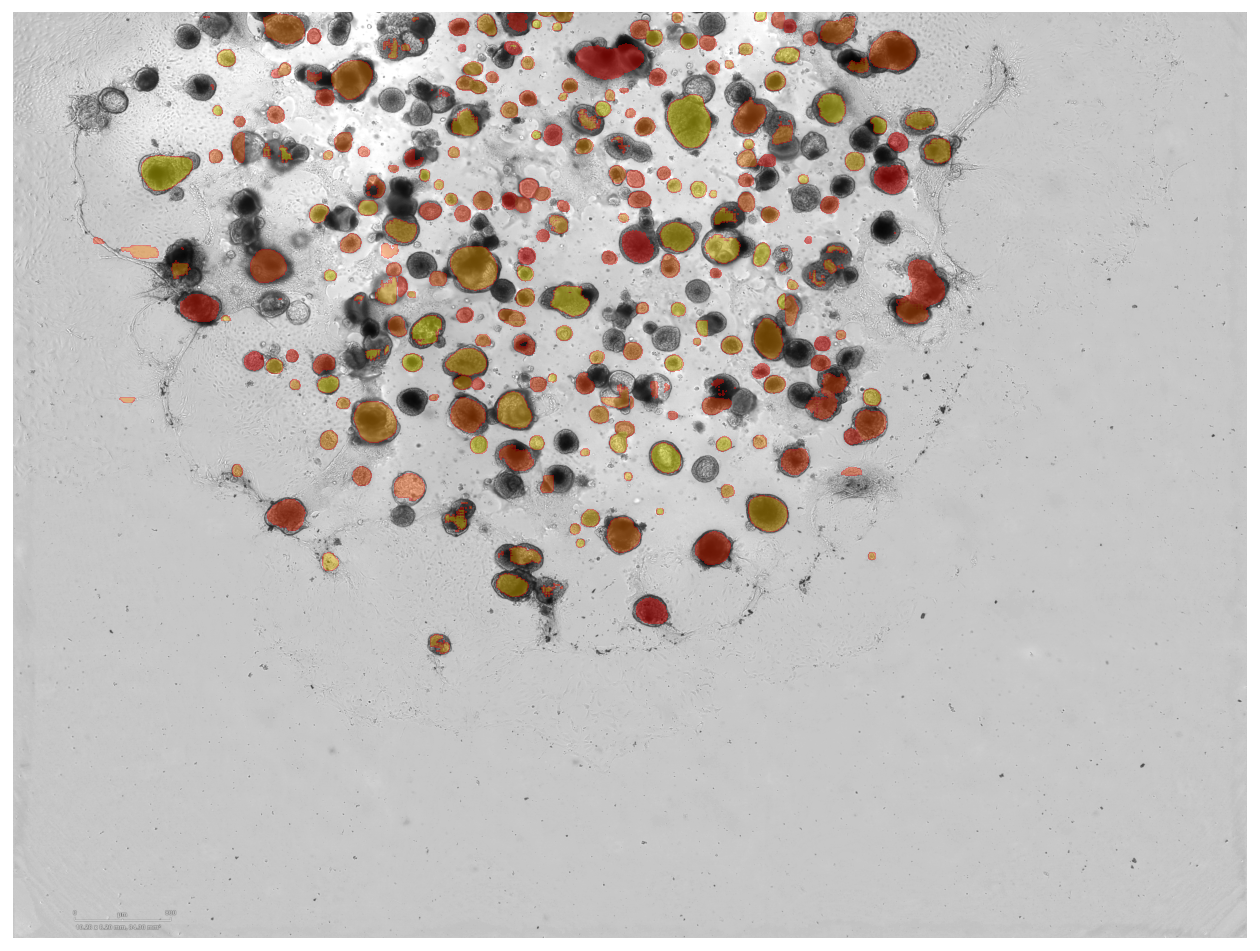

286.2982933521271


In [36]:
# modified inference pipeline - errors in detecting overlap fixed

import cv2
import time
from IPython.display import clear_output
from mrcnn import utils
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib import patches,  lines
import matplotlib.cm as cm
from matplotlib.patches import Polygon, Rectangle
from mrcnn.model import MaskRCNN
import os
import sys
import random
import itertools
import colorsys
import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import time
import itertools
from datetime import timedelta
import pandas as pd
from keras import backend as K 

start_time = time.time()

K.clear_session()
#define start time of code
ROOT_DIR = os.getcwd()
os.chdir(ROOT_DIR)
DEFAULT_LOGS_DIR = r'E:\Standard User Desktop Disk C\Lorenzo'
COCO_WEIGHTS_PATH =  r'E:\Standard User Desktop Disk C\Lorenzo\mask_rcnn_coco.h5'


#get all paths of images of interest
image_paths = [x for x in glob.glob(r"C:\Users\Admin\Downloads\anna_new_model\*")]
print(image_paths)


#initate the loop
for yyy,image_path in enumerate(image_paths):
    clear_output(wait = True)
    print('Analyzing image ' + str(yyy + 1) + ' out of ' + str(len(image_paths)))
    #load the image
    # IMPORTANT: load image using the cv2 grayscale and not the skimage.io.read grayscale as this is not comptabile
    organoid_image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    if len(organoid_image.shape) > 3:
        organoid_image = organoid_image.squeeze()
   
    #frame size
    step_n=512
    #round to multiple of 256
    n=512
    fraction_of_frame_to_step = 2
    step_size = step_n/fraction_of_frame_to_step
    
    magnifying_factor = 1
    
    
    width = organoid_image.shape[1]*magnifying_factor
    height = organoid_image.shape[0]*magnifying_factor
    
    def myround(x, base=n):
        if x < n:
            return 512
        else:
            return base * math.ceil(x/base)
        
    width = myround(width)
    height = myround(height)
    resized = cv2.resize(organoid_image, (width,height), interpolation = cv2.INTER_AREA)


    # generate position ids 
    height_coords = list(range(0, height, int(step_size)))
    width_coords = list(range(0, width, int(step_size)))
    coords_list = [(i,j) for i in height_coords for j in width_coords] 

    # generate 4d array composed of 512x512 image patches of resuzed
    patchez = [resized[i:i+step_n, j:j+step_n] for i,j in coords_list]
    
    patchez = [x for x in patchez if x.shape[0] == 512 and x.shape[1] == 512]

    #exapnd dimensions of images to allow for the 4d images required by mask rcnn
    patchez = [np.expand_dims(x,axis=-1) for x in patchez]

    image_patches = np.stack(patchez, axis = 0)
    number_of_images = image_patches.shape[0]

    # filter coordinate_list to match the above patches
    coords_list = [x for x in coords_list if width - x[1] != int(step_size)]
    coords_list = [x for x in coords_list if height - x[0] != int(step_size)]

    images_per_batch = max([x for x in range(1,number_of_images+1) if not number_of_images%x and x <=5])

    #define class with the images per batch
    class PredictionConfig(Config):
        # define the name of the configuration
        NAME = "spherical_cfg"
        # number of classes (background + Blue Marbles + Non Blue marbles)
        NUM_CLASSES = 1 + 1
        # Set batch size to 1 since we'll be running inference on
                # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
        GPU_COUNT = 1
        # find the largest divisible number that is less than the max number of images possible per GPU
        IMAGES_PER_GPU = images_per_batch
        DETECTION_MIN_CONFIDENCE = 0.6
        IMAGE_CHANNEL_COUNT = 1
        MEAN_PIXEL = mean(resized)
        USE_MINI_MASK=False
        IMAGE_RESIZE_MODE ='crop'
        IMAGE_MIN_DIM = 512
        IMAGE_MAX_DIM = 512
        DETECTION_NMS_THRESHOLD = 0.3
        RPN_ANCHOR_SCALES = (20,q1,q3,whisker_high,400)
        RPN_TRAIN_ANCHORS_PER_IMAGE = 600
        RPN_ANCHOR_STRIDE = 1 
        RPN_ANCHOR_RATIOS = [0.5,1,2]        

    # create config
    cfg = PredictionConfig()
    #cfg.display()

    # define the model
    model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=cfg)
    # load model weights
    model.load_weights(r'E:\mask_rcnn\mask_rcnn_sphericalconfig_0200.h5', by_name=True)


    itr = int(number_of_images/images_per_batch)

    patch_num=1
    positions = []
    rois_list = []
    masks = []
    class_ids = []
    scores = []

    detections = []
    for i in range(0,itr):
        print('Processing batch:', str(i))
        detected = model.detect(image_patches[int((i*images_per_batch)):int((i*images_per_batch)+images_per_batch), :, :,:])
        detections.append(detected)
    detections = [item for sublist in detections for item in sublist] 



    def append_coords(l,x,y):
        l[0] += x
        l[1] += y
        l[2] += x
        l[3] += y
        return l

    # define the limits of the new resized image which all image patches should find themselves within

    x_limits = resized.shape[0] - 512
    y_limits = resized.shape[1] - 512


    #find 'true' patches i.e. those that exist in the image without takings steps
    # generate position ids 
    true_height_coords = list(range(0, height, step_n))
    true_width_coords = list(range(0, width, step_n))
    true_coords_list = [(i,j) for i in true_height_coords for j in true_width_coords] 

    #find true coords indicies in coord_list
    true_coords_indicies = [coords_list.index(x) for  x in true_coords_list]


    from shapely.geometry import Point, Polygon

    #defining overlap calculation functions
    def NMS_alg(bbox1,bbox2):
        OBW = max(bbox1[1], bbox2[1]) - min(bbox1[3], bbox2[3])
        OBH = max(bbox1[0], bbox2[0]) - min(bbox1[2], bbox2[2])
        bbox1_area = (bbox1[3]-bbox1[1])*(bbox1[2]-bbox1[0])
        bbox2_area = (bbox2[3]-bbox2[1])*(bbox2[2]-bbox2[0])

        overlap_box1 = (OBW*OBH)/bbox1_area
        overlap_box2 = (OBW*OBH)/bbox2_area
        return(overlap_box1,overlap_box2,bbox1_area,bbox2_area)

    def check_overlap(bbox1,bbox2):
        polygon1 = Polygon([(bbox1[1],bbox1[0]), (bbox1[3],bbox1[0]), (bbox1[3],bbox1[2]), (bbox1[1],bbox1[2])])
        p1 = Point(bbox2[1],bbox2[0])
        p2 = Point(bbox2[3],bbox2[2])

        polygon2 = Polygon([(bbox2[1],bbox2[0]), (bbox2[3],bbox2[0]), (bbox2[3],bbox2[2]), (bbox2[1],bbox2[2])])
        p3 = Point(bbox1[1],bbox1[0])
        p4 = Point(bbox1[3],bbox1[2])

        if p1.within(polygon1) or p2.within(polygon1) or p1.touches(polygon1) or p2.touches(polygon1) or p3.within(polygon2) or p4.within(polygon2) or p3.touches(polygon2) or p4.touches(polygon2) or p1.distance(p3) < 20 or p2.distance(p4) < 20:
            return NMS_alg(bbox1,bbox2)



        # fix the coordinates of each bounding box so that they map to the original image
    for i in range(len(detections)):
        patch_starting_coords = coords_list[i]

        # fix the coordinates of the bboxes to account for position of patch on image
        for bbox_index in range(len(detections[i]['rois'])):
            x = patch_starting_coords[0]
            y = patch_starting_coords[1]
            detections[i]['rois'][bbox_index] = [detections[i]['rois'][bbox_index][0]+x,
                                                   detections[i]['rois'][bbox_index][1]+y,
                                                   detections[i]['rois'][bbox_index][2]+x,
                                                   detections[i]['rois'][bbox_index][3]+y]



    for i in range(len(coords_list)):
        # get patch coordinates
        patch_coordinates = coords_list[i]
        #get adjacent patches
        adj_right_patch = (patch_coordinates[0],patch_coordinates[1]+step_size)
        if adj_right_patch[0] > x_limits or adj_right_patch[1] > y_limits or adj_right_patch[0] < 0 or adj_right_patch[1] < 0:
            adj_right_patch = None
        adj_left_patch = (patch_coordinates[0],patch_coordinates[1]-step_size)
        if adj_left_patch[0] > x_limits or adj_left_patch[1] > y_limits or adj_left_patch[0] < 0 or adj_left_patch[1] < 0:
            adj_left_patch = None
        adj_down_patch = (patch_coordinates[0]+step_size,patch_coordinates[1])
        if adj_down_patch[0] > x_limits or adj_down_patch[1] > y_limits or adj_down_patch[0] < 0 or adj_down_patch[1] < 0:
            adj_down_patch = None
        adj_top_patch = (patch_coordinates[0]-step_size,patch_coordinates[1])
        if adj_top_patch[0] > x_limits or adj_top_patch[1] > y_limits or adj_top_patch[0] < 0 or adj_top_patch[1] < 0:
            adj_top_patch = None
        adj_diag_down_right_patch = (patch_coordinates[0]+step_size,patch_coordinates[1] + step_size)
        if adj_diag_down_right_patch[0] > x_limits or adj_diag_down_right_patch[1] > y_limits or adj_diag_down_right_patch[0] < 0 or adj_diag_down_right_patch[1] < 0:
            adj_diag_down_right_patch = None
        adj_diag_down_left_patch = (patch_coordinates[0]+step_size,patch_coordinates[1] - step_size)
        if adj_diag_down_left_patch[0] > x_limits or adj_diag_down_left_patch[1] > y_limits or adj_diag_down_left_patch[0] < 0 or adj_diag_down_left_patch[1] < 0:
            adj_diag_down_left_patch = None
        adj_diag_up_right_patch = (patch_coordinates[0]-step_size,patch_coordinates[1] + step_size)
        if adj_diag_up_right_patch[0] > x_limits or adj_diag_up_right_patch[1] > y_limits or adj_diag_up_right_patch[0] < 0 or adj_diag_up_right_patch[1] < 0:
            adj_diag_up_right_patch = None
        adj_diag_up_left_patch = (patch_coordinates[0]-step_size,patch_coordinates[1] - step_size)
        if adj_diag_up_left_patch[0] > x_limits or adj_diag_up_left_patch[1] > y_limits or adj_diag_up_left_patch[0] < 0 or adj_diag_up_left_patch[1] < 0:
            adj_diag_up_left_patch = None

        adjacent_patches = [adj_right_patch,adj_left_patch,adj_down_patch,adj_top_patch,adj_diag_down_right_patch,adj_diag_down_left_patch,adj_diag_up_right_patch,adj_diag_up_left_patch]
        #remove Nones
        adjacent_patches = [x for x in adjacent_patches if x is not None]
        # find indicies of patches in coordinate list
        adjacent_patch_indicies = [coords_list.index(x) for  x in adjacent_patches]


        for overlapping_index in adjacent_patch_indicies:
            if all(number_in_list < len(detections) for number_in_list in adjacent_patch_indicies):
                # check overlap
                overlapping_losers_1 = []
                overlapping_losers_2 = []

                for bbox1 in range(len(detections[i]['rois'])):
                    for bbox2 in range(len(detections[int(overlapping_index)]['rois'])):
                        overlap = check_overlap(detections[i]['rois'][bbox1],detections[int(overlapping_index)]['rois'][bbox2])
                        if overlap != None:
                            if overlap[0] > 0.3 or overlap[1] > 0.3:
                                # get areas
                                if overlap[2] > overlap[3]:
                                    overlapping_losers_2.append(bbox2)
                                else:
                                    overlapping_losers_1.append(bbox1)


                for index in sorted(set(overlapping_losers_1), reverse=True):
                    detections[i]['rois'] = np.delete(detections[i]['rois'], index, 0)
                    detections[i]['class_ids'] = np.delete(detections[i]['class_ids'] , index, 0)
                    detections[i]['scores'] = np.delete(detections[i]['scores'], index, 0)
                    detections[i]['masks'] = np.delete(detections[i]['masks'], index, 2)
                    #real_patch_positions = np.delete(real_patch_positions, index, 0)
                for index in sorted(set(overlapping_losers_2), reverse=True):
                    detections[int(overlapping_index)]['rois'] = np.delete(detections[int(overlapping_index)]['rois'], index, 0)
                    detections[int(overlapping_index)]['class_ids'] = np.delete(detections[int(overlapping_index)]['class_ids'], index, 0)
                    detections[int(overlapping_index)]['scores'] = np.delete(detections[int(overlapping_index)]['scores'], index, 0)
                    detections[int(overlapping_index)]['masks'] = np.delete(detections[int(overlapping_index)]['masks'], index, 2)  
                    #fixed_adj_positions = np.delete(overlapping_patch_positions, index, 0)
            else:
                break



    #generate positions list 
    detection_positions = []

    for i,patch in enumerate(detections):
        patch_positions = [coords_list[i]]*len(patch['rois'])
        detection_positions.append(patch_positions)
    detection_positions = [item for sublist in detection_positions for item in sublist]


    fixed_detections = {}

    for k in set(k for d in detections for k in d):
        fixed_detections[k] = [d[k] for d in detections if k in d]

    fixed_detections['rois'] = np.array([item for sublist in fixed_detections['rois'] for item in sublist])
    fixed_detections['scores'] = np.array([item for sublist in fixed_detections['scores'] for item in sublist])
    fixed_detections['class_ids'] = np.array([item for sublist in fixed_detections['class_ids'] for item in sublist])
    fixed_detections['masks'] = np.dstack(fixed_detections['masks'])
    
    outlier_removal = False
    
    if outlier_removal == True:
        from skimage.measure import regionprops_table
        circularities = []
        areas = []

        for i in range(fixed_detections['masks'].shape[-1]):
            mask = fixed_detections['masks'][...,i].astype('uint8')
            props = list(regionprops_table(
                mask,
                properties=('area', 'perimeter'),
            ).values())
            area = props[0][0]
            perimeter = props[1][0]
            #cirularity equation
            circularity = ((4*math.pi)*area)/(perimeter*perimeter)
            circularities.append(circularity)
            areas.append(area)
        def outliers_modified_z_score(ys, threshold):
            ys_arr = np.array(ys)
            median_y = np.median(ys_arr)
            median_absolute_deviation_y = np.median(np.abs(ys_arr - median_y))
            modified_z_scores = 0.6725 * (ys_arr - median_y) / median_absolute_deviation_y
            return (ys_arr[np.abs(modified_z_scores) > threshold]).tolist()
        
        outlier_by_circularity = True
        outlier_by_area = False
        
        if outlier_by_circularity == True & outlier_by_area == True:
            #trial 2 rather than on outliers we try by value
            outlier_circularities = [x for x in circularities if x < 0.8]
            outlier_areas =  [x for x in areas if x > 10000]
            outlier_areas_defniitely =  [x for x in areas if x > 50000]
            outlier_circularities_index = [circularities.index(outlier_value) for outlier_value in outlier_circularities]
            outlier_areas_index = [areas.index(outlier_value) for outlier_value in outlier_areas]
            outlier_areas_defniitely_index = [areas.index(outlier_value) for outlier_value in outlier_areas_defniitely]
            common_indicies = [x for x in outlier_areas_index if x in outlier_circularities_index]
            #extend with those that are too large
            common_indicies.extend(x for x in outlier_areas_defniitely_index if x not in common_indicies)
            #extend circularities by common ones
            overall_outliers_index = common_indicies
            overall_outliers_index.extend(x for x in outlier_circularities_index if x not in overall_outliers_index)    
            overall_outliers_index = sorted(overall_outliers_index)
            overall_outliers_index = [j-i for (i,j) in enumerate(overall_outliers_index)]
        if outlier_by_circularity == True:
                 #trial 2 rather than on outliers we try by value
            outlier_circularities = [x for x in circularities if x < 0.8]
            outlier_areas =  [x for x in areas if x > 10000]
            outlier_areas_defniitely =  [x for x in areas if x > 50000]
            outlier_circularities_index = [circularities.index(outlier_value) for outlier_value in outlier_circularities]
            outlier_areas_index = [areas.index(outlier_value) for outlier_value in outlier_areas]
            outlier_areas_defniitely_index = [areas.index(outlier_value) for outlier_value in outlier_areas_defniitely]
            common_indicies = [x for x in outlier_areas_index if x in outlier_circularities_index]
            #extend with those that are too large
            common_indicies.extend(x for x in outlier_areas_defniitely_index if x not in common_indicies)
            #extend circularities by common ones
            overall_outliers_index = common_indicies
            overall_outliers_index.extend(x for x in outlier_circularities_index if x not in overall_outliers_index)    
            overall_outliers_index = sorted(overall_outliers_index)
            overall_outliers_index = [j-i for (i,j) in enumerate(overall_outliers_index)]

        for outliner_index in overall_outliers_index:
            fixed_detections['rois'] = np.delete(fixed_detections['rois'],outliner_index,0)
            fixed_detections['class_ids'] = np.delete(fixed_detections['class_ids'],outliner_index,0)
            fixed_detections['scores'] = np.delete(fixed_detections['scores'],outliner_index,0)
            fixed_detections['masks'] = np.delete(fixed_detections['masks'],outliner_index,2)
            del detection_positions[outliner_index]

    if fixed_detections['rois'].shape[0] != 0:
        display_instances_final(resized,
                          boxes = fixed_detections['rois'], 
                          masks = fixed_detections['masks'], 
                          positions = detection_positions,
                          class_ids = fixed_detections['class_ids'],
                          scores =  fixed_detections['scores'],
                          class_names = dataset_train.class_names,
                          show_captions = True,
                          show_bbox = False,
                         show_mask = True,
                               save = True)

        mask_areas = [np.sum(fixed_detections['masks'][:,:,i] == 1) for i in range(fixed_detections['masks'].shape[2])]
        indexes = [item for item in range(0, fixed_detections['masks'].shape[2]+1)]

        df_output = pd.DataFrame(list(zip(indexes, mask_areas)),columns=['Organoid_ID','Area (pixels)'])
        df_output.to_csv(image_path[:-4] + '_detected_output.csv',index=False)
        #clear session prior to moving onto next image
        K.clear_session()
    else:
        cv2.imwrite(image_path[:-4] + '_detected_output.png',resized)
        df_output = pd.DataFrame(list(zip([0], [0])),columns=['Organoid_ID','Area (pixels)'])
        df_output.to_csv(image_path[:-4] + '_detected_output.csv',index=False)
        
print(time.time()-start_time)
